In [1]:
%load_ext autoreload

In [2]:
import os
import sys
import random
from typing import Tuple
import subprocess as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import PIL
import plotnine as p9

import torch
import torchvision
import torchvision.transforms as T

In [3]:
%autoreload 2
from fundus_extractor.utils.general import imshow

In [4]:
def submit_slurm_array(training_save_dir: str, cmds: list, memory_in_gb: int, cores: int, gpu: bool, queue: str,
                       n_parallel_jobs: int, **kwargs) -> None:
    os.makedirs(training_save_dir, exist_ok=True)

    for ii, cmd in enumerate(cmds):
        job_dir = os.path.join(training_save_dir, f'run_{ii}') 
        os.makedirs(job_dir, exist_ok=True)
        job_file = f'{job_dir}/job.sh'
        out_file = f'{job_dir}/out.txt'
        err_file = f'{job_dir}/err.txt'
        with open(job_file, 'w') as handle:
            handle.writelines("#!/bin/bash\n")
            handle.writelines(f"source $HOME/.bashrc\n")
            handle.writelines(f"conda activate deepMMR\n")
            handle.writelines(f'{cmd} >> {out_file} 2>> {err_file}\n\n')
        os.chmod(job_file, 0o777)
        
    job_file = os.path.join(training_save_dir, 'job.sh')
    out_file = os.path.join(training_save_dir, 'out.txt')
    err_file = os.path.join(training_save_dir, 'err.txt')
    
    with open(job_file, 'w') as handle:
        handle.writelines("#!/bin/bash\n")

        handle.writelines('#SBATCH -J MMR_Job_Array\n')
        handle.writelines(f'#SBATCH -o {out_file}\n')
        handle.writelines(f'#SBATCH -e {err_file}\n')

        handle.writelines('#SBATCH -t 24:00:00\n')
        handle.writelines(f'#SBATCH -p {queue}\n')
        handle.writelines(f'#SBATCH -c {cores}\n')
        handle.writelines(f'#SBATCH --mem={memory_in_gb}GB\n')
        if gpu is True:
            handle.writelines('#SBATCH --gres=gpu:1\n')
        handle.writelines(f'#SBATCH -a 0-{len(cmds) - 1}%{n_parallel_jobs}\n')

        handle.writelines(f'cd {training_save_dir}\n')
        handle.writelines('./run_${SLURM_ARRAY_TASK_ID}/job.sh\n')

    sp.Popen(["sbatch", job_file], stdout=sp.PIPE, stderr=sp.PIPE)

In [14]:
class ImageOutOfDistributionError(Exception):
    pass

In [15]:
def resize_image(image: torch.Tensor, image_resize_size: int) -> torch.Tensor:
    return T.functional.resize(image, (image_resize_size, image_resize_size))


def pad_to_square(image: torch.Tensor) -> torch.Tensor:
    _, width, height = image.shape

    # Determine the maximum dimension
    max_dim = max(width, height)

    # Calculate the padding amounts
    pad_width = max_dim - width
    pad_height = max_dim - height

    # Calculate the padding values for top, bottom, left, and right
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left

    # Pad the image with zeros
    return torch.nn.functional.pad(image, (pad_top, pad_bottom, pad_left, pad_right))


def cut_image(image: torch.Tensor, threshold: float = 0.2, min_gray: float = 0.05)-> torch.Tensor:
    gray_image = T.functional.rgb_to_grayscale(image) / 255
    threshold *= torch.mean(gray_image).item()

    # Threshold the grayscale image
    binary_mask = (gray_image > threshold).float()[0]
    if binary_mask.shape[0] < 150 or binary_mask.shape[1] < 150:
        raise ImageOutOfDistributionError()

    cols = torch.mean(binary_mask, dim=0) > min_gray
    left, right = torch.min(torch.where(cols)[0]), torch.max(torch.where(cols)[0])

    rows = torch.mean(binary_mask, dim=1) > min_gray
    top, bottom = torch.min(torch.where(rows)[0]), torch.max(torch.where(rows)[0])

    # Crop the image based on the contour boundaries
    return image[:, top:bottom, left:right]


def subtract_local_mean_color(image: torch.Tensor, scale: int)-> torch.Tensor:
    '''
    Adapted from: https://kaggle-forum-message-attachments.storage.googleapis.com/88655/2795/competitionreport.pdf
    '''
    cv2_image = np.transpose(image.numpy(), (1, 2, 0))
    cv2_image = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB)
    
    cv2_image = cv2.addWeighted(cv2_image, 4, cv2.GaussianBlur(cv2_image, (0, 0), scale / 30), -4, 128)
    
    return T.ToTensor()(cv2_image)

# Preprocessing - transferGWAS

In [ ]:
input_dir = '/s/project/deepMMR/data/fundus/raw'
output_dir = '/s/project/deepMMR/data/fundus/processed_transferGWAS'

cmds = []
for left_right in os.listdir(input_dir):
    for folder in os.listdir(os.path.join(input_dir, left_right)):
        i = os.path.join(input_dir, left_right, folder)
        o = os.path.join(output_dir, left_right, folder)
        cmds.append(f'python3 /data/ouga/home/ag_gagneur/graef/Programs/transferGWAS/pretraining/resize.py {i} {o} --size 448')
print(cmds[0])

submit_slurm_array('/data/ouga/home/ag_gagneur/graef/tmp/slurm/img_processing', cmds, 8, 8, False, 'standard', 32)

# Preprocessing - EyeQ

In [11]:
base_dir = '/s/project/deepMMR/data/fundus/raw' 
save_dir = '/s/project/deepMMR/data/fundus/processed_EyeQ'
cmd = f'python3 /data/ouga/home/ag_gagneur/graef/EyeQ/EyeQ_preprocess/EyeQ_process_main.py --base_dir {base_dir} --save_dir {save_dir}'

submit_slurm_array('/data/ouga/home/ag_gagneur/graef/tmp/slurm/img_processing', [cmd], 32, 32, False, 'standard', 8)

# Image quality assessment - EyeQ/MCF_Net

In [6]:
base_dir = '/s/project/deepMMR/data/fundus/processed_EyeQ'
model_save_path = '/data/nasif12/home_if12/graef/tmp/DenseNet121_v3_v1.tar'
path_to_save_file = '/s/project/deepMMR/data/fundus/processed_transferGWAS/image_quality.tsv'

# os.system(f'python3 /data/ouga/home/ag_gagneur/graef/EyeQ/MCF_Net/run_inference.py --base_dir {base_dir} --model_save_path {model_save_path} --path_to_save_file {path_to_save_file}')

In [7]:
output_metric = pd.read_csv(path_to_save_file, sep='\t')
output_metric['eid'] = [x.split('.')[0].split('/')[-1].split('_')[0] for x in  output_metric['Path']]
output_metric['instance'] = ["_".join(x.split('.')[0].split('/')[-1].split('_')[2:]) for x in  output_metric['Path']]
output_metric['Eye'] = ['left' if x.split('.')[0].split('/')[-1].split('_')[1] == '21015' else 'right' for x in  output_metric['Path']]
output_metric

,Path,Good,Usable,Reject,eid,instance,Eye
0,/s/project/deepMMR/data/fundus/processed_EyeQ/...,0.963027,0.020378,0.016595,1178447,0_0,left
1,/s/project/deepMMR/data/fundus/processed_EyeQ/...,0.061463,0.147927,0.790610,1186186,0_0,left
2,/s/project/deepMMR/data/fundus/processed_EyeQ/...,0.022624,0.058615,0.918761,1181999,0_0,left
3,/s/project/deepMMR/data/fundus/processed_EyeQ/...,0.036510,0.029158,0.934332,1178854,0_0,left
4,/s/project/deepMMR/data/fundus/processed_EyeQ/...,0.024226,0.038245,0.937529,1173877,0_0,left
...,...,...,...,...,...,...,...
178696,/s/project/deepMMR/data/fundus/processed_EyeQ/...,0.945783,0.020158,0.034059,4607590,0_0,right
178697,/s/project/deepMMR/data/fundus/processed_EyeQ/...,0.981874,0.009907,0.008219,4614645,1_0,right
178698,/s/project/deepMMR/data/fundus/processed_EyeQ/...,0.022785,0.120756,0.856459,4607023,0_0,right
178699,/s/project/deepMMR/data/fundus/processed_EyeQ/...,0.769000,0.042615,0.188384,4623261,1_0,right


In [8]:
output_metric = output_metric.sort_values('Reject')

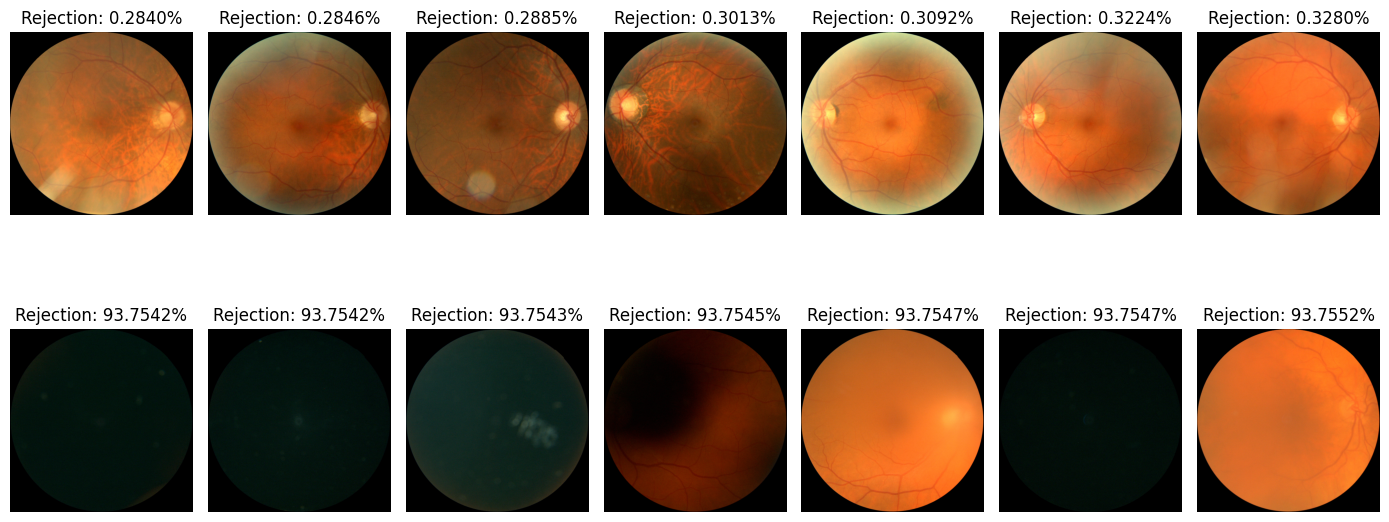

In [9]:
n_images = 7
fig, axes = plt.subplots(2, n_images, figsize=(14,7))

for ii, image_path in enumerate(output_metric.iloc[:n_images][['Reject', 'Path']].iterrows()):
    image = PIL.Image.open(image_path[1]['Path'])
    axes[0, ii].imshow(image)
    axes[0, ii].set_axis_off()
    axes[0, ii].set_title(f'Rejection: {image_path[1]["Reject"] * 100:.4f}%')

for ii, image_path in enumerate(output_metric.iloc[-n_images:][['Reject', 'Path']].iterrows()):
    image = PIL.Image.open(image_path[1]['Path'])
    axes[1, ii].imshow(image)
    axes[1, ii].set_axis_off()
    axes[1, ii].set_title(f'Rejection: {image_path[1]["Reject"] * 100:.4f}%')
fig.tight_layout()
fig.savefig('/data/ouga/home/ag_gagneur/graef/tmp/Fundus_Quality.png')

In [10]:
plot = p9.ggplot(output_metric, p9.aes(x='Reject * 100', color='Eye'))
plot += p9.geom_histogram(bins=30, position=p9.position_dodge())
plot += p9.xlab('Reject score per image [%]')
plot.draw().savefig('/data/ouga/home/ag_gagneur/graef/tmp/Fundus_Rejection.png')

In [11]:
output_metric_both_eyes = output_metric.groupby(['eid', 'instance']).filter(lambda x: len(x) == 2)[['eid', 'instance', 'Eye', 'Reject']]
output_metric_both_eyes = output_metric_both_eyes.pivot_table(index=['eid', 'instance'], columns='Eye', values='Reject').reset_index()
output_metric_both_eyes[['left', 'right']].corr()

Eye,left,right
Eye,,
left,1.000000,0.669062
right,0.669062,1.000000


In [12]:
eids_good_quality_df = output_metric[output_metric['Reject'] < 0.66]
eids_good_quality_df = eids_good_quality_df.groupby(['eid', 'instance']).filter(lambda x: len(x) == 2)[['eid', 'instance']]
eids_good_quality_df = eids_good_quality_df.sort_values('instance')
eids_good_quality_df = eids_good_quality_df.groupby('eid').last().reset_index()
eids_good_quality_df.to_csv('/s/project/deepMMR/data/fundus/processed_transferGWAS/good_eids.tsv', sep='\t')

# Preprocessing - V1

## Random Test

In [ ]:
image_dir = '/s/project/deepMMR/data/fundus/raw/right/00'
image_file_name = random.choice(os.listdir(image_dir))
image_path = os.path.join(image_dir, image_file_name)
print(image_path)

scale = 256

image_raw = torchvision.io.read_image(image_path)
cropped_image = cut_image(image_raw)
padded_image = pad_to_square(cropped_image)
color_corrected_image = subtract_local_mean_color(padded_image, scale)
resized_image = resize_image(color_corrected_image, 256)

# imshow(image_raw)
# imshow(cropped_image)
# imshow(padded_image)
imshow(color_corrected_image)
imshow(resized_image)

### Pipeline

In [17]:
image_dir = '/s/project/deepMMR/data/fundus/raw/left'
save_dir = '/s/project/deepMMR/data/fundus/processed_v_2/left'
scale = 256

for sub_folder in os.listdir(image_dir):
    os.makedirs(os.path.join(save_dir, sub_folder), exist_ok=True)

    for image_file_name in tqdm([img for img in os.listdir(os.path.join(image_dir, sub_folder)) if img.endswith('png')]):
        try:
            file_path = os.path.join(image_dir, sub_folder, image_file_name)
            save_file_path = os.path.join(save_dir, sub_folder, image_file_name)
            eid, fid, instance_id, array_id = file_path.split('.')[0].split('_')

            image_raw = torchvision.io.read_image(file_path)
            cropped_image = cut_image(image_raw)
            padded_image = pad_to_square(cropped_image)
            color_corrected_image = subtract_local_mean_color(padded_image, scale)
            resized_image = resize_image(color_corrected_image, 256)
            torchvision.utils.save_image(resized_image / 255, save_file_path)
        except ImageOutOfDistributionError as e:
            imshow(torchvision.io.read_image(image_path))
            print(image_file_name)
        except Exception as e:
            print(image_file_name)
            print(e)

 32%|███▏      | 159/500 [00:56<01:45,  3.24it/s]

1613884_21015_1_0.png
At most 8-bit PNG images are supported currently.


 61%|██████    | 304/500 [01:51<02:01,  1.62it/s]

1233653_21015_1_0.png
At most 8-bit PNG images are supported currently.


  5%|▍         | 24/500 [00:07<02:58,  2.67it/s]

5159620_21015_1_0.png
At most 8-bit PNG images are supported currently.


 10%|█         | 52/500 [00:18<01:34,  4.75it/s]

3390463_21015_0_0.png
min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


 79%|███████▉  | 396/500 [02:28<00:25,  4.08it/s]

3380762_21015_1_0.png
At most 8-bit PNG images are supported currently.


 10%|█         | 52/500 [00:11<01:49,  4.09it/s]

1550502_21015_1_0.png
At most 8-bit PNG images are supported currently.


 45%|████▍     | 223/500 [00:49<01:01,  4.50it/s]

1550687_21015_1_0.png
At most 8-bit PNG images are supported currently.


 54%|█████▍    | 270/500 [01:34<01:09,  3.32it/s]

3096079_21015_1_0.png
At most 8-bit PNG images are supported currently.


 21%|██        | 103/500 [00:33<01:48,  3.65it/s]

5723043_21015_1_0.png
At most 8-bit PNG images are supported currently.


 69%|██████▉   | 346/500 [01:53<01:06,  2.30it/s]

5008712_21015_1_0.png
At most 8-bit PNG images are supported currently.


 86%|████████▌ | 428/500 [02:40<00:33,  2.17it/s]

5009001_21015_1_0.png
At most 8-bit PNG images are supported currently.


 68%|██████▊   | 339/500 [01:27<00:30,  5.21it/s]

3985286_21015_1_0.png
At most 8-bit PNG images are supported currently.


 85%|████████▌ | 426/500 [01:53<00:12,  6.14it/s]

3970617_21015_1_0.png
At most 8-bit PNG images are supported currently.


 89%|████████▉ | 446/500 [01:57<00:11,  4.80it/s]

3989854_21015_1_0.png
At most 8-bit PNG images are supported currently.


 58%|█████▊    | 292/500 [01:09<00:43,  4.83it/s]

3206142_21015_1_0.png
At most 8-bit PNG images are supported currently.


 91%|█████████ | 455/500 [02:05<00:16,  2.68it/s]

3204271_21015_1_0.png
At most 8-bit PNG images are supported currently.


 22%|██▏       | 111/500 [00:38<01:48,  3.60it/s]

3421683_21015_1_0.png
At most 8-bit PNG images are supported currently.


 24%|██▍       | 121/500 [00:40<01:18,  4.85it/s]

3412044_21015_1_0.png
At most 8-bit PNG images are supported currently.


 83%|████████▎ | 417/500 [02:40<00:22,  3.70it/s]

3423042_21015_1_0.png
At most 8-bit PNG images are supported currently.


 52%|█████▏    | 261/500 [01:58<01:40,  2.37it/s]

5222221_21015_1_0.png
At most 8-bit PNG images are supported currently.


 97%|█████████▋| 484/500 [03:02<00:08,  1.80it/s]

4096952_21015_0_0.png
min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


 16%|█▌        | 81/500 [00:32<01:37,  4.29it/s]

5458757_21015_1_0.png
At most 8-bit PNG images are supported currently.


 24%|██▍       | 120/500 [00:52<02:05,  3.02it/s]

5477435_21015_1_0.png
At most 8-bit PNG images are supported currently.


 36%|███▌      | 178/500 [03:55<01:39,  3.23it/s]  

5457607_21015_1_0.png
At most 8-bit PNG images are supported currently.


 86%|████████▌ | 428/500 [03:59<00:25,  2.86it/s]  

3567398_21015_1_0.png
At most 8-bit PNG images are supported currently.


  3%|▎         | 15/500 [00:10<08:59,  1.11s/it]

4015046_21015_1_0.png
At most 8-bit PNG images are supported currently.


 48%|████▊     | 238/500 [01:37<01:26,  3.02it/s]

4014752_21015_1_0.png
At most 8-bit PNG images are supported currently.


 48%|████▊     | 240/500 [01:37<01:14,  3.51it/s]

4014022_21015_1_0.png
At most 8-bit PNG images are supported currently.


 54%|█████▍    | 272/500 [01:48<00:57,  3.98it/s]

4019535_21015_1_0.png
At most 8-bit PNG images are supported currently.


 97%|█████████▋| 485/500 [05:18<00:03,  4.56it/s] 

2671645_21015_1_0.png
At most 8-bit PNG images are supported currently.


 50%|█████     | 251/500 [01:39<00:52,  4.79it/s]

1140947_21015_1_0.png
At most 8-bit PNG images are supported currently.


 77%|███████▋  | 384/500 [02:27<00:38,  3.02it/s]

1122787_21015_1_0.png
At most 8-bit PNG images are supported currently.


 14%|█▍        | 72/500 [00:21<01:17,  5.52it/s]

2728747_21015_1_0.png
At most 8-bit PNG images are supported currently.


 31%|███       | 154/500 [00:42<01:08,  5.07it/s]

3604026_21015_1_0.png
At most 8-bit PNG images are supported currently.


 80%|███████▉  | 399/500 [02:48<00:46,  2.16it/s]  

3620046_21015_1_0.png
At most 8-bit PNG images are supported currently.


 13%|█▎        | 63/500 [00:19<01:56,  3.75it/s]

2971710_21015_0_0.png
min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


 79%|███████▉  | 395/500 [01:47<00:24,  4.21it/s]

2987246_21015_0_0.png
min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


 64%|██████▍   | 319/500 [02:30<00:34,  5.25it/s] 

1892143_21015_1_0.png
At most 8-bit PNG images are supported currently.


 80%|████████  | 400/500 [01:57<00:30,  3.26it/s]

3710853_21015_1_0.png
At most 8-bit PNG images are supported currently.


 12%|█▏        | 58/500 [00:14<01:14,  5.92it/s]

4748437_21015_1_0.png
At most 8-bit PNG images are supported currently.


 15%|█▍        | 74/500 [00:18<01:30,  4.73it/s]

4755009_21015_1_0.png
At most 8-bit PNG images are supported currently.


 36%|███▌      | 180/500 [00:44<01:15,  4.23it/s]

4755420_21015_1_0.png
At most 8-bit PNG images are supported currently.


 40%|███▉      | 199/500 [00:49<00:53,  5.65it/s]

3118265_21015_1_0.png
At most 8-bit PNG images are supported currently.


 51%|█████     | 256/500 [01:08<00:48,  5.07it/s]

5873465_21015_1_0.png
At most 8-bit PNG images are supported currently.


  1%|          | 5/500 [00:00<01:22,  6.03it/s]

3364606_21015_0_0.png
min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


 62%|██████▏   | 310/500 [03:18<01:40,  1.89it/s]

3349732_21015_1_0.png
At most 8-bit PNG images are supported currently.


 98%|█████████▊| 491/500 [04:38<00:03,  2.29it/s]

3356649_21015_0_0.png
min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


 53%|█████▎    | 263/500 [02:41<02:11,  1.80it/s]

1370016_21015_1_0.png
At most 8-bit PNG images are supported currently.


 71%|███████   | 353/500 [03:51<01:28,  1.66it/s]

2328761_21015_0_0.png
min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


 59%|█████▊    | 293/500 [03:03<00:35,  5.86it/s] 

2530830_21015_1_0.png
At most 8-bit PNG images are supported currently.


 58%|█████▊    | 292/500 [01:53<01:58,  1.76it/s]

5384944_21015_1_0.png
At most 8-bit PNG images are supported currently.


  2%|▏         | 10/500 [00:01<01:26,  5.64it/s]

4220436_21015_1_0.png
At most 8-bit PNG images are supported currently.


 45%|████▍     | 223/500 [00:45<00:53,  5.14it/s]

4241011_21015_0_0.png
min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


 80%|████████  | 400/500 [01:21<00:16,  5.96it/s]

4223174_21015_1_0.png
At most 8-bit PNG images are supported currently.


 23%|██▎       | 113/500 [00:25<01:29,  4.31it/s]

2994369_21015_1_0.png
At most 8-bit PNG images are supported currently.


 56%|█████▌    | 279/500 [01:00<00:33,  6.68it/s]

2988096_21015_1_0.png
At most 8-bit PNG images are supported currently.


 28%|██▊       | 142/500 [00:34<01:00,  5.93it/s]

2902986_21015_0_0.png
min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


 48%|████▊     | 239/500 [00:53<00:38,  6.70it/s]

2484764_21015_1_0.png
At most 8-bit PNG images are supported currently.


 57%|█████▋    | 284/500 [01:03<00:38,  5.61it/s]

2494336_21015_1_0.png
At most 8-bit PNG images are supported currently.


 62%|██████▏   | 310/500 [01:08<00:34,  5.45it/s]

2482532_21015_1_0.png
At most 8-bit PNG images are supported currently.


 96%|█████████▌| 478/500 [01:39<00:05,  4.20it/s]

1101000_21015_1_0.png
At most 8-bit PNG images are supported currently.


 25%|██▌       | 125/500 [00:23<00:57,  6.47it/s]

2576533_21015_1_0.png
At most 8-bit PNG images are supported currently.


 89%|████████▉ | 446/500 [01:29<00:07,  6.90it/s]

2578464_21015_1_0.png
At most 8-bit PNG images are supported currently.


 19%|█▉        | 94/500 [00:18<01:04,  6.33it/s]

4400155_21015_1_0.png
At most 8-bit PNG images are supported currently.


 57%|█████▋    | 285/500 [00:58<00:32,  6.58it/s]

4400694_21015_1_0.png
At most 8-bit PNG images are supported currently.


 50%|█████     | 252/500 [00:52<00:44,  5.62it/s]

4862332_21015_0_0.png
min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


 82%|████████▏ | 409/500 [01:24<00:14,  6.21it/s]

4871436_21015_1_0.png
At most 8-bit PNG images are supported currently.


 99%|█████████▉| 494/500 [01:48<00:00,  6.08it/s]

4866122_21015_1_0.png
At most 8-bit PNG images are supported currently.


 48%|████▊     | 242/500 [01:35<00:47,  5.45it/s]

2432764_21015_0_0.png
min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


 36%|███▌      | 181/500 [00:38<00:45,  7.06it/s]

1315489_21015_1_0.png
At most 8-bit PNG images are supported currently.


 24%|██▍       | 122/500 [00:30<00:53,  7.05it/s]

3762465_21015_1_0.png
At most 8-bit PNG images are supported currently.


 34%|███▍      | 171/500 [01:20<00:59,  5.56it/s]

1990263_21015_1_0.png
At most 8-bit PNG images are supported currently.


 38%|███▊      | 189/500 [01:23<00:48,  6.37it/s]

1988109_21015_1_0.png
At most 8-bit PNG images are supported currently.


 95%|█████████▍| 473/500 [02:10<00:05,  4.96it/s]

4842919_21015_0_0.png
min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


 58%|█████▊    | 290/500 [01:15<01:04,  3.27it/s]

4364360_21015_1_0.png
At most 8-bit PNG images are supported currently.


 17%|█▋        | 87/500 [00:22<01:06,  6.23it/s]

5447019_21015_1_0.png
At most 8-bit PNG images are supported currently.


 63%|██████▎   | 316/500 [01:39<00:40,  4.57it/s]

5433319_21015_1_0.png
At most 8-bit PNG images are supported currently.


 81%|████████  | 404/500 [02:11<00:32,  2.92it/s]

5434953_21015_1_0.png
At most 8-bit PNG images are supported currently.


 93%|█████████▎| 464/500 [02:30<00:08,  4.28it/s]

5439237_21015_1_0.png
At most 8-bit PNG images are supported currently.


 15%|█▌        | 75/500 [00:50<01:30,  4.69it/s] 

3729398_21015_1_0.png
At most 8-bit PNG images are supported currently.


 12%|█▏        | 62/500 [00:23<12:48,  1.75s/it]

5847251_21015_1_0.png
At most 8-bit PNG images are supported currently.


 38%|███▊      | 190/500 [01:14<01:30,  3.43it/s]

5849843_21015_1_0.png
At most 8-bit PNG images are supported currently.


 29%|██▉       | 144/500 [01:05<01:29,  3.98it/s]

3481655_21015_1_0.png
At most 8-bit PNG images are supported currently.


 24%|██▎       | 118/500 [00:45<01:11,  5.35it/s]

2788715_21015_1_0.png
At most 8-bit PNG images are supported currently.


 65%|██████▌   | 326/500 [03:15<01:14,  2.34it/s]

3941006_21015_1_0.png
At most 8-bit PNG images are supported currently.


  1%|          | 4/500 [00:00<01:18,  6.33it/s]

5628667_21015_1_0.png
At most 8-bit PNG images are supported currently.


 16%|█▌        | 79/500 [00:30<02:08,  3.28it/s]

2241471_21015_1_0.png
At most 8-bit PNG images are supported currently.


 29%|██▉       | 145/500 [00:54<01:14,  4.74it/s]

2244338_21015_1_0.png
At most 8-bit PNG images are supported currently.


 45%|████▌     | 227/500 [01:25<01:08,  3.99it/s]

2231265_21015_0_1.png
min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


 23%|██▎       | 117/500 [00:44<02:16,  2.80it/s]

2076536_21015_1_0.png
At most 8-bit PNG images are supported currently.


 34%|███▍      | 170/500 [01:10<01:39,  3.32it/s]

2100025_21015_1_0.png
At most 8-bit PNG images are supported currently.


 16%|█▌        | 81/500 [00:33<03:03,  2.29it/s]

4176883_21015_1_0.png
At most 8-bit PNG images are supported currently.


 23%|██▎       | 117/500 [00:48<01:26,  4.45it/s]

4163341_21015_0_0.png
min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


 30%|███       | 151/500 [01:01<02:28,  2.36it/s]

4164376_21015_1_0.png
At most 8-bit PNG images are supported currently.


 24%|██▍       | 122/500 [00:40<01:58,  3.18it/s]

2829107_21015_1_0.png
At most 8-bit PNG images are supported currently.


 45%|████▌     | 225/500 [01:18<01:12,  3.82it/s]

2825758_21015_1_0.png
At most 8-bit PNG images are supported currently.


 59%|█████▉    | 295/500 [01:26<00:46,  4.40it/s]

2217165_21015_1_0.png
At most 8-bit PNG images are supported currently.


 44%|████▍     | 220/500 [01:02<00:57,  4.90it/s]

1339380_21015_1_0.png
At most 8-bit PNG images are supported currently.


 58%|█████▊    | 290/500 [01:26<00:52,  3.99it/s]

1335856_21015_0_0.png
min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


  7%|▋         | 36/500 [00:09<01:45,  4.40it/s]

3834819_21015_1_0.png
At most 8-bit PNG images are supported currently.


 60%|██████    | 302/500 [01:26<01:12,  2.72it/s]

3845480_21015_1_0.png
At most 8-bit PNG images are supported currently.


  5%|▍         | 24/500 [00:05<01:50,  4.29it/s]

1813601_21015_1_0.png
At most 8-bit PNG images are supported currently.


  3%|▎         | 13/500 [00:04<03:39,  2.22it/s]

4788413_21015_0_0.png
min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


 61%|██████    | 305/500 [01:25<00:42,  4.57it/s]

3271720_21015_0_0.png
min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


  2%|▏         | 8/500 [00:03<02:12,  3.71it/s]

4261091_21015_1_0.png
At most 8-bit PNG images are supported currently.


 79%|███████▉  | 394/500 [01:42<00:31,  3.34it/s]

4262757_21015_1_0.png
At most 8-bit PNG images are supported currently.


 85%|████████▍ | 424/500 [01:48<00:12,  6.15it/s]

4254041_21015_1_0.png
At most 8-bit PNG images are supported currently.


 13%|█▎        | 65/500 [00:14<01:07,  6.48it/s]

4903511_21015_1_0.png
At most 8-bit PNG images are supported currently.


 93%|█████████▎| 463/500 [01:37<00:06,  5.32it/s]

4910702_21015_1_0.png
At most 8-bit PNG images are supported currently.


 85%|████████▌ | 427/500 [01:36<00:13,  5.46it/s]

3125451_21015_1_0.png
At most 8-bit PNG images are supported currently.


 15%|█▌        | 75/500 [00:16<01:17,  5.49it/s]

4816517_21015_1_0.png
At most 8-bit PNG images are supported currently.


 63%|██████▎   | 317/500 [01:14<00:34,  5.31it/s]

4807813_21015_1_0.png
At most 8-bit PNG images are supported currently.


 85%|████████▌ | 425/500 [01:36<00:11,  6.31it/s]

4801514_21015_1_0.png
At most 8-bit PNG images are supported currently.


 72%|███████▏  | 361/500 [01:18<00:29,  4.71it/s]

3038896_21015_1_0.png
At most 8-bit PNG images are supported currently.


 12%|█▏        | 62/500 [00:13<01:03,  6.90it/s]

1682614_21015_1_0.png
At most 8-bit PNG images are supported currently.


 73%|███████▎  | 365/500 [01:20<00:19,  7.07it/s]

1689537_21015_1_0.png
min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


 29%|██▉       | 145/500 [00:31<01:00,  5.89it/s]

3335540_21015_1_0.png
At most 8-bit PNG images are supported currently.


 67%|██████▋   | 337/500 [01:13<00:35,  4.58it/s]

3330871_21015_1_0.png
At most 8-bit PNG images are supported currently.


 88%|████████▊ | 442/500 [01:34<00:10,  5.77it/s]

3338114_21015_0_0.png
min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


  4%|▎         | 18/500 [00:04<01:21,  5.95it/s]

4563817_21015_1_0.png
At most 8-bit PNG images are supported currently.


 30%|██▉       | 148/500 [00:31<00:59,  5.90it/s]

4556818_21015_1_0.png
At most 8-bit PNG images are supported currently.


 87%|████████▋ | 433/500 [01:31<00:10,  6.36it/s]

4559939_21015_1_0.png
At most 8-bit PNG images are supported currently.


 15%|█▍        | 73/500 [00:16<01:22,  5.20it/s]

5551472_21015_1_0.png
At most 8-bit PNG images are supported currently.


 32%|███▏      | 160/500 [01:04<01:16,  4.45it/s]

1852511_21015_1_0.png
At most 8-bit PNG images are supported currently.


 86%|████████▋ | 432/500 [03:16<01:13,  1.08s/it]

2474432_21015_1_0.png
At most 8-bit PNG images are supported currently.


 89%|████████▉ | 444/500 [03:25<00:19,  2.90it/s]

3930386_21015_1_0.png
At most 8-bit PNG images are supported currently.


 91%|█████████ | 453/500 [03:29<00:24,  1.91it/s]

3934641_21015_1_0.png
At most 8-bit PNG images are supported currently.


 12%|█▏        | 61/500 [00:43<03:07,  2.34it/s]

4621026_21015_1_0.png
At most 8-bit PNG images are supported currently.


 28%|██▊       | 141/500 [00:57<02:16,  2.62it/s]

5065435_21015_1_0.png
At most 8-bit PNG images are supported currently.


 91%|█████████ | 456/500 [02:11<00:06,  6.56it/s]

2945933_21015_0_0.png
min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


 77%|███████▋  | 385/500 [02:38<00:30,  3.82it/s]

4980807_21015_1_0.png
At most 8-bit PNG images are supported currently.


 14%|█▍        | 70/500 [00:16<01:30,  4.73it/s]

5422394_21015_1_0.png
At most 8-bit PNG images are supported currently.


 49%|████▉     | 247/500 [01:04<00:46,  5.45it/s]

5401852_21015_1_0.png
At most 8-bit PNG images are supported currently.


 69%|██████▉   | 344/500 [01:31<00:27,  5.64it/s]

5422151_21015_1_0.png
At most 8-bit PNG images are supported currently.


 72%|███████▏  | 361/500 [01:36<00:26,  5.23it/s]

5405589_21015_1_0.png
At most 8-bit PNG images are supported currently.


 80%|███████▉  | 398/500 [01:45<00:22,  4.45it/s]

5401137_21015_1_0.png
At most 8-bit PNG images are supported currently.


 95%|█████████▍| 474/500 [02:07<00:05,  5.03it/s]

5408335_21015_1_0.png
At most 8-bit PNG images are supported currently.


 98%|█████████▊| 490/500 [02:12<00:02,  4.88it/s]

2540093_21015_1_0.png
At most 8-bit PNG images are supported currently.


 24%|██▎       | 118/500 [00:30<01:17,  4.95it/s]

4711101_21015_1_0.png
At most 8-bit PNG images are supported currently.


 89%|████████▉ | 447/500 [01:59<00:11,  4.67it/s]

4699173_21015_1_0.png
At most 8-bit PNG images are supported currently.


 27%|██▋       | 137/500 [00:33<01:28,  4.08it/s]

5526070_21015_1_0.png
At most 8-bit PNG images are supported currently.


 52%|█████▏    | 260/500 [01:04<01:11,  3.34it/s]

5509560_21015_1_0.png
At most 8-bit PNG images are supported currently.


 99%|█████████▉| 496/500 [02:07<00:00,  4.44it/s]

5517542_21015_1_0.png
At most 8-bit PNG images are supported currently.


 78%|███████▊  | 391/500 [01:42<00:26,  4.16it/s]

3856604_21015_1_0.png
At most 8-bit PNG images are supported currently.


 46%|████▌     | 231/500 [00:55<00:45,  5.93it/s]

5183592_21015_0_0.png
min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


 27%|██▋       | 133/500 [00:30<01:13,  5.01it/s]

5738810_21015_1_0.png
At most 8-bit PNG images are supported currently.


 71%|███████   | 353/500 [01:25<00:29,  5.05it/s]

2174297_21015_1_0.png
At most 8-bit PNG images are supported currently.


 87%|████████▋ | 437/500 [01:47<00:17,  3.58it/s]

2166945_21015_1_0.png
At most 8-bit PNG images are supported currently.


 53%|█████▎    | 266/500 [01:42<02:28,  1.57it/s]

2300710_21015_1_0.png
At most 8-bit PNG images are supported currently.


  7%|▋         | 34/500 [00:16<02:02,  3.80it/s]

4723537_21015_1_0.png
At most 8-bit PNG images are supported currently.


 58%|█████▊    | 288/500 [02:01<00:53,  3.96it/s]

4723734_21015_1_0.png
At most 8-bit PNG images are supported currently.


  2%|▏         | 10/500 [00:03<03:18,  2.47it/s]

3655521_21015_1_0.png
At most 8-bit PNG images are supported currently.


  4%|▍         | 21/500 [00:06<01:49,  4.38it/s]

3667002_21015_1_0.png
At most 8-bit PNG images are supported currently.


 61%|██████    | 304/500 [01:54<00:45,  4.33it/s]

3662213_21015_1_0.png
min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


 79%|███████▊  | 393/500 [02:26<00:28,  3.79it/s]

3675358_21015_1_0.png
At most 8-bit PNG images are supported currently.


 10%|█         | 51/500 [00:16<01:35,  4.71it/s]

2726167_21015_0_0.png
min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


 71%|███████   | 353/500 [02:20<00:33,  4.38it/s]

2702799_21015_1_0.png
At most 8-bit PNG images are supported currently.


 38%|███▊      | 189/500 [01:10<01:07,  4.62it/s]

1630927_21015_1_0.png
At most 8-bit PNG images are supported currently.


 41%|████      | 204/500 [01:18<01:23,  3.54it/s]

2644774_21015_1_0.png
At most 8-bit PNG images are supported currently.


 15%|█▍        | 73/500 [00:27<03:39,  1.94it/s]

5591780_21015_1_0.png
At most 8-bit PNG images are supported currently.


 35%|███▌      | 177/500 [01:04<01:28,  3.65it/s]

1720377_21015_1_0.png
At most 8-bit PNG images are supported currently.


 77%|███████▋  | 383/500 [02:23<00:29,  4.03it/s]

1711006_21015_1_0.png
At most 8-bit PNG images are supported currently.


 16%|█▌        | 79/500 [00:26<01:36,  4.36it/s]

2136439_21015_0_0.png
min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


 33%|███▎      | 167/500 [01:06<01:26,  3.86it/s]

3162490_21015_1_0.png
At most 8-bit PNG images are supported currently.


 41%|████      | 203/500 [01:15<01:05,  4.52it/s]

3156363_21015_1_0.png
At most 8-bit PNG images are supported currently.


 71%|███████▏  | 357/500 [02:22<00:45,  3.12it/s]

3651712_21015_1_0.png
At most 8-bit PNG images are supported currently.


 30%|██▉       | 149/500 [01:02<01:11,  4.89it/s]

4438493_21015_1_0.png
At most 8-bit PNG images are supported currently.


 83%|████████▎ | 416/500 [02:52<00:22,  3.68it/s]

4444416_21015_1_0.png
At most 8-bit PNG images are supported currently.


 49%|████▉     | 244/500 [01:34<01:15,  3.39it/s]

2639263_21015_1_0.png
At most 8-bit PNG images are supported currently.


 58%|█████▊    | 289/500 [01:51<01:31,  2.29it/s]

2625782_21015_1_0.png
At most 8-bit PNG images are supported currently.


 70%|██████▉   | 349/500 [02:11<00:53,  2.82it/s]

2637371_21015_1_0.png
At most 8-bit PNG images are supported currently.


 29%|██▊       | 143/500 [00:52<02:06,  2.83it/s]

5571625_21015_1_0.png
At most 8-bit PNG images are supported currently.


 58%|█████▊    | 290/500 [01:38<00:38,  5.50it/s]

5571072_21015_1_0.png
At most 8-bit PNG images are supported currently.


 39%|███▉      | 194/500 [01:08<01:14,  4.13it/s]

3303164_21015_1_0.png
At most 8-bit PNG images are supported currently.


 61%|██████    | 304/500 [01:48<00:58,  3.37it/s]

3305777_21015_1_0.png
At most 8-bit PNG images are supported currently.


 33%|███▎      | 164/500 [01:07<01:22,  4.06it/s]

1854572_21015_1_0.png
At most 8-bit PNG images are supported currently.


 27%|██▋       | 135/500 [00:47<02:32,  2.40it/s]

1421648_21015_1_0.png
At most 8-bit PNG images are supported currently.


 33%|███▎      | 164/500 [00:56<01:02,  5.38it/s]

1411309_21015_1_0.png
At most 8-bit PNG images are supported currently.


 79%|███████▊  | 393/500 [02:28<00:31,  3.43it/s]

1407524_21015_1_0.png
At most 8-bit PNG images are supported currently.


 81%|████████  | 404/500 [02:31<00:24,  3.91it/s]

1409345_21015_1_0.png
At most 8-bit PNG images are supported currently.


 91%|█████████ | 453/500 [02:52<00:14,  3.18it/s]

1429760_21015_0_0.png
min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


  4%|▎         | 18/500 [00:06<03:11,  2.51it/s]

1537650_21015_1_0.png
At most 8-bit PNG images are supported currently.


 54%|█████▍    | 269/500 [01:24<00:58,  3.93it/s]

1373476_21015_1_0.png
At most 8-bit PNG images are supported currently.


 85%|████████▍ | 423/500 [02:07<00:17,  4.43it/s]

1396950_21015_1_0.png
At most 8-bit PNG images are supported currently.


  9%|▉         | 44/500 [00:11<01:34,  4.85it/s]

2269365_21015_1_0.png
At most 8-bit PNG images are supported currently.


 43%|████▎     | 213/500 [01:15<01:17,  3.72it/s]

1945106_21015_1_0.png
At most 8-bit PNG images are supported currently.


 37%|███▋      | 184/500 [01:08<04:14,  1.24it/s]

1676538_21015_1_0.png
At most 8-bit PNG images are supported currently.


 98%|█████████▊| 491/500 [02:55<00:02,  4.09it/s]

1657279_21015_1_0.png
At most 8-bit PNG images are supported currently.


 20%|██        | 102/500 [00:41<02:22,  2.79it/s]

4207867_21015_1_0.png
At most 8-bit PNG images are supported currently.


 52%|█████▏    | 262/500 [01:31<00:59,  4.02it/s]

3581983_21015_1_0.png
At most 8-bit PNG images are supported currently.


 18%|█▊        | 92/500 [00:36<02:04,  3.27it/s]

5306225_21015_1_0.png
At most 8-bit PNG images are supported currently.


 46%|████▌     | 229/500 [01:22<01:21,  3.34it/s]

4414672_21015_1_0.png
At most 8-bit PNG images are supported currently.


 15%|█▍        | 73/500 [00:25<02:15,  3.16it/s]

4348831_21015_1_0.png
At most 8-bit PNG images are supported currently.


 35%|███▌      | 175/500 [01:00<01:08,  4.76it/s]

1265561_21015_1_0.png
At most 8-bit PNG images are supported currently.


  9%|▊         | 43/500 [00:10<01:42,  4.46it/s]

2019084_21015_1_0.png
At most 8-bit PNG images are supported currently.


  9%|▉         | 46/500 [00:12<01:23,  5.42it/s]

1060829_21015_1_0.png
At most 8-bit PNG images are supported currently.


 39%|███▉      | 194/500 [00:49<00:55,  5.52it/s]

1062349_21015_1_0.png
At most 8-bit PNG images are supported currently.


 26%|██▌       | 130/500 [00:41<01:06,  5.60it/s]

1156286_21015_1_0.png
At most 8-bit PNG images are supported currently.


 72%|███████▏  | 359/500 [02:01<00:53,  2.62it/s]

1165903_21015_1_0.png
At most 8-bit PNG images are supported currently.


 25%|██▌       | 125/500 [00:44<02:12,  2.83it/s]

5102826_21015_1_0.png
At most 8-bit PNG images are supported currently.


 83%|████████▎ | 417/500 [02:24<00:26,  3.13it/s]

5083936_21015_1_0.png
At most 8-bit PNG images are supported currently.


 94%|█████████▍| 469/500 [02:43<00:18,  1.70it/s]

5095869_21015_1_0.png
At most 8-bit PNG images are supported currently.


 59%|█████▉    | 294/500 [02:26<00:43,  4.78it/s] 

2605756_21015_0_0.png
min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


 38%|███▊      | 191/500 [01:01<01:11,  4.34it/s]

1765074_21015_0_0.png
min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


 98%|█████████▊| 492/500 [03:14<00:03,  2.42it/s]

4679412_21015_1_0.png
At most 8-bit PNG images are supported currently.


 23%|██▎       | 114/500 [00:41<02:05,  3.07it/s]

1046549_21015_1_0.png
At most 8-bit PNG images are supported currently.


 92%|█████████▏| 460/500 [02:47<00:11,  3.44it/s]

1050853_21015_1_0.png
At most 8-bit PNG images are supported currently.


 34%|███▍      | 172/500 [00:59<01:13,  4.48it/s]

5957553_21015_1_0.png
At most 8-bit PNG images are supported currently.


 75%|███████▌  | 377/500 [02:03<00:45,  2.73it/s]

5930526_21015_1_0.png
At most 8-bit PNG images are supported currently.


  2%|▏         | 12/500 [00:02<01:41,  4.82it/s]

4576121_21015_1_0.png
At most 8-bit PNG images are supported currently.


  5%|▌         | 26/500 [00:05<01:32,  5.11it/s]

3538675_21015_1_0.png
At most 8-bit PNG images are supported currently.


 70%|███████   | 350/500 [01:40<00:39,  3.77it/s]

3533250_21015_1_0.png
At most 8-bit PNG images are supported currently.


 53%|█████▎    | 263/500 [01:00<00:45,  5.23it/s]

3263329_21015_1_0.png
At most 8-bit PNG images are supported currently.


 35%|███▌      | 176/500 [00:39<00:49,  6.50it/s]

5992058_21015_1_0.png
At most 8-bit PNG images are supported currently.


 66%|██████▌   | 328/500 [01:14<00:37,  4.60it/s]

6002768_21015_0_0.png
[Errno 28] No space left on device


 66%|██████▌   | 330/500 [01:15<00:53,  3.19it/s]

5996453_21015_0_0.png
[Errno 28] No space left on device
6012788_21015_0_0.png
[Errno 28] No space left on device


 66%|██████▋   | 332/500 [01:15<00:39,  4.21it/s]

5995778_21015_0_0.png
[Errno 28] No space left on device
5993621_21015_0_0.png
[Errno 28] No space left on device


 67%|██████▋   | 333/500 [01:15<00:35,  4.77it/s]

6014795_21015_0_0.png
[Errno 28] No space left on device


 67%|██████▋   | 335/500 [01:16<00:41,  4.00it/s]

5996408_21015_0_0.png
[Errno 28] No space left on device
5998758_21015_0_0.png
[Errno 28] No space left on device


 67%|██████▋   | 337/500 [01:16<00:35,  4.64it/s]

5986274_21015_1_0.png
[Errno 28] No space left on device
5997639_21015_0_0.png
[Errno 28] No space left on device


 68%|██████▊   | 338/500 [01:16<00:33,  4.89it/s]

5993474_21015_0_0.png
[Errno 28] No space left on device


 68%|██████▊   | 340/500 [01:17<00:33,  4.84it/s]

5988701_21015_0_0.png
[Errno 28] No space left on device
6014273_21015_1_0.png
[Errno 28] No space left on device


 68%|██████▊   | 341/500 [01:17<00:31,  5.05it/s]

5987231_21015_0_0.png
[Errno 28] No space left on device


 69%|██████▊   | 343/500 [01:18<00:39,  4.01it/s]

5989641_21015_0_0.png
[Errno 28] No space left on device
5990322_21015_0_0.png
[Errno 28] No space left on device


 69%|██████▉   | 345/500 [01:18<00:31,  4.87it/s]

5990932_21015_1_0.png
[Errno 28] No space left on device
6000854_21015_0_0.png
[Errno 28] No space left on device


 69%|██████▉   | 347/500 [01:18<00:29,  5.20it/s]

6001315_21015_1_0.png
[Errno 28] No space left on device
5994748_21015_0_0.png
[Errno 28] No space left on device


 70%|██████▉   | 349/500 [01:19<00:27,  5.52it/s]

6005446_21015_0_0.png
[Errno 28] No space left on device
5992791_21015_0_0.png
[Errno 28] No space left on device


 70%|███████   | 351/500 [01:19<00:25,  5.86it/s]

5991085_21015_0_0.png
[Errno 28] No space left on device
5996173_21015_0_0.png
[Errno 28] No space left on device


 71%|███████   | 353/500 [01:19<00:25,  5.71it/s]

6013011_21015_0_0.png
[Errno 28] No space left on device
5997911_21015_0_0.png
[Errno 28] No space left on device


 71%|███████   | 355/500 [01:20<00:27,  5.30it/s]

5989804_21015_0_0.png
[Errno 28] No space left on device
6004829_21015_0_0.png
[Errno 28] No space left on device


 71%|███████▏  | 357/500 [01:20<00:24,  5.83it/s]

6012205_21015_0_0.png
[Errno 28] No space left on device
6013642_21015_0_0.png
[Errno 28] No space left on device


 72%|███████▏  | 359/500 [01:20<00:23,  5.88it/s]

5994245_21015_1_0.png
[Errno 28] No space left on device
5990749_21015_0_0.png
[Errno 28] No space left on device


 72%|███████▏  | 361/500 [01:21<00:35,  3.92it/s]

6001781_21015_1_0.png
[Errno 28] No space left on device
6001114_21015_0_0.png
[Errno 28] No space left on device


 72%|███████▏  | 362/500 [01:21<00:38,  3.61it/s]

5988810_21015_0_0.png
[Errno 28] No space left on device


 73%|███████▎  | 364/500 [01:22<00:31,  4.32it/s]

5989399_21015_0_0.png
[Errno 28] No space left on device
6008216_21015_0_0.png
[Errno 28] No space left on device


 73%|███████▎  | 366/500 [01:22<00:29,  4.51it/s]

6002152_21015_2_1.png
[Errno 28] No space left on device
6011165_21015_0_0.png
[Errno 28] No space left on device


 74%|███████▎  | 368/500 [01:23<00:24,  5.28it/s]

6008727_21015_0_0.png
[Errno 28] No space left on device
6006348_21015_1_0.png
[Errno 28] No space left on device


 74%|███████▍  | 370/500 [01:23<00:23,  5.59it/s]

6002401_21015_0_0.png
[Errno 28] No space left on device
6002604_21015_0_0.png
[Errno 28] No space left on device


 74%|███████▍  | 372/500 [01:23<00:21,  5.96it/s]

5986504_21015_0_0.png
[Errno 28] No space left on device
6013918_21015_0_0.png
[Errno 28] No space left on device


 75%|███████▍  | 374/500 [01:24<00:21,  5.89it/s]

5994826_21015_0_0.png
[Errno 28] No space left on device
5993862_21015_0_0.png
[Errno 28] No space left on device


 75%|███████▌  | 375/500 [01:24<00:20,  6.05it/s]

5995316_21015_0_0.png
[Errno 28] No space left on device


 75%|███████▌  | 377/500 [01:24<00:23,  5.31it/s]

6010196_21015_1_0.png
[Errno 28] No space left on device
6010224_21015_0_0.png
[Errno 28] No space left on device


 76%|███████▌  | 379/500 [01:24<00:21,  5.55it/s]

5986267_21015_1_0.png
[Errno 28] No space left on device
6013876_21015_1_0.png
[Errno 28] No space left on device


 76%|███████▌  | 381/500 [01:25<00:21,  5.61it/s]

5995689_21015_0_0.png
[Errno 28] No space left on device
5997896_21015_1_0.png
[Errno 28] No space left on device


 77%|███████▋  | 383/500 [01:25<00:20,  5.72it/s]

5993348_21015_0_0.png
[Errno 28] No space left on device
6013920_21015_0_0.png
[Errno 28] No space left on device


 77%|███████▋  | 385/500 [01:26<00:36,  3.18it/s]

6012694_21015_0_0.png
[Errno 28] No space left on device
6000791_21015_0_0.png
[Errno 28] No space left on device


 77%|███████▋  | 387/500 [01:26<00:26,  4.27it/s]

5993517_21015_0_0.png
[Errno 28] No space left on device
6007971_21015_0_0.png
[Errno 28] No space left on device


 78%|███████▊  | 388/500 [01:27<00:23,  4.72it/s]

6009321_21015_0_0.png
[Errno 28] No space left on device


 78%|███████▊  | 389/500 [01:27<00:27,  4.07it/s]

5991705_21015_0_0.png
[Errno 28] No space left on device


 78%|███████▊  | 390/500 [01:27<00:35,  3.07it/s]

6006292_21015_0_0.png
[Errno 28] No space left on device


 78%|███████▊  | 392/500 [01:28<00:27,  3.88it/s]

6009083_21015_0_0.png
[Errno 28] No space left on device
6015138_21015_1_0.png
[Errno 28] No space left on device


 79%|███████▉  | 394/500 [01:28<00:22,  4.76it/s]

5997798_21015_0_0.png
[Errno 28] No space left on device
5987483_21015_0_0.png
[Errno 28] No space left on device


 79%|███████▉  | 396/500 [01:29<00:19,  5.24it/s]

5989012_21015_0_0.png
[Errno 28] No space left on device
5999651_21015_1_0.png
[Errno 28] No space left on device


 80%|███████▉  | 398/500 [01:29<00:18,  5.48it/s]

5992272_21015_1_0.png
[Errno 28] No space left on device
6006381_21015_0_0.png
[Errno 28] No space left on device


 80%|████████  | 400/500 [01:29<00:18,  5.50it/s]

6006142_21015_0_0.png
[Errno 28] No space left on device
6014077_21015_1_0.png
[Errno 28] No space left on device


 80%|████████  | 402/500 [01:30<00:18,  5.35it/s]

6003414_21015_0_0.png
[Errno 28] No space left on device
5986769_21015_1_0.png
[Errno 28] No space left on device


 81%|████████  | 403/500 [01:30<00:17,  5.44it/s]

5997911_21015_0_1.png
[Errno 28] No space left on device


 81%|████████  | 404/500 [01:30<00:19,  5.02it/s]

5988755_21015_0_0.png
[Errno 28] No space left on device


 81%|████████  | 406/500 [01:31<00:19,  4.71it/s]

6010927_21015_2_1.png
[Errno 28] No space left on device
6010505_21015_0_0.png
[Errno 28] No space left on device


 82%|████████▏ | 408/500 [01:31<00:17,  5.18it/s]

6015180_21015_0_0.png
[Errno 28] No space left on device
5995069_21015_1_0.png
[Errno 28] No space left on device


 82%|████████▏ | 409/500 [01:31<00:25,  3.53it/s]

5993649_21015_0_0.png
[Errno 28] No space left on device


 82%|████████▏ | 411/500 [01:32<00:21,  4.06it/s]

5997500_21015_0_0.png
[Errno 28] No space left on device
6001479_21015_0_0.png
[Errno 28] No space left on device


 83%|████████▎ | 413/500 [01:32<00:18,  4.58it/s]

5994091_21015_0_0.png
[Errno 28] No space left on device
5999955_21015_1_0.png
[Errno 28] No space left on device


 83%|████████▎ | 415/500 [01:33<00:16,  5.15it/s]

5995485_21015_0_0.png
[Errno 28] No space left on device
6002311_21015_1_0.png
[Errno 28] No space left on device


 83%|████████▎ | 417/500 [01:33<00:15,  5.23it/s]

6010828_21015_1_0.png
[Errno 28] No space left on device
5992395_21015_1_0.png
[Errno 28] No space left on device


 84%|████████▍ | 419/500 [01:33<00:14,  5.57it/s]

6012004_21015_0_0.png
[Errno 28] No space left on device
5999934_21015_0_0.png
[Errno 28] No space left on device


 84%|████████▍ | 420/500 [01:34<00:20,  3.88it/s]

6007164_21015_0_0.png
[Errno 28] No space left on device


 84%|████████▍ | 421/500 [01:34<00:26,  2.94it/s]

5991068_21015_1_0.png
[Errno 28] No space left on device


 84%|████████▍ | 422/500 [01:35<00:30,  2.53it/s]

6006961_21015_0_0.png
[Errno 28] No space left on device


 85%|████████▍ | 423/500 [01:35<00:31,  2.41it/s]

5990768_21015_0_0.png
[Errno 28] No space left on device


 85%|████████▍ | 424/500 [01:36<00:35,  2.13it/s]

6008901_21015_0_0.png
[Errno 28] No space left on device


 85%|████████▌ | 425/500 [01:36<00:29,  2.53it/s]

6002561_21015_1_0.png
[Errno 28] No space left on device


 85%|████████▌ | 427/500 [01:36<00:21,  3.32it/s]

5993119_21015_2_1.png
[Errno 28] No space left on device
5996858_21015_0_0.png
[Errno 28] No space left on device


 86%|████████▌ | 429/500 [01:37<00:16,  4.40it/s]

5987456_21015_0_0.png
[Errno 28] No space left on device
5989501_21015_0_0.png
[Errno 28] No space left on device


 86%|████████▌ | 431/500 [01:37<00:16,  4.31it/s]

6011506_21015_0_0.png
[Errno 28] No space left on device
5987795_21015_0_0.png
[Errno 28] No space left on device


 87%|████████▋ | 433/500 [01:38<00:13,  4.84it/s]

5989400_21015_1_0.png
[Errno 28] No space left on device
6003646_21015_1_0.png
[Errno 28] No space left on device


 87%|████████▋ | 434/500 [01:38<00:12,  5.26it/s]

6011019_21015_0_0.png
[Errno 28] No space left on device


 87%|████████▋ | 435/500 [01:38<00:13,  4.86it/s]

6004847_21015_1_0.png
[Errno 28] No space left on device


 87%|████████▋ | 436/500 [01:39<00:18,  3.51it/s]

5991432_21015_1_0.png
[Errno 28] No space left on device


 87%|████████▋ | 437/500 [01:39<00:18,  3.32it/s]

6008987_21015_0_0.png
[Errno 28] No space left on device


 88%|████████▊ | 439/500 [01:39<00:15,  4.01it/s]

6000473_21015_0_0.png
[Errno 28] No space left on device
5990866_21015_1_0.png
[Errno 28] No space left on device


 88%|████████▊ | 441/500 [01:40<00:12,  4.58it/s]

5991356_21015_0_0.png
[Errno 28] No space left on device
6004542_21015_1_0.png
[Errno 28] No space left on device


 89%|████████▊ | 443/500 [01:40<00:10,  5.48it/s]

6006397_21015_0_0.png
[Errno 28] No space left on device
6006178_21015_1_0.png
[Errno 28] No space left on device


 89%|████████▉ | 445/500 [01:40<00:09,  5.75it/s]

5997270_21015_0_0.png
[Errno 28] No space left on device
6000416_21015_0_0.png
[Errno 28] No space left on device


 89%|████████▉ | 447/500 [01:41<00:12,  4.39it/s]

6002785_21015_1_0.png
[Errno 28] No space left on device
5992404_21015_0_0.png
[Errno 28] No space left on device


 90%|████████▉ | 449/500 [01:41<00:10,  4.84it/s]

5997627_21015_0_0.png
[Errno 28] No space left on device
6006016_21015_1_0.png
[Errno 28] No space left on device


 90%|█████████ | 451/500 [01:42<00:09,  5.21it/s]

6014499_21015_0_0.png
[Errno 28] No space left on device
6008077_21015_0_0.png
[Errno 28] No space left on device


 91%|█████████ | 453/500 [01:42<00:08,  5.75it/s]

5990629_21015_0_0.png
[Errno 28] No space left on device
5989158_21015_1_0.png
[Errno 28] No space left on device


 91%|█████████ | 455/500 [01:42<00:07,  5.98it/s]

6005922_21015_0_0.png
[Errno 28] No space left on device
5988048_21015_1_0.png
[Errno 28] No space left on device


 91%|█████████ | 456/500 [01:42<00:07,  5.77it/s]

5989991_21015_0_0.png
[Errno 28] No space left on device


 92%|█████████▏| 458/500 [01:43<00:08,  5.17it/s]

5989587_21015_0_0.png
[Errno 28] No space left on device
6002721_21015_0_0.png
[Errno 28] No space left on device


 92%|█████████▏| 460/500 [01:43<00:07,  5.50it/s]

5988603_21015_0_0.png
[Errno 28] No space left on device
6011585_21015_0_0.png
[Errno 28] No space left on device


 92%|█████████▏| 462/500 [01:44<00:07,  5.37it/s]

6011093_21015_1_0.png
[Errno 28] No space left on device
6008978_21015_0_0.png
[Errno 28] No space left on device


 93%|█████████▎| 464/500 [01:44<00:06,  5.66it/s]

5988331_21015_0_0.png
[Errno 28] No space left on device
6010468_21015_0_0.png
[Errno 28] No space left on device


 93%|█████████▎| 466/500 [01:44<00:06,  5.58it/s]

6002434_21015_0_0.png
[Errno 28] No space left on device
5992992_21015_1_0.png
[Errno 28] No space left on device


 94%|█████████▎| 468/500 [01:45<00:05,  5.73it/s]

6002770_21015_0_0.png
[Errno 28] No space left on device
6001052_21015_0_0.png
[Errno 28] No space left on device


 94%|█████████▍| 470/500 [01:45<00:05,  5.54it/s]

5999247_21015_0_0.png
[Errno 28] No space left on device
5990039_21015_0_0.png
[Errno 28] No space left on device


 94%|█████████▍| 471/500 [01:45<00:05,  5.63it/s]

5999461_21015_0_0.png
[Errno 28] No space left on device


 94%|█████████▍| 472/500 [01:46<00:06,  4.40it/s]

5985876_21015_0_0.png
[Errno 28] No space left on device


 95%|█████████▍| 473/500 [01:46<00:08,  3.22it/s]

5986140_21015_0_0.png
[Errno 28] No space left on device


 95%|█████████▍| 474/500 [01:46<00:07,  3.30it/s]

6004991_21015_2_1.png
[Errno 28] No space left on device


 95%|█████████▌| 475/500 [01:47<00:07,  3.20it/s]

5997859_21015_2_1.png
[Errno 28] No space left on device


 95%|█████████▌| 476/500 [01:47<00:06,  3.48it/s]

6008410_21015_1_0.png
[Errno 28] No space left on device


 96%|█████████▌| 478/500 [01:47<00:05,  4.13it/s]

6014059_21015_0_0.png
[Errno 28] No space left on device
6012935_21015_1_0.png
[Errno 28] No space left on device


 96%|█████████▌| 480/500 [01:48<00:04,  4.68it/s]

5993827_21015_0_0.png
[Errno 28] No space left on device
5989335_21015_0_0.png
[Errno 28] No space left on device


 96%|█████████▋| 482/500 [01:48<00:03,  5.07it/s]

5994127_21015_0_0.png
[Errno 28] No space left on device
5995690_21015_0_0.png
[Errno 28] No space left on device


 97%|█████████▋| 483/500 [01:49<00:05,  3.10it/s]

5996182_21015_0_0.png
[Errno 28] No space left on device


 97%|█████████▋| 485/500 [01:49<00:03,  4.01it/s]

5991542_21015_0_0.png
[Errno 28] No space left on device
6001985_21015_0_0.png
[Errno 28] No space left on device


 97%|█████████▋| 487/500 [01:49<00:02,  4.88it/s]

6010872_21015_0_0.png
[Errno 28] No space left on device
5996034_21015_0_0.png
[Errno 28] No space left on device


 98%|█████████▊| 488/500 [01:50<00:02,  4.94it/s]

5995719_21015_0_0.png
[Errno 28] No space left on device


 98%|█████████▊| 490/500 [01:50<00:02,  4.85it/s]

5997729_21015_1_0.png
[Errno 28] No space left on device
5991587_21015_1_0.png
[Errno 28] No space left on device


 98%|█████████▊| 492/500 [01:50<00:01,  5.43it/s]

6009852_21015_0_0.png
[Errno 28] No space left on device
5999833_21015_0_0.png
[Errno 28] No space left on device


 99%|█████████▊| 493/500 [01:51<00:01,  5.45it/s]

6014247_21015_0_0.png
[Errno 28] No space left on device


 99%|█████████▉| 495/500 [01:51<00:00,  5.25it/s]

5993178_21015_0_0.png
[Errno 28] No space left on device
6010971_21015_0_1.png
[Errno 28] No space left on device


 99%|█████████▉| 497/500 [01:51<00:00,  5.57it/s]

6004448_21015_1_0.png
[Errno 28] No space left on device
6012101_21015_0_0.png
[Errno 28] No space left on device


100%|█████████▉| 499/500 [01:52<00:00,  5.62it/s]

6006895_21015_0_0.png
[Errno 28] No space left on device
5988914_21015_0_0.png
[Errno 28] No space left on device


100%|██████████| 500/500 [01:52<00:00,  4.45it/s]


5991400_21015_0_0.png
[Errno 28] No space left on device


  0%|          | 1/500 [00:00<01:13,  6.77it/s]

2071825_21015_0_0.png
[Errno 28] No space left on device


  0%|          | 2/500 [00:00<01:14,  6.66it/s]

2049251_21015_0_0.png
[Errno 28] No space left on device


  1%|          | 3/500 [00:00<01:15,  6.58it/s]

2049871_21015_1_0.png
[Errno 28] No space left on device


  1%|          | 4/500 [00:00<01:20,  6.16it/s]

2049563_21015_0_0.png
[Errno 28] No space left on device


  1%|          | 5/500 [00:00<01:21,  6.07it/s]

2069041_21015_0_0.png
[Errno 28] No space left on device


  1%|          | 6/500 [00:00<01:26,  5.74it/s]

2060665_21015_1_0.png
[Errno 28] No space left on device


  1%|▏         | 7/500 [00:01<01:22,  5.99it/s]

2066845_21015_0_0.png
[Errno 28] No space left on device


  2%|▏         | 8/500 [00:01<01:26,  5.69it/s]

2063871_21015_1_0.png
[Errno 28] No space left on device


  2%|▏         | 9/500 [00:01<01:22,  5.97it/s]

2058828_21015_0_0.png
[Errno 28] No space left on device


  2%|▏         | 10/500 [00:01<01:23,  5.85it/s]

2063218_21015_0_0.png
[Errno 28] No space left on device


  2%|▏         | 11/500 [00:01<01:19,  6.12it/s]

2068965_21015_0_0.png
[Errno 28] No space left on device


  2%|▏         | 12/500 [00:01<01:19,  6.18it/s]

2062340_21015_0_0.png
[Errno 28] No space left on device


  3%|▎         | 14/500 [00:02<01:33,  5.21it/s]

2053981_21015_1_0.png
[Errno 28] No space left on device
2060434_21015_0_0.png
[Errno 28] No space left on device


  3%|▎         | 16/500 [00:02<01:25,  5.69it/s]

2069978_21015_0_0.png
[Errno 28] No space left on device
2058000_21015_0_0.png
[Errno 28] No space left on device


  3%|▎         | 17/500 [00:02<01:23,  5.77it/s]

2048170_21015_0_0.png
[Errno 28] No space left on device


  4%|▍         | 19/500 [00:03<01:32,  5.18it/s]

2049827_21015_0_0.png
[Errno 28] No space left on device
2067704_21015_0_0.png
[Errno 28] No space left on device


  4%|▍         | 21/500 [00:04<01:58,  4.04it/s]

2045680_21015_0_0.png
[Errno 28] No space left on device
2057978_21015_0_0.png
[Errno 28] No space left on device


  5%|▍         | 23/500 [00:04<01:35,  4.97it/s]

2062738_21015_0_0.png
[Errno 28] No space left on device
2066182_21015_0_0.png
[Errno 28] No space left on device


  5%|▍         | 24/500 [00:04<01:43,  4.59it/s]

2073962_21015_0_0.png
[Errno 28] No space left on device


  5%|▌         | 25/500 [00:05<02:15,  3.51it/s]

2060794_21015_0_0.png
[Errno 28] No space left on device


  5%|▌         | 26/500 [00:05<02:43,  2.90it/s]

2070357_21015_0_0.png
[Errno 28] No space left on device


  5%|▌         | 27/500 [00:05<02:25,  3.26it/s]

2055121_21015_0_0.png
[Errno 28] No space left on device


  6%|▌         | 28/500 [00:06<02:34,  3.06it/s]

2063814_21015_0_0.png
[Errno 28] No space left on device


  6%|▌         | 29/500 [00:06<02:59,  2.63it/s]

2048693_21015_0_0.png
[Errno 28] No space left on device


  6%|▌         | 30/500 [00:06<02:36,  3.00it/s]

2073810_21015_0_0.png
[Errno 28] No space left on device


  6%|▌         | 31/500 [00:07<02:27,  3.18it/s]

2067773_21015_0_0.png
[Errno 28] No space left on device


  6%|▋         | 32/500 [00:07<02:13,  3.52it/s]

2062876_21015_0_0.png
[Errno 28] No space left on device


  7%|▋         | 34/500 [00:07<02:02,  3.80it/s]

2055404_21015_2_1.png
[Errno 28] No space left on device
2046676_21015_0_0.png
[Errno 28] No space left on device


  7%|▋         | 36/500 [00:08<01:38,  4.72it/s]

2064063_21015_0_0.png
[Errno 28] No space left on device
2055642_21015_0_0.png
[Errno 28] No space left on device


  8%|▊         | 38/500 [00:08<01:27,  5.30it/s]

2060749_21015_1_0.png
[Errno 28] No space left on device
2072526_21015_1_0.png
[Errno 28] No space left on device


  8%|▊         | 40/500 [00:08<01:23,  5.52it/s]

2054370_21015_0_0.png
[Errno 28] No space left on device
2062655_21015_0_0.png
[Errno 28] No space left on device


  8%|▊         | 41/500 [00:09<01:25,  5.39it/s]

2045675_21015_0_0.png
[Errno 28] No space left on device


  8%|▊         | 42/500 [00:09<01:45,  4.35it/s]

2060163_21015_2_1.png
[Errno 28] No space left on device


  9%|▉         | 44/500 [00:09<01:34,  4.84it/s]

2055763_21015_0_0.png
[Errno 28] No space left on device
2050110_21015_1_0.png
[Errno 28] No space left on device


  9%|▉         | 46/500 [00:10<01:25,  5.29it/s]

2066652_21015_0_0.png
[Errno 28] No space left on device
2072555_21015_1_0.png
[Errno 28] No space left on device


 10%|▉         | 48/500 [00:10<01:21,  5.57it/s]

2076216_21015_0_0.png
[Errno 28] No space left on device
2066173_21015_1_0.png
[Errno 28] No space left on device


 10%|▉         | 49/500 [00:10<01:16,  5.86it/s]

2056933_21015_0_0.png
[Errno 28] No space left on device


 10%|█         | 51/500 [00:11<01:25,  5.28it/s]

2057231_21015_2_1.png
[Errno 28] No space left on device
2074513_21015_0_0.png
[Errno 28] No space left on device


 11%|█         | 53/500 [00:11<01:17,  5.77it/s]

2073382_21015_0_0.png
[Errno 28] No space left on device
2045624_21015_0_0.png
[Errno 28] No space left on device


 11%|█         | 55/500 [00:11<01:13,  6.03it/s]

2066941_21015_0_0.png
[Errno 28] No space left on device
2061519_21015_1_0.png
[Errno 28] No space left on device


 11%|█▏        | 57/500 [00:12<01:12,  6.08it/s]

2069273_21015_0_0.png
[Errno 28] No space left on device
2055339_21015_0_0.png
[Errno 28] No space left on device


 12%|█▏        | 58/500 [00:12<01:14,  5.93it/s]

2070514_21015_0_0.png
[Errno 28] No space left on device


 12%|█▏        | 60/500 [00:12<01:32,  4.76it/s]

2056437_21015_0_0.png
[Errno 28] No space left on device
2062404_21015_1_0.png
[Errno 28] No space left on device


 12%|█▏        | 62/500 [00:13<01:23,  5.27it/s]

2059831_21015_0_0.png
[Errno 28] No space left on device
2066026_21015_1_0.png
[Errno 28] No space left on device


 13%|█▎        | 64/500 [00:13<01:14,  5.89it/s]

2066964_21015_0_0.png
[Errno 28] No space left on device
2063910_21015_0_0.png
[Errno 28] No space left on device


 13%|█▎        | 66/500 [00:13<01:31,  4.75it/s]

2052568_21015_0_0.png
[Errno 28] No space left on device
2061555_21015_0_0.png
[Errno 28] No space left on device


 14%|█▎        | 68/500 [00:14<01:23,  5.18it/s]

2058995_21015_0_0.png
[Errno 28] No space left on device
2048937_21015_0_0.png
[Errno 28] No space left on device


 14%|█▍        | 70/500 [00:14<01:33,  4.58it/s]

2073141_21015_2_1.png
[Errno 28] No space left on device
2058406_21015_0_0.png
[Errno 28] No space left on device


 14%|█▍        | 72/500 [00:15<01:31,  4.66it/s]

2074729_21015_0_0.png
[Errno 28] No space left on device
2065861_21015_1_0.png
[Errno 28] No space left on device


 15%|█▍        | 74/500 [00:15<01:25,  5.01it/s]

2070676_21015_0_0.png
[Errno 28] No space left on device
2059542_21015_0_0.png
[Errno 28] No space left on device


 15%|█▌        | 76/500 [00:15<01:17,  5.47it/s]

2058755_21015_0_0.png
[Errno 28] No space left on device
2066392_21015_1_0.png
[Errno 28] No space left on device


 16%|█▌        | 78/500 [00:16<01:15,  5.57it/s]

2067990_21015_0_0.png
[Errno 28] No space left on device
2053493_21015_0_0.png
[Errno 28] No space left on device


 16%|█▌        | 80/500 [00:16<01:13,  5.75it/s]

2075895_21015_0_0.png
[Errno 28] No space left on device
2054681_21015_0_0.png
[Errno 28] No space left on device


 16%|█▋        | 82/500 [00:16<01:13,  5.66it/s]

2054357_21015_0_0.png
[Errno 28] No space left on device
2062619_21015_0_0.png
[Errno 28] No space left on device


 17%|█▋        | 84/500 [00:17<01:10,  5.93it/s]

2063266_21015_0_1.png
[Errno 28] No space left on device
2054044_21015_0_0.png
[Errno 28] No space left on device


 17%|█▋        | 86/500 [00:17<01:08,  6.04it/s]

2061167_21015_0_0.png
[Errno 28] No space left on device
2056582_21015_0_0.png
[Errno 28] No space left on device


 18%|█▊        | 88/500 [00:17<01:08,  5.99it/s]

2053401_21015_1_0.png
[Errno 28] No space left on device
2064933_21015_0_0.png
[Errno 28] No space left on device


 18%|█▊        | 90/500 [00:18<01:13,  5.56it/s]

2063759_21015_0_0.png
[Errno 28] No space left on device
2045744_21015_0_0.png
[Errno 28] No space left on device


 18%|█▊        | 91/500 [00:18<01:11,  5.76it/s]

2060288_21015_0_0.png
[Errno 28] No space left on device


 19%|█▊        | 93/500 [00:19<01:31,  4.43it/s]

2066923_21015_0_0.png
[Errno 28] No space left on device
2048791_21015_0_0.png
[Errno 28] No space left on device


 19%|█▉        | 94/500 [00:19<01:29,  4.55it/s]

2055308_21015_0_0.png
[Errno 28] No space left on device


 19%|█▉        | 95/500 [00:19<01:30,  4.46it/s]

2065331_21015_0_0.png
[Errno 28] No space left on device


 19%|█▉        | 96/500 [00:19<01:28,  4.58it/s]

2075047_21015_0_0.png
[Errno 28] No space left on device


 19%|█▉        | 97/500 [00:19<01:26,  4.68it/s]

2068306_21015_0_0.png
[Errno 28] No space left on device


 20%|█▉        | 99/500 [00:20<01:22,  4.88it/s]

2062003_21015_0_0.png
[Errno 28] No space left on device
2074823_21015_0_0.png
[Errno 28] No space left on device


 20%|██        | 100/500 [00:20<01:26,  4.63it/s]

2057901_21015_1_0.png
[Errno 28] No space left on device


 20%|██        | 102/500 [00:21<01:26,  4.60it/s]

2059021_21015_1_0.png
[Errno 28] No space left on device
2045930_21015_0_0.png
[Errno 28] No space left on device


 21%|██        | 104/500 [00:21<01:22,  4.80it/s]

2067233_21015_2_1.png
[Errno 28] No space left on device
2047519_21015_0_0.png
[Errno 28] No space left on device


 21%|██        | 106/500 [00:21<01:16,  5.15it/s]

2051160_21015_0_0.png
[Errno 28] No space left on device
2054441_21015_0_0.png
[Errno 28] No space left on device


 22%|██▏       | 108/500 [00:22<01:10,  5.54it/s]

2055168_21015_1_0.png
[Errno 28] No space left on device
2059476_21015_1_0.png
[Errno 28] No space left on device


 22%|██▏       | 109/500 [00:22<01:08,  5.69it/s]

2057812_21015_0_0.png
[Errno 28] No space left on device


 22%|██▏       | 111/500 [00:22<01:25,  4.55it/s]

2054586_21015_0_0.png
[Errno 28] No space left on device
2049266_21015_0_0.png
[Errno 28] No space left on device


 23%|██▎       | 113/500 [00:23<01:15,  5.10it/s]

2066783_21015_0_0.png
[Errno 28] No space left on device
2061167_21015_1_0.png
[Errno 28] No space left on device


 23%|██▎       | 115/500 [00:23<01:11,  5.42it/s]

2050548_21015_0_0.png
[Errno 28] No space left on device
2058914_21015_0_0.png
[Errno 28] No space left on device


 23%|██▎       | 116/500 [00:23<01:09,  5.53it/s]

2058159_21015_1_0.png
[Errno 28] No space left on device


 24%|██▎       | 118/500 [00:24<01:20,  4.75it/s]

2054349_21015_1_0.png
[Errno 28] No space left on device
2048738_21015_1_0.png
[Errno 28] No space left on device


 24%|██▍       | 119/500 [00:24<01:13,  5.17it/s]

2051871_21015_0_0.png
[Errno 28] No space left on device


 24%|██▍       | 120/500 [00:24<01:16,  4.96it/s]

2071905_21015_0_0.png
[Errno 28] No space left on device


 24%|██▍       | 122/500 [00:25<01:13,  5.11it/s]

2072006_21015_0_0.png
[Errno 28] No space left on device
2073592_21015_0_0.png
[Errno 28] No space left on device


 25%|██▍       | 123/500 [00:25<01:10,  5.36it/s]

2051474_21015_0_0.png
[Errno 28] No space left on device


 25%|██▍       | 124/500 [00:57<1:00:46,  9.70s/it]

2058054_21015_0_0.png
[Errno 28] No space left on device


 25%|██▌       | 126/500 [00:57<30:13,  4.85s/it]  

2046824_21015_0_0.png
[Errno 28] No space left on device
2052276_21015_0_0.png
[Errno 28] No space left on device


 26%|██▌       | 128/500 [00:57<15:19,  2.47s/it]

2065246_21015_0_0.png
[Errno 28] No space left on device
2052297_21015_0_0.png
[Errno 28] No space left on device


 26%|██▌       | 130/500 [00:58<08:00,  1.30s/it]

2054166_21015_0_0.png
[Errno 28] No space left on device
2063606_21015_1_0.png
[Errno 28] No space left on device


 26%|██▋       | 132/500 [00:58<04:27,  1.38it/s]

2053631_21015_1_0.png
[Errno 28] No space left on device
2075332_21015_0_0.png
[Errno 28] No space left on device


 27%|██▋       | 133/500 [00:59<04:10,  1.47it/s]

2067438_21015_0_0.png
[Errno 28] No space left on device


 27%|██▋       | 134/500 [00:59<03:24,  1.79it/s]

2064985_21015_2_1.png
[Errno 28] No space left on device


 27%|██▋       | 136/500 [00:59<02:13,  2.72it/s]

2069558_21015_0_0.png
[Errno 28] No space left on device
2068010_21015_0_0.png
[Errno 28] No space left on device


 28%|██▊       | 138/500 [01:00<01:34,  3.85it/s]

2066506_21015_0_0.png
[Errno 28] No space left on device
2068916_21015_1_0.png
[Errno 28] No space left on device


 28%|██▊       | 140/500 [01:00<01:16,  4.72it/s]

2075126_21015_0_0.png
[Errno 28] No space left on device
2064127_21015_0_0.png
[Errno 28] No space left on device


 28%|██▊       | 142/500 [01:00<01:10,  5.08it/s]

2059560_21015_0_0.png
[Errno 28] No space left on device
2065406_21015_1_0.png
[Errno 28] No space left on device


 29%|██▉       | 144/500 [01:01<01:08,  5.19it/s]

2065689_21015_0_0.png
[Errno 28] No space left on device
2074037_21015_0_0.png
[Errno 28] No space left on device


 29%|██▉       | 145/500 [01:01<01:09,  5.11it/s]

2047033_21015_0_0.png
[Errno 28] No space left on device


 29%|██▉       | 147/500 [01:01<01:12,  4.86it/s]

2058130_21015_0_0.png
[Errno 28] No space left on device
2051142_21015_1_0.png
[Errno 28] No space left on device


 30%|██▉       | 149/500 [01:02<01:08,  5.14it/s]

2047991_21015_0_0.png
[Errno 28] No space left on device
2071235_21015_0_0.png
[Errno 28] No space left on device


 30%|███       | 151/500 [01:02<01:01,  5.63it/s]

2059542_21015_0_1.png
[Errno 28] No space left on device
2063796_21015_0_0.png
[Errno 28] No space left on device


 31%|███       | 153/500 [01:02<01:08,  5.10it/s]

2058543_21015_0_0.png
[Errno 28] No space left on device
2073316_21015_0_0.png
[Errno 28] No space left on device


 31%|███       | 154/500 [01:03<01:12,  4.75it/s]

2067037_21015_0_0.png
[Errno 28] No space left on device


 31%|███       | 155/500 [01:03<01:23,  4.14it/s]

2070947_21015_2_1.png
[Errno 28] No space left on device


 31%|███▏      | 157/500 [01:03<01:14,  4.58it/s]

2073971_21015_0_0.png
[Errno 28] No space left on device
2051961_21015_0_0.png
[Errno 28] No space left on device


 32%|███▏      | 158/500 [01:04<01:06,  5.16it/s]

2069317_21015_0_0.png
[Errno 28] No space left on device


 32%|███▏      | 160/500 [01:04<01:07,  5.02it/s]

2074342_21015_0_0.png
[Errno 28] No space left on device
2050452_21015_0_0.png
[Errno 28] No space left on device


 32%|███▏      | 161/500 [01:04<01:20,  4.22it/s]

2072696_21015_1_0.png
[Errno 28] No space left on device


 32%|███▏      | 162/500 [01:05<01:28,  3.80it/s]

2050704_21015_1_0.png
[Errno 28] No space left on device


 33%|███▎      | 163/500 [01:05<01:36,  3.48it/s]

2047271_21015_1_0.png
[Errno 28] No space left on device


 33%|███▎      | 165/500 [01:05<01:19,  4.22it/s]

2075065_21015_0_0.png
[Errno 28] No space left on device
2073217_21015_0_0.png
[Errno 28] No space left on device


 33%|███▎      | 167/500 [01:06<01:08,  4.87it/s]

2073537_21015_1_0.png
[Errno 28] No space left on device
2068394_21015_0_0.png
[Errno 28] No space left on device


 34%|███▍      | 169/500 [01:06<01:01,  5.36it/s]

2060556_21015_0_0.png
[Errno 28] No space left on device
2060138_21015_0_0.png
[Errno 28] No space left on device


 34%|███▍      | 171/500 [01:06<01:01,  5.37it/s]

2058742_21015_0_0.png
[Errno 28] No space left on device
2073246_21015_0_0.png
[Errno 28] No space left on device


 35%|███▍      | 173/500 [01:07<00:55,  5.91it/s]

2070293_21015_0_0.png
[Errno 28] No space left on device
2052392_21015_0_0.png
[Errno 28] No space left on device


 35%|███▌      | 175/500 [01:07<00:54,  5.96it/s]

2051047_21015_0_0.png
[Errno 28] No space left on device
2071465_21015_1_0.png
[Errno 28] No space left on device


 35%|███▌      | 177/500 [01:07<00:54,  5.92it/s]

2051853_21015_0_0.png
[Errno 28] No space left on device
2064713_21015_0_0.png
[Errno 28] No space left on device


 36%|███▌      | 179/500 [01:08<00:54,  5.86it/s]

2071724_21015_0_0.png
[Errno 28] No space left on device
2068105_21015_1_0.png
[Errno 28] No space left on device


 36%|███▌      | 181/500 [01:08<00:53,  5.97it/s]

2051633_21015_0_0.png
[Errno 28] No space left on device
2047829_21015_0_0.png
[Errno 28] No space left on device


 37%|███▋      | 183/500 [01:09<00:59,  5.36it/s]

2049187_21015_0_0.png
[Errno 28] No space left on device
2073347_21015_1_0.png
[Errno 28] No space left on device


 37%|███▋      | 185/500 [01:09<00:55,  5.67it/s]

2059909_21015_0_0.png
[Errno 28] No space left on device
2072328_21015_0_0.png
[Errno 28] No space left on device


 37%|███▋      | 187/500 [01:09<00:53,  5.85it/s]

2058755_21015_1_0.png
[Errno 28] No space left on device
2073719_21015_1_0.png
[Errno 28] No space left on device


 38%|███▊      | 189/500 [01:10<00:53,  5.85it/s]

2054875_21015_0_0.png
[Errno 28] No space left on device
2064912_21015_0_0.png
[Errno 28] No space left on device


 38%|███▊      | 191/500 [01:10<00:52,  5.87it/s]

2064921_21015_0_0.png
[Errno 28] No space left on device
2049313_21015_0_0.png
[Errno 28] No space left on device


 39%|███▊      | 193/500 [01:10<00:52,  5.82it/s]

2060599_21015_1_0.png
[Errno 28] No space left on device
2069100_21015_0_0.png
[Errno 28] No space left on device


 39%|███▉      | 194/500 [01:10<00:52,  5.80it/s]

2050135_21015_0_0.png
[Errno 28] No space left on device
2053296_21015_1_0.png
At most 8-bit PNG images are supported currently.


 39%|███▉      | 197/500 [01:11<00:44,  6.87it/s]

2070488_21015_0_0.png
[Errno 28] No space left on device
2063348_21015_0_0.png
[Errno 28] No space left on device


 40%|███▉      | 199/500 [01:11<00:48,  6.27it/s]

2076100_21015_0_0.png
[Errno 28] No space left on device
2075730_21015_0_0.png
[Errno 28] No space left on device


 40%|████      | 201/500 [01:11<00:50,  5.96it/s]

2074355_21015_0_0.png
[Errno 28] No space left on device
2048966_21015_0_0.png
[Errno 28] No space left on device


 41%|████      | 203/500 [01:12<00:51,  5.82it/s]

2063082_21015_0_0.png
[Errno 28] No space left on device
2046891_21015_0_0.png
[Errno 28] No space left on device


 41%|████      | 205/500 [01:12<00:47,  6.15it/s]

2065304_21015_0_0.png
[Errno 28] No space left on device
2064396_21015_0_0.png
[Errno 28] No space left on device


 41%|████▏     | 207/500 [01:12<00:48,  6.03it/s]

2051279_21015_0_0.png
[Errno 28] No space left on device
2075657_21015_1_0.png
[Errno 28] No space left on device


 42%|████▏     | 209/500 [01:13<00:52,  5.56it/s]

2064289_21015_0_0.png
[Errno 28] No space left on device
2058861_21015_0_0.png
[Errno 28] No space left on device


 42%|████▏     | 210/500 [01:13<00:51,  5.67it/s]

2060682_21015_0_0.png
[Errno 28] No space left on device


 42%|████▏     | 212/500 [01:14<01:13,  3.89it/s]

2069088_21015_0_0.png
[Errno 28] No space left on device
2074945_21015_0_0.png
[Errno 28] No space left on device


 43%|████▎     | 214/500 [01:14<01:06,  4.27it/s]

2046430_21015_0_0.png
[Errno 28] No space left on device
2055089_21015_0_0.png
[Errno 28] No space left on device


 43%|████▎     | 216/500 [01:14<00:54,  5.18it/s]

2065807_21015_0_0.png
[Errno 28] No space left on device
2053851_21015_0_0.png
[Errno 28] No space left on device


 44%|████▎     | 218/500 [01:15<00:51,  5.49it/s]

2051050_21015_0_0.png
[Errno 28] No space left on device
2069870_21015_1_0.png
[Errno 28] No space left on device


 44%|████▍     | 220/500 [01:15<00:49,  5.62it/s]

2061239_21015_0_0.png
[Errno 28] No space left on device
2064949_21015_0_0.png
[Errno 28] No space left on device


 44%|████▍     | 221/500 [01:16<01:09,  4.02it/s]

2056516_21015_0_0.png
[Errno 28] No space left on device


 44%|████▍     | 222/500 [01:16<01:07,  4.13it/s]

2045902_21015_0_0.png
[Errno 28] No space left on device


 45%|████▍     | 224/500 [01:16<00:59,  4.65it/s]

2060712_21015_0_0.png
[Errno 28] No space left on device
2062133_21015_0_0.png
[Errno 28] No space left on device


 45%|████▌     | 226/500 [01:17<00:57,  4.77it/s]

2075999_21015_1_0.png
[Errno 28] No space left on device
2051999_21015_1_0.png
[Errno 28] No space left on device


 46%|████▌     | 228/500 [01:17<00:51,  5.29it/s]

2068226_21015_0_0.png
[Errno 28] No space left on device
2049436_21015_0_0.png
[Errno 28] No space left on device


 46%|████▌     | 230/500 [01:17<00:47,  5.74it/s]

2067452_21015_0_0.png
[Errno 28] No space left on device
2059271_21015_0_0.png
[Errno 28] No space left on device


 46%|████▋     | 232/500 [01:18<00:45,  5.87it/s]

2071660_21015_0_0.png
[Errno 28] No space left on device
2056274_21015_0_0.png
[Errno 28] No space left on device


 47%|████▋     | 234/500 [01:18<00:49,  5.39it/s]

2069338_21015_0_0.png
[Errno 28] No space left on device
2053969_21015_0_0.png
[Errno 28] No space left on device


 47%|████▋     | 236/500 [01:18<00:46,  5.65it/s]

2060277_21015_0_0.png
[Errno 28] No space left on device
2059094_21015_0_0.png
[Errno 28] No space left on device


 48%|████▊     | 238/500 [01:19<00:48,  5.37it/s]

2051029_21015_1_0.png
[Errno 28] No space left on device
2064531_21015_1_0.png
[Errno 28] No space left on device


 48%|████▊     | 240/500 [01:19<00:49,  5.28it/s]

2051814_21015_0_0.png
[Errno 28] No space left on device
2069247_21015_0_0.png
[Errno 28] No space left on device


 48%|████▊     | 241/500 [01:19<00:52,  4.94it/s]

2069857_21015_1_0.png
[Errno 28] No space left on device


 49%|████▊     | 243/500 [01:20<00:51,  5.04it/s]

2059602_21015_0_0.png
[Errno 28] No space left on device
2066874_21015_0_0.png
[Errno 28] No space left on device


 49%|████▉     | 245/500 [01:20<00:47,  5.42it/s]

2065734_21015_0_0.png
[Errno 28] No space left on device
2068349_21015_0_0.png
[Errno 28] No space left on device


 49%|████▉     | 247/500 [01:20<00:44,  5.74it/s]

2069096_21015_0_0.png
[Errno 28] No space left on device
2053647_21015_0_0.png
[Errno 28] No space left on device


 50%|████▉     | 248/500 [01:21<00:42,  5.90it/s]

2056699_21015_0_0.png
[Errno 28] No space left on device


 50%|█████     | 250/500 [01:21<00:43,  5.73it/s]

2054293_21015_1_0.png
[Errno 28] No space left on device
2072623_21015_0_0.png
[Errno 28] No space left on device


 50%|█████     | 252/500 [01:21<00:44,  5.52it/s]

2069176_21015_0_0.png
[Errno 28] No space left on device
2053460_21015_1_0.png
[Errno 28] No space left on device


 51%|█████     | 254/500 [01:22<00:43,  5.60it/s]

2054179_21015_1_0.png
[Errno 28] No space left on device
2063546_21015_0_0.png
[Errno 28] No space left on device


 51%|█████     | 255/500 [01:22<00:42,  5.76it/s]

2061271_21015_0_0.png
[Errno 28] No space left on device


 51%|█████     | 256/500 [01:22<00:44,  5.45it/s]

2066471_21015_1_0.png
[Errno 28] No space left on device


 51%|█████▏    | 257/500 [01:22<00:50,  4.78it/s]

2047070_21015_3_1.png
[Errno 28] No space left on device


 52%|█████▏    | 259/500 [01:23<00:51,  4.66it/s]

2071299_21015_0_0.png
[Errno 28] No space left on device
2049741_21015_0_0.png
[Errno 28] No space left on device


 52%|█████▏    | 260/500 [01:23<00:47,  5.09it/s]

2053673_21015_0_0.png
[Errno 28] No space left on device


 52%|█████▏    | 262/500 [01:23<00:50,  4.68it/s]

2048074_21015_0_0.png
[Errno 28] No space left on device
2056855_21015_0_0.png
[Errno 28] No space left on device


 53%|█████▎    | 263/500 [01:24<00:54,  4.37it/s]

2073543_21015_1_0.png
[Errno 28] No space left on device


 53%|█████▎    | 264/500 [01:24<01:11,  3.31it/s]

2051142_21015_0_0.png
[Errno 28] No space left on device


 53%|█████▎    | 265/500 [01:25<01:26,  2.70it/s]

2046722_21015_0_0.png
[Errno 28] No space left on device


 53%|█████▎    | 266/500 [01:25<01:16,  3.06it/s]

2060241_21015_1_0.png
[Errno 28] No space left on device


 54%|█████▎    | 268/500 [01:25<01:00,  3.83it/s]

2058102_21015_0_0.png
[Errno 28] No space left on device
2061189_21015_0_0.png
[Errno 28] No space left on device


 54%|█████▍    | 270/500 [01:26<00:49,  4.64it/s]

2073449_21015_0_0.png
[Errno 28] No space left on device
2059481_21015_0_0.png
[Errno 28] No space left on device


 54%|█████▍    | 272/500 [01:26<00:46,  4.91it/s]

2057317_21015_0_0.png
[Errno 28] No space left on device
2062943_21015_1_0.png
[Errno 28] No space left on device


 55%|█████▍    | 274/500 [01:26<00:41,  5.43it/s]

2071848_21015_0_0.png
[Errno 28] No space left on device
2062869_21015_0_0.png
[Errno 28] No space left on device


 55%|█████▌    | 276/500 [01:27<00:37,  5.98it/s]

2068632_21015_1_0.png
[Errno 28] No space left on device
2075354_21015_0_0.png
[Errno 28] No space left on device


 56%|█████▌    | 278/500 [01:27<00:38,  5.78it/s]

2048340_21015_1_0.png
[Errno 28] No space left on device
2048876_21015_0_0.png
[Errno 28] No space left on device


 56%|█████▌    | 279/500 [01:27<00:43,  5.13it/s]

2075458_21015_0_0.png
[Errno 28] No space left on device


 56%|█████▌    | 281/500 [01:28<00:44,  4.98it/s]

2058986_21015_0_0.png
[Errno 28] No space left on device
2058899_21015_0_0.png
[Errno 28] No space left on device


 57%|█████▋    | 283/500 [01:28<00:40,  5.33it/s]

2075205_21015_0_0.png
[Errno 28] No space left on device
2073054_21015_0_0.png
[Errno 28] No space left on device


 57%|█████▋    | 285/500 [01:29<00:51,  4.15it/s]

2066549_21015_0_0.png
[Errno 28] No space left on device
2072167_21015_1_0.png
[Errno 28] No space left on device


 57%|█████▋    | 287/500 [01:29<00:45,  4.68it/s]

2071089_21015_0_0.png
[Errno 28] No space left on device
2062678_21015_0_0.png
[Errno 28] No space left on device


 58%|█████▊    | 289/500 [01:29<00:39,  5.38it/s]

2047262_21015_0_0.png
[Errno 28] No space left on device
2056819_21015_1_0.png
[Errno 28] No space left on device


 58%|█████▊    | 290/500 [01:30<00:48,  4.29it/s]

2058468_21015_0_0.png
[Errno 28] No space left on device


 58%|█████▊    | 291/500 [01:30<00:49,  4.25it/s]

2045617_21015_2_1.png
[Errno 28] No space left on device


 59%|█████▊    | 293/500 [01:30<00:45,  4.55it/s]

2061344_21015_2_1.png
[Errno 28] No space left on device
2068758_21015_1_0.png
[Errno 28] No space left on device


 59%|█████▉    | 294/500 [01:31<01:00,  3.38it/s]

2053837_21015_0_0.png
[Errno 28] No space left on device


 59%|█████▉    | 295/500 [01:31<01:03,  3.22it/s]

2068179_21015_0_0.png
[Errno 28] No space left on device


 59%|█████▉    | 296/500 [01:32<01:04,  3.18it/s]

2071058_21015_2_1.png
[Errno 28] No space left on device


 60%|█████▉    | 298/500 [01:32<00:50,  3.97it/s]

2056162_21015_0_0.png
[Errno 28] No space left on device
2064504_21015_0_0.png
[Errno 28] No space left on device


 60%|██████    | 300/500 [01:32<00:42,  4.73it/s]

2051538_21015_0_0.png
[Errno 28] No space left on device
2048724_21015_1_0.png
[Errno 28] No space left on device


 60%|██████    | 302/500 [01:33<00:38,  5.11it/s]

2051155_21015_1_0.png
[Errno 28] No space left on device
2054809_21015_0_0.png
[Errno 28] No space left on device


 61%|██████    | 303/500 [01:33<00:38,  5.12it/s]

2057298_21015_1_0.png
[Errno 28] No space left on device


 61%|██████    | 305/500 [01:33<00:38,  5.12it/s]

2047400_21015_0_0.png
[Errno 28] No space left on device
2052512_21015_0_0.png
[Errno 28] No space left on device


 61%|██████▏   | 307/500 [01:34<00:34,  5.57it/s]

2062244_21015_0_0.png
[Errno 28] No space left on device
2059924_21015_0_0.png
[Errno 28] No space left on device


 62%|██████▏   | 309/500 [01:34<00:32,  5.80it/s]

2072696_21015_0_0.png
[Errno 28] No space left on device
2057282_21015_1_0.png
[Errno 28] No space left on device


 62%|██████▏   | 311/500 [01:34<00:33,  5.56it/s]

2062149_21015_0_0.png
[Errno 28] No space left on device
2052512_21015_1_0.png
[Errno 28] No space left on device


 62%|██████▏   | 312/500 [01:35<00:35,  5.34it/s]

2055992_21015_0_0.png
[Errno 28] No space left on device


 63%|██████▎   | 314/500 [01:35<00:33,  5.49it/s]

2051445_21015_1_0.png
[Errno 28] No space left on device
2050525_21015_1_0.png
[Errno 28] No space left on device


 63%|██████▎   | 316/500 [01:35<00:32,  5.66it/s]

2066624_21015_0_0.png
[Errno 28] No space left on device
2059792_21015_0_0.png
[Errno 28] No space left on device


 63%|██████▎   | 317/500 [01:35<00:31,  5.84it/s]

2074172_21015_1_0.png
[Errno 28] No space left on device


 64%|██████▎   | 318/500 [01:36<00:33,  5.41it/s]

2073365_21015_1_0.png
[Errno 28] No space left on device


 64%|██████▍   | 320/500 [01:36<00:31,  5.70it/s]

2056443_21015_0_0.png
[Errno 28] No space left on device
2060616_21015_0_0.png
[Errno 28] No space left on device


 64%|██████▍   | 322/500 [01:36<00:38,  4.59it/s]

2046293_21015_0_0.png
[Errno 28] No space left on device
2059085_21015_0_0.png
[Errno 28] No space left on device


 65%|██████▍   | 323/500 [01:37<00:34,  5.06it/s]

2047372_21015_0_0.png
[Errno 28] No space left on device


 65%|██████▌   | 325/500 [01:37<00:38,  4.53it/s]

2054423_21015_0_0.png
[Errno 28] No space left on device
2053544_21015_0_0.png
[Errno 28] No space left on device


 65%|██████▌   | 327/500 [01:38<00:34,  5.00it/s]

2050841_21015_1_0.png
[Errno 28] No space left on device
2052078_21015_0_0.png
[Errno 28] No space left on device


 66%|██████▌   | 329/500 [01:38<00:37,  4.54it/s]

2053374_21015_1_0.png
[Errno 28] No space left on device
2064610_21015_1_0.png
[Errno 28] No space left on device


 66%|██████▌   | 331/500 [01:38<00:32,  5.22it/s]

2068192_21015_0_0.png
[Errno 28] No space left on device
2061751_21015_0_0.png
[Errno 28] No space left on device


 67%|██████▋   | 333/500 [01:39<00:42,  3.88it/s]

2064565_21015_1_0.png
[Errno 28] No space left on device
2072542_21015_0_0.png
[Errno 28] No space left on device


 67%|██████▋   | 334/500 [01:39<00:37,  4.39it/s]

2070394_21015_1_0.png
[Errno 28] No space left on device


 67%|██████▋   | 336/500 [01:40<00:33,  4.84it/s]

2050614_21015_0_0.png
[Errno 28] No space left on device
2057169_21015_0_0.png
[Errno 28] No space left on device


 68%|██████▊   | 338/500 [01:40<00:29,  5.54it/s]

2048709_21015_0_0.png
[Errno 28] No space left on device
2050750_21015_0_0.png
[Errno 28] No space left on device


 68%|██████▊   | 340/500 [01:41<00:36,  4.37it/s]

2064024_21015_2_1.png
[Errno 28] No space left on device
2071371_21015_0_0.png
[Errno 28] No space left on device


 68%|██████▊   | 342/500 [01:41<00:30,  5.10it/s]

2069499_21015_0_0.png
[Errno 28] No space left on device
2066495_21015_0_0.png
[Errno 28] No space left on device


 69%|██████▉   | 344/500 [01:41<00:27,  5.74it/s]

2054143_21015_1_0.png
[Errno 28] No space left on device
2061542_21015_0_0.png
[Errno 28] No space left on device


 69%|██████▉   | 346/500 [01:41<00:25,  6.06it/s]

2065449_21015_0_0.png
[Errno 28] No space left on device
2073054_21015_1_0.png
[Errno 28] No space left on device


 70%|██████▉   | 348/500 [01:42<00:25,  5.85it/s]

2073622_21015_0_0.png
[Errno 28] No space left on device
2055848_21015_0_0.png
[Errno 28] No space left on device


 70%|███████   | 350/500 [01:42<00:24,  6.12it/s]

2060981_21015_0_0.png
[Errno 28] No space left on device
2057620_21015_0_0.png
[Errno 28] No space left on device


 70%|███████   | 351/500 [01:42<00:24,  6.02it/s]

2069391_21015_0_0.png
[Errno 28] No space left on device


 70%|███████   | 352/500 [01:43<00:34,  4.30it/s]

2052147_21015_0_0.png
[Errno 28] No space left on device


 71%|███████   | 353/500 [01:44<01:09,  2.13it/s]

2069589_21015_1_0.png
[Errno 28] No space left on device


 71%|███████   | 354/500 [01:44<01:08,  2.14it/s]

2073196_21015_0_0.png
[Errno 28] No space left on device


 71%|███████   | 356/500 [01:45<00:47,  3.01it/s]

2046061_21015_0_0.png
[Errno 28] No space left on device
2062228_21015_0_0.png
[Errno 28] No space left on device


 72%|███████▏  | 358/500 [01:45<00:37,  3.81it/s]

2072239_21015_0_0.png
[Errno 28] No space left on device
2058883_21015_0_0.png
[Errno 28] No space left on device


 72%|███████▏  | 360/500 [01:45<00:31,  4.50it/s]

2072641_21015_0_0.png
[Errno 28] No space left on device
2059400_21015_0_0.png
[Errno 28] No space left on device


 72%|███████▏  | 362/500 [01:46<00:27,  5.01it/s]

2051467_21015_1_0.png
[Errno 28] No space left on device
2056912_21015_0_0.png
[Errno 28] No space left on device


 73%|███████▎  | 364/500 [01:46<00:24,  5.50it/s]

2063266_21015_0_0.png
[Errno 28] No space left on device
2050830_21015_0_0.png
[Errno 28] No space left on device


 73%|███████▎  | 366/500 [01:46<00:22,  5.89it/s]

2065914_21015_0_0.png
[Errno 28] No space left on device
2067859_21015_0_0.png
[Errno 28] No space left on device


 74%|███████▎  | 368/500 [01:47<00:23,  5.71it/s]

2066198_21015_1_0.png
[Errno 28] No space left on device
2059534_21015_1_0.png
[Errno 28] No space left on device


 74%|███████▍  | 369/500 [01:47<00:22,  5.75it/s]

2075489_21015_1_0.png
[Errno 28] No space left on device


 74%|███████▍  | 371/500 [01:47<00:22,  5.64it/s]

2062416_21015_1_0.png
[Errno 28] No space left on device
2048717_21015_0_0.png
[Errno 28] No space left on device


 75%|███████▍  | 373/500 [01:48<00:23,  5.52it/s]

2060561_21015_0_0.png
[Errno 28] No space left on device
2054402_21015_0_0.png
[Errno 28] No space left on device


 75%|███████▌  | 375/500 [01:48<00:22,  5.64it/s]

2046745_21015_0_0.png
[Errno 28] No space left on device
2060152_21015_0_0.png
[Errno 28] No space left on device


 75%|███████▌  | 376/500 [01:48<00:22,  5.54it/s]

2067569_21015_0_0.png
[Errno 28] No space left on device


 76%|███████▌  | 378/500 [01:49<00:22,  5.37it/s]

2056565_21015_0_0.png
[Errno 28] No space left on device
2070010_21015_0_0.png
[Errno 28] No space left on device


 76%|███████▌  | 380/500 [01:49<00:21,  5.48it/s]

2047865_21015_0_0.png
[Errno 28] No space left on device
2073494_21015_0_0.png
[Errno 28] No space left on device


 76%|███████▋  | 382/500 [01:49<00:21,  5.61it/s]

2046676_21015_1_0.png
[Errno 28] No space left on device
2066213_21015_0_0.png
[Errno 28] No space left on device


 77%|███████▋  | 384/500 [01:50<00:19,  5.81it/s]

2058485_21015_1_0.png
[Errno 28] No space left on device
2059307_21015_0_0.png
[Errno 28] No space left on device


 77%|███████▋  | 386/500 [01:50<00:18,  6.04it/s]

2055210_21015_0_0.png
[Errno 28] No space left on device
2065828_21015_0_0.png
[Errno 28] No space left on device


 78%|███████▊  | 388/500 [01:50<00:18,  6.00it/s]

2072792_21015_0_0.png
[Errno 28] No space left on device
2066269_21015_0_0.png
[Errno 28] No space left on device


 78%|███████▊  | 390/500 [01:51<00:19,  5.65it/s]

2062992_21015_0_0.png
[Errno 28] No space left on device
2052453_21015_0_0.png
[Errno 28] No space left on device


 78%|███████▊  | 392/500 [01:51<00:18,  5.93it/s]

2046904_21015_1_0.png
[Errno 28] No space left on device
2070260_21015_1_0.png
[Errno 28] No space left on device


 79%|███████▉  | 394/500 [01:51<00:17,  5.91it/s]

2053794_21015_0_0.png
[Errno 28] No space left on device
2052783_21015_0_0.png
[Errno 28] No space left on device


 79%|███████▉  | 396/500 [01:52<00:18,  5.55it/s]

2055601_21015_0_0.png
[Errno 28] No space left on device
2070137_21015_0_0.png
[Errno 28] No space left on device


 79%|███████▉  | 397/500 [01:52<00:18,  5.68it/s]

2064203_21015_0_0.png
[Errno 28] No space left on device


 80%|███████▉  | 399/500 [01:52<00:19,  5.25it/s]

2068904_21015_0_0.png
[Errno 28] No space left on device
2072240_21015_0_0.png
[Errno 28] No space left on device


 80%|████████  | 401/500 [01:53<00:19,  5.16it/s]

2076324_21015_0_0.png
[Errno 28] No space left on device
2072560_21015_0_0.png
[Errno 28] No space left on device


 80%|████████  | 402/500 [01:53<00:20,  4.84it/s]

2050285_21015_0_0.png
[Errno 28] No space left on device


 81%|████████  | 404/500 [01:53<00:19,  5.01it/s]

2055775_21015_1_0.png
[Errno 28] No space left on device
2053241_21015_0_0.png
[Errno 28] No space left on device


 81%|████████  | 406/500 [01:54<00:16,  5.58it/s]

2060721_21015_1_0.png
[Errno 28] No space left on device
2048596_21015_0_0.png
[Errno 28] No space left on device


 82%|████████▏ | 408/500 [01:54<00:17,  5.28it/s]

2059587_21015_0_0.png
[Errno 28] No space left on device
2056610_21015_0_0.png
[Errno 28] No space left on device


 82%|████████▏ | 409/500 [01:54<00:23,  3.93it/s]

2066594_21015_0_0.png
[Errno 28] No space left on device


 82%|████████▏ | 411/500 [01:55<00:19,  4.67it/s]

2072208_21015_0_0.png
[Errno 28] No space left on device
2062800_21015_0_0.png
[Errno 28] No space left on device


 83%|████████▎ | 413/500 [01:55<00:19,  4.39it/s]

2074581_21015_0_0.png
[Errno 28] No space left on device
2050334_21015_0_0.png
[Errno 28] No space left on device


 83%|████████▎ | 415/500 [01:56<00:16,  5.00it/s]

2068947_21015_0_0.png
[Errno 28] No space left on device
2050110_21015_0_0.png
[Errno 28] No space left on device


 83%|████████▎ | 417/500 [01:56<00:15,  5.29it/s]

2072831_21015_0_0.png
[Errno 28] No space left on device
2048149_21015_0_0.png
[Errno 28] No space left on device


 84%|████████▍ | 419/500 [01:56<00:12,  6.24it/s]

2074079_21015_0_0.png
[Errno 28] No space left on device
2073995_21015_1_0.png
[Errno 28] No space left on device


 84%|████████▍ | 421/500 [01:57<00:13,  5.95it/s]

2057993_21015_0_0.png
[Errno 28] No space left on device
2057708_21015_1_0.png
[Errno 28] No space left on device


 85%|████████▍ | 423/500 [01:57<00:12,  6.03it/s]

2057605_21015_0_0.png
[Errno 28] No space left on device
2058316_21015_0_1.png
[Errno 28] No space left on device


 85%|████████▌ | 425/500 [01:57<00:12,  6.02it/s]

2048133_21015_0_0.png
[Errno 28] No space left on device
2071429_21015_0_0.png
[Errno 28] No space left on device


 85%|████████▌ | 426/500 [01:57<00:12,  5.88it/s]

2049723_21015_0_0.png
[Errno 28] No space left on device


 86%|████████▌ | 428/500 [01:58<00:12,  5.61it/s]

2068137_21015_0_0.png
[Errno 28] No space left on device
2054571_21015_0_0.png
[Errno 28] No space left on device


 86%|████████▌ | 429/500 [01:58<00:12,  5.91it/s]

2074183_21015_0_0.png
[Errno 28] No space left on device


 86%|████████▌ | 431/500 [01:59<00:13,  5.00it/s]

2054072_21015_0_0.png
[Errno 28] No space left on device
2055256_21015_0_0.png
[Errno 28] No space left on device


 87%|████████▋ | 433/500 [01:59<00:11,  5.72it/s]

2071920_21015_0_0.png
[Errno 28] No space left on device
2062371_21015_0_0.png
[Errno 28] No space left on device


 87%|████████▋ | 435/500 [01:59<00:12,  5.30it/s]

2060390_21015_0_0.png
[Errno 28] No space left on device
2075193_21015_0_0.png
[Errno 28] No space left on device


 87%|████████▋ | 437/500 [02:00<00:11,  5.55it/s]

2071791_21015_0_0.png
[Errno 28] No space left on device
2048308_21015_1_0.png
[Errno 28] No space left on device


 88%|████████▊ | 439/500 [02:00<00:10,  5.60it/s]

2070880_21015_0_0.png
[Errno 28] No space left on device
2048918_21015_0_0.png
[Errno 28] No space left on device


 88%|████████▊ | 441/500 [02:00<00:10,  5.69it/s]

2053757_21015_0_0.png
[Errno 28] No space left on device
2065130_21015_1_0.png
[Errno 28] No space left on device


 89%|████████▊ | 443/500 [02:01<00:09,  5.73it/s]

2055498_21015_1_0.png
[Errno 28] No space left on device
2061469_21015_0_0.png
[Errno 28] No space left on device


 89%|████████▉ | 445/500 [02:01<00:09,  5.71it/s]

2051348_21015_0_0.png
[Errno 28] No space left on device
2045977_21015_1_0.png
[Errno 28] No space left on device


 89%|████████▉ | 446/500 [02:01<00:10,  5.33it/s]

2056921_21015_0_0.png
[Errno 28] No space left on device


 89%|████████▉ | 447/500 [02:01<00:10,  5.07it/s]

2074765_21015_0_0.png
[Errno 28] No space left on device


 90%|████████▉ | 448/500 [02:02<00:13,  3.99it/s]

2072286_21015_2_1.png
[Errno 28] No space left on device


 90%|█████████ | 450/500 [02:02<00:11,  4.43it/s]

2058551_21015_2_1.png
[Errno 28] No space left on device
2045959_21015_0_0.png
[Errno 28] No space left on device


 90%|█████████ | 452/500 [02:03<00:10,  4.75it/s]

2060389_21015_0_0.png
[Errno 28] No space left on device
2046260_21015_0_0.png
[Errno 28] No space left on device


 91%|█████████ | 454/500 [02:03<00:09,  5.06it/s]

2070477_21015_0_0.png
[Errno 28] No space left on device
2066320_21015_0_0.png
[Errno 28] No space left on device


 91%|█████████ | 455/500 [02:03<00:08,  5.27it/s]

2057216_21015_1_0.png
[Errno 28] No space left on device


 91%|█████████▏| 457/500 [02:04<00:08,  5.35it/s]

2056769_21015_1_0.png
[Errno 28] No space left on device
2059227_21015_1_0.png
[Errno 28] No space left on device


 92%|█████████▏| 459/500 [02:04<00:08,  4.60it/s]

2051031_21015_0_0.png
[Errno 28] No space left on device
2057522_21015_1_0.png
[Errno 28] No space left on device


 92%|█████████▏| 461/500 [02:04<00:07,  4.89it/s]

2071951_21015_0_0.png
[Errno 28] No space left on device
2071339_21015_0_0.png
[Errno 28] No space left on device


 93%|█████████▎| 463/500 [02:05<00:06,  5.56it/s]

2056171_21015_0_0.png
[Errno 28] No space left on device
2072413_21015_0_0.png
[Errno 28] No space left on device


 93%|█████████▎| 465/500 [02:05<00:05,  5.85it/s]

2061946_21015_1_0.png
[Errno 28] No space left on device
2054852_21015_0_0.png
[Errno 28] No space left on device


 93%|█████████▎| 467/500 [02:05<00:05,  5.79it/s]

2070931_21015_0_0.png
[Errno 28] No space left on device
2069077_21015_0_0.png
[Errno 28] No space left on device


 94%|█████████▍| 469/500 [02:06<00:05,  5.26it/s]

2046947_21015_0_0.png
[Errno 28] No space left on device
2059688_21015_0_0.png
[Errno 28] No space left on device


 94%|█████████▍| 471/500 [02:06<00:05,  5.60it/s]

2061240_21015_1_0.png
[Errno 28] No space left on device
2072615_21015_0_0.png
[Errno 28] No space left on device


 95%|█████████▍| 473/500 [02:07<00:04,  5.93it/s]

2074018_21015_0_0.png
[Errno 28] No space left on device
2061865_21015_0_0.png
[Errno 28] No space left on device


 95%|█████████▍| 474/500 [02:07<00:04,  6.17it/s]

2058316_21015_0_0.png
[Errno 28] No space left on device


 95%|█████████▌| 476/500 [02:07<00:05,  4.51it/s]

2067128_21015_1_0.png
[Errno 28] No space left on device
2063538_21015_0_0.png
[Errno 28] No space left on device


 96%|█████████▌| 478/500 [02:08<00:04,  4.88it/s]

2061068_21015_0_0.png
[Errno 28] No space left on device
2067815_21015_0_0.png
[Errno 28] No space left on device


 96%|█████████▌| 480/500 [02:08<00:04,  4.76it/s]

2048498_21015_0_0.png
[Errno 28] No space left on device
2071523_21015_0_0.png
[Errno 28] No space left on device


 96%|█████████▋| 482/500 [02:08<00:03,  4.88it/s]

2067686_21015_0_0.png
[Errno 28] No space left on device
2060230_21015_0_0.png
[Errno 28] No space left on device


 97%|█████████▋| 484/500 [02:09<00:03,  5.28it/s]

2052408_21015_0_0.png
[Errno 28] No space left on device
2049910_21015_0_0.png
[Errno 28] No space left on device


 97%|█████████▋| 486/500 [02:09<00:02,  5.76it/s]

2070219_21015_0_0.png
[Errno 28] No space left on device
2069885_21015_0_0.png
[Errno 28] No space left on device


 98%|█████████▊| 488/500 [02:09<00:01,  6.20it/s]

2070998_21015_0_0.png
[Errno 28] No space left on device
2072158_21015_0_0.png
[Errno 28] No space left on device


 98%|█████████▊| 490/500 [02:10<00:01,  6.15it/s]

2054234_21015_0_0.png
[Errno 28] No space left on device
2054703_21015_0_0.png
[Errno 28] No space left on device


 98%|█████████▊| 491/500 [02:10<00:01,  6.27it/s]

2054099_21015_0_0.png
[Errno 28] No space left on device


 99%|█████████▊| 493/500 [02:10<00:01,  5.75it/s]

2065209_21015_0_0.png
[Errno 28] No space left on device
2069590_21015_0_0.png
[Errno 28] No space left on device


 99%|█████████▉| 495/500 [02:11<00:00,  6.11it/s]

2066710_21015_0_0.png
[Errno 28] No space left on device
2054758_21015_0_0.png
[Errno 28] No space left on device


 99%|█████████▉| 497/500 [02:11<00:00,  5.75it/s]

2056529_21015_0_0.png
[Errno 28] No space left on device
2070973_21015_1_0.png
[Errno 28] No space left on device


100%|█████████▉| 499/500 [02:11<00:00,  5.32it/s]

2051788_21015_2_1.png
[Errno 28] No space left on device
2055447_21015_1_0.png
[Errno 28] No space left on device


100%|██████████| 500/500 [02:12<00:00,  3.79it/s]


2064330_21015_0_0.png
[Errno 28] No space left on device


  0%|          | 1/500 [00:00<01:14,  6.73it/s]

5787008_21015_0_0.png
[Errno 28] No space left on device


  1%|          | 3/500 [00:00<01:27,  5.65it/s]

5763939_21015_0_0.png
[Errno 28] No space left on device
5786918_21015_0_0.png
[Errno 28] No space left on device


  1%|          | 4/500 [00:00<01:24,  5.87it/s]

5777731_21015_0_0.png
[Errno 28] No space left on device


  1%|          | 5/500 [00:01<02:00,  4.11it/s]

5763551_21015_0_0.png
[Errno 28] No space left on device


  1%|          | 6/500 [00:01<02:19,  3.55it/s]

5783189_21015_0_0.png
[Errno 28] No space left on device


  1%|▏         | 7/500 [00:01<02:41,  3.06it/s]

5783720_21015_0_0.png
[Errno 28] No space left on device


  2%|▏         | 8/500 [00:02<02:22,  3.46it/s]

5771980_21015_0_0.png
[Errno 28] No space left on device


  2%|▏         | 10/500 [00:02<01:55,  4.26it/s]

5759869_21015_0_0.png
[Errno 28] No space left on device
5779247_21015_0_0.png
[Errno 28] No space left on device


  2%|▏         | 12/500 [00:02<01:34,  5.14it/s]

5768884_21015_0_0.png
[Errno 28] No space left on device
5771070_21015_0_0.png
[Errno 28] No space left on device


  3%|▎         | 14/500 [00:03<01:29,  5.41it/s]

5768401_21015_1_0.png
[Errno 28] No space left on device
5763347_21015_1_0.png
[Errno 28] No space left on device


  3%|▎         | 15/500 [00:03<01:25,  5.67it/s]

5771946_21015_0_0.png
[Errno 28] No space left on device


  3%|▎         | 17/500 [00:03<01:23,  5.78it/s]

5771743_21015_0_0.png
[Errno 28] No space left on device
5764233_21015_0_0.png
[Errno 28] No space left on device


  4%|▍         | 19/500 [00:03<01:24,  5.71it/s]

5767222_21015_0_0.png
[Errno 28] No space left on device
5762328_21015_0_0.png
[Errno 28] No space left on device


  4%|▍         | 21/500 [00:04<01:24,  5.66it/s]

5764110_21015_0_1.png
[Errno 28] No space left on device
5761943_21015_0_0.png
[Errno 28] No space left on device


  5%|▍         | 23/500 [00:04<01:19,  6.00it/s]

5780348_21015_0_0.png
[Errno 28] No space left on device
5759106_21015_0_0.png
[Errno 28] No space left on device


  5%|▌         | 25/500 [00:04<01:22,  5.74it/s]

5767075_21015_0_0.png
[Errno 28] No space left on device
5770981_21015_0_0.png
[Errno 28] No space left on device


  5%|▌         | 27/500 [00:05<01:49,  4.31it/s]

5777233_21015_0_0.png
[Errno 28] No space left on device
5771816_21015_0_0.png
[Errno 28] No space left on device


  6%|▌         | 29/500 [00:06<01:42,  4.59it/s]

5781679_21015_0_0.png
[Errno 28] No space left on device
5763667_21015_0_0.png
[Errno 28] No space left on device


  6%|▌         | 31/500 [00:06<01:35,  4.91it/s]

5784001_21015_0_0.png
[Errno 28] No space left on device
5771909_21015_0_0.png
[Errno 28] No space left on device


  7%|▋         | 33/500 [00:06<01:31,  5.09it/s]

5775726_21015_0_0.png
[Errno 28] No space left on device
5767933_21015_0_0.png
[Errno 28] No space left on device


  7%|▋         | 35/500 [00:07<01:30,  5.15it/s]

5770374_21015_0_0.png
[Errno 28] No space left on device
5762372_21015_0_0.png
[Errno 28] No space left on device


  7%|▋         | 37/500 [00:07<01:29,  5.20it/s]

5766154_21015_1_0.png
[Errno 28] No space left on device
5774139_21015_0_0.png
[Errno 28] No space left on device


  8%|▊         | 39/500 [00:07<01:27,  5.27it/s]

5770733_21015_1_0.png
[Errno 28] No space left on device
5782252_21015_0_0.png
[Errno 28] No space left on device


  8%|▊         | 41/500 [00:08<01:21,  5.61it/s]

5761832_21015_0_0.png
[Errno 28] No space left on device
5758702_21015_1_0.png
[Errno 28] No space left on device


  9%|▊         | 43/500 [00:08<01:17,  5.93it/s]

5759577_21015_0_0.png
[Errno 28] No space left on device
5783190_21015_1_0.png
[Errno 28] No space left on device


  9%|▉         | 45/500 [00:08<01:17,  5.88it/s]

5760539_21015_0_0.png
[Errno 28] No space left on device
5758279_21015_0_0.png
[Errno 28] No space left on device


  9%|▉         | 47/500 [00:09<01:20,  5.63it/s]

5778539_21015_0_0.png
[Errno 28] No space left on device
5759058_21015_0_0.png
[Errno 28] No space left on device


 10%|▉         | 49/500 [00:09<01:24,  5.36it/s]

5786194_21015_0_0.png
[Errno 28] No space left on device
5779651_21015_1_0.png
[Errno 28] No space left on device


 10%|█         | 51/500 [00:10<01:18,  5.75it/s]

5763238_21015_0_0.png
[Errno 28] No space left on device
5779762_21015_1_0.png
[Errno 28] No space left on device


 11%|█         | 53/500 [00:10<01:14,  6.00it/s]

5767302_21015_1_0.png
[Errno 28] No space left on device
5779250_21015_1_0.png
[Errno 28] No space left on device


 11%|█         | 54/500 [00:10<01:19,  5.61it/s]

5775025_21015_0_0.png
[Errno 28] No space left on device


 11%|█         | 55/500 [00:10<01:28,  5.00it/s]

5782304_21015_0_0.png
[Errno 28] No space left on device


 11%|█▏        | 57/500 [00:11<01:39,  4.46it/s]

5785118_21015_0_0.png
[Errno 28] No space left on device
5758237_21015_1_0.png
[Errno 28] No space left on device


 12%|█▏        | 59/500 [00:11<01:28,  5.00it/s]

5777249_21015_0_0.png
[Errno 28] No space left on device
5771399_21015_0_0.png
[Errno 28] No space left on device


 12%|█▏        | 60/500 [00:11<01:22,  5.34it/s]

5765160_21015_0_0.png
[Errno 28] No space left on device


 12%|█▏        | 62/500 [00:12<01:25,  5.14it/s]

5777355_21015_1_0.png
[Errno 28] No space left on device
5769093_21015_0_0.png
[Errno 28] No space left on device


 13%|█▎        | 63/500 [00:12<01:32,  4.73it/s]

5763592_21015_0_0.png
[Errno 28] No space left on device


 13%|█▎        | 65/500 [00:12<01:24,  5.14it/s]

5784557_21015_0_0.png
[Errno 28] No space left on device
5765490_21015_0_0.png
[Errno 28] No space left on device


 13%|█▎        | 67/500 [00:13<01:12,  5.97it/s]

5784663_21015_0_0.png
[Errno 28] No space left on device
5771174_21015_1_0.png
[Errno 28] No space left on device


 14%|█▎        | 68/500 [00:13<01:13,  5.91it/s]

5781499_21015_0_0.png
[Errno 28] No space left on device


 14%|█▍        | 70/500 [00:13<01:18,  5.48it/s]

5766298_21015_0_1.png
[Errno 28] No space left on device
5778166_21015_0_0.png
[Errno 28] No space left on device


 14%|█▍        | 72/500 [00:14<01:28,  4.81it/s]

5757744_21015_2_1.png
[Errno 28] No space left on device
5759194_21015_0_0.png
[Errno 28] No space left on device


 15%|█▍        | 74/500 [00:14<01:26,  4.93it/s]

5768138_21015_0_0.png
[Errno 28] No space left on device
5758928_21015_0_0.png
[Errno 28] No space left on device


 15%|█▌        | 76/500 [00:15<01:30,  4.70it/s]

5763433_21015_0_0.png
[Errno 28] No space left on device
5758016_21015_0_0.png
[Errno 28] No space left on device


 16%|█▌        | 78/500 [00:15<01:25,  4.94it/s]

5761881_21015_1_0.png
[Errno 28] No space left on device
5770583_21015_0_0.png
[Errno 28] No space left on device


 16%|█▌        | 80/500 [00:15<01:19,  5.31it/s]

5776594_21015_0_0.png
[Errno 28] No space left on device
5760287_21015_0_0.png
[Errno 28] No space left on device


 16%|█▋        | 82/500 [00:16<01:19,  5.26it/s]

5779740_21015_1_0.png
[Errno 28] No space left on device
5769512_21015_1_0.png
[Errno 28] No space left on device


 17%|█▋        | 83/500 [00:16<01:16,  5.47it/s]

5765730_21015_0_0.png
[Errno 28] No space left on device


 17%|█▋        | 85/500 [00:17<01:58,  3.49it/s]

5767713_21015_0_0.png
[Errno 28] No space left on device
5764005_21015_0_0.png
[Errno 28] No space left on device


 17%|█▋        | 87/500 [00:17<01:29,  4.62it/s]

5760973_21015_0_0.png
[Errno 28] No space left on device
5776150_21015_1_0.png
[Errno 28] No space left on device


 18%|█▊        | 89/500 [00:17<01:19,  5.17it/s]

5784392_21015_0_0.png
[Errno 28] No space left on device
5759256_21015_0_0.png
[Errno 28] No space left on device


 18%|█▊        | 91/500 [00:18<01:23,  4.90it/s]

5764199_21015_3_1.png
[Errno 28] No space left on device
5775543_21015_0_0.png
[Errno 28] No space left on device


 18%|█▊        | 92/500 [00:18<01:22,  4.97it/s]

5764172_21015_0_0.png
[Errno 28] No space left on device


 19%|█▉        | 94/500 [00:18<01:24,  4.78it/s]

5774289_21015_1_0.png
[Errno 28] No space left on device
5757756_21015_0_0.png
[Errno 28] No space left on device


 19%|█▉        | 96/500 [00:19<01:41,  3.99it/s]

5762991_21015_0_0.png
[Errno 28] No space left on device
5759327_21015_0_0.png
[Errno 28] No space left on device


 19%|█▉        | 97/500 [00:19<01:34,  4.25it/s]

5765895_21015_0_0.png
[Errno 28] No space left on device


 20%|█▉        | 99/500 [00:20<01:33,  4.28it/s]

5778192_21015_0_0.png
[Errno 28] No space left on device
5768770_21015_0_0.png
[Errno 28] No space left on device


 20%|██        | 100/500 [00:20<01:28,  4.54it/s]

5761724_21015_0_0.png
[Errno 28] No space left on device


 20%|██        | 102/500 [00:20<01:27,  4.53it/s]

5770599_21015_0_0.png
[Errno 28] No space left on device
5771012_21015_0_0.png
[Errno 28] No space left on device


 21%|██        | 104/500 [00:21<01:27,  4.53it/s]

5774236_21015_0_0.png
[Errno 28] No space left on device
5778514_21015_0_0.png
[Errno 28] No space left on device


 21%|██        | 105/500 [00:21<01:59,  3.31it/s]

5783718_21015_0_0.png
[Errno 28] No space left on device


 21%|██        | 106/500 [00:22<01:51,  3.54it/s]

5766002_21015_0_0.png
[Errno 28] No space left on device


 22%|██▏       | 108/500 [00:22<01:40,  3.90it/s]

5768712_21015_1_0.png
[Errno 28] No space left on device
5770561_21015_0_0.png
[Errno 28] No space left on device


 22%|██▏       | 110/500 [00:25<04:51,  1.34it/s]

5762356_21015_0_0.png
[Errno 28] No space left on device
5775719_21015_1_0.png
[Errno 28] No space left on device


 22%|██▏       | 111/500 [00:25<03:42,  1.75it/s]

5777334_21015_0_0.png
[Errno 28] No space left on device


 23%|██▎       | 113/500 [00:26<02:27,  2.62it/s]

5784269_21015_1_0.png
[Errno 28] No space left on device
5770673_21015_0_0.png
[Errno 28] No space left on device


 23%|██▎       | 114/500 [00:26<02:00,  3.20it/s]

5785120_21015_0_0.png
[Errno 28] No space left on device


 23%|██▎       | 115/500 [00:26<01:53,  3.40it/s]

5780546_21015_0_0.png
[Errno 28] No space left on device


 23%|██▎       | 116/500 [00:26<01:59,  3.22it/s]

5787008_21015_1_0.png
[Errno 28] No space left on device


 23%|██▎       | 117/500 [00:27<01:52,  3.40it/s]

5762847_21015_0_0.png
[Errno 28] No space left on device
5766407_21015_1_0.png
At most 8-bit PNG images are supported currently.


 24%|██▍       | 119/500 [00:27<01:24,  4.51it/s]

5772395_21015_0_0.png
[Errno 28] No space left on device


 24%|██▍       | 121/500 [00:27<01:23,  4.52it/s]

5770455_21015_0_0.png
[Errno 28] No space left on device
5763159_21015_0_0.png
[Errno 28] No space left on device


 25%|██▍       | 123/500 [00:28<01:13,  5.14it/s]

5778931_21015_0_0.png
[Errno 28] No space left on device
5783743_21015_1_0.png
[Errno 28] No space left on device


 25%|██▍       | 124/500 [00:28<01:08,  5.46it/s]

5779511_21015_0_0.png
[Errno 28] No space left on device


 25%|██▌       | 126/500 [00:28<01:12,  5.13it/s]

5769182_21015_0_0.png
[Errno 28] No space left on device
5786626_21015_1_0.png
[Errno 28] No space left on device


 26%|██▌       | 128/500 [00:29<01:07,  5.54it/s]

5777802_21015_1_0.png
[Errno 28] No space left on device
5787086_21015_1_0.png
[Errno 28] No space left on device


 26%|██▌       | 130/500 [00:29<01:02,  5.89it/s]

5764922_21015_0_0.png
[Errno 28] No space left on device
5774912_21015_1_0.png
[Errno 28] No space left on device


 26%|██▌       | 131/500 [00:29<01:34,  3.89it/s]

5777802_21015_0_0.png
[Errno 28] No space left on device


 26%|██▋       | 132/500 [00:30<01:30,  4.06it/s]

5785931_21015_0_0.png
[Errno 28] No space left on device


 27%|██▋       | 133/500 [00:30<01:28,  4.15it/s]

5771214_21015_1_0.png
[Errno 28] No space left on device


 27%|██▋       | 135/500 [00:30<01:21,  4.47it/s]

5773685_21015_0_0.png
[Errno 28] No space left on device
5759966_21015_0_0.png
[Errno 28] No space left on device


 27%|██▋       | 137/500 [00:31<01:15,  4.78it/s]

5759717_21015_0_0.png
[Errno 28] No space left on device
5777500_21015_0_0.png
[Errno 28] No space left on device


 28%|██▊       | 139/500 [00:31<01:06,  5.41it/s]

5780354_21015_0_0.png
[Errno 28] No space left on device
5763689_21015_0_0.png
[Errno 28] No space left on device


 28%|██▊       | 141/500 [00:31<01:00,  5.98it/s]

5761404_21015_0_0.png
[Errno 28] No space left on device
5780047_21015_1_0.png
[Errno 28] No space left on device


 29%|██▊       | 143/500 [00:32<01:15,  4.70it/s]

5759832_21015_0_0.png
[Errno 28] No space left on device
5759937_21015_0_0.png
[Errno 28] No space left on device


 29%|██▉       | 145/500 [00:32<01:07,  5.26it/s]

5773730_21015_0_0.png
[Errno 28] No space left on device
5765220_21015_0_0.png
[Errno 28] No space left on device


 29%|██▉       | 147/500 [00:32<01:08,  5.14it/s]

5764092_21015_1_0.png
[Errno 28] No space left on device
5765983_21015_0_0.png
[Errno 28] No space left on device


 30%|██▉       | 149/500 [00:33<01:05,  5.36it/s]

5769761_21015_0_0.png
[Errno 28] No space left on device
5768303_21015_0_0.png
[Errno 28] No space left on device


 30%|███       | 150/500 [00:33<01:02,  5.63it/s]

5762751_21015_1_0.png
[Errno 28] No space left on device


 30%|███       | 152/500 [00:33<01:04,  5.40it/s]

5777409_21015_0_0.png
[Errno 28] No space left on device
5769549_21015_0_0.png
[Errno 28] No space left on device


 31%|███       | 154/500 [00:34<00:59,  5.86it/s]

5765546_21015_0_0.png
[Errno 28] No space left on device
5773944_21015_0_0.png
[Errno 28] No space left on device


 31%|███       | 156/500 [00:34<00:57,  5.96it/s]

5762587_21015_1_0.png
[Errno 28] No space left on device
5784254_21015_0_0.png
[Errno 28] No space left on device


 32%|███▏      | 158/500 [00:34<00:56,  6.09it/s]

5764815_21015_0_0.png
[Errno 28] No space left on device
5758935_21015_0_0.png
[Errno 28] No space left on device


 32%|███▏      | 159/500 [00:35<00:57,  5.98it/s]

5765325_21015_0_0.png
[Errno 28] No space left on device


 32%|███▏      | 161/500 [00:35<00:57,  5.92it/s]

5761869_21015_0_0.png
[Errno 28] No space left on device
5774162_21015_0_0.png
[Errno 28] No space left on device


 33%|███▎      | 163/500 [00:35<00:58,  5.79it/s]

5766558_21015_0_0.png
[Errno 28] No space left on device
5784104_21015_0_0.png
[Errno 28] No space left on device


 33%|███▎      | 164/500 [00:35<00:58,  5.79it/s]

5777342_21015_0_0.png
[Errno 28] No space left on device


 33%|███▎      | 166/500 [00:36<00:59,  5.58it/s]

5767388_21015_0_0.png
[Errno 28] No space left on device
5769996_21015_0_0.png
[Errno 28] No space left on device


 34%|███▎      | 168/500 [00:36<01:06,  5.00it/s]

5782861_21015_0_0.png
[Errno 28] No space left on device
5760722_21015_0_0.png
[Errno 28] No space left on device


 34%|███▍      | 170/500 [00:37<00:58,  5.65it/s]

5770733_21015_0_0.png
[Errno 28] No space left on device
5778287_21015_1_0.png
[Errno 28] No space left on device


 34%|███▍      | 171/500 [00:37<00:55,  5.92it/s]

5781692_21015_0_0.png
[Errno 28] No space left on device


 35%|███▍      | 173/500 [00:37<01:00,  5.40it/s]

5767878_21015_0_0.png
[Errno 28] No space left on device
5779499_21015_1_0.png
[Errno 28] No space left on device


 35%|███▌      | 175/500 [00:37<01:00,  5.34it/s]

5772447_21015_0_0.png
[Errno 28] No space left on device
5758612_21015_0_0.png
[Errno 28] No space left on device


 35%|███▌      | 177/500 [00:38<00:59,  5.47it/s]

5768478_21015_1_0.png
[Errno 28] No space left on device
5758073_21015_0_0.png
[Errno 28] No space left on device


 36%|███▌      | 178/500 [00:38<01:00,  5.35it/s]

5773509_21015_0_0.png
[Errno 28] No space left on device


 36%|███▌      | 179/500 [00:38<01:07,  4.76it/s]

5761185_21015_0_0.png
[Errno 28] No space left on device


 36%|███▌      | 181/500 [00:39<01:01,  5.23it/s]

5779821_21015_0_0.png
[Errno 28] No space left on device
5761371_21015_0_0.png
[Errno 28] No space left on device


 37%|███▋      | 183/500 [00:39<00:55,  5.73it/s]

5773907_21015_0_0.png
[Errno 28] No space left on device
5763188_21015_0_0.png
[Errno 28] No space left on device


 37%|███▋      | 185/500 [00:39<00:52,  6.04it/s]

5766857_21015_0_0.png
[Errno 28] No space left on device
5773474_21015_1_0.png
[Errno 28] No space left on device


 37%|███▋      | 186/500 [00:39<00:52,  6.03it/s]

5785774_21015_0_0.png
[Errno 28] No space left on device


 37%|███▋      | 187/500 [00:40<00:55,  5.65it/s]

5763449_21015_1_0.png
[Errno 28] No space left on device


 38%|███▊      | 188/500 [00:40<00:57,  5.40it/s]

5785736_21015_0_0.png
[Errno 28] No space left on device


 38%|███▊      | 190/500 [00:40<01:05,  4.75it/s]

5778477_21015_1_0.png
[Errno 28] No space left on device
5763622_21015_0_0.png
[Errno 28] No space left on device


 38%|███▊      | 192/500 [00:41<01:03,  4.85it/s]

5764110_21015_0_0.png
[Errno 28] No space left on device
5782209_21015_0_0.png
[Errno 28] No space left on device


 39%|███▉      | 194/500 [00:41<00:57,  5.29it/s]

5760370_21015_1_0.png
[Errno 28] No space left on device
5758853_21015_1_0.png
[Errno 28] No space left on device


 39%|███▉      | 196/500 [00:41<00:56,  5.38it/s]

5779410_21015_0_0.png
[Errno 28] No space left on device
5763141_21015_0_0.png
[Errno 28] No space left on device


 39%|███▉      | 197/500 [00:42<00:56,  5.36it/s]

5779250_21015_0_0.png
[Errno 28] No space left on device


 40%|███▉      | 199/500 [00:42<00:55,  5.41it/s]

5775636_21015_0_0.png
[Errno 28] No space left on device
5784150_21015_0_0.png
[Errno 28] No space left on device


 40%|████      | 201/500 [00:42<01:00,  4.94it/s]

5778423_21015_1_0.png
[Errno 28] No space left on device
5758670_21015_0_0.png
[Errno 28] No space left on device


 40%|████      | 202/500 [00:43<00:58,  5.07it/s]

5776707_21015_0_0.png
[Errno 28] No space left on device


 41%|████      | 204/500 [00:43<00:58,  5.06it/s]

5760540_21015_0_0.png
[Errno 28] No space left on device
5783898_21015_0_0.png
[Errno 28] No space left on device


 41%|████      | 206/500 [00:43<00:51,  5.70it/s]

5767628_21015_0_0.png
[Errno 28] No space left on device
5782872_21015_0_0.png
[Errno 28] No space left on device


 41%|████▏     | 207/500 [00:44<00:58,  4.99it/s]

5758220_21015_1_0.png
[Errno 28] No space left on device


 42%|████▏     | 208/500 [00:44<01:31,  3.19it/s]

5777161_21015_0_0.png
[Errno 28] No space left on device


 42%|████▏     | 209/500 [00:45<01:42,  2.84it/s]

5757964_21015_1_0.png
[Errno 28] No space left on device


 42%|████▏     | 210/500 [00:45<01:54,  2.53it/s]

5773928_21015_0_0.png
[Errno 28] No space left on device


 42%|████▏     | 211/500 [00:46<02:06,  2.29it/s]

5776281_21015_0_0.png
[Errno 28] No space left on device


 42%|████▏     | 212/500 [00:46<02:20,  2.05it/s]

5772207_21015_0_0.png
[Errno 28] No space left on device


 43%|████▎     | 214/500 [00:47<01:42,  2.79it/s]

5773376_21015_0_0.png
[Errno 28] No space left on device
5773243_21015_0_0.png
[Errno 28] No space left on device


 43%|████▎     | 216/500 [00:47<01:13,  3.86it/s]

5774289_21015_0_0.png
[Errno 28] No space left on device
5757988_21015_0_0.png
[Errno 28] No space left on device


 44%|████▎     | 218/500 [00:47<01:01,  4.60it/s]

5774222_21015_0_0.png
[Errno 28] No space left on device
5773332_21015_0_0.png
[Errno 28] No space left on device


 44%|████▍     | 220/500 [00:48<00:55,  5.02it/s]

5772498_21015_0_0.png
[Errno 28] No space left on device
5777729_21015_0_0.png
[Errno 28] No space left on device


 44%|████▍     | 222/500 [00:48<00:55,  5.01it/s]

5783167_21015_1_0.png
[Errno 28] No space left on device
5759416_21015_1_0.png
[Errno 28] No space left on device


 45%|████▍     | 223/500 [00:48<00:53,  5.22it/s]

5760904_21015_0_0.png
[Errno 28] No space left on device


 45%|████▌     | 225/500 [00:49<00:52,  5.21it/s]

5773862_21015_0_0.png
[Errno 28] No space left on device
5762615_21015_0_0.png
[Errno 28] No space left on device


 45%|████▌     | 226/500 [00:49<00:51,  5.35it/s]

5785415_21015_0_0.png
[Errno 28] No space left on device


 46%|████▌     | 228/500 [00:49<00:51,  5.25it/s]

5767529_21015_0_0.png
[Errno 28] No space left on device
5780580_21015_0_0.png
[Errno 28] No space left on device


 46%|████▌     | 230/500 [00:50<00:45,  5.92it/s]

5767466_21015_0_0.png
[Errno 28] No space left on device
5763177_21015_0_0.png
[Errno 28] No space left on device


 46%|████▌     | 231/500 [00:50<00:49,  5.46it/s]

5758292_21015_0_0.png
[Errno 28] No space left on device


 46%|████▋     | 232/500 [00:50<00:52,  5.08it/s]

5773348_21015_0_0.png
[Errno 28] No space left on device


 47%|████▋     | 233/500 [00:50<00:57,  4.68it/s]

5772170_21015_0_0.png
[Errno 28] No space left on device


 47%|████▋     | 235/500 [00:51<00:54,  4.83it/s]

5764378_21015_0_0.png
[Errno 28] No space left on device
5771190_21015_0_0.png
[Errno 28] No space left on device


 47%|████▋     | 237/500 [00:51<00:49,  5.33it/s]

5773715_21015_0_0.png
[Errno 28] No space left on device
5761299_21015_0_0.png
[Errno 28] No space left on device


 48%|████▊     | 239/500 [00:51<00:48,  5.37it/s]

5777716_21015_0_0.png
[Errno 28] No space left on device
5773759_21015_0_0.png
[Errno 28] No space left on device


 48%|████▊     | 241/500 [00:52<00:49,  5.28it/s]

5784320_21015_0_0.png
[Errno 28] No space left on device
5785166_21015_0_0.png
[Errno 28] No space left on device


 49%|████▊     | 243/500 [00:52<00:48,  5.31it/s]

5780467_21015_0_0.png
[Errno 28] No space left on device
5771068_21015_0_0.png
[Errno 28] No space left on device


 49%|████▉     | 245/500 [00:53<00:50,  5.09it/s]

5774921_21015_3_1.png
[Errno 28] No space left on device
5767236_21015_0_0.png
[Errno 28] No space left on device


 49%|████▉     | 246/500 [00:53<01:10,  3.62it/s]

5769744_21015_0_0.png
[Errno 28] No space left on device


 49%|████▉     | 247/500 [00:53<01:04,  3.93it/s]

5784996_21015_0_0.png
[Errno 28] No space left on device


 50%|████▉     | 249/500 [00:54<00:54,  4.65it/s]

5764967_21015_0_0.png
[Errno 28] No space left on device
5779317_21015_0_0.png
[Errno 28] No space left on device


 50%|█████     | 250/500 [00:54<01:18,  3.19it/s]

5781739_21015_0_0.png
[Errno 28] No space left on device


 50%|█████     | 252/500 [00:55<01:16,  3.23it/s]

5760703_21015_0_0.png
[Errno 28] No space left on device
5784232_21015_0_0.png
[Errno 28] No space left on device


 51%|█████     | 254/500 [00:55<00:57,  4.24it/s]

5767672_21015_0_0.png
[Errno 28] No space left on device
5763940_21015_0_0.png
[Errno 28] No space left on device


 51%|█████     | 256/500 [00:56<00:51,  4.78it/s]

5765155_21015_0_0.png
[Errno 28] No space left on device
5762519_21015_1_0.png
[Errno 28] No space left on device


 52%|█████▏    | 258/500 [00:56<00:45,  5.29it/s]

5785192_21015_0_0.png
[Errno 28] No space left on device
5770311_21015_0_0.png
[Errno 28] No space left on device


 52%|█████▏    | 259/500 [00:56<00:43,  5.58it/s]

5785553_21015_1_0.png
[Errno 28] No space left on device


 52%|█████▏    | 261/500 [00:57<00:46,  5.10it/s]

5762239_21015_0_0.png
[Errno 28] No space left on device
5760423_21015_1_0.png
[Errno 28] No space left on device


 53%|█████▎    | 263/500 [00:57<00:43,  5.50it/s]

5775537_21015_0_0.png
[Errno 28] No space left on device
5771214_21015_0_0.png
[Errno 28] No space left on device


 53%|█████▎    | 265/500 [00:57<00:41,  5.61it/s]

5772011_21015_0_0.png
[Errno 28] No space left on device
5768544_21015_0_0.png
[Errno 28] No space left on device


 53%|█████▎    | 267/500 [00:58<00:39,  5.90it/s]

5779919_21015_1_0.png
[Errno 28] No space left on device
5766298_21015_0_0.png
[Errno 28] No space left on device


 54%|█████▍    | 269/500 [00:58<00:38,  5.98it/s]

5764936_21015_1_0.png
[Errno 28] No space left on device
5763382_21015_0_0.png
[Errno 28] No space left on device


 54%|█████▍    | 271/500 [00:58<00:40,  5.68it/s]

5762286_21015_0_0.png
[Errno 28] No space left on device
5759984_21015_0_0.png
[Errno 28] No space left on device


 55%|█████▍    | 273/500 [00:59<00:48,  4.64it/s]

5787163_21015_0_0.png
[Errno 28] No space left on device
5777221_21015_1_0.png
[Errno 28] No space left on device


 55%|█████▌    | 275/500 [00:59<00:42,  5.35it/s]

5774364_21015_0_0.png
[Errno 28] No space left on device
5778118_21015_0_0.png
[Errno 28] No space left on device


 55%|█████▌    | 276/500 [00:59<00:39,  5.60it/s]

5773935_21015_0_0.png
[Errno 28] No space left on device


 56%|█████▌    | 278/500 [01:00<00:44,  5.02it/s]

5776845_21015_3_1.png
[Errno 28] No space left on device
5766499_21015_0_0.png
[Errno 28] No space left on device


 56%|█████▌    | 279/500 [01:00<00:41,  5.35it/s]

5777922_21015_0_0.png
[Errno 28] No space left on device


 56%|█████▌    | 281/500 [01:00<00:41,  5.33it/s]

5777378_21015_0_0.png
[Errno 28] No space left on device
5778061_21015_0_0.png
[Errno 28] No space left on device


 57%|█████▋    | 283/500 [01:01<00:43,  4.97it/s]

5778083_21015_0_0.png
[Errno 28] No space left on device
5777888_21015_0_0.png
[Errno 28] No space left on device


 57%|█████▋    | 284/500 [01:01<00:40,  5.38it/s]

5778540_21015_0_0.png
[Errno 28] No space left on device


 57%|█████▋    | 285/500 [01:01<00:54,  3.94it/s]

5780458_21015_0_0.png
[Errno 28] No space left on device


 57%|█████▋    | 286/500 [01:02<00:53,  4.01it/s]

5765839_21015_0_0.png
[Errno 28] No space left on device


 58%|█████▊    | 288/500 [01:02<00:48,  4.35it/s]

5762677_21015_0_0.png
[Errno 28] No space left on device
5763421_21015_0_0.png
[Errno 28] No space left on device


 58%|█████▊    | 290/500 [01:02<00:42,  4.89it/s]

5765369_21015_0_0.png
[Errno 28] No space left on device
5777653_21015_0_0.png
[Errno 28] No space left on device


 58%|█████▊    | 291/500 [01:03<00:43,  4.83it/s]

5780243_21015_0_0.png
[Errno 28] No space left on device


 58%|█████▊    | 292/500 [01:03<00:46,  4.50it/s]

5761780_21015_1_0.png
[Errno 28] No space left on device


 59%|█████▉    | 294/500 [01:03<00:50,  4.10it/s]

5758538_21015_1_0.png
[Errno 28] No space left on device
5769486_21015_0_0.png
[Errno 28] No space left on device


 59%|█████▉    | 295/500 [01:05<01:52,  1.82it/s]

5778099_21015_2_1.png
[Errno 28] No space left on device


 59%|█████▉    | 297/500 [01:05<01:17,  2.63it/s]

5786693_21015_0_0.png
[Errno 28] No space left on device
5783766_21015_0_0.png
[Errno 28] No space left on device


 60%|█████▉    | 298/500 [01:05<01:06,  3.04it/s]

5769462_21015_0_0.png
[Errno 28] No space left on device


 60%|██████    | 300/500 [01:06<00:53,  3.71it/s]

5785370_21015_0_0.png
[Errno 28] No space left on device
5765633_21015_1_0.png
[Errno 28] No space left on device


 60%|██████    | 302/500 [01:06<00:48,  4.12it/s]

5759261_21015_0_0.png
[Errno 28] No space left on device
5786984_21015_0_0.png
[Errno 28] No space left on device


 61%|██████    | 304/500 [01:07<00:41,  4.74it/s]

5764387_21015_0_0.png
[Errno 28] No space left on device
5782468_21015_0_0.png
[Errno 28] No space left on device


 61%|██████    | 305/500 [01:07<00:38,  5.10it/s]

5775927_21015_0_0.png
[Errno 28] No space left on device


 61%|██████    | 306/500 [01:07<00:38,  5.02it/s]

5773563_21015_0_0.png
[Errno 28] No space left on device


 62%|██████▏   | 308/500 [01:07<00:40,  4.75it/s]

5767302_21015_0_0.png
[Errno 28] No space left on device
5761327_21015_0_0.png
[Errno 28] No space left on device


 62%|██████▏   | 310/500 [01:08<00:35,  5.38it/s]

5780279_21015_0_0.png
[Errno 28] No space left on device
5785539_21015_0_0.png
[Errno 28] No space left on device


 62%|██████▏   | 312/500 [01:08<00:32,  5.84it/s]

5770650_21015_0_0.png
[Errno 28] No space left on device
5782102_21015_0_0.png
[Errno 28] No space left on device


 63%|██████▎   | 314/500 [01:08<00:31,  6.00it/s]

5766574_21015_0_0.png
[Errno 28] No space left on device
5761876_21015_1_0.png
[Errno 28] No space left on device


 63%|██████▎   | 316/500 [01:09<00:32,  5.67it/s]

5763518_21015_1_0.png
[Errno 28] No space left on device
5762400_21015_0_0.png
[Errno 28] No space left on device


 64%|██████▎   | 318/500 [01:09<00:29,  6.12it/s]

5782986_21015_0_0.png
[Errno 28] No space left on device
5769609_21015_0_0.png
[Errno 28] No space left on device


 64%|██████▍   | 320/500 [01:09<00:29,  6.13it/s]

5785824_21015_0_0.png
[Errno 28] No space left on device
5779088_21015_0_0.png
[Errno 28] No space left on device


 64%|██████▍   | 322/500 [01:10<00:29,  6.12it/s]

5760998_21015_0_0.png
[Errno 28] No space left on device
5758332_21015_0_0.png
[Errno 28] No space left on device


 65%|██████▍   | 324/500 [01:10<00:32,  5.48it/s]

5769471_21015_2_1.png
[Errno 28] No space left on device
5766444_21015_0_0.png
[Errno 28] No space left on device


 65%|██████▌   | 326/500 [01:10<00:29,  5.93it/s]

5774418_21015_0_0.png
[Errno 28] No space left on device
5775000_21015_0_0.png
[Errno 28] No space left on device


 66%|██████▌   | 328/500 [01:11<00:29,  5.81it/s]

5767162_21015_0_0.png
[Errno 28] No space left on device
5779456_21015_0_0.png
[Errno 28] No space left on device


 66%|██████▌   | 330/500 [01:11<00:35,  4.85it/s]

5765474_21015_0_0.png
[Errno 28] No space left on device
5778711_21015_0_0.png
[Errno 28] No space left on device


 66%|██████▋   | 332/500 [01:12<00:31,  5.25it/s]

5762737_21015_0_0.png
[Errno 28] No space left on device
5775566_21015_0_0.png
[Errno 28] No space left on device


 67%|██████▋   | 334/500 [01:12<00:28,  5.91it/s]

5770721_21015_0_0.png
[Errno 28] No space left on device
5779870_21015_1_0.png
[Errno 28] No space left on device


 67%|██████▋   | 336/500 [01:12<00:26,  6.26it/s]

5770336_21015_0_0.png
[Errno 28] No space left on device
5768770_21015_1_0.png
[Errno 28] No space left on device


 68%|██████▊   | 338/500 [01:13<00:26,  6.13it/s]

5760758_21015_0_0.png
[Errno 28] No space left on device
5780895_21015_1_0.png
[Errno 28] No space left on device


 68%|██████▊   | 340/500 [01:13<00:25,  6.21it/s]

5767075_21015_1_0.png
[Errno 28] No space left on device
5770851_21015_0_0.png
[Errno 28] No space left on device


 68%|██████▊   | 342/500 [01:13<00:25,  6.22it/s]

5769200_21015_0_0.png
[Errno 28] No space left on device
5780251_21015_1_0.png
[Errno 28] No space left on device


 69%|██████▉   | 344/500 [01:14<00:26,  5.85it/s]

5770223_21015_0_0.png
[Errno 28] No space left on device
5765580_21015_0_0.png
[Errno 28] No space left on device


 69%|██████▉   | 346/500 [01:14<00:26,  5.75it/s]

5761515_21015_0_0.png
[Errno 28] No space left on device
5781456_21015_0_0.png
[Errno 28] No space left on device


 70%|██████▉   | 348/500 [01:14<00:25,  5.93it/s]

5772045_21015_0_0.png
[Errno 28] No space left on device
5771784_21015_0_0.png
[Errno 28] No space left on device


 70%|██████▉   | 349/500 [01:14<00:24,  6.08it/s]

5769521_21015_0_0.png
[Errno 28] No space left on device


 70%|███████   | 351/500 [01:15<00:27,  5.52it/s]

5761168_21015_2_1.png
[Errno 28] No space left on device
5779786_21015_0_0.png
[Errno 28] No space left on device


 71%|███████   | 353/500 [01:15<00:26,  5.60it/s]

5773101_21015_0_0.png
[Errno 28] No space left on device
5759465_21015_1_0.png
[Errno 28] No space left on device


 71%|███████   | 355/500 [01:16<00:25,  5.72it/s]

5783952_21015_0_0.png
[Errno 28] No space left on device
5760143_21015_0_0.png
[Errno 28] No space left on device


 71%|███████   | 356/500 [01:16<00:28,  5.00it/s]

5772763_21015_0_0.png
[Errno 28] No space left on device


 71%|███████▏  | 357/500 [01:16<00:47,  2.99it/s]

5765489_21015_0_0.png
[Errno 28] No space left on device


 72%|███████▏  | 358/500 [01:17<00:45,  3.09it/s]

5774222_21015_1_0.png
[Errno 28] No space left on device


 72%|███████▏  | 360/500 [01:17<00:36,  3.88it/s]

5778488_21015_1_0.png
[Errno 28] No space left on device
5769680_21015_0_0.png
[Errno 28] No space left on device


 72%|███████▏  | 362/500 [01:17<00:30,  4.54it/s]

5771262_21015_0_1.png
[Errno 28] No space left on device
5772371_21015_0_0.png
[Errno 28] No space left on device


 73%|███████▎  | 364/500 [01:18<00:28,  4.85it/s]

5770180_21015_0_0.png
[Errno 28] No space left on device
5772362_21015_0_0.png
[Errno 28] No space left on device


 73%|███████▎  | 366/500 [01:18<00:25,  5.27it/s]

5775543_21015_1_0.png
[Errno 28] No space left on device
5787027_21015_0_0.png
[Errno 28] No space left on device


 74%|███████▎  | 368/500 [01:19<00:22,  5.84it/s]

5767405_21015_1_0.png
[Errno 28] No space left on device
5761089_21015_0_0.png
[Errno 28] No space left on device


 74%|███████▍  | 369/500 [01:19<00:22,  5.88it/s]

5763373_21015_0_0.png
[Errno 28] No space left on device


 74%|███████▍  | 371/500 [01:19<00:22,  5.79it/s]

5773445_21015_0_0.png
[Errno 28] No space left on device
5763734_21015_0_0.png
[Errno 28] No space left on device


 75%|███████▍  | 373/500 [01:19<00:21,  5.86it/s]

5760600_21015_1_0.png
[Errno 28] No space left on device
5765467_21015_0_0.png
[Errno 28] No space left on device


 75%|███████▌  | 375/500 [01:20<00:20,  6.11it/s]

5773886_21015_0_0.png
[Errno 28] No space left on device
5762049_21015_0_0.png
[Errno 28] No space left on device


 75%|███████▌  | 377/500 [01:20<00:21,  5.78it/s]

5783909_21015_0_0.png
[Errno 28] No space left on device
5767994_21015_1_0.png
[Errno 28] No space left on device


 76%|███████▌  | 379/500 [01:20<00:19,  6.11it/s]

5776248_21015_0_0.png
[Errno 28] No space left on device
5778809_21015_1_0.png
[Errno 28] No space left on device


 76%|███████▌  | 381/500 [01:21<00:19,  6.26it/s]

5757902_21015_0_0.png
[Errno 28] No space left on device
5765266_21015_0_0.png
[Errno 28] No space left on device


 77%|███████▋  | 383/500 [01:21<00:22,  5.14it/s]

5773621_21015_2_1.png
[Errno 28] No space left on device
5774009_21015_0_0.png
[Errno 28] No space left on device


 77%|███████▋  | 385/500 [01:22<00:19,  5.76it/s]

5762751_21015_0_0.png
[Errno 28] No space left on device
5781987_21015_0_0.png
[Errno 28] No space left on device


 77%|███████▋  | 387/500 [01:22<00:19,  5.66it/s]

5784977_21015_1_0.png
[Errno 28] No space left on device
5759559_21015_0_0.png
[Errno 28] No space left on device


 78%|███████▊  | 388/500 [01:22<00:19,  5.76it/s]

5775584_21015_0_0.png
[Errno 28] No space left on device


 78%|███████▊  | 390/500 [01:22<00:19,  5.54it/s]

5777452_21015_0_0.png
[Errno 28] No space left on device
5771262_21015_0_0.png
[Errno 28] No space left on device


 78%|███████▊  | 391/500 [01:23<00:18,  5.89it/s]

5766197_21015_0_0.png
[Errno 28] No space left on device


 79%|███████▊  | 393/500 [01:23<00:18,  5.79it/s]

5783481_21015_0_0.png
[Errno 28] No space left on device
5783094_21015_0_0.png
[Errno 28] No space left on device


 79%|███████▉  | 395/500 [01:23<00:16,  6.30it/s]

5774359_21015_1_0.png
[Errno 28] No space left on device
5784129_21015_1_0.png
[Errno 28] No space left on device


 79%|███████▉  | 397/500 [01:24<00:16,  6.23it/s]

5776638_21015_0_0.png
[Errno 28] No space left on device
5766833_21015_0_0.png
[Errno 28] No space left on device


 80%|███████▉  | 399/500 [01:24<00:16,  6.11it/s]

5781088_21015_0_0.png
[Errno 28] No space left on device
5765126_21015_0_0.png
[Errno 28] No space left on device


 80%|████████  | 401/500 [01:24<00:16,  6.06it/s]

5777627_21015_1_0.png
[Errno 28] No space left on device
5765524_21015_0_0.png
[Errno 28] No space left on device


 81%|████████  | 403/500 [01:25<00:15,  6.32it/s]

5777686_21015_1_0.png
[Errno 28] No space left on device
5757889_21015_0_0.png
[Errno 28] No space left on device


 81%|████████  | 404/500 [01:25<00:15,  6.08it/s]

5781410_21015_0_0.png
[Errno 28] No space left on device


 81%|████████  | 406/500 [01:25<00:17,  5.28it/s]

5772121_21015_3_1.png
[Errno 28] No space left on device
5770631_21015_1_0.png
[Errno 28] No space left on device


 82%|████████▏ | 408/500 [01:25<00:16,  5.52it/s]

5776728_21015_0_0.png
[Errno 28] No space left on device
5758205_21015_0_0.png
[Errno 28] No space left on device


 82%|████████▏ | 410/500 [01:26<00:15,  5.74it/s]

5786763_21015_0_0.png
[Errno 28] No space left on device
5759588_21015_0_0.png
[Errno 28] No space left on device


 82%|████████▏ | 411/500 [01:26<00:15,  5.78it/s]

5763130_21015_0_0.png
[Errno 28] No space left on device


 83%|████████▎ | 413/500 [01:26<00:16,  5.39it/s]

5767565_21015_1_0.png
[Errno 28] No space left on device
5761876_21015_0_0.png
[Errno 28] No space left on device


 83%|████████▎ | 414/500 [01:27<00:15,  5.58it/s]

5787124_21015_1_0.png
[Errno 28] No space left on device


 83%|████████▎ | 416/500 [01:27<00:14,  5.70it/s]

5764475_21015_0_0.png
[Errno 28] No space left on device
5760947_21015_0_0.png
[Errno 28] No space left on device


 83%|████████▎ | 417/500 [01:27<00:14,  5.84it/s]

5766857_21015_1_0.png
[Errno 28] No space left on device


 84%|████████▎ | 418/500 [01:27<00:15,  5.33it/s]

5768981_21015_0_0.png
[Errno 28] No space left on device


 84%|████████▍ | 420/500 [01:28<00:15,  5.22it/s]

5780047_21015_0_0.png
[Errno 28] No space left on device
5769735_21015_0_0.png
[Errno 28] No space left on device


 84%|████████▍ | 422/500 [01:28<00:13,  5.68it/s]

5764037_21015_0_0.png
[Errno 28] No space left on device
5781795_21015_0_0.png
[Errno 28] No space left on device


 85%|████████▍ | 423/500 [01:28<00:13,  5.75it/s]

5777452_21015_1_0.png
[Errno 28] No space left on device


 85%|████████▍ | 424/500 [01:29<00:16,  4.53it/s]

5764640_21015_1_0.png
[Errno 28] No space left on device


 85%|████████▌ | 425/500 [01:29<00:16,  4.58it/s]

5782494_21015_0_0.png
[Errno 28] No space left on device


 85%|████████▌ | 426/500 [01:29<00:16,  4.59it/s]

5774855_21015_1_0.png
[Errno 28] No space left on device


 85%|████████▌ | 427/500 [01:29<00:17,  4.24it/s]

5757964_21015_0_0.png
[Errno 28] No space left on device


 86%|████████▌ | 429/500 [01:30<00:15,  4.52it/s]

5759314_21015_1_0.png
[Errno 28] No space left on device
5783898_21015_1_0.png
[Errno 28] No space left on device


 86%|████████▌ | 431/500 [01:30<00:13,  5.15it/s]

5773300_21015_1_0.png
[Errno 28] No space left on device
5760061_21015_0_0.png
[Errno 28] No space left on device


 87%|████████▋ | 433/500 [01:30<00:11,  5.71it/s]

5778539_21015_1_0.png
[Errno 28] No space left on device
5781435_21015_0_0.png
[Errno 28] No space left on device


 87%|████████▋ | 435/500 [01:31<00:10,  6.18it/s]

5769646_21015_0_0.png
[Errno 28] No space left on device
5785044_21015_0_0.png
[Errno 28] No space left on device


 87%|████████▋ | 437/500 [01:31<00:10,  5.97it/s]

5779558_21015_1_0.png
[Errno 28] No space left on device
5758509_21015_0_0.png
[Errno 28] No space left on device


 88%|████████▊ | 439/500 [01:31<00:10,  5.56it/s]

5767656_21015_0_0.png
[Errno 28] No space left on device
5785184_21015_0_0.png
[Errno 28] No space left on device


 88%|████████▊ | 441/500 [01:32<00:09,  6.00it/s]

5759897_21015_0_0.png
[Errno 28] No space left on device
5763760_21015_1_0.png
[Errno 28] No space left on device


 88%|████████▊ | 442/500 [01:32<00:10,  5.63it/s]

5770071_21015_0_0.png
[Errno 28] No space left on device


 89%|████████▊ | 443/500 [01:32<00:11,  5.09it/s]

5772596_21015_0_0.png
[Errno 28] No space left on device


 89%|████████▉ | 445/500 [01:33<00:11,  4.70it/s]

5774607_21015_0_0.png
[Errno 28] No space left on device
5776915_21015_1_0.png
[Errno 28] No space left on device


 89%|████████▉ | 447/500 [01:33<00:10,  5.24it/s]

5774114_21015_1_0.png
[Errno 28] No space left on device
5774484_21015_0_0.png
[Errno 28] No space left on device


 90%|████████▉ | 449/500 [01:33<00:09,  5.57it/s]

5764639_21015_0_0.png
[Errno 28] No space left on device
5772601_21015_1_0.png
[Errno 28] No space left on device


 90%|█████████ | 451/500 [01:34<00:09,  5.28it/s]

5766176_21015_0_0.png
[Errno 28] No space left on device
5773972_21015_1_0.png
[Errno 28] No space left on device


 90%|█████████ | 452/500 [01:34<00:08,  5.73it/s]

5779176_21015_0_0.png
[Errno 28] No space left on device


 91%|█████████ | 454/500 [01:34<00:08,  5.45it/s]

5758348_21015_0_0.png
[Errno 28] No space left on device
5769675_21015_0_0.png
[Errno 28] No space left on device


 91%|█████████ | 456/500 [01:35<00:08,  5.33it/s]

5784034_21015_0_0.png
[Errno 28] No space left on device
5769811_21015_0_0.png
[Errno 28] No space left on device


 91%|█████████▏| 457/500 [01:35<00:08,  5.16it/s]

5764896_21015_0_0.png
[Errno 28] No space left on device


 92%|█████████▏| 458/500 [01:35<00:09,  4.65it/s]

5774607_21015_1_0.png
[Errno 28] No space left on device


 92%|█████████▏| 460/500 [01:35<00:08,  4.97it/s]

5781522_21015_0_0.png
[Errno 28] No space left on device
5759235_21015_0_0.png
[Errno 28] No space left on device


 92%|█████████▏| 462/500 [01:36<00:07,  5.18it/s]

5782940_21015_0_0.png
[Errno 28] No space left on device
5781197_21015_0_0.png
[Errno 28] No space left on device


 93%|█████████▎| 464/500 [01:36<00:06,  5.46it/s]

5766456_21015_0_0.png
[Errno 28] No space left on device
5780237_21015_0_0.png
[Errno 28] No space left on device


 93%|█████████▎| 466/500 [01:37<00:06,  5.47it/s]

5779960_21015_1_0.png
[Errno 28] No space left on device
5769165_21015_1_0.png
[Errno 28] No space left on device


 94%|█████████▎| 468/500 [01:37<00:05,  5.78it/s]

5769506_21015_0_0.png
[Errno 28] No space left on device
5783145_21015_0_0.png
[Errno 28] No space left on device


 94%|█████████▍| 470/500 [01:37<00:05,  5.71it/s]

5778767_21015_0_0.png
[Errno 28] No space left on device
5785838_21015_0_0.png
[Errno 28] No space left on device


 94%|█████████▍| 472/500 [01:38<00:04,  5.75it/s]

5766030_21015_0_0.png
[Errno 28] No space left on device
5780796_21015_1_0.png
[Errno 28] No space left on device


 95%|█████████▍| 473/500 [01:38<00:04,  5.58it/s]

5782123_21015_0_0.png
[Errno 28] No space left on device


 95%|█████████▌| 475/500 [01:38<00:04,  5.59it/s]

5778774_21015_0_0.png
[Errno 28] No space left on device
5765348_21015_1_0.png
[Errno 28] No space left on device


 95%|█████████▌| 477/500 [01:38<00:03,  5.80it/s]

5758266_21015_0_0.png
[Errno 28] No space left on device
5762991_21015_1_0.png
[Errno 28] No space left on device


 96%|█████████▌| 479/500 [01:39<00:03,  5.29it/s]

5761854_21015_1_0.png
[Errno 28] No space left on device
5770040_21015_0_0.png
[Errno 28] No space left on device


 96%|█████████▌| 481/500 [01:39<00:03,  5.43it/s]

5782861_21015_1_0.png
[Errno 28] No space left on device
5777841_21015_0_0.png
[Errno 28] No space left on device


 97%|█████████▋| 483/500 [01:40<00:03,  5.65it/s]

5767195_21015_0_0.png
[Errno 28] No space left on device
5768215_21015_0_0.png
[Errno 28] No space left on device


 97%|█████████▋| 485/500 [01:40<00:02,  5.56it/s]

5765956_21015_0_0.png
[Errno 28] No space left on device
5778255_21015_0_0.png
[Errno 28] No space left on device


 97%|█████████▋| 487/500 [01:40<00:02,  5.46it/s]

5786149_21015_0_0.png
[Errno 28] No space left on device
5758649_21015_0_0.png
[Errno 28] No space left on device


 98%|█████████▊| 488/500 [01:40<00:02,  5.50it/s]

5778600_21015_0_0.png
[Errno 28] No space left on device


 98%|█████████▊| 490/500 [01:41<00:01,  5.53it/s]

5760028_21015_0_0.png
[Errno 28] No space left on device
5774211_21015_1_0.png
[Errno 28] No space left on device


 98%|█████████▊| 492/500 [01:41<00:01,  5.71it/s]

5760774_21015_0_0.png
[Errno 28] No space left on device
5782246_21015_0_0.png
[Errno 28] No space left on device


 99%|█████████▉| 494/500 [01:42<00:00,  6.02it/s]

5778201_21015_1_0.png
[Errno 28] No space left on device
5775347_21015_0_0.png
[Errno 28] No space left on device


 99%|█████████▉| 495/500 [01:42<00:00,  6.16it/s]

5759429_21015_1_0.png
[Errno 28] No space left on device


 99%|█████████▉| 497/500 [01:42<00:00,  5.61it/s]

5786447_21015_1_0.png
[Errno 28] No space left on device
5774127_21015_0_0.png
[Errno 28] No space left on device


100%|█████████▉| 499/500 [01:42<00:00,  5.61it/s]

5784087_21015_0_0.png
[Errno 28] No space left on device
5759121_21015_1_0.png
[Errno 28] No space left on device


100%|██████████| 500/500 [01:43<00:00,  4.85it/s]


5784691_21015_1_0.png
[Errno 28] No space left on device


  0%|          | 2/500 [00:00<01:33,  5.33it/s]

2368903_21015_0_0.png
[Errno 28] No space left on device
2381659_21015_0_0.png
[Errno 28] No space left on device


  1%|          | 3/500 [00:00<01:25,  5.79it/s]

2376024_21015_0_0.png
[Errno 28] No space left on device


  1%|          | 5/500 [00:00<01:32,  5.34it/s]

2381262_21015_0_0.png
[Errno 28] No space left on device
2369683_21015_0_0.png
[Errno 28] No space left on device


  1%|▏         | 7/500 [00:01<01:47,  4.60it/s]

2374973_21015_0_0.png
[Errno 28] No space left on device
2371764_21015_1_0.png
[Errno 28] No space left on device


  2%|▏         | 9/500 [00:01<01:48,  4.54it/s]

2374758_21015_3_1.png
[Errno 28] No space left on device
2360076_21015_0_0.png
[Errno 28] No space left on device


  2%|▏         | 11/500 [00:02<01:33,  5.23it/s]

2383354_21015_1_0.png
[Errno 28] No space left on device
2362445_21015_0_0.png
[Errno 28] No space left on device


  3%|▎         | 13/500 [00:02<01:29,  5.41it/s]

2377919_21015_0_0.png
[Errno 28] No space left on device
2377352_21015_0_0.png
[Errno 28] No space left on device


  3%|▎         | 15/500 [00:03<01:50,  4.38it/s]

2367722_21015_1_0.png
[Errno 28] No space left on device
2360382_21015_0_0.png
[Errno 28] No space left on device


  3%|▎         | 17/500 [00:03<01:49,  4.43it/s]

2379111_21015_0_0.png
[Errno 28] No space left on device
2365040_21015_1_0.png
[Errno 28] No space left on device


  4%|▍         | 19/500 [00:03<01:31,  5.24it/s]

2369171_21015_0_0.png
[Errno 28] No space left on device
2368597_21015_1_0.png
[Errno 28] No space left on device


  4%|▍         | 21/500 [00:04<01:35,  5.04it/s]

2381898_21015_1_0.png
[Errno 28] No space left on device
2369063_21015_1_0.png
[Errno 28] No space left on device


  5%|▍         | 23/500 [00:04<01:36,  4.97it/s]

2375918_21015_1_0.png
[Errno 28] No space left on device
2360592_21015_0_0.png
[Errno 28] No space left on device


  5%|▌         | 25/500 [00:05<01:24,  5.63it/s]

2380673_21015_0_0.png
[Errno 28] No space left on device
2372366_21015_1_0.png
[Errno 28] No space left on device


  5%|▌         | 27/500 [00:05<01:20,  5.91it/s]

2372351_21015_0_0.png
[Errno 28] No space left on device
2380749_21015_1_0.png
[Errno 28] No space left on device


  6%|▌         | 29/500 [00:05<01:33,  5.06it/s]

2375168_21015_0_0.png
[Errno 28] No space left on device
2377885_21015_0_0.png
[Errno 28] No space left on device


  6%|▌         | 31/500 [00:06<01:25,  5.50it/s]

2384949_21015_0_0.png
[Errno 28] No space left on device
2363717_21015_1_0.png
[Errno 28] No space left on device


  6%|▋         | 32/500 [00:06<01:31,  5.10it/s]

2385689_21015_0_0.png
[Errno 28] No space left on device


  7%|▋         | 34/500 [00:06<01:32,  5.06it/s]

2370729_21015_1_0.png
[Errno 28] No space left on device
2375157_21015_0_0.png
[Errno 28] No space left on device


  7%|▋         | 36/500 [00:07<01:23,  5.56it/s]

2367072_21015_0_0.png
[Errno 28] No space left on device
2383961_21015_0_0.png
[Errno 28] No space left on device


  8%|▊         | 38/500 [00:07<01:21,  5.69it/s]

2376893_21015_1_0.png
[Errno 28] No space left on device
2386996_21015_0_0.png
[Errno 28] No space left on device


  8%|▊         | 40/500 [00:07<01:17,  5.95it/s]

2362814_21015_0_0.png
[Errno 28] No space left on device
2378159_21015_1_0.png
[Errno 28] No space left on device


  8%|▊         | 42/500 [00:08<01:16,  6.00it/s]

2372996_21015_0_0.png
[Errno 28] No space left on device
2381208_21015_0_0.png
[Errno 28] No space left on device


  9%|▊         | 43/500 [00:08<01:28,  5.15it/s]

2370729_21015_0_0.png
[Errno 28] No space left on device


  9%|▉         | 44/500 [00:08<01:41,  4.50it/s]

2362160_21015_1_0.png
[Errno 28] No space left on device


  9%|▉         | 46/500 [00:09<01:29,  5.08it/s]

2382207_21015_0_0.png
[Errno 28] No space left on device
2365997_21015_0_0.png
[Errno 28] No space left on device


 10%|▉         | 48/500 [00:09<01:21,  5.57it/s]

2366850_21015_0_0.png
[Errno 28] No space left on device
2383777_21015_1_0.png
[Errno 28] No space left on device


 10%|█         | 50/500 [00:09<01:22,  5.47it/s]

2383119_21015_0_0.png
[Errno 28] No space left on device
2368974_21015_0_0.png
[Errno 28] No space left on device


 10%|█         | 52/500 [00:10<01:06,  6.72it/s]

2375244_21015_1_0.png
At most 8-bit PNG images are supported currently.
2380866_21015_0_0.png
[Errno 28] No space left on device


 11%|█         | 54/500 [00:10<01:10,  6.36it/s]

2387653_21015_1_0.png
[Errno 28] No space left on device
2379432_21015_0_0.png
[Errno 28] No space left on device


 11%|█         | 55/500 [00:10<01:13,  6.07it/s]

2368005_21015_0_0.png
[Errno 28] No space left on device


 11%|█▏        | 57/500 [00:11<01:26,  5.10it/s]

2374880_21015_0_0.png
[Errno 28] No space left on device
2384994_21015_0_0.png
[Errno 28] No space left on device


 12%|█▏        | 59/500 [00:11<01:19,  5.56it/s]

2361617_21015_0_0.png
[Errno 28] No space left on device
2379816_21015_1_0.png
[Errno 28] No space left on device


 12%|█▏        | 61/500 [00:11<01:17,  5.68it/s]

2378579_21015_0_0.png
[Errno 28] No space left on device
2362839_21015_1_0.png
[Errno 28] No space left on device


 13%|█▎        | 63/500 [00:12<01:24,  5.16it/s]

2377934_21015_0_0.png
[Errno 28] No space left on device
2362538_21015_0_0.png
[Errno 28] No space left on device


 13%|█▎        | 65/500 [00:12<01:30,  4.83it/s]

2376290_21015_1_0.png
[Errno 28] No space left on device
2384484_21015_1_0.png
[Errno 28] No space left on device


 13%|█▎        | 67/500 [00:12<01:17,  5.58it/s]

2376949_21015_0_0.png
[Errno 28] No space left on device
2380296_21015_0_0.png
[Errno 28] No space left on device


 14%|█▍        | 69/500 [00:13<01:14,  5.75it/s]

2369842_21015_0_0.png
[Errno 28] No space left on device
2382340_21015_0_0.png
[Errno 28] No space left on device


 14%|█▍        | 71/500 [00:13<01:25,  5.01it/s]

2382738_21015_1_0.png
[Errno 28] No space left on device
2372867_21015_0_0.png
[Errno 28] No space left on device


 15%|█▍        | 73/500 [00:14<01:18,  5.42it/s]

2366158_21015_0_0.png
[Errno 28] No space left on device
2371575_21015_1_0.png
[Errno 28] No space left on device


 15%|█▌        | 75/500 [00:14<01:13,  5.81it/s]

2380109_21015_0_0.png
[Errno 28] No space left on device
2368686_21015_0_0.png
[Errno 28] No space left on device


 15%|█▌        | 77/500 [00:14<01:13,  5.76it/s]

2375905_21015_0_0.png
[Errno 28] No space left on device
2373631_21015_0_0.png
[Errno 28] No space left on device


 16%|█▌        | 79/500 [00:15<01:13,  5.76it/s]

2362016_21015_0_0.png
[Errno 28] No space left on device
2382106_21015_0_0.png
[Errno 28] No space left on device


 16%|█▌        | 81/500 [00:15<01:19,  5.25it/s]

2359915_21015_0_0.png
[Errno 28] No space left on device
2385734_21015_0_0.png
[Errno 28] No space left on device


 17%|█▋        | 83/500 [00:15<01:16,  5.47it/s]

2379641_21015_0_0.png
[Errno 28] No space left on device
2382763_21015_1_0.png
[Errno 28] No space left on device


 17%|█▋        | 85/500 [00:16<01:16,  5.44it/s]

2380818_21015_0_0.png
[Errno 28] No space left on device
2377942_21015_0_0.png
[Errno 28] No space left on device


 17%|█▋        | 87/500 [00:16<01:09,  5.93it/s]

2372248_21015_1_0.png
[Errno 28] No space left on device
2366136_21015_0_0.png
[Errno 28] No space left on device


 18%|█▊        | 88/500 [00:16<01:09,  5.91it/s]

2374711_21015_1_0.png
[Errno 28] No space left on device


 18%|█▊        | 89/500 [00:17<01:27,  4.69it/s]

2378141_21015_0_0.png
[Errno 28] No space left on device


 18%|█▊        | 91/500 [00:17<01:24,  4.85it/s]

2367287_21015_1_0.png
[Errno 28] No space left on device
2376968_21015_0_0.png
[Errno 28] No space left on device


 19%|█▊        | 93/500 [00:17<01:19,  5.11it/s]

2380401_21015_1_0.png
[Errno 28] No space left on device
2362050_21015_1_0.png
[Errno 28] No space left on device


 19%|█▉        | 94/500 [00:17<01:18,  5.18it/s]

2368092_21015_0_0.png
[Errno 28] No space left on device


 19%|█▉        | 96/500 [00:18<01:24,  4.76it/s]

2386675_21015_1_0.png
[Errno 28] No space left on device
2379924_21015_1_0.png
[Errno 28] No space left on device


 20%|█▉        | 98/500 [00:18<01:27,  4.59it/s]

2361384_21015_1_0.png
[Errno 28] No space left on device
2363619_21015_0_0.png
[Errno 28] No space left on device


 20%|██        | 100/500 [00:19<01:20,  4.95it/s]

2366816_21015_0_0.png
[Errno 28] No space left on device
2380095_21015_1_0.png
[Errno 28] No space left on device


 20%|██        | 102/500 [00:19<01:24,  4.70it/s]

2385828_21015_1_0.png
[Errno 28] No space left on device
2367415_21015_0_0.png
[Errno 28] No space left on device


 21%|██        | 104/500 [00:20<01:12,  5.49it/s]

2387463_21015_0_0.png
[Errno 28] No space left on device
2385778_21015_0_0.png
[Errno 28] No space left on device


 21%|██        | 106/500 [00:20<01:05,  5.98it/s]

2371808_21015_0_0.png
[Errno 28] No space left on device
2367809_21015_0_0.png
[Errno 28] No space left on device


 22%|██▏       | 108/500 [00:20<01:07,  5.83it/s]

2374950_21015_0_0.png
[Errno 28] No space left on device
2380785_21015_0_0.png
[Errno 28] No space left on device


 22%|██▏       | 109/500 [00:20<01:09,  5.62it/s]

2387355_21015_1_0.png
[Errno 28] No space left on device


 22%|██▏       | 111/500 [00:21<01:15,  5.16it/s]

2384797_21015_0_0.png
[Errno 28] No space left on device
2370750_21015_0_0.png
[Errno 28] No space left on device


 23%|██▎       | 113/500 [00:21<01:10,  5.48it/s]

2368989_21015_1_0.png
[Errno 28] No space left on device
2360457_21015_0_0.png
[Errno 28] No space left on device


 23%|██▎       | 115/500 [00:22<01:08,  5.62it/s]

2365900_21015_1_0.png
[Errno 28] No space left on device
2377727_21015_1_0.png
[Errno 28] No space left on device


 23%|██▎       | 117/500 [00:22<01:06,  5.75it/s]

2377273_21015_0_0.png
[Errno 28] No space left on device
2367184_21015_0_0.png
[Errno 28] No space left on device


 24%|██▎       | 118/500 [00:22<01:15,  5.08it/s]

2380223_21015_0_0.png
[Errno 28] No space left on device


 24%|██▍       | 119/500 [00:22<01:20,  4.75it/s]

2361276_21015_0_0.png
[Errno 28] No space left on device


 24%|██▍       | 121/500 [00:23<01:17,  4.92it/s]

2382854_21015_0_0.png
[Errno 28] No space left on device
2386772_21015_1_0.png
[Errno 28] No space left on device


 24%|██▍       | 122/500 [00:23<01:18,  4.84it/s]

2375327_21015_1_0.png
[Errno 28] No space left on device


 25%|██▍       | 124/500 [00:23<01:17,  4.84it/s]

2361462_21015_0_0.png
[Errno 28] No space left on device
2387815_21015_0_0.png
[Errno 28] No space left on device


 25%|██▌       | 126/500 [00:24<01:06,  5.59it/s]

2365175_21015_0_0.png
[Errno 28] No space left on device
2375283_21015_0_0.png
[Errno 28] No space left on device


 26%|██▌       | 128/500 [00:24<01:06,  5.59it/s]

2376887_21015_0_0.png
[Errno 28] No space left on device
2362376_21015_1_0.png
[Errno 28] No space left on device


 26%|██▌       | 130/500 [00:24<01:05,  5.64it/s]

2364618_21015_1_0.png
[Errno 28] No space left on device
2376009_21015_0_0.png
[Errno 28] No space left on device


 26%|██▋       | 132/500 [00:25<01:02,  5.86it/s]

2361034_21015_0_0.png
[Errno 28] No space left on device
2368958_21015_0_0.png
[Errno 28] No space left on device


 27%|██▋       | 134/500 [00:25<01:02,  5.89it/s]

2375011_21015_1_0.png
[Errno 28] No space left on device
2360000_21015_0_0.png
[Errno 28] No space left on device


 27%|██▋       | 136/500 [00:25<01:05,  5.57it/s]

2377692_21015_0_0.png
[Errno 28] No space left on device
2376222_21015_0_0.png
[Errno 28] No space left on device


 27%|██▋       | 137/500 [00:26<01:01,  5.92it/s]

2369529_21015_0_0.png
[Errno 28] No space left on device


 28%|██▊       | 139/500 [00:26<01:06,  5.45it/s]

2367028_21015_0_0.png
[Errno 28] No space left on device
2379425_21015_0_0.png
[Errno 28] No space left on device


 28%|██▊       | 140/500 [00:26<01:05,  5.52it/s]

2382634_21015_0_0.png
[Errno 28] No space left on device


 28%|██▊       | 142/500 [00:27<01:12,  4.94it/s]

2386379_21015_2_1.png
[Errno 28] No space left on device
2382431_21015_0_0.png
[Errno 28] No space left on device


 29%|██▊       | 143/500 [00:27<01:11,  4.96it/s]

2384377_21015_0_0.png
[Errno 28] No space left on device


 29%|██▉       | 144/500 [00:27<01:16,  4.68it/s]

2362862_21015_0_0.png
[Errno 28] No space left on device


 29%|██▉       | 146/500 [00:28<01:20,  4.42it/s]

2378081_21015_0_0.png
[Errno 28] No space left on device
2379831_21015_1_0.png
[Errno 28] No space left on device


 29%|██▉       | 147/500 [00:28<01:15,  4.67it/s]

2375905_21015_1_0.png
[Errno 28] No space left on device


 30%|██▉       | 149/500 [00:28<01:18,  4.46it/s]

2372858_21015_0_0.png
[Errno 28] No space left on device
2383436_21015_0_0.png
[Errno 28] No space left on device


 30%|███       | 151/500 [00:29<01:07,  5.15it/s]

2381122_21015_1_0.png
[Errno 28] No space left on device
2361585_21015_0_0.png
[Errno 28] No space left on device


 31%|███       | 153/500 [00:29<01:06,  5.22it/s]

2370270_21015_0_0.png
[Errno 28] No space left on device
2385449_21015_0_0.png
[Errno 28] No space left on device


 31%|███       | 155/500 [00:29<01:02,  5.50it/s]

2387206_21015_0_0.png
[Errno 28] No space left on device
2372710_21015_0_0.png
[Errno 28] No space left on device


 31%|███▏      | 157/500 [00:30<00:57,  6.00it/s]

2363353_21015_0_0.png
[Errno 28] No space left on device
2368221_21015_0_0.png
[Errno 28] No space left on device


 32%|███▏      | 159/500 [00:30<00:59,  5.69it/s]

2375498_21015_0_0.png
[Errno 28] No space left on device
2375207_21015_0_0.png
[Errno 28] No space left on device


 32%|███▏      | 161/500 [00:30<00:58,  5.75it/s]

2362788_21015_0_0.png
[Errno 28] No space left on device
2361594_21015_1_0.png
[Errno 28] No space left on device


 33%|███▎      | 163/500 [00:31<00:55,  6.04it/s]

2374120_21015_0_0.png
[Errno 28] No space left on device
2365818_21015_1_0.png
[Errno 28] No space left on device


 33%|███▎      | 164/500 [00:31<00:58,  5.70it/s]

2364786_21015_0_0.png
[Errno 28] No space left on device


 33%|███▎      | 165/500 [00:31<01:06,  5.04it/s]

2360787_21015_0_0.png
[Errno 28] No space left on device


 33%|███▎      | 167/500 [00:32<01:05,  5.10it/s]

2374010_21015_0_0.png
[Errno 28] No space left on device
2381227_21015_0_0.png
[Errno 28] No space left on device


 34%|███▍      | 169/500 [00:32<01:02,  5.31it/s]

2371082_21015_0_0.png
[Errno 28] No space left on device
2375937_21015_0_0.png
[Errno 28] No space left on device


 34%|███▍      | 171/500 [00:32<00:57,  5.73it/s]

2368043_21015_0_0.png
[Errno 28] No space left on device
2374676_21015_1_0.png
[Errno 28] No space left on device


 35%|███▍      | 173/500 [00:33<00:57,  5.69it/s]

2370716_21015_0_0.png
[Errno 28] No space left on device
2376302_21015_0_0.png
[Errno 28] No space left on device


 35%|███▌      | 175/500 [00:33<00:56,  5.76it/s]

2379239_21015_0_0.png
[Errno 28] No space left on device
2383741_21015_1_0.png
[Errno 28] No space left on device


 35%|███▌      | 177/500 [00:33<00:56,  5.72it/s]

2362098_21015_0_0.png
[Errno 28] No space left on device
2367312_21015_0_0.png
[Errno 28] No space left on device


 36%|███▌      | 179/500 [00:34<00:52,  6.07it/s]

2387172_21015_0_0.png
[Errno 28] No space left on device
2374044_21015_1_0.png
[Errno 28] No space left on device


 36%|███▌      | 181/500 [00:34<00:56,  5.66it/s]

2372977_21015_0_0.png
[Errno 28] No space left on device
2364154_21015_1_0.png
[Errno 28] No space left on device


 37%|███▋      | 183/500 [00:34<00:57,  5.47it/s]

2360742_21015_0_0.png
[Errno 28] No space left on device
2369860_21015_0_0.png
[Errno 28] No space left on device


 37%|███▋      | 185/500 [00:35<00:55,  5.69it/s]

2368452_21015_0_0.png
[Errno 28] No space left on device
2365843_21015_1_0.png
[Errno 28] No space left on device


 37%|███▋      | 187/500 [00:35<00:53,  5.80it/s]

2369906_21015_0_0.png
[Errno 28] No space left on device
2374508_21015_1_0.png
[Errno 28] No space left on device


 38%|███▊      | 188/500 [00:35<00:53,  5.86it/s]

2367571_21015_0_0.png
[Errno 28] No space left on device


 38%|███▊      | 190/500 [00:36<00:59,  5.24it/s]

2368704_21015_1_0.png
[Errno 28] No space left on device
2382905_21015_0_0.png
[Errno 28] No space left on device


 38%|███▊      | 192/500 [00:36<00:56,  5.44it/s]

2360291_21015_0_0.png
[Errno 28] No space left on device
2368268_21015_0_0.png
[Errno 28] No space left on device


 39%|███▉      | 194/500 [00:36<00:55,  5.48it/s]

2387877_21015_0_0.png
[Errno 28] No space left on device
2383563_21015_1_0.png
[Errno 28] No space left on device


 39%|███▉      | 196/500 [00:37<00:53,  5.73it/s]

2374312_21015_1_0.png
[Errno 28] No space left on device
2364154_21015_0_0.png
[Errno 28] No space left on device


 39%|███▉      | 197/500 [00:37<00:54,  5.59it/s]

2379578_21015_0_0.png
[Errno 28] No space left on device


 40%|███▉      | 199/500 [00:37<00:53,  5.58it/s]

2370686_21015_0_0.png
[Errno 28] No space left on device
2365749_21015_0_0.png
[Errno 28] No space left on device


 40%|████      | 201/500 [00:38<00:51,  5.85it/s]

2387161_21015_0_0.png
[Errno 28] No space left on device
2374697_21015_1_0.png
[Errno 28] No space left on device


 40%|████      | 202/500 [00:38<00:50,  5.94it/s]

2363194_21015_1_0.png
[Errno 28] No space left on device


 41%|████      | 204/500 [00:38<00:55,  5.35it/s]

2377088_21015_0_0.png
[Errno 28] No space left on device
2366792_21015_0_0.png
[Errno 28] No space left on device


 41%|████      | 206/500 [00:39<00:53,  5.47it/s]

2373913_21015_0_0.png
[Errno 28] No space left on device
2363738_21015_0_0.png
[Errno 28] No space left on device


 41%|████▏     | 207/500 [00:39<00:50,  5.79it/s]

2379383_21015_0_0.png
[Errno 28] No space left on device


 42%|████▏     | 209/500 [00:39<00:54,  5.35it/s]

2373981_21015_1_0.png
[Errno 28] No space left on device
2379271_21015_0_0.png
[Errno 28] No space left on device


 42%|████▏     | 211/500 [00:39<00:51,  5.61it/s]

2367527_21015_0_0.png
[Errno 28] No space left on device
2378584_21015_1_0.png
[Errno 28] No space left on device


 42%|████▏     | 212/500 [00:40<00:48,  5.94it/s]

2376418_21015_1_0.png
[Errno 28] No space left on device


 43%|████▎     | 213/500 [00:40<00:52,  5.43it/s]

2371741_21015_0_0.png
[Errno 28] No space left on device


 43%|████▎     | 214/500 [00:40<00:56,  5.09it/s]

2376842_21015_0_0.png
[Errno 28] No space left on device


 43%|████▎     | 215/500 [00:40<00:58,  4.90it/s]

2369504_21015_0_0.png
[Errno 28] No space left on device


 43%|████▎     | 216/500 [00:41<01:03,  4.47it/s]

2366615_21015_0_0.png
[Errno 28] No space left on device


 44%|████▎     | 218/500 [00:41<00:56,  4.98it/s]

2383538_21015_0_0.png
[Errno 28] No space left on device
2379227_21015_1_0.png
[Errno 28] No space left on device


 44%|████▍     | 219/500 [00:41<00:55,  5.02it/s]

2383065_21015_0_0.png
[Errno 28] No space left on device


 44%|████▍     | 221/500 [00:41<00:52,  5.29it/s]

2364605_21015_0_0.png
[Errno 28] No space left on device
2379167_21015_0_0.png
[Errno 28] No space left on device


 44%|████▍     | 222/500 [00:42<00:53,  5.22it/s]

2375825_21015_0_0.png
[Errno 28] No space left on device


 45%|████▍     | 223/500 [00:42<01:05,  4.21it/s]

2371142_21015_1_0.png
[Errno 28] No space left on device


 45%|████▍     | 224/500 [00:42<01:02,  4.40it/s]

2361680_21015_0_0.png
[Errno 28] No space left on device


 45%|████▌     | 226/500 [00:43<00:59,  4.59it/s]

2368841_21015_0_0.png
[Errno 28] No space left on device
2368903_21015_1_0.png
[Errno 28] No space left on device


 45%|████▌     | 227/500 [00:43<00:54,  5.03it/s]

2366831_21015_1_0.png
[Errno 28] No space left on device


 46%|████▌     | 229/500 [00:43<01:10,  3.84it/s]

2380442_21015_0_0.png
[Errno 28] No space left on device
2383827_21015_1_0.png
[Errno 28] No space left on device


 46%|████▌     | 230/500 [00:44<01:04,  4.19it/s]

2383489_21015_0_0.png
[Errno 28] No space left on device


 46%|████▋     | 232/500 [00:44<00:57,  4.63it/s]

2374007_21015_0_0.png
[Errno 28] No space left on device
2384801_21015_0_0.png
[Errno 28] No space left on device


 47%|████▋     | 234/500 [00:45<00:57,  4.65it/s]

2363832_21015_0_0.png
[Errno 28] No space left on device
2377346_21015_1_0.png
[Errno 28] No space left on device


 47%|████▋     | 236/500 [00:45<00:52,  4.99it/s]

2378518_21015_1_0.png
[Errno 28] No space left on device
2370393_21015_0_0.png
[Errno 28] No space left on device


 48%|████▊     | 238/500 [00:45<00:53,  4.93it/s]

2386414_21015_1_0.png
[Errno 28] No space left on device
2384970_21015_0_0.png
[Errno 28] No space left on device


 48%|████▊     | 240/500 [00:46<00:50,  5.13it/s]

2359902_21015_0_0.png
[Errno 28] No space left on device
2379688_21015_0_0.png
[Errno 28] No space left on device


 48%|████▊     | 241/500 [00:46<00:48,  5.35it/s]

2369127_21015_0_0.png
[Errno 28] No space left on device


 48%|████▊     | 242/500 [00:46<00:52,  4.91it/s]

2361691_21015_0_0.png
[Errno 28] No space left on device


 49%|████▉     | 244/500 [00:47<00:51,  5.00it/s]

2376855_21015_0_0.png
[Errno 28] No space left on device
2374824_21015_0_0.png
[Errno 28] No space left on device


 49%|████▉     | 246/500 [00:47<00:50,  4.99it/s]

2367151_21015_0_0.png
[Errno 28] No space left on device
2375340_21015_0_0.png
[Errno 28] No space left on device


 49%|████▉     | 247/500 [00:47<00:47,  5.32it/s]

2364589_21015_0_0.png
[Errno 28] No space left on device


 50%|████▉     | 249/500 [00:48<00:52,  4.76it/s]

2374260_21015_2_1.png
[Errno 28] No space left on device
2382660_21015_0_0.png
[Errno 28] No space left on device


 50%|█████     | 250/500 [00:48<00:50,  5.00it/s]

2373507_21015_0_0.png
[Errno 28] No space left on device


 50%|█████     | 252/500 [00:48<00:51,  4.82it/s]

2384377_21015_1_0.png
[Errno 28] No space left on device
2383935_21015_0_0.png
[Errno 28] No space left on device


 51%|█████     | 254/500 [00:49<00:45,  5.41it/s]

2364216_21015_0_0.png
[Errno 28] No space left on device
2384451_21015_0_0.png
[Errno 28] No space left on device


 51%|█████     | 255/500 [00:49<00:50,  4.88it/s]

2362928_21015_1_0.png
[Errno 28] No space left on device


 51%|█████     | 256/500 [00:49<01:13,  3.33it/s]

2376341_21015_1_0.png
[Errno 28] No space left on device


 51%|█████▏    | 257/500 [00:50<01:24,  2.87it/s]

2365650_21015_0_0.png
[Errno 28] No space left on device


 52%|█████▏    | 259/500 [00:50<01:04,  3.73it/s]

2363588_21015_0_0.png
[Errno 28] No space left on device
2375106_21015_0_0.png
[Errno 28] No space left on device


 52%|█████▏    | 260/500 [00:50<01:01,  3.92it/s]

2366946_21015_0_0.png
[Errno 28] No space left on device


 52%|█████▏    | 262/500 [00:51<00:52,  4.57it/s]

2368475_21015_0_0.png
[Errno 28] No space left on device
2363074_21015_0_0.png
[Errno 28] No space left on device


 53%|█████▎    | 263/500 [00:51<00:55,  4.23it/s]

2364590_21015_0_0.png
[Errno 28] No space left on device


 53%|█████▎    | 264/500 [00:51<00:54,  4.30it/s]

2387092_21015_0_0.png
[Errno 28] No space left on device


 53%|█████▎    | 266/500 [00:52<00:53,  4.35it/s]

2381190_21015_0_0.png
[Errno 28] No space left on device
2373374_21015_1_0.png
[Errno 28] No space left on device


 53%|█████▎    | 267/500 [00:52<00:54,  4.31it/s]

2371411_21015_0_0.png
[Errno 28] No space left on device


 54%|█████▎    | 268/500 [00:52<01:13,  3.16it/s]

2374789_21015_0_0.png
[Errno 28] No space left on device


 54%|█████▍    | 269/500 [00:53<01:40,  2.29it/s]

2362509_21015_3_1.png
[Errno 28] No space left on device


 54%|█████▍    | 271/500 [00:54<01:21,  2.81it/s]

2375564_21015_1_0.png
[Errno 28] No space left on device
2374965_21015_0_0.png
[Errno 28] No space left on device


 55%|█████▍    | 273/500 [00:54<01:03,  3.60it/s]

2384038_21015_0_0.png
[Errno 28] No space left on device
2387500_21015_1_0.png
[Errno 28] No space left on device


 55%|█████▌    | 275/500 [00:55<00:50,  4.44it/s]

2370438_21015_1_0.png
[Errno 28] No space left on device
2384063_21015_0_0.png
[Errno 28] No space left on device


 55%|█████▌    | 277/500 [00:55<00:43,  5.09it/s]

2373969_21015_0_0.png
[Errno 28] No space left on device
2376359_21015_0_0.png
[Errno 28] No space left on device


 56%|█████▌    | 279/500 [00:55<00:42,  5.21it/s]

2382371_21015_0_0.png
[Errno 28] No space left on device
2376887_21015_1_0.png
[Errno 28] No space left on device


 56%|█████▌    | 281/500 [00:56<00:37,  5.79it/s]

2383178_21015_0_0.png
[Errno 28] No space left on device
2364714_21015_1_0.png
[Errno 28] No space left on device


 57%|█████▋    | 283/500 [00:56<00:36,  5.97it/s]

2375564_21015_0_0.png
[Errno 28] No space left on device
2369405_21015_0_0.png
[Errno 28] No space left on device


 57%|█████▋    | 285/500 [00:56<00:33,  6.44it/s]

2375523_21015_0_0.png
[Errno 28] No space left on device
2368936_21015_0_0.png
[Errno 28] No space left on device


 57%|█████▋    | 287/500 [00:57<00:33,  6.28it/s]

2377740_21015_0_0.png
[Errno 28] No space left on device
2381720_21015_0_0.png
[Errno 28] No space left on device


 58%|█████▊    | 289/500 [00:57<00:33,  6.39it/s]

2374242_21015_0_0.png
[Errno 28] No space left on device
2361182_21015_0_0.png
[Errno 28] No space left on device


 58%|█████▊    | 291/500 [00:57<00:35,  5.97it/s]

2370640_21015_0_0.png
[Errno 28] No space left on device
2371300_21015_0_0.png
[Errno 28] No space left on device


 59%|█████▊    | 293/500 [00:58<00:35,  5.78it/s]

2360755_21015_0_0.png
[Errno 28] No space left on device
2363854_21015_0_0.png
[Errno 28] No space left on device


 59%|█████▉    | 294/500 [00:58<00:36,  5.58it/s]

2387387_21015_0_0.png
[Errno 28] No space left on device


 59%|█████▉    | 295/500 [00:58<00:42,  4.88it/s]

2386845_21015_0_0.png
[Errno 28] No space left on device


 59%|█████▉    | 296/500 [00:58<00:44,  4.62it/s]

2372182_21015_0_0.png
[Errno 28] No space left on device


 59%|█████▉    | 297/500 [00:59<00:47,  4.29it/s]

2373629_21015_2_1.png
[Errno 28] No space left on device


 60%|█████▉    | 298/500 [00:59<00:51,  3.91it/s]

2373259_21015_0_0.png
[Errno 28] No space left on device


 60%|██████    | 300/500 [00:59<00:47,  4.23it/s]

2371050_21015_0_0.png
[Errno 28] No space left on device
2371788_21015_1_0.png
[Errno 28] No space left on device


 60%|██████    | 302/500 [01:00<00:40,  4.94it/s]

2385537_21015_1_0.png
[Errno 28] No space left on device
2370110_21015_1_0.png
[Errno 28] No space left on device


 61%|██████    | 304/500 [01:00<00:35,  5.56it/s]

2362935_21015_0_0.png
[Errno 28] No space left on device
2383065_21015_1_0.png
[Errno 28] No space left on device


 61%|██████    | 305/500 [01:00<00:36,  5.28it/s]

2363168_21015_1_0.png
[Errno 28] No space left on device


 61%|██████    | 306/500 [01:00<00:38,  4.99it/s]

2370695_21015_0_0.png
[Errno 28] No space left on device


 62%|██████▏   | 308/500 [01:01<00:36,  5.23it/s]

2385252_21015_0_0.png
[Errno 28] No space left on device
2376550_21015_0_0.png
[Errno 28] No space left on device


 62%|██████▏   | 310/500 [01:01<00:32,  5.79it/s]

2363244_21015_0_0.png
[Errno 28] No space left on device
2371325_21015_0_0.png
[Errno 28] No space left on device


 62%|██████▏   | 312/500 [01:01<00:31,  5.95it/s]

2364993_21015_1_0.png
[Errno 28] No space left on device
2377605_21015_0_0.png
[Errno 28] No space left on device


 63%|██████▎   | 314/500 [01:02<00:30,  6.14it/s]

2362591_21015_0_0.png
[Errno 28] No space left on device
2371928_21015_0_0.png
[Errno 28] No space left on device


 63%|██████▎   | 316/500 [01:02<00:30,  5.94it/s]

2387144_21015_0_0.png
[Errno 28] No space left on device
2385940_21015_0_0.png
[Errno 28] No space left on device


 63%|██████▎   | 317/500 [01:02<00:30,  5.93it/s]

2381946_21015_0_0.png
[Errno 28] No space left on device


 64%|██████▍   | 319/500 [01:03<00:34,  5.22it/s]

2361609_21015_2_1.png
[Errno 28] No space left on device
2385196_21015_0_0.png
[Errno 28] No space left on device


 64%|██████▍   | 321/500 [01:03<00:32,  5.50it/s]

2364064_21015_0_0.png
[Errno 28] No space left on device
2371723_21015_0_0.png
[Errno 28] No space left on device


 65%|██████▍   | 323/500 [01:03<00:30,  5.89it/s]

2376289_21015_1_0.png
[Errno 28] No space left on device
2378953_21015_0_0.png
[Errno 28] No space left on device


 65%|██████▌   | 325/500 [01:04<00:29,  6.02it/s]

2371098_21015_0_0.png
[Errno 28] No space left on device
2382283_21015_0_0.png
[Errno 28] No space left on device


 65%|██████▌   | 326/500 [01:04<00:30,  5.77it/s]

2387156_21015_1_0.png
[Errno 28] No space left on device


 66%|██████▌   | 328/500 [01:04<00:35,  4.85it/s]

2372337_21015_0_0.png
[Errno 28] No space left on device
2363626_21015_0_0.png
[Errno 28] No space left on device


 66%|██████▌   | 329/500 [01:05<00:33,  5.09it/s]

2386165_21015_0_0.png
[Errno 28] No space left on device


 66%|██████▌   | 331/500 [01:05<00:36,  4.64it/s]

2383956_21015_0_0.png
[Errno 28] No space left on device
2374916_21015_0_0.png
[Errno 28] No space left on device


 66%|██████▋   | 332/500 [01:05<00:34,  4.85it/s]

2364002_21015_1_0.png
[Errno 28] No space left on device


 67%|██████▋   | 334/500 [01:06<00:33,  4.97it/s]

2374072_21015_1_0.png
[Errno 28] No space left on device
2363515_21015_0_0.png
[Errno 28] No space left on device


 67%|██████▋   | 336/500 [01:06<00:31,  5.22it/s]

2378883_21015_0_0.png
[Errno 28] No space left on device
2371397_21015_0_0.png
[Errno 28] No space left on device


 68%|██████▊   | 338/500 [01:06<00:28,  5.77it/s]

2383193_21015_1_0.png
[Errno 28] No space left on device
2363966_21015_0_0.png
[Errno 28] No space left on device


 68%|██████▊   | 339/500 [01:06<00:26,  6.00it/s]

2359930_21015_1_0.png
[Errno 28] No space left on device


 68%|██████▊   | 340/500 [01:07<00:42,  3.80it/s]

2371862_21015_0_0.png
[Errno 28] No space left on device


 68%|██████▊   | 341/500 [01:07<00:53,  2.95it/s]

2377181_21015_0_0.png
[Errno 28] No space left on device


 68%|██████▊   | 342/500 [01:08<01:01,  2.57it/s]

2382121_21015_1_0.png
[Errno 28] No space left on device


 69%|██████▊   | 343/500 [01:08<00:52,  2.98it/s]

2373510_21015_0_0.png
[Errno 28] No space left on device


 69%|██████▉   | 344/500 [01:09<00:53,  2.89it/s]

2386060_21015_0_0.png
[Errno 28] No space left on device


 69%|██████▉   | 346/500 [01:09<00:41,  3.67it/s]

2382003_21015_0_0.png
[Errno 28] No space left on device
2387319_21015_0_0.png
[Errno 28] No space left on device


 70%|██████▉   | 348/500 [01:09<00:35,  4.27it/s]

2360246_21015_0_0.png
[Errno 28] No space left on device
2371796_21015_0_1.png
[Errno 28] No space left on device


 70%|██████▉   | 349/500 [01:10<00:33,  4.53it/s]

2377250_21015_0_0.png
[Errno 28] No space left on device


 70%|███████   | 350/500 [01:10<00:35,  4.24it/s]

2383422_21015_0_0.png
[Errno 28] No space left on device


 70%|███████   | 352/500 [01:10<00:35,  4.12it/s]

2361055_21015_3_1.png
[Errno 28] No space left on device
2360275_21015_0_0.png
[Errno 28] No space left on device


 71%|███████   | 354/500 [01:11<00:30,  4.86it/s]

2364363_21015_0_0.png
[Errno 28] No space left on device
2386001_21015_1_0.png
[Errno 28] No space left on device


 71%|███████   | 355/500 [01:11<00:27,  5.23it/s]

2375261_21015_0_0.png
[Errno 28] No space left on device


 71%|███████▏  | 357/500 [01:12<00:45,  3.11it/s]

2375502_21015_0_0.png
[Errno 28] No space left on device
2369479_21015_1_0.png
[Errno 28] No space left on device


 72%|███████▏  | 359/500 [01:12<00:34,  4.07it/s]

2386568_21015_0_0.png
[Errno 28] No space left on device
2372225_21015_0_0.png
[Errno 28] No space left on device


 72%|███████▏  | 361/500 [01:13<00:28,  4.79it/s]

2378115_21015_0_0.png
[Errno 28] No space left on device
2361594_21015_0_0.png
[Errno 28] No space left on device


 73%|███████▎  | 363/500 [01:13<00:24,  5.52it/s]

2381615_21015_0_0.png
[Errno 28] No space left on device
2372351_21015_1_0.png
[Errno 28] No space left on device


 73%|███████▎  | 365/500 [01:13<00:25,  5.39it/s]

2387463_21015_1_0.png
[Errno 28] No space left on device
2377590_21015_0_0.png
[Errno 28] No space left on device


 73%|███████▎  | 366/500 [01:14<00:27,  4.82it/s]

2369108_21015_0_0.png
[Errno 28] No space left on device


 73%|███████▎  | 367/500 [01:14<00:27,  4.78it/s]

2363800_21015_0_0.png
[Errno 28] No space left on device


 74%|███████▍  | 369/500 [01:14<00:28,  4.65it/s]

2363577_21015_1_0.png
[Errno 28] No space left on device
2361408_21015_0_0.png
[Errno 28] No space left on device


 74%|███████▍  | 371/500 [01:15<00:27,  4.73it/s]

2375011_21015_0_0.png
[Errno 28] No space left on device
2376479_21015_0_0.png
[Errno 28] No space left on device


 75%|███████▍  | 373/500 [01:15<00:23,  5.52it/s]

2373241_21015_0_0.png
[Errno 28] No space left on device
2381085_21015_0_0.png
[Errno 28] No space left on device


 75%|███████▍  | 374/500 [01:15<00:22,  5.58it/s]

2386129_21015_0_0.png
[Errno 28] No space left on device


 75%|███████▌  | 376/500 [01:16<00:26,  4.69it/s]

2382678_21015_0_0.png
[Errno 28] No space left on device
2383126_21015_1_0.png
[Errno 28] No space left on device


 76%|███████▌  | 378/500 [01:16<00:22,  5.31it/s]

2363036_21015_0_0.png
[Errno 28] No space left on device
2359930_21015_0_0.png
[Errno 28] No space left on device


 76%|███████▌  | 380/500 [01:16<00:21,  5.51it/s]

2384418_21015_1_0.png
[Errno 28] No space left on device
2361147_21015_0_0.png
[Errno 28] No space left on device


 76%|███████▌  | 381/500 [01:16<00:20,  5.68it/s]

2381190_21015_1_0.png
[Errno 28] No space left on device


 77%|███████▋  | 383/500 [01:17<00:24,  4.70it/s]

2378449_21015_1_0.png
[Errno 28] No space left on device
2376075_21015_0_0.png
[Errno 28] No space left on device


 77%|███████▋  | 385/500 [01:17<00:22,  5.16it/s]

2359890_21015_1_0.png
[Errno 28] No space left on device
2360674_21015_0_0.png
[Errno 28] No space left on device


 77%|███████▋  | 387/500 [01:18<00:19,  5.74it/s]

2366519_21015_1_0.png
[Errno 28] No space left on device
2385828_21015_0_0.png
[Errno 28] No space left on device


 78%|███████▊  | 388/500 [01:18<00:19,  5.76it/s]

2371796_21015_0_0.png
[Errno 28] No space left on device


 78%|███████▊  | 389/500 [01:18<00:22,  4.85it/s]

2385115_21015_0_0.png
[Errno 28] No space left on device


 78%|███████▊  | 390/500 [01:18<00:27,  4.04it/s]

2365969_21015_0_0.png
[Errno 28] No space left on device


 78%|███████▊  | 391/500 [01:19<00:34,  3.14it/s]

2375395_21015_1_0.png
[Errno 28] No space left on device


 79%|███████▊  | 393/500 [01:19<00:27,  3.89it/s]

2380721_21015_0_0.png
[Errno 28] No space left on device
2380507_21015_0_0.png
[Errno 28] No space left on device


 79%|███████▉  | 394/500 [01:20<00:23,  4.43it/s]

2382559_21015_0_0.png
[Errno 28] No space left on device


 79%|███████▉  | 395/500 [01:20<00:23,  4.54it/s]

2386680_21015_0_0.png
[Errno 28] No space left on device


 79%|███████▉  | 396/500 [01:20<00:26,  3.97it/s]

2378025_21015_0_0.png
[Errno 28] No space left on device


 79%|███████▉  | 397/500 [01:20<00:24,  4.15it/s]

2375678_21015_1_0.png
[Errno 28] No space left on device


 80%|███████▉  | 399/500 [01:21<00:23,  4.30it/s]

2386822_21015_2_1.png
[Errno 28] No space left on device
2371871_21015_0_0.png
[Errno 28] No space left on device


 80%|████████  | 400/500 [01:21<00:22,  4.49it/s]

2379623_21015_0_0.png
[Errno 28] No space left on device


 80%|████████  | 401/500 [01:21<00:21,  4.59it/s]

2366705_21015_0_0.png
[Errno 28] No space left on device


 81%|████████  | 403/500 [01:22<00:19,  5.00it/s]

2377849_21015_0_0.png
[Errno 28] No space left on device
2365345_21015_0_0.png
[Errno 28] No space left on device


 81%|████████  | 405/500 [01:22<00:17,  5.34it/s]

2364739_21015_0_0.png
[Errno 28] No space left on device
2373785_21015_0_0.png
[Errno 28] No space left on device


 81%|████████▏ | 407/500 [01:22<00:16,  5.51it/s]

2385611_21015_0_0.png
[Errno 28] No space left on device
2373794_21015_0_0.png
[Errno 28] No space left on device


 82%|████████▏ | 409/500 [01:23<00:16,  5.51it/s]

2372549_21015_0_0.png
[Errno 28] No space left on device
2372772_21015_0_0.png
[Errno 28] No space left on device


 82%|████████▏ | 410/500 [01:23<00:15,  5.83it/s]

2382133_21015_0_0.png
[Errno 28] No space left on device


 82%|████████▏ | 412/500 [01:23<00:15,  5.52it/s]

2362243_21015_0_0.png
[Errno 28] No space left on device
2374790_21015_0_0.png
[Errno 28] No space left on device


 83%|████████▎ | 414/500 [01:24<00:16,  5.37it/s]

2376186_21015_0_0.png
[Errno 28] No space left on device
2369466_21015_0_0.png
[Errno 28] No space left on device


 83%|████████▎ | 416/500 [01:24<00:14,  5.66it/s]

2370206_21015_0_0.png
[Errno 28] No space left on device
2365616_21015_0_0.png
[Errno 28] No space left on device


 84%|████████▎ | 418/500 [01:24<00:13,  5.91it/s]

2360252_21015_0_0.png
[Errno 28] No space left on device
2378566_21015_0_0.png
[Errno 28] No space left on device


 84%|████████▍ | 420/500 [01:25<00:14,  5.66it/s]

2368911_21015_0_0.png
[Errno 28] No space left on device
2387922_21015_1_0.png
[Errno 28] No space left on device


 84%|████████▍ | 422/500 [01:25<00:13,  5.81it/s]

2375541_21015_0_0.png
[Errno 28] No space left on device
2382045_21015_0_0.png
[Errno 28] No space left on device


 85%|████████▍ | 424/500 [01:25<00:12,  6.17it/s]

2379253_21015_1_0.png
[Errno 28] No space left on device
2387627_21015_0_0.png
[Errno 28] No space left on device


 85%|████████▌ | 425/500 [01:25<00:12,  5.93it/s]

2374613_21015_0_0.png
[Errno 28] No space left on device


 85%|████████▌ | 427/500 [01:26<00:13,  5.61it/s]

2362300_21015_0_0.png
[Errno 28] No space left on device
2366094_21015_0_0.png
[Errno 28] No space left on device


 86%|████████▌ | 429/500 [01:26<00:12,  5.77it/s]

2378115_21015_1_0.png
[Errno 28] No space left on device
2373230_21015_1_0.png
[Errno 28] No space left on device


 86%|████████▌ | 431/500 [01:26<00:11,  6.02it/s]

2380925_21015_0_0.png
[Errno 28] No space left on device
2367950_21015_1_0.png
[Errno 28] No space left on device


 87%|████████▋ | 433/500 [01:27<00:10,  6.28it/s]

2365913_21015_0_0.png
[Errno 28] No space left on device
2376080_21015_0_0.png
[Errno 28] No space left on device


 87%|████████▋ | 435/500 [01:27<00:10,  6.48it/s]

2368815_21015_1_0.png
[Errno 28] No space left on device
2369211_21015_0_0.png
[Errno 28] No space left on device


 87%|████████▋ | 437/500 [01:27<00:10,  6.02it/s]

2362251_21015_0_0.png
[Errno 28] No space left on device
2382709_21015_0_0.png
[Errno 28] No space left on device


 88%|████████▊ | 439/500 [01:28<00:11,  5.48it/s]

2377795_21015_0_0.png
[Errno 28] No space left on device
2382036_21015_0_0.png
[Errno 28] No space left on device


 88%|████████▊ | 441/500 [01:28<00:10,  5.49it/s]

2383839_21015_0_0.png
[Errno 28] No space left on device
2366344_21015_0_0.png
[Errno 28] No space left on device


 89%|████████▊ | 443/500 [01:28<00:09,  5.75it/s]

2368128_21015_0_0.png
[Errno 28] No space left on device
2377955_21015_0_0.png
[Errno 28] No space left on device


 89%|████████▉ | 445/500 [01:29<00:10,  5.20it/s]

2376797_21015_2_1.png
[Errno 28] No space left on device
2361533_21015_1_0.png
[Errno 28] No space left on device


 89%|████████▉ | 447/500 [01:29<00:08,  5.93it/s]

2387704_21015_0_0.png
[Errno 28] No space left on device
2362467_21015_0_0.png
[Errno 28] No space left on device


 90%|████████▉ | 448/500 [01:29<00:09,  5.75it/s]

2380851_21015_0_0.png
[Errno 28] No space left on device


 90%|████████▉ | 449/500 [01:30<00:12,  3.99it/s]

2368326_21015_0_0.png
[Errno 28] No space left on device


 90%|█████████ | 451/500 [01:30<00:10,  4.69it/s]

2372093_21015_0_0.png
[Errno 28] No space left on device
2379882_21015_0_0.png
[Errno 28] No space left on device


 91%|█████████ | 453/500 [01:30<00:08,  5.44it/s]

2360810_21015_0_0.png
[Errno 28] No space left on device
2382395_21015_0_0.png
[Errno 28] No space left on device


 91%|█████████ | 455/500 [01:31<00:09,  5.00it/s]

2387581_21015_0_0.png
[Errno 28] No space left on device
2386078_21015_0_0.png
[Errno 28] No space left on device


 91%|█████████▏| 457/500 [01:31<00:07,  5.77it/s]

2360280_21015_0_0.png
[Errno 28] No space left on device
2383284_21015_0_0.png
[Errno 28] No space left on device


 92%|█████████▏| 459/500 [01:32<00:07,  5.78it/s]

2374166_21015_0_0.png
[Errno 28] No space left on device
2387110_21015_1_0.png
[Errno 28] No space left on device


 92%|█████████▏| 460/500 [01:32<00:08,  4.91it/s]

2378899_21015_0_0.png
[Errno 28] No space left on device


 92%|█████████▏| 461/500 [01:32<00:11,  3.50it/s]

2363327_21015_0_0.png
[Errno 28] No space left on device


 92%|█████████▏| 462/500 [01:33<00:13,  2.78it/s]

2364987_21015_1_0.png
[Errno 28] No space left on device


 93%|█████████▎| 463/500 [01:33<00:15,  2.37it/s]

2379501_21015_0_0.png
[Errno 28] No space left on device


 93%|█████████▎| 465/500 [01:34<00:10,  3.30it/s]

2363011_21015_0_0.png
[Errno 28] No space left on device
2360505_21015_0_0.png
[Errno 28] No space left on device


 93%|█████████▎| 467/500 [01:34<00:07,  4.18it/s]

2360485_21015_0_0.png
[Errno 28] No space left on device
2362649_21015_1_0.png
[Errno 28] No space left on device


 94%|█████████▎| 468/500 [01:34<00:06,  4.65it/s]

2370424_21015_0_0.png
[Errno 28] No space left on device


 94%|█████████▍| 470/500 [01:35<00:05,  5.01it/s]

2374891_21015_1_0.png
[Errno 28] No space left on device
2381413_21015_0_0.png
[Errno 28] No space left on device


 94%|█████████▍| 472/500 [01:35<00:05,  5.49it/s]

2374306_21015_0_0.png
[Errno 28] No space left on device
2368334_21015_0_0.png
[Errno 28] No space left on device


 95%|█████████▍| 474/500 [01:35<00:05,  5.02it/s]

2360177_21015_3_1.png
[Errno 28] No space left on device
2375791_21015_0_0.png
[Errno 28] No space left on device


 95%|█████████▌| 476/500 [01:36<00:04,  5.53it/s]

2387199_21015_0_0.png
[Errno 28] No space left on device
2386959_21015_0_0.png
[Errno 28] No space left on device


 96%|█████████▌| 478/500 [01:36<00:03,  5.63it/s]

2384531_21015_0_0.png
[Errno 28] No space left on device
2370334_21015_0_0.png
[Errno 28] No space left on device


 96%|█████████▌| 479/500 [01:36<00:03,  5.46it/s]

2361248_21015_0_0.png
[Errno 28] No space left on device


 96%|█████████▌| 480/500 [01:37<00:03,  5.22it/s]

2377375_21015_0_0.png
[Errno 28] No space left on device


 96%|█████████▋| 482/500 [01:37<00:03,  4.62it/s]

2372594_21015_0_0.png
[Errno 28] No space left on device
2366688_21015_0_0.png
[Errno 28] No space left on device


 97%|█████████▋| 484/500 [01:37<00:03,  5.24it/s]

2367632_21015_0_0.png
[Errno 28] No space left on device
2387554_21015_0_0.png
[Errno 28] No space left on device


 97%|█████████▋| 486/500 [01:38<00:02,  4.95it/s]

2387773_21015_0_0.png
[Errno 28] No space left on device
2366328_21015_1_0.png
[Errno 28] No space left on device


 97%|█████████▋| 487/500 [01:38<00:02,  5.33it/s]

2375314_21015_0_0.png
[Errno 28] No space left on device


 98%|█████████▊| 488/500 [01:38<00:02,  4.60it/s]

2367333_21015_0_0.png
[Errno 28] No space left on device


 98%|█████████▊| 490/500 [01:39<00:02,  4.06it/s]

2381623_21015_0_0.png
[Errno 28] No space left on device
2360719_21015_0_0.png
[Errno 28] No space left on device


 98%|█████████▊| 492/500 [01:39<00:02,  3.94it/s]

2370671_21015_0_0.png
[Errno 28] No space left on device
2378054_21015_1_0.png
[Errno 28] No space left on device


 99%|█████████▉| 494/500 [01:40<00:01,  4.69it/s]

2387597_21015_0_0.png
[Errno 28] No space left on device
2369598_21015_1_0.png
[Errno 28] No space left on device


 99%|█████████▉| 495/500 [01:40<00:01,  4.97it/s]

2369801_21015_0_0.png
[Errno 28] No space left on device


 99%|█████████▉| 496/500 [01:40<00:00,  4.93it/s]

2374201_21015_0_0.png
[Errno 28] No space left on device


 99%|█████████▉| 497/500 [01:40<00:00,  4.81it/s]

2384359_21015_0_0.png
[Errno 28] No space left on device


100%|█████████▉| 499/500 [01:41<00:00,  4.91it/s]

2376377_21015_0_0.png
[Errno 28] No space left on device
2386248_21015_1_0.png
[Errno 28] No space left on device


100%|██████████| 500/500 [01:41<00:00,  4.93it/s]


2365117_21015_0_0.png
[Errno 28] No space left on device


  0%|          | 1/500 [00:00<01:20,  6.17it/s]

5369935_21015_0_0.png
[Errno 28] No space left on device


  0%|          | 2/500 [00:00<01:19,  6.23it/s]

5359820_21015_0_0.png
[Errno 28] No space left on device


  1%|          | 3/500 [00:00<01:17,  6.43it/s]

5363525_21015_0_0.png
[Errno 28] No space left on device


  1%|          | 4/500 [00:00<01:18,  6.33it/s]

5367718_21015_0_0.png
[Errno 28] No space left on device


  1%|          | 6/500 [00:00<01:21,  6.04it/s]

5368045_21015_0_0.png
[Errno 28] No space left on device
5364939_21015_1_0.png
[Errno 28] No space left on device


  2%|▏         | 8/500 [00:01<01:26,  5.71it/s]

5358874_21015_0_0.png
[Errno 28] No space left on device
5361175_21015_0_0.png
[Errno 28] No space left on device


  2%|▏         | 10/500 [00:01<01:29,  5.49it/s]

5345349_21015_1_0.png
[Errno 28] No space left on device
5363581_21015_0_0.png
[Errno 28] No space left on device


  2%|▏         | 12/500 [00:02<01:34,  5.19it/s]

5342584_21015_0_0.png
[Errno 28] No space left on device
5342939_21015_1_0.png
[Errno 28] No space left on device


  3%|▎         | 13/500 [00:02<01:46,  4.57it/s]

5356263_21015_0_0.png
[Errno 28] No space left on device


  3%|▎         | 14/500 [00:02<01:52,  4.32it/s]

5361202_21015_1_0.png
[Errno 28] No space left on device


  3%|▎         | 16/500 [00:03<01:40,  4.80it/s]

5364468_21015_0_0.png
[Errno 28] No space left on device
5354170_21015_1_0.png
[Errno 28] No space left on device


  4%|▎         | 18/500 [00:03<01:28,  5.43it/s]

5358594_21015_0_0.png
[Errno 28] No space left on device
5344486_21015_0_0.png
[Errno 28] No space left on device


  4%|▍         | 20/500 [00:03<01:25,  5.63it/s]

5355466_21015_1_0.png
[Errno 28] No space left on device
5342382_21015_1_0.png
[Errno 28] No space left on device


  4%|▍         | 21/500 [00:04<01:43,  4.62it/s]

5353096_21015_3_1.png
[Errno 28] No space left on device


  5%|▍         | 23/500 [00:04<01:35,  5.02it/s]

5350328_21015_0_0.png
[Errno 28] No space left on device
5343262_21015_0_0.png
[Errno 28] No space left on device


  5%|▌         | 25/500 [00:04<01:23,  5.69it/s]

5366562_21015_0_0.png
[Errno 28] No space left on device
5353926_21015_0_0.png
[Errno 28] No space left on device


  5%|▌         | 27/500 [00:05<01:23,  5.68it/s]

5350946_21015_0_0.png
[Errno 28] No space left on device
5348855_21015_0_0.png
[Errno 28] No space left on device


  6%|▌         | 29/500 [00:05<01:29,  5.26it/s]

5368979_21015_1_0.png
[Errno 28] No space left on device
5342883_21015_1_0.png
[Errno 28] No space left on device


  6%|▌         | 31/500 [00:05<01:23,  5.64it/s]

5343174_21015_0_0.png
[Errno 28] No space left on device
5368386_21015_0_0.png
[Errno 28] No space left on device


  6%|▋         | 32/500 [00:06<01:19,  5.86it/s]

5352072_21015_0_0.png
[Errno 28] No space left on device


  7%|▋         | 34/500 [00:06<01:28,  5.27it/s]

5343361_21015_2_1.png
[Errno 28] No space left on device
5347296_21015_0_0.png
[Errno 28] No space left on device


  7%|▋         | 35/500 [00:06<01:24,  5.49it/s]

5355801_21015_0_0.png
[Errno 28] No space left on device


  7%|▋         | 37/500 [00:07<01:26,  5.36it/s]

5355748_21015_0_0.png
[Errno 28] No space left on device
5349989_21015_0_0.png
[Errno 28] No space left on device


  8%|▊         | 39/500 [00:07<01:27,  5.25it/s]

5361367_21015_1_0.png
[Errno 28] No space left on device
5348466_21015_0_0.png
[Errno 28] No space left on device


  8%|▊         | 40/500 [00:07<01:22,  5.61it/s]

5364566_21015_0_0.png
[Errno 28] No space left on device


  8%|▊         | 41/500 [00:07<01:36,  4.76it/s]

5345430_21015_0_0.png
[Errno 28] No space left on device


  9%|▊         | 43/500 [00:08<01:44,  4.37it/s]

5357155_21015_2_1.png
[Errno 28] No space left on device
5369944_21015_0_0.png
[Errno 28] No space left on device


  9%|▉         | 44/500 [00:08<01:34,  4.84it/s]

5369279_21015_0_0.png
[Errno 28] No space left on device


  9%|▉         | 46/500 [00:09<02:32,  2.98it/s]

5364778_21015_0_0.png
[Errno 28] No space left on device
5351491_21015_0_0.png
[Errno 28] No space left on device


 10%|▉         | 48/500 [00:09<01:49,  4.12it/s]

5355364_21015_0_0.png
[Errno 28] No space left on device
5353461_21015_0_0.png
[Errno 28] No space left on device


 10%|█         | 50/500 [00:10<01:30,  4.95it/s]

5349662_21015_0_0.png
[Errno 28] No space left on device
5366758_21015_0_0.png
[Errno 28] No space left on device


 10%|█         | 51/500 [00:10<01:25,  5.26it/s]

5366891_21015_0_0.png
[Errno 28] No space left on device


 11%|█         | 53/500 [00:10<01:20,  5.53it/s]

5365232_21015_0_0.png
[Errno 28] No space left on device
5365923_21015_1_0.png
[Errno 28] No space left on device


 11%|█         | 55/500 [00:11<01:11,  6.19it/s]

5356468_21015_0_0.png
[Errno 28] No space left on device
5342603_21015_1_0.png
[Errno 28] No space left on device


 11%|█         | 56/500 [00:11<01:12,  6.14it/s]

5347706_21015_1_0.png
[Errno 28] No space left on device


 12%|█▏        | 58/500 [00:11<01:18,  5.65it/s]

5359535_21015_0_0.png
[Errno 28] No space left on device
5345441_21015_0_0.png
[Errno 28] No space left on device


 12%|█▏        | 60/500 [00:11<01:14,  5.90it/s]

5346327_21015_0_0.png
[Errno 28] No space left on device
5360309_21015_1_0.png
[Errno 28] No space left on device


 12%|█▏        | 62/500 [00:12<01:10,  6.23it/s]

5368601_21015_0_0.png
[Errno 28] No space left on device
5352540_21015_0_0.png
[Errno 28] No space left on device


 13%|█▎        | 63/500 [00:12<01:12,  6.05it/s]

5342123_21015_0_0.png
[Errno 28] No space left on device


 13%|█▎        | 64/500 [00:12<01:20,  5.42it/s]

5357685_21015_0_0.png
[Errno 28] No space left on device


 13%|█▎        | 65/500 [00:12<01:28,  4.90it/s]

5346791_21015_0_0.png
[Errno 28] No space left on device


 13%|█▎        | 66/500 [00:13<01:39,  4.35it/s]

5357101_21015_2_1.png
[Errno 28] No space left on device


 14%|█▎        | 68/500 [00:13<01:31,  4.71it/s]

5351417_21015_0_0.png
[Errno 28] No space left on device
5343816_21015_0_0.png
[Errno 28] No space left on device


 14%|█▍        | 70/500 [00:13<01:18,  5.50it/s]

5354149_21015_1_0.png
[Errno 28] No space left on device
5364505_21015_1_0.png
[Errno 28] No space left on device


 14%|█▍        | 72/500 [00:14<01:11,  6.02it/s]

5351773_21015_0_0.png
[Errno 28] No space left on device
5366880_21015_0_0.png
[Errno 28] No space left on device


 15%|█▍        | 74/500 [00:14<01:44,  4.08it/s]

5355957_21015_0_0.png
[Errno 28] No space left on device
5363020_21015_0_0.png
[Errno 28] No space left on device


 15%|█▌        | 76/500 [00:15<01:28,  4.78it/s]

5366415_21015_1_0.png
[Errno 28] No space left on device
5357279_21015_1_0.png
[Errno 28] No space left on device


 16%|█▌        | 78/500 [00:15<01:20,  5.26it/s]

5347202_21015_1_0.png
[Errno 28] No space left on device
5366118_21015_0_0.png
[Errno 28] No space left on device


 16%|█▌        | 80/500 [00:15<01:16,  5.51it/s]

5341806_21015_0_0.png
[Errno 28] No space left on device
5361442_21015_0_0.png
[Errno 28] No space left on device


 16%|█▋        | 82/500 [00:16<01:18,  5.31it/s]

5342275_21015_0_0.png
[Errno 28] No space left on device
5354559_21015_0_0.png
[Errno 28] No space left on device


 17%|█▋        | 83/500 [00:16<01:30,  4.61it/s]

5347712_21015_3_1.png
[Errno 28] No space left on device


 17%|█▋        | 85/500 [00:16<01:25,  4.87it/s]

5347008_21015_0_0.png
[Errno 28] No space left on device
5343587_21015_0_0.png
[Errno 28] No space left on device


 17%|█▋        | 87/500 [00:17<01:17,  5.36it/s]

5365147_21015_0_0.png
[Errno 28] No space left on device
5344254_21015_1_0.png
[Errno 28] No space left on device


 18%|█▊        | 89/500 [00:17<01:23,  4.94it/s]

5369956_21015_2_1.png
[Errno 28] No space left on device
5344638_21015_0_0.png
[Errno 28] No space left on device


 18%|█▊        | 91/500 [00:18<01:18,  5.24it/s]

5343344_21015_1_0.png
[Errno 28] No space left on device
5351841_21015_0_0.png
[Errno 28] No space left on device


 19%|█▊        | 93/500 [00:18<01:11,  5.68it/s]

5358001_21015_0_0.png
[Errno 28] No space left on device
5367214_21015_1_0.png
[Errno 28] No space left on device


 19%|█▉        | 95/500 [00:18<01:06,  6.09it/s]

5360978_21015_1_0.png
[Errno 28] No space left on device
5365281_21015_0_0.png
[Errno 28] No space left on device


 19%|█▉        | 97/500 [00:19<01:05,  6.16it/s]

5344055_21015_0_0.png
[Errno 28] No space left on device
5358147_21015_0_0.png
[Errno 28] No space left on device


 20%|█▉        | 99/500 [00:19<01:09,  5.80it/s]

5361794_21015_1_0.png
[Errno 28] No space left on device
5367214_21015_0_0.png
[Errno 28] No space left on device


 20%|██        | 101/500 [00:19<01:12,  5.50it/s]

5352838_21015_1_0.png
[Errno 28] No space left on device
5354112_21015_0_0.png
[Errno 28] No space left on device


 21%|██        | 103/500 [00:20<01:09,  5.74it/s]

5363206_21015_1_0.png
[Errno 28] No space left on device
5355573_21015_1_0.png
[Errno 28] No space left on device


 21%|██        | 105/500 [00:20<01:08,  5.76it/s]

5361322_21015_0_0.png
[Errno 28] No space left on device
5362315_21015_0_0.png
[Errno 28] No space left on device


 21%|██▏       | 107/500 [00:21<01:21,  4.84it/s]

5368465_21015_3_1.png
[Errno 28] No space left on device
5356986_21015_0_0.png
[Errno 28] No space left on device


 22%|██▏       | 108/500 [00:21<01:14,  5.25it/s]

5363936_21015_0_0.png
[Errno 28] No space left on device


 22%|██▏       | 110/500 [00:21<01:22,  4.75it/s]

5348893_21015_2_1.png
[Errno 28] No space left on device
5348139_21015_0_0.png
[Errno 28] No space left on device


 22%|██▏       | 111/500 [00:21<01:17,  5.00it/s]

5356592_21015_1_0.png
[Errno 28] No space left on device


 22%|██▏       | 112/500 [00:22<01:21,  4.78it/s]

5362396_21015_0_0.png
[Errno 28] No space left on device


 23%|██▎       | 114/500 [00:22<01:16,  5.05it/s]

5360282_21015_0_0.png
[Errno 28] No space left on device
5366293_21015_0_0.png
[Errno 28] No space left on device


 23%|██▎       | 116/500 [00:22<01:11,  5.38it/s]

5352007_21015_0_0.png
[Errno 28] No space left on device
5345415_21015_0_0.png
[Errno 28] No space left on device


 24%|██▎       | 118/500 [00:23<01:04,  5.95it/s]

5352965_21015_0_0.png
[Errno 28] No space left on device
5362437_21015_0_0.png
[Errno 28] No space left on device


 24%|██▍       | 120/500 [00:23<01:03,  6.03it/s]

5360002_21015_0_0.png
[Errno 28] No space left on device
5361180_21015_0_0.png
[Errno 28] No space left on device


 24%|██▍       | 122/500 [00:23<01:06,  5.70it/s]

5367659_21015_0_0.png
[Errno 28] No space left on device
5367664_21015_0_0.png
[Errno 28] No space left on device


 25%|██▍       | 123/500 [00:24<01:06,  5.68it/s]

5356734_21015_0_0.png
[Errno 28] No space left on device


 25%|██▍       | 124/500 [00:24<01:18,  4.79it/s]

5357474_21015_0_0.png
[Errno 28] No space left on device
5359879_21015_1_0.png
At most 8-bit PNG images are supported currently.


 25%|██▌       | 127/500 [00:24<01:12,  5.13it/s]

5355267_21015_1_0.png
[Errno 28] No space left on device
5361311_21015_1_0.png
[Errno 28] No space left on device


 26%|██▌       | 129/500 [00:25<01:05,  5.63it/s]

5345488_21015_0_0.png
[Errno 28] No space left on device
5361843_21015_0_0.png
[Errno 28] No space left on device


 26%|██▌       | 131/500 [00:25<01:03,  5.77it/s]

5351877_21015_0_0.png
[Errno 28] No space left on device
5353589_21015_0_0.png
[Errno 28] No space left on device


 26%|██▋       | 132/500 [00:25<01:01,  5.97it/s]

5368228_21015_1_0.png
[Errno 28] No space left on device


 27%|██▋       | 134/500 [00:26<01:04,  5.65it/s]

5364674_21015_1_0.png
[Errno 28] No space left on device
5362038_21015_0_0.png
[Errno 28] No space left on device


 27%|██▋       | 136/500 [00:26<01:05,  5.54it/s]

5343167_21015_0_0.png
[Errno 28] No space left on device
5360708_21015_0_0.png
[Errno 28] No space left on device


 28%|██▊       | 138/500 [00:26<01:00,  6.02it/s]

5349958_21015_0_0.png
[Errno 28] No space left on device
5346036_21015_0_0.png
[Errno 28] No space left on device


 28%|██▊       | 140/500 [00:27<01:00,  5.92it/s]

5367295_21015_1_0.png
[Errno 28] No space left on device
5361117_21015_0_0.png
[Errno 28] No space left on device


 28%|██▊       | 142/500 [00:27<00:57,  6.27it/s]

5344087_21015_0_0.png
[Errno 28] No space left on device
5343542_21015_0_0.png
[Errno 28] No space left on device


 29%|██▉       | 144/500 [00:27<00:57,  6.20it/s]

5346340_21015_0_0.png
[Errno 28] No space left on device
5367111_21015_0_0.png
[Errno 28] No space left on device


 29%|██▉       | 146/500 [00:28<00:58,  6.02it/s]

5365822_21015_0_0.png
[Errno 28] No space left on device
5364177_21015_0_0.png
[Errno 28] No space left on device


 29%|██▉       | 147/500 [00:28<01:07,  5.25it/s]

5362933_21015_1_0.png
[Errno 28] No space left on device


 30%|██▉       | 148/500 [00:28<01:18,  4.48it/s]

5362547_21015_0_0.png
[Errno 28] No space left on device


 30%|███       | 150/500 [00:29<01:17,  4.54it/s]

5365248_21015_2_1.png
[Errno 28] No space left on device
5358557_21015_1_0.png
[Errno 28] No space left on device


 30%|███       | 151/500 [00:29<01:09,  5.01it/s]

5349859_21015_0_0.png
[Errno 28] No space left on device


 31%|███       | 153/500 [00:29<01:08,  5.08it/s]

5361556_21015_1_0.png
[Errno 28] No space left on device
5360169_21015_0_0.png
[Errno 28] No space left on device


 31%|███       | 155/500 [00:29<01:06,  5.20it/s]

5361879_21015_0_0.png
[Errno 28] No space left on device
5364793_21015_0_0.png
[Errno 28] No space left on device


 31%|███▏      | 157/500 [00:30<01:06,  5.19it/s]

5366306_21015_0_0.png
[Errno 28] No space left on device
5349128_21015_0_0.png
[Errno 28] No space left on device


 32%|███▏      | 159/500 [00:30<01:00,  5.62it/s]

5360978_21015_0_0.png
[Errno 28] No space left on device
5360100_21015_0_0.png
[Errno 28] No space left on device


 32%|███▏      | 161/500 [00:31<00:58,  5.77it/s]

5341926_21015_0_0.png
[Errno 28] No space left on device
5348418_21015_0_0.png
[Errno 28] No space left on device


 33%|███▎      | 163/500 [00:31<00:56,  6.01it/s]

5356081_21015_1_0.png
[Errno 28] No space left on device
5345370_21015_0_0.png
[Errno 28] No space left on device


 33%|███▎      | 165/500 [00:31<00:57,  5.79it/s]

5356861_21015_0_0.png
[Errno 28] No space left on device
5358996_21015_0_0.png
[Errno 28] No space left on device


 33%|███▎      | 167/500 [00:32<00:57,  5.81it/s]

5365379_21015_0_0.png
[Errno 28] No space left on device
5343033_21015_1_0.png
[Errno 28] No space left on device


 34%|███▍      | 169/500 [00:32<00:57,  5.74it/s]

5349500_21015_0_0.png
[Errno 28] No space left on device
5364940_21015_0_0.png
[Errno 28] No space left on device


 34%|███▍      | 171/500 [00:32<00:56,  5.87it/s]

5352824_21015_0_0.png
[Errno 28] No space left on device
5353536_21015_0_0.png
[Errno 28] No space left on device


 35%|███▍      | 173/500 [00:33<00:58,  5.61it/s]

5357284_21015_0_0.png
[Errno 28] No space left on device
5342217_21015_0_0.png
[Errno 28] No space left on device


 35%|███▌      | 175/500 [00:33<00:56,  5.77it/s]

5360885_21015_0_0.png
[Errno 28] No space left on device
5364457_21015_0_0.png
[Errno 28] No space left on device


 35%|███▌      | 177/500 [00:33<01:03,  5.06it/s]

5355245_21015_0_0.png
[Errno 28] No space left on device
5351285_21015_1_0.png
[Errno 28] No space left on device


 36%|███▌      | 179/500 [00:34<00:54,  5.90it/s]

5356025_21015_0_0.png
[Errno 28] No space left on device
5364953_21015_0_0.png
[Errno 28] No space left on device


 36%|███▌      | 180/500 [00:34<00:56,  5.69it/s]

5351731_21015_0_0.png
[Errno 28] No space left on device


 36%|███▋      | 182/500 [00:34<01:02,  5.05it/s]

5350214_21015_0_0.png
[Errno 28] No space left on device
5362139_21015_0_0.png
[Errno 28] No space left on device


 37%|███▋      | 184/500 [00:35<00:59,  5.30it/s]

5363334_21015_0_0.png
[Errno 28] No space left on device
5364164_21015_0_0.png
[Errno 28] No space left on device


 37%|███▋      | 186/500 [00:35<00:58,  5.38it/s]

5364927_21015_1_0.png
[Errno 28] No space left on device
5356755_21015_0_0.png
[Errno 28] No space left on device


 38%|███▊      | 188/500 [00:35<00:52,  5.89it/s]

5344867_21015_0_0.png
[Errno 28] No space left on device
5363877_21015_0_0.png
[Errno 28] No space left on device


 38%|███▊      | 189/500 [00:36<00:50,  6.17it/s]

5343578_21015_1_0.png
[Errno 28] No space left on device


 38%|███▊      | 190/500 [00:36<00:56,  5.49it/s]

5347138_21015_0_0.png
[Errno 28] No space left on device


 38%|███▊      | 192/500 [00:36<00:58,  5.28it/s]

5355582_21015_1_0.png
[Errno 28] No space left on device
5369098_21015_0_0.png
[Errno 28] No space left on device


 39%|███▊      | 193/500 [00:36<00:53,  5.69it/s]

5352891_21015_0_0.png
[Errno 28] No space left on device


 39%|███▉      | 195/500 [00:37<00:59,  5.11it/s]

5364449_21015_0_0.png
[Errno 28] No space left on device
5351548_21015_0_0.png
[Errno 28] No space left on device


 39%|███▉      | 197/500 [00:37<00:55,  5.50it/s]

5365042_21015_1_0.png
[Errno 28] No space left on device
5363446_21015_0_0.png
[Errno 28] No space left on device


 40%|███▉      | 199/500 [00:38<00:59,  5.08it/s]

5342365_21015_0_0.png
[Errno 28] No space left on device
5344836_21015_1_0.png
[Errno 28] No space left on device


 40%|████      | 201/500 [00:38<00:55,  5.40it/s]

5362052_21015_0_0.png
[Errno 28] No space left on device
5353309_21015_0_0.png
[Errno 28] No space left on device


 41%|████      | 203/500 [00:38<00:50,  5.88it/s]

5350413_21015_0_0.png
[Errno 28] No space left on device
5358486_21015_0_0.png
[Errno 28] No space left on device


 41%|████      | 205/500 [00:38<00:49,  6.00it/s]

5363301_21015_0_0.png
[Errno 28] No space left on device
5361062_21015_0_0.png
[Errno 28] No space left on device


 41%|████▏     | 207/500 [00:39<00:48,  6.10it/s]

5366553_21015_1_0.png
[Errno 28] No space left on device
5345143_21015_0_0.png
[Errno 28] No space left on device


 42%|████▏     | 208/500 [00:39<00:47,  6.18it/s]

5349005_21015_0_0.png
[Errno 28] No space left on device


 42%|████▏     | 210/500 [00:40<01:25,  3.41it/s]

5363051_21015_0_0.png
[Errno 28] No space left on device
5355921_21015_0_0.png
[Errno 28] No space left on device


 42%|████▏     | 212/500 [00:40<01:06,  4.36it/s]

5353472_21015_0_0.png
[Errno 28] No space left on device
5359202_21015_0_0.png
[Errno 28] No space left on device


 43%|████▎     | 214/500 [00:41<01:00,  4.70it/s]

5342787_21015_0_0.png
[Errno 28] No space left on device
5354386_21015_0_0.png
[Errno 28] No space left on device


 43%|████▎     | 216/500 [00:41<00:55,  5.12it/s]

5362994_21015_0_0.png
[Errno 28] No space left on device
5346634_21015_0_0.png
[Errno 28] No space left on device


 43%|████▎     | 217/500 [00:41<00:50,  5.59it/s]

5367476_21015_1_0.png
[Errno 28] No space left on device


 44%|████▍     | 219/500 [00:41<00:49,  5.71it/s]

5348912_21015_0_0.png
[Errno 28] No space left on device
5343012_21015_0_0.png
[Errno 28] No space left on device


 44%|████▍     | 221/500 [00:42<00:47,  5.87it/s]

5357871_21015_0_0.png
[Errno 28] No space left on device
5358799_21015_0_0.png
[Errno 28] No space left on device


 45%|████▍     | 223/500 [00:42<00:52,  5.24it/s]

5345496_21015_3_1.png
[Errno 28] No space left on device
5354106_21015_0_0.png
[Errno 28] No space left on device


 45%|████▌     | 225/500 [00:43<00:48,  5.63it/s]

5347288_21015_0_0.png
[Errno 28] No space left on device
5363156_21015_1_0.png
[Errno 28] No space left on device


 45%|████▌     | 227/500 [00:43<00:47,  5.75it/s]

5369474_21015_0_0.png
[Errno 28] No space left on device
5360125_21015_0_0.png
[Errno 28] No space left on device


 46%|████▌     | 229/500 [00:43<00:43,  6.23it/s]

5367049_21015_1_0.png
[Errno 28] No space left on device
5360309_21015_0_0.png
[Errno 28] No space left on device


 46%|████▌     | 230/500 [00:43<00:42,  6.29it/s]

5353023_21015_0_0.png
[Errno 28] No space left on device


 46%|████▋     | 232/500 [00:44<00:50,  5.27it/s]

5359336_21015_0_0.png
[Errno 28] No space left on device
5344182_21015_1_0.png
[Errno 28] No space left on device


 47%|████▋     | 234/500 [00:44<00:46,  5.66it/s]

5348732_21015_0_0.png
[Errno 28] No space left on device
5359698_21015_0_0.png
[Errno 28] No space left on device


 47%|████▋     | 236/500 [00:44<00:44,  5.95it/s]

5354588_21015_0_0.png
[Errno 28] No space left on device
5369467_21015_1_0.png
[Errno 28] No space left on device


 48%|████▊     | 238/500 [00:45<00:44,  5.95it/s]

5365836_21015_0_0.png
[Errno 28] No space left on device
5369621_21015_1_0.png
[Errno 28] No space left on device


 48%|████▊     | 240/500 [00:45<00:41,  6.25it/s]

5359682_21015_0_0.png
[Errno 28] No space left on device
5361785_21015_0_0.png
[Errno 28] No space left on device


 48%|████▊     | 242/500 [00:45<00:41,  6.25it/s]

5366931_21015_0_0.png
[Errno 28] No space left on device
5350399_21015_0_0.png
[Errno 28] No space left on device


 49%|████▉     | 244/500 [00:46<00:41,  6.12it/s]

5365087_21015_0_0.png
[Errno 28] No space left on device
5366586_21015_0_0.png
[Errno 28] No space left on device


 49%|████▉     | 245/500 [00:46<00:40,  6.34it/s]

5356331_21015_0_0.png
[Errno 28] No space left on device


 49%|████▉     | 247/500 [00:46<00:48,  5.20it/s]

5356470_21015_0_0.png
[Errno 28] No space left on device
5343963_21015_0_0.png
[Errno 28] No space left on device


 50%|████▉     | 249/500 [00:47<00:44,  5.62it/s]

5367310_21015_0_0.png
[Errno 28] No space left on device
5355289_21015_0_0.png
[Errno 28] No space left on device


 50%|█████     | 251/500 [00:47<00:44,  5.60it/s]

5348994_21015_0_0.png
[Errno 28] No space left on device
5345201_21015_0_0.png
[Errno 28] No space left on device


 51%|█████     | 253/500 [00:47<00:41,  5.91it/s]

5345571_21015_0_0.png
[Errno 28] No space left on device
5362921_21015_0_0.png
[Errno 28] No space left on device


 51%|█████     | 255/500 [00:48<00:39,  6.21it/s]

5345540_21015_0_0.png
[Errno 28] No space left on device
5354619_21015_0_0.png
[Errno 28] No space left on device


 51%|█████▏    | 257/500 [00:48<00:41,  5.91it/s]

5364908_21015_1_0.png
[Errno 28] No space left on device
5368133_21015_0_0.png
[Errno 28] No space left on device


 52%|█████▏    | 259/500 [00:48<00:40,  6.00it/s]

5342485_21015_0_0.png
[Errno 28] No space left on device
5360077_21015_0_0.png
[Errno 28] No space left on device


 75%|███████▍  | 374/500 [01:09<00:20,  6.00it/s]

5366681_21015_0_0.png
[Errno 28] No space left on device


 75%|███████▌  | 376/500 [01:10<00:21,  5.65it/s]

5362912_21015_0_0.png
[Errno 28] No space left on device
5348024_21015_0_0.png
[Errno 28] No space left on device


 75%|███████▌  | 377/500 [01:10<00:21,  5.76it/s]

5353605_21015_0_0.png
[Errno 28] No space left on device


 76%|███████▌  | 379/500 [01:10<00:22,  5.31it/s]

5352035_21015_0_0.png
[Errno 28] No space left on device
5364579_21015_0_0.png
[Errno 28] No space left on device


 76%|███████▌  | 381/500 [01:11<00:20,  5.69it/s]

5367356_21015_0_0.png
[Errno 28] No space left on device
5359062_21015_0_0.png
[Errno 28] No space left on device


 77%|███████▋  | 383/500 [01:11<00:19,  6.00it/s]

5342940_21015_0_0.png
[Errno 28] No space left on device
5363463_21015_0_0.png
[Errno 28] No space left on device


 77%|███████▋  | 385/500 [01:11<00:19,  6.03it/s]

5367413_21015_1_0.png
[Errno 28] No space left on device
5354299_21015_0_0.png
[Errno 28] No space left on device


 77%|███████▋  | 386/500 [01:11<00:19,  5.83it/s]

5355024_21015_1_0.png
[Errno 28] No space left on device


 78%|███████▊  | 388/500 [01:12<00:21,  5.12it/s]

5349841_21015_3_1.png
[Errno 28] No space left on device
5348479_21015_1_0.png
[Errno 28] No space left on device


 78%|███████▊  | 390/500 [01:12<00:18,  5.80it/s]

5346800_21015_1_0.png
[Errno 28] No space left on device
5351387_21015_0_0.png
[Errno 28] No space left on device


 78%|███████▊  | 392/500 [01:12<00:17,  6.06it/s]

5356123_21015_0_0.png
[Errno 28] No space left on device
5364899_21015_0_0.png
[Errno 28] No space left on device


 79%|███████▉  | 394/500 [01:13<00:16,  6.32it/s]

5348258_21015_0_0.png
[Errno 28] No space left on device
5365845_21015_0_0.png
[Errno 28] No space left on device


 79%|███████▉  | 396/500 [01:13<00:17,  6.00it/s]

5362171_21015_0_0.png
[Errno 28] No space left on device
5347507_21015_0_0.png
[Errno 28] No space left on device


 80%|███████▉  | 398/500 [01:13<00:16,  6.05it/s]

5368634_21015_0_0.png
[Errno 28] No space left on device
5348725_21015_0_0.png
[Errno 28] No space left on device


 80%|████████  | 400/500 [01:14<00:16,  5.96it/s]

5368170_21015_0_0.png
[Errno 28] No space left on device
5348855_21015_1_0.png
[Errno 28] No space left on device


 80%|████████  | 402/500 [01:14<00:16,  5.88it/s]

5366613_21015_1_0.png
[Errno 28] No space left on device
5359086_21015_0_0.png
[Errno 28] No space left on device


 81%|████████  | 404/500 [01:15<00:16,  5.99it/s]

5359544_21015_0_0.png
[Errno 28] No space left on device
5352586_21015_0_0.png
[Errno 28] No space left on device


 81%|████████  | 406/500 [01:15<00:15,  6.25it/s]

5360096_21015_0_0.png
[Errno 28] No space left on device
5343534_21015_0_0.png
[Errno 28] No space left on device


 82%|████████▏ | 408/500 [01:15<00:14,  6.50it/s]

5353380_21015_0_0.png
[Errno 28] No space left on device
5360059_21015_0_0.png
[Errno 28] No space left on device


 82%|████████▏ | 410/500 [01:15<00:13,  6.56it/s]

5360324_21015_0_0.png
[Errno 28] No space left on device
5354979_21015_1_0.png
[Errno 28] No space left on device


 82%|████████▏ | 412/500 [01:16<00:13,  6.48it/s]

5348607_21015_0_0.png
[Errno 28] No space left on device
5341987_21015_1_0.png
[Errno 28] No space left on device


 83%|████████▎ | 413/500 [01:16<00:13,  6.61it/s]

5351798_21015_0_0.png
[Errno 28] No space left on device


 83%|████████▎ | 414/500 [01:16<00:15,  5.60it/s]

5365462_21015_1_0.png
[Errno 28] No space left on device


 83%|████████▎ | 416/500 [01:17<00:16,  5.19it/s]

5357886_21015_0_0.png
[Errno 28] No space left on device
5351936_21015_0_0.png
[Errno 28] No space left on device


 84%|████████▎ | 418/500 [01:17<00:15,  5.38it/s]

5363172_21015_0_0.png
[Errno 28] No space left on device
5366151_21015_0_0.png
[Errno 28] No space left on device


 84%|████████▍ | 419/500 [01:17<00:14,  5.64it/s]

5362108_21015_0_0.png
[Errno 28] No space left on device


 84%|████████▍ | 421/500 [01:17<00:14,  5.63it/s]

5363731_21015_0_0.png
[Errno 28] No space left on device
5353204_21015_0_0.png
[Errno 28] No space left on device


 84%|████████▍ | 422/500 [01:18<00:13,  5.63it/s]

5354813_21015_0_0.png
[Errno 28] No space left on device


 85%|████████▍ | 424/500 [01:18<00:13,  5.44it/s]

5342159_21015_0_0.png
[Errno 28] No space left on device
5354825_21015_0_0.png
[Errno 28] No space left on device


 85%|████████▌ | 426/500 [01:18<00:13,  5.40it/s]

5343454_21015_1_0.png
[Errno 28] No space left on device
5354261_21015_0_0.png
[Errno 28] No space left on device


 86%|████████▌ | 428/500 [01:19<00:23,  3.05it/s]

5358836_21015_0_0.png
[Errno 28] No space left on device
5344147_21015_1_0.png
[Errno 28] No space left on device


 86%|████████▌ | 429/500 [01:20<00:19,  3.61it/s]

5353901_21015_0_0.png
[Errno 28] No space left on device


 86%|████████▌ | 431/500 [01:20<00:16,  4.25it/s]

5366430_21015_0_0.png
[Errno 28] No space left on device
5364645_21015_0_0.png
[Errno 28] No space left on device


 87%|████████▋ | 433/500 [01:20<00:13,  4.98it/s]

5355315_21015_0_0.png
[Errno 28] No space left on device
5341762_21015_0_0.png
[Errno 28] No space left on device


 87%|████████▋ | 435/500 [01:21<00:13,  4.70it/s]

5347419_21015_1_0.png
[Errno 28] No space left on device
5363830_21015_1_0.png
[Errno 28] No space left on device


 87%|████████▋ | 437/500 [01:21<00:11,  5.41it/s]

5368738_21015_1_0.png
[Errno 28] No space left on device
5366950_21015_0_0.png
[Errno 28] No space left on device


 88%|████████▊ | 439/500 [01:22<00:11,  5.10it/s]

5368261_21015_0_0.png
[Errno 28] No space left on device
5350560_21015_0_0.png
[Errno 28] No space left on device


 88%|████████▊ | 441/500 [01:22<00:10,  5.41it/s]

5353428_21015_0_0.png
[Errno 28] No space left on device
5355661_21015_0_0.png
[Errno 28] No space left on device


 89%|████████▊ | 443/500 [01:22<00:09,  5.70it/s]

5354943_21015_0_0.png
[Errno 28] No space left on device
5359419_21015_0_0.png
[Errno 28] No space left on device


 89%|████████▉ | 445/500 [01:23<00:10,  5.36it/s]

5369490_21015_0_0.png
[Errno 28] No space left on device
5365320_21015_0_0.png
[Errno 28] No space left on device


 89%|████████▉ | 447/500 [01:23<00:09,  5.80it/s]

5355114_21015_0_0.png
[Errno 28] No space left on device
5357205_21015_0_0.png
[Errno 28] No space left on device


 90%|████████▉ | 449/500 [01:23<00:08,  6.03it/s]

5343253_21015_0_0.png
[Errno 28] No space left on device
5344337_21015_1_0.png
[Errno 28] No space left on device


 90%|█████████ | 451/500 [01:24<00:07,  6.15it/s]

5366226_21015_0_0.png
[Errno 28] No space left on device
5353987_21015_0_0.png
[Errno 28] No space left on device


 91%|█████████ | 453/500 [01:24<00:07,  6.25it/s]

5363084_21015_0_0.png
[Errno 28] No space left on device
5353753_21015_0_0.png
[Errno 28] No space left on device


 91%|█████████ | 454/500 [01:24<00:07,  6.25it/s]

5361358_21015_0_0.png
[Errno 28] No space left on device


 91%|█████████ | 456/500 [01:24<00:07,  5.82it/s]

5352880_21015_0_0.png
[Errno 28] No space left on device
5359124_21015_0_0.png
[Errno 28] No space left on device


 91%|█████████▏| 457/500 [01:25<00:07,  5.89it/s]

5364787_21015_0_0.png
[Errno 28] No space left on device


 92%|█████████▏| 459/500 [01:25<00:08,  5.02it/s]

5363716_21015_0_0.png
[Errno 28] No space left on device
5363257_21015_0_0.png
[Errno 28] No space left on device


 92%|█████████▏| 461/500 [01:25<00:06,  5.59it/s]

5351581_21015_0_0.png
[Errno 28] No space left on device
5344129_21015_0_0.png
[Errno 28] No space left on device


 93%|█████████▎| 463/500 [01:26<00:06,  5.55it/s]

5343501_21015_0_0.png
[Errno 28] No space left on device
5344019_21015_0_0.png
[Errno 28] No space left on device


 93%|█████████▎| 465/500 [01:26<00:05,  5.91it/s]

5348776_21015_0_0.png
[Errno 28] No space left on device
5361455_21015_0_0.png
[Errno 28] No space left on device


 93%|█████████▎| 467/500 [01:26<00:05,  6.13it/s]

5353346_21015_0_0.png
[Errno 28] No space left on device
5369445_21015_1_0.png
[Errno 28] No space left on device


 94%|█████████▍| 469/500 [01:27<00:05,  6.16it/s]

5345998_21015_0_0.png
[Errno 28] No space left on device
5352681_21015_1_0.png
[Errno 28] No space left on device


 94%|█████████▍| 471/500 [01:27<00:04,  6.31it/s]

5343295_21015_1_0.png
[Errno 28] No space left on device
5359843_21015_0_0.png
[Errno 28] No space left on device


 95%|█████████▍| 473/500 [01:27<00:04,  5.70it/s]

5352931_21015_0_0.png
[Errno 28] No space left on device
5350167_21015_0_0.png
[Errno 28] No space left on device


 95%|█████████▌| 475/500 [01:28<00:04,  5.63it/s]

5342188_21015_0_0.png
[Errno 28] No space left on device
5348052_21015_0_0.png
[Errno 28] No space left on device


 95%|█████████▌| 476/500 [01:28<00:04,  5.90it/s]

5342667_21015_1_0.png
[Errno 28] No space left on device


 95%|█████████▌| 477/500 [01:28<00:04,  4.94it/s]

5351020_21015_0_0.png
[Errno 28] No space left on device


 96%|█████████▌| 479/500 [01:29<00:03,  5.32it/s]

5356953_21015_1_0.png
[Errno 28] No space left on device
5358902_21015_0_0.png
[Errno 28] No space left on device


 96%|█████████▌| 481/500 [01:29<00:03,  5.21it/s]

5367057_21015_0_0.png
[Errno 28] No space left on device
5352947_21015_1_0.png
[Errno 28] No space left on device


 97%|█████████▋| 483/500 [01:29<00:02,  5.74it/s]

5347401_21015_1_0.png
[Errno 28] No space left on device
5346588_21015_0_0.png
[Errno 28] No space left on device


 97%|█████████▋| 485/500 [01:30<00:02,  6.12it/s]

5364742_21015_1_0.png
[Errno 28] No space left on device
5348341_21015_0_0.png
[Errno 28] No space left on device


 97%|█████████▋| 487/500 [01:30<00:02,  6.16it/s]

5352423_21015_0_0.png
[Errno 28] No space left on device
5363576_21015_0_0.png
[Errno 28] No space left on device


 98%|█████████▊| 489/500 [01:30<00:01,  6.01it/s]

5355341_21015_1_0.png
[Errno 28] No space left on device
5348236_21015_0_0.png
[Errno 28] No space left on device


 98%|█████████▊| 491/500 [01:31<00:01,  6.06it/s]

5343593_21015_1_0.png
[Errno 28] No space left on device
5363532_21015_0_0.png
[Errno 28] No space left on device


 98%|█████████▊| 492/500 [01:31<00:01,  5.05it/s]

5345613_21015_2_1.png
[Errno 28] No space left on device


 99%|█████████▉| 494/500 [01:31<00:01,  5.14it/s]

5342872_21015_0_0.png
[Errno 28] No space left on device
5353229_21015_0_0.png
[Errno 28] No space left on device


 99%|█████████▉| 496/500 [01:32<00:00,  5.24it/s]

5349990_21015_0_0.png
[Errno 28] No space left on device
5351830_21015_0_0.png
[Errno 28] No space left on device


100%|█████████▉| 498/500 [01:32<00:00,  5.65it/s]

5355108_21015_1_0.png
[Errno 28] No space left on device
5353795_21015_0_0.png
[Errno 28] No space left on device


100%|██████████| 500/500 [01:32<00:00,  5.38it/s]


5343623_21015_0_0.png
[Errno 28] No space left on device
5349765_21015_0_0.png
[Errno 28] No space left on device


  0%|          | 2/500 [00:00<01:28,  5.61it/s]

5825122_21015_0_0.png
[Errno 28] No space left on device
5818044_21015_0_0.png
[Errno 28] No space left on device


  1%|          | 3/500 [00:00<01:24,  5.91it/s]

5844395_21015_0_0.png
[Errno 28] No space left on device


  1%|          | 5/500 [00:00<01:30,  5.47it/s]

5820635_21015_1_0.png
[Errno 28] No space left on device
5817958_21015_0_0.png
[Errno 28] No space left on device


  1%|▏         | 7/500 [00:01<01:25,  5.75it/s]

5828633_21015_1_0.png
[Errno 28] No space left on device
5831194_21015_0_0.png
[Errno 28] No space left on device


  2%|▏         | 9/500 [00:01<01:21,  6.05it/s]

5839269_21015_0_0.png
[Errno 28] No space left on device
5827735_21015_0_0.png
[Errno 28] No space left on device


  2%|▏         | 10/500 [00:01<01:20,  6.07it/s]

5834640_21015_0_0.png
[Errno 28] No space left on device


  2%|▏         | 12/500 [00:02<01:27,  5.57it/s]

5827799_21015_0_0.png
[Errno 28] No space left on device
5831299_21015_0_0.png
[Errno 28] No space left on device


  3%|▎         | 13/500 [00:02<01:28,  5.51it/s]

5840214_21015_1_0.png
[Errno 28] No space left on device


  3%|▎         | 15/500 [00:02<01:30,  5.34it/s]

5830192_21015_0_0.png
[Errno 28] No space left on device
5821611_21015_0_0.png
[Errno 28] No space left on device


  3%|▎         | 17/500 [00:03<01:24,  5.70it/s]

5823349_21015_0_0.png
[Errno 28] No space left on device
5838152_21015_0_0.png
[Errno 28] No space left on device


  4%|▎         | 18/500 [00:03<01:23,  5.78it/s]

5827663_21015_0_0.png
[Errno 28] No space left on device
5833986_21015_0_0.png
[Errno 28] No space left on device


  4%|▍         | 20/500 [00:03<01:10,  6.83it/s]

5823625_21015_0_0.png
[Errno 28] No space left on device


  4%|▍         | 21/500 [00:03<01:20,  5.99it/s]

5821658_21015_0_0.png
[Errno 28] No space left on device


  5%|▍         | 23/500 [00:04<01:26,  5.53it/s]

5844465_21015_0_0.png
[Errno 28] No space left on device
5824086_21015_0_0.png
[Errno 28] No space left on device


  5%|▍         | 24/500 [00:04<01:24,  5.65it/s]

5815470_21015_0_0.png
[Errno 28] No space left on device


  5%|▌         | 26/500 [00:04<01:28,  5.37it/s]

5828591_21015_0_0.png
[Errno 28] No space left on device
5834135_21015_0_0.png
[Errno 28] No space left on device


  6%|▌         | 28/500 [00:04<01:24,  5.60it/s]

5828369_21015_0_0.png
[Errno 28] No space left on device
5836942_21015_1_0.png
[Errno 28] No space left on device


  6%|▌         | 29/500 [00:05<01:20,  5.86it/s]

5821263_21015_0_0.png
[Errno 28] No space left on device


  6%|▌         | 31/500 [00:05<01:22,  5.65it/s]

5820607_21015_0_0.png
[Errno 28] No space left on device
5816471_21015_0_0.png
[Errno 28] No space left on device


  7%|▋         | 33/500 [00:05<01:17,  6.01it/s]

5832641_21015_0_0.png
[Errno 28] No space left on device
5818758_21015_0_0.png
[Errno 28] No space left on device


  7%|▋         | 35/500 [00:06<01:16,  6.09it/s]

5844022_21015_0_0.png
[Errno 28] No space left on device
5822868_21015_0_0.png
[Errno 28] No space left on device


  7%|▋         | 37/500 [00:06<01:17,  5.99it/s]

5828827_21015_0_0.png
[Errno 28] No space left on device
5826156_21015_0_0.png
[Errno 28] No space left on device


  8%|▊         | 39/500 [00:06<01:21,  5.67it/s]

5823179_21015_0_0.png
[Errno 28] No space left on device
5823083_21015_0_0.png
[Errno 28] No space left on device


  8%|▊         | 41/500 [00:07<01:20,  5.67it/s]

5816248_21015_1_0.png
[Errno 28] No space left on device
5841409_21015_0_0.png
[Errno 28] No space left on device


  9%|▊         | 43/500 [00:07<01:19,  5.71it/s]

5816836_21015_0_0.png
[Errno 28] No space left on device
5820038_21015_0_0.png
[Errno 28] No space left on device


  9%|▉         | 44/500 [00:07<01:17,  5.88it/s]

5828220_21015_0_0.png
[Errno 28] No space left on device


  9%|▉         | 46/500 [00:08<01:17,  5.84it/s]

5844791_21015_1_0.png
[Errno 28] No space left on device
5832751_21015_0_0.png
[Errno 28] No space left on device


 10%|▉         | 48/500 [00:08<01:16,  5.94it/s]

5845516_21015_0_0.png
[Errno 28] No space left on device
5835142_21015_0_0.png
[Errno 28] No space left on device


 10%|█         | 50/500 [00:08<01:17,  5.81it/s]

5842496_21015_0_0.png
[Errno 28] No space left on device
5828332_21015_0_0.png
[Errno 28] No space left on device


 10%|█         | 52/500 [00:09<01:13,  6.09it/s]

5840262_21015_0_0.png
[Errno 28] No space left on device
5835621_21015_0_0.png
[Errno 28] No space left on device


 11%|█         | 54/500 [00:09<01:10,  6.31it/s]

5817896_21015_0_0.png
[Errno 28] No space left on device
5820860_21015_1_0.png
[Errno 28] No space left on device


 11%|█         | 55/500 [00:09<01:10,  6.32it/s]

5823681_21015_0_0.png
[Errno 28] No space left on device


 11%|█▏        | 57/500 [00:09<01:19,  5.60it/s]

5842790_21015_0_0.png
[Errno 28] No space left on device
5817156_21015_0_0.png
[Errno 28] No space left on device


 12%|█▏        | 58/500 [00:10<01:25,  5.19it/s]

5832587_21015_1_0.png
[Errno 28] No space left on device


 12%|█▏        | 60/500 [00:10<01:23,  5.30it/s]

5817903_21015_0_0.png
[Errno 28] No space left on device
5826877_21015_1_0.png
[Errno 28] No space left on device


 12%|█▏        | 61/500 [00:10<01:22,  5.33it/s]

5843934_21015_1_0.png
[Errno 28] No space left on device


 13%|█▎        | 63/500 [00:11<01:21,  5.33it/s]

5840991_21015_0_0.png
[Errno 28] No space left on device
5821141_21015_0_0.png
[Errno 28] No space left on device


 13%|█▎        | 65/500 [00:11<01:17,  5.62it/s]

5830722_21015_0_0.png
[Errno 28] No space left on device
5842817_21015_0_0.png
[Errno 28] No space left on device


 13%|█▎        | 66/500 [00:11<01:13,  5.90it/s]

5842306_21015_0_0.png
[Errno 28] No space left on device


 14%|█▎        | 68/500 [00:12<01:20,  5.39it/s]

5826393_21015_0_0.png
[Errno 28] No space left on device
5822169_21015_1_0.png
[Errno 28] No space left on device


 14%|█▍        | 70/500 [00:12<01:12,  5.91it/s]

5833485_21015_0_0.png
[Errno 28] No space left on device
5824698_21015_0_0.png
[Errno 28] No space left on device


 14%|█▍        | 72/500 [00:12<01:17,  5.50it/s]

5837826_21015_1_0.png
[Errno 28] No space left on device
5824303_21015_0_0.png
[Errno 28] No space left on device


 15%|█▍        | 74/500 [00:13<01:14,  5.69it/s]

5826005_21015_0_0.png
[Errno 28] No space left on device
5816129_21015_1_0.png
[Errno 28] No space left on device


 15%|█▌        | 75/500 [00:13<01:22,  5.18it/s]

5817463_21015_0_0.png
[Errno 28] No space left on device


 15%|█▌        | 77/500 [00:13<01:22,  5.14it/s]

5830287_21015_0_0.png
[Errno 28] No space left on device
5816836_21015_1_0.png
[Errno 28] No space left on device


 16%|█▌        | 78/500 [00:13<01:15,  5.57it/s]

5840519_21015_1_0.png
[Errno 28] No space left on device


 16%|█▌        | 79/500 [00:14<01:20,  5.22it/s]

5831596_21015_1_0.png
[Errno 28] No space left on device


 16%|█▌        | 80/500 [00:14<01:23,  5.05it/s]

5829074_21015_0_0.png
[Errno 28] No space left on device


 16%|█▋        | 82/500 [00:14<01:23,  5.02it/s]

5828050_21015_1_0.png
[Errno 28] No space left on device
5844089_21015_0_0.png
[Errno 28] No space left on device


 17%|█▋        | 84/500 [00:15<01:20,  5.16it/s]

5822181_21015_1_0.png
[Errno 28] No space left on device
5819363_21015_0_0.png
[Errno 28] No space left on device


 17%|█▋        | 85/500 [00:15<01:14,  5.56it/s]

5839624_21015_0_0.png
[Errno 28] No space left on device


 17%|█▋        | 87/500 [00:15<01:15,  5.48it/s]

5818306_21015_1_0.png
[Errno 28] No space left on device
5821164_21015_0_0.png
[Errno 28] No space left on device


 18%|█▊        | 89/500 [00:16<01:33,  4.41it/s]

5816026_21015_0_0.png
[Errno 28] No space left on device
5828134_21015_1_0.png
[Errno 28] No space left on device


 18%|█▊        | 90/500 [00:16<01:23,  4.93it/s]

5831473_21015_0_0.png
[Errno 28] No space left on device


 18%|█▊        | 91/500 [00:16<01:29,  4.59it/s]

5826107_21015_0_0.png
[Errno 28] No space left on device


 19%|█▊        | 93/500 [00:17<01:33,  4.34it/s]

5842007_21015_0_0.png
[Errno 28] No space left on device
5843857_21015_0_0.png
[Errno 28] No space left on device


 19%|█▉        | 94/500 [00:17<01:28,  4.60it/s]

5816680_21015_0_0.png
[Errno 28] No space left on device


 19%|█▉        | 96/500 [00:17<01:28,  4.54it/s]

5826475_21015_3_1.png
[Errno 28] No space left on device
5821076_21015_0_0.png
[Errno 28] No space left on device


 20%|█▉        | 98/500 [00:18<01:16,  5.28it/s]

5831502_21015_0_0.png
[Errno 28] No space left on device
5831601_21015_0_0.png
[Errno 28] No space left on device


 20%|██        | 100/500 [00:18<01:11,  5.59it/s]

5815543_21015_0_0.png
[Errno 28] No space left on device
5818120_21015_1_0.png
[Errno 28] No space left on device


 20%|██        | 102/500 [00:18<01:13,  5.44it/s]

5822771_21015_0_0.png
[Errno 28] No space left on device
5834554_21015_0_0.png
[Errno 28] No space left on device


 21%|██        | 104/500 [00:19<01:11,  5.54it/s]

5838561_21015_0_0.png
[Errno 28] No space left on device
5844905_21015_1_0.png
[Errno 28] No space left on device


 21%|██        | 106/500 [00:19<01:11,  5.55it/s]

5823234_21015_0_0.png
[Errno 28] No space left on device
5831256_21015_0_0.png
[Errno 28] No space left on device


 21%|██▏       | 107/500 [00:19<01:12,  5.42it/s]

5845598_21015_0_0.png
[Errno 28] No space left on device


 22%|██▏       | 109/500 [00:20<01:16,  5.11it/s]

5815537_21015_0_0.png
[Errno 28] No space left on device
5837289_21015_0_0.png
[Errno 28] No space left on device


 22%|██▏       | 111/500 [00:20<01:10,  5.49it/s]

5839248_21015_0_0.png
[Errno 28] No space left on device
5816772_21015_1_0.png
[Errno 28] No space left on device


 22%|██▏       | 112/500 [00:20<01:12,  5.36it/s]

5838442_21015_1_0.png
[Errno 28] No space left on device


 23%|██▎       | 114/500 [00:21<01:09,  5.59it/s]

5842553_21015_0_0.png
[Errno 28] No space left on device
5828575_21015_0_0.png
[Errno 28] No space left on device


 23%|██▎       | 116/500 [00:21<01:02,  6.13it/s]

5839471_21015_0_0.png
[Errno 28] No space left on device
5831395_21015_0_0.png
[Errno 28] No space left on device


 24%|██▎       | 118/500 [00:21<01:01,  6.20it/s]

5822522_21015_0_0.png
[Errno 28] No space left on device
5834513_21015_0_0.png
[Errno 28] No space left on device


 24%|██▍       | 120/500 [00:21<01:00,  6.33it/s]

5843380_21015_0_0.png
[Errno 28] No space left on device
5820388_21015_0_0.png
[Errno 28] No space left on device


 24%|██▍       | 121/500 [00:22<01:01,  6.20it/s]

5842464_21015_0_0.png
[Errno 28] No space left on device


 25%|██▍       | 123/500 [00:22<01:09,  5.44it/s]

5816744_21015_0_0.png
[Errno 28] No space left on device
5834342_21015_1_0.png
[Errno 28] No space left on device


 25%|██▍       | 124/500 [00:22<01:17,  4.85it/s]

5820713_21015_0_0.png
[Errno 28] No space left on device


 35%|███▌      | 177/500 [00:33<01:14,  4.36it/s]

5832938_21015_1_0.png
[Errno 28] No space left on device
5844564_21015_0_0.png
[Errno 28] No space left on device


 36%|███▌      | 179/500 [00:34<01:05,  4.94it/s]

5823035_21015_0_0.png
[Errno 28] No space left on device
5816366_21015_0_0.png
[Errno 28] No space left on device


 36%|███▌      | 181/500 [00:34<00:57,  5.56it/s]

5836216_21015_0_0.png
[Errno 28] No space left on device
5840766_21015_0_0.png
[Errno 28] No space left on device


 37%|███▋      | 183/500 [00:34<00:54,  5.79it/s]

5840448_21015_0_0.png
[Errno 28] No space left on device
5833760_21015_0_0.png
[Errno 28] No space left on device


 37%|███▋      | 184/500 [00:35<01:01,  5.11it/s]

5817319_21015_0_0.png
[Errno 28] No space left on device


 37%|███▋      | 185/500 [00:35<01:29,  3.50it/s]

5841037_21015_0_0.png
[Errno 28] No space left on device


 37%|███▋      | 186/500 [00:36<01:47,  2.93it/s]

5818349_21015_1_0.png
[Errno 28] No space left on device


 37%|███▋      | 187/500 [00:36<02:12,  2.36it/s]

5842540_21015_0_0.png
[Errno 28] No space left on device


 38%|███▊      | 189/500 [00:37<01:38,  3.15it/s]

5820860_21015_0_0.png
[Errno 28] No space left on device
5818394_21015_0_0.png
[Errno 28] No space left on device


 38%|███▊      | 191/500 [00:37<01:14,  4.15it/s]

5844261_21015_0_0.png
[Errno 28] No space left on device
5820364_21015_0_0.png
[Errno 28] No space left on device


 39%|███▊      | 193/500 [00:37<01:04,  4.78it/s]

5833622_21015_0_0.png
[Errno 28] No space left on device
5818477_21015_0_0.png
[Errno 28] No space left on device


 39%|███▉      | 195/500 [00:38<00:58,  5.23it/s]

5833953_21015_0_0.png
[Errno 28] No space left on device
5822666_21015_0_0.png
[Errno 28] No space left on device


 39%|███▉      | 196/500 [00:38<00:56,  5.42it/s]

5823676_21015_0_0.png
[Errno 28] No space left on device


 39%|███▉      | 197/500 [00:38<01:00,  5.01it/s]

5839506_21015_0_0.png
[Errno 28] No space left on device


 40%|███▉      | 199/500 [00:39<00:59,  5.03it/s]

5840593_21015_0_0.png
[Errno 28] No space left on device
5817974_21015_0_0.png
[Errno 28] No space left on device


 40%|████      | 201/500 [00:39<00:53,  5.59it/s]

5831090_21015_0_0.png
[Errno 28] No space left on device
5840938_21015_0_0.png
[Errno 28] No space left on device


 41%|████      | 203/500 [00:39<00:53,  5.53it/s]

5821908_21015_0_0.png
[Errno 28] No space left on device
5827026_21015_0_0.png
[Errno 28] No space left on device


 41%|████      | 205/500 [00:40<00:50,  5.84it/s]

5835956_21015_1_0.png
[Errno 28] No space left on device
5823394_21015_0_0.png
[Errno 28] No space left on device


 41%|████▏     | 207/500 [00:40<00:47,  6.14it/s]

5818321_21015_0_0.png
[Errno 28] No space left on device
5822428_21015_1_0.png
[Errno 28] No space left on device


 42%|████▏     | 209/500 [00:40<00:48,  6.05it/s]

5842061_21015_0_0.png
[Errno 28] No space left on device
5822059_21015_0_0.png
[Errno 28] No space left on device


 42%|████▏     | 211/500 [00:41<01:06,  4.37it/s]

5836567_21015_0_0.png
[Errno 28] No space left on device
5816923_21015_0_0.png
[Errno 28] No space left on device


 43%|████▎     | 213/500 [00:41<00:58,  4.88it/s]

5842394_21015_0_0.png
[Errno 28] No space left on device
5844121_21015_0_0.png
[Errno 28] No space left on device


 43%|████▎     | 214/500 [00:41<00:58,  4.88it/s]

5843993_21015_0_0.png
[Errno 28] No space left on device


 43%|████▎     | 216/500 [00:42<00:54,  5.24it/s]

5816104_21015_0_0.png
[Errno 28] No space left on device
5845377_21015_0_0.png
[Errno 28] No space left on device


 44%|████▎     | 218/500 [00:42<00:50,  5.60it/s]

5839351_21015_0_0.png
[Errno 28] No space left on device
5843472_21015_0_0.png
[Errno 28] No space left on device


 44%|████▍     | 220/500 [00:42<00:50,  5.56it/s]

5822472_21015_1_0.png
[Errno 28] No space left on device
5836522_21015_0_0.png
[Errno 28] No space left on device


 44%|████▍     | 222/500 [00:43<00:50,  5.55it/s]

5842514_21015_0_0.png
[Errno 28] No space left on device
5833054_21015_1_0.png
[Errno 28] No space left on device


 45%|████▍     | 223/500 [00:43<00:47,  5.81it/s]

5817334_21015_0_0.png
[Errno 28] No space left on device


 45%|████▌     | 225/500 [00:43<00:48,  5.61it/s]

5837437_21015_0_0.png
[Errno 28] No space left on device
5834110_21015_0_0.png
[Errno 28] No space left on device


 45%|████▌     | 227/500 [00:44<00:48,  5.66it/s]

5833069_21015_0_0.png
[Errno 28] No space left on device
5824647_21015_1_0.png
[Errno 28] No space left on device


 46%|████▌     | 229/500 [00:44<00:44,  6.04it/s]

5825792_21015_0_0.png
[Errno 28] No space left on device
5820968_21015_0_0.png
[Errno 28] No space left on device


 46%|████▌     | 231/500 [00:44<00:44,  6.02it/s]

5832049_21015_1_0.png
[Errno 28] No space left on device
5817936_21015_0_0.png
[Errno 28] No space left on device


 46%|████▋     | 232/500 [00:44<00:45,  5.94it/s]

5817830_21015_0_0.png
[Errno 28] No space left on device


 47%|████▋     | 234/500 [00:45<00:54,  4.88it/s]

5830035_21015_1_0.png
[Errno 28] No space left on device
5842072_21015_0_0.png
[Errno 28] No space left on device


 47%|████▋     | 236/500 [00:45<00:48,  5.40it/s]

5834782_21015_1_0.png
[Errno 28] No space left on device
5839772_21015_0_0.png
[Errno 28] No space left on device


 47%|████▋     | 237/500 [00:45<00:48,  5.39it/s]

5840167_21015_0_0.png
[Errno 28] No space left on device


 48%|████▊     | 239/500 [00:46<00:52,  4.97it/s]

5819059_21015_2_1.png
[Errno 28] No space left on device
5830676_21015_0_0.png
[Errno 28] No space left on device


 48%|████▊     | 240/500 [00:46<00:48,  5.34it/s]

5833520_21015_0_0.png
[Errno 28] No space left on device


 48%|████▊     | 242/500 [00:46<00:48,  5.36it/s]

5834360_21015_0_0.png
[Errno 28] No space left on device
5838230_21015_1_0.png
[Errno 28] No space left on device


 49%|████▉     | 244/500 [00:47<00:43,  5.84it/s]

5843651_21015_0_1.png
[Errno 28] No space left on device
5844876_21015_0_0.png
[Errno 28] No space left on device


 49%|████▉     | 245/500 [00:47<00:42,  6.01it/s]

5834989_21015_0_0.png
[Errno 28] No space left on device


 49%|████▉     | 246/500 [00:47<00:45,  5.62it/s]

5827453_21015_1_0.png
[Errno 28] No space left on device


 50%|████▉     | 248/500 [00:48<00:44,  5.64it/s]

5825593_21015_1_0.png
[Errno 28] No space left on device
5828474_21015_0_0.png
[Errno 28] No space left on device


 50%|█████     | 250/500 [00:48<00:44,  5.56it/s]

5841438_21015_0_0.png
[Errno 28] No space left on device
5836324_21015_1_0.png
[Errno 28] No space left on device


 50%|█████     | 252/500 [00:48<00:43,  5.68it/s]

5832924_21015_1_0.png
[Errno 28] No space left on device
5824712_21015_0_0.png
[Errno 28] No space left on device


 51%|█████     | 254/500 [00:49<00:40,  6.08it/s]

5829106_21015_1_0.png
[Errno 28] No space left on device
5829992_21015_0_0.png
[Errno 28] No space left on device


 51%|█████     | 256/500 [00:49<00:40,  6.00it/s]

5825917_21015_0_0.png
[Errno 28] No space left on device
5838241_21015_0_0.png
[Errno 28] No space left on device


 52%|█████▏    | 258/500 [00:49<00:38,  6.36it/s]

5844588_21015_1_0.png
[Errno 28] No space left on device
5820855_21015_0_0.png
[Errno 28] No space left on device


 52%|█████▏    | 260/500 [00:50<00:39,  6.11it/s]

5842143_21015_1_0.png
[Errno 28] No space left on device
5817018_21015_0_0.png
[Errno 28] No space left on device


 52%|█████▏    | 261/500 [00:50<00:40,  5.90it/s]

5839915_21015_0_0.png
[Errno 28] No space left on device


 53%|█████▎    | 263/500 [00:50<00:40,  5.83it/s]

5828606_21015_0_0.png
[Errno 28] No space left on device
5819023_21015_0_0.png
[Errno 28] No space left on device


 53%|█████▎    | 265/500 [00:50<00:40,  5.80it/s]

5833123_21015_0_0.png
[Errno 28] No space left on device
5826513_21015_1_0.png
[Errno 28] No space left on device


 53%|█████▎    | 266/500 [00:51<00:44,  5.21it/s]

5819273_21015_0_0.png
[Errno 28] No space left on device


 54%|█████▎    | 268/500 [00:51<00:47,  4.84it/s]

5833076_21015_0_0.png
[Errno 28] No space left on device
5828193_21015_0_0.png
[Errno 28] No space left on device


 54%|█████▍    | 270/500 [00:51<00:41,  5.59it/s]

5833551_21015_0_0.png
[Errno 28] No space left on device
5818151_21015_1_0.png
[Errno 28] No space left on device


 54%|█████▍    | 272/500 [00:52<00:38,  5.85it/s]

5835633_21015_0_0.png
[Errno 28] No space left on device
5837330_21015_0_0.png
[Errno 28] No space left on device


 55%|█████▍    | 274/500 [00:52<00:38,  5.83it/s]

5822041_21015_0_0.png
[Errno 28] No space left on device
5818697_21015_0_0.png
[Errno 28] No space left on device


 55%|█████▌    | 276/500 [00:52<00:37,  5.99it/s]

5816379_21015_0_0.png
[Errno 28] No space left on device
5834051_21015_1_0.png
[Errno 28] No space left on device


 55%|█████▌    | 277/500 [00:53<00:36,  6.03it/s]

5833518_21015_0_0.png
[Errno 28] No space left on device


 56%|█████▌    | 279/500 [00:53<00:43,  5.03it/s]

5815291_21015_1_0.png
[Errno 28] No space left on device
5841967_21015_0_0.png
[Errno 28] No space left on device


 56%|█████▌    | 280/500 [00:53<00:40,  5.48it/s]

5823790_21015_0_0.png
[Errno 28] No space left on device


 56%|█████▋    | 282/500 [00:54<00:41,  5.24it/s]

5836273_21015_0_0.png
[Errno 28] No space left on device
5843868_21015_0_0.png
[Errno 28] No space left on device


 57%|█████▋    | 284/500 [00:54<00:38,  5.56it/s]

5843100_21015_0_0.png
[Errno 28] No space left on device
5839874_21015_0_0.png
[Errno 28] No space left on device


 57%|█████▋    | 286/500 [00:54<00:35,  5.97it/s]

5844450_21015_0_0.png
[Errno 28] No space left on device
5826355_21015_0_0.png
[Errno 28] No space left on device


 58%|█████▊    | 288/500 [00:55<00:34,  6.16it/s]

5839996_21015_0_0.png
[Errno 28] No space left on device
5826608_21015_1_0.png
[Errno 28] No space left on device


 58%|█████▊    | 290/500 [00:55<00:34,  6.02it/s]

5842488_21015_0_0.png
[Errno 28] No space left on device
5833412_21015_0_0.png
[Errno 28] No space left on device


 58%|█████▊    | 292/500 [00:55<00:35,  5.84it/s]

5820195_21015_0_0.png
[Errno 28] No space left on device
5824913_21015_0_0.png
[Errno 28] No space left on device


 59%|█████▉    | 294/500 [00:56<00:37,  5.49it/s]

5843651_21015_0_0.png
[Errno 28] No space left on device
5831133_21015_0_0.png
[Errno 28] No space left on device


 59%|█████▉    | 295/500 [00:56<00:37,  5.53it/s]

5845046_21015_0_0.png
[Errno 28] No space left on device


 59%|█████▉    | 297/500 [00:56<00:37,  5.48it/s]

5834581_21015_0_0.png
[Errno 28] No space left on device
5831619_21015_0_0.png
[Errno 28] No space left on device


 60%|█████▉    | 298/500 [00:56<00:37,  5.32it/s]

5831416_21015_0_0.png
[Errno 28] No space left on device


 60%|██████    | 300/500 [00:57<00:40,  4.92it/s]

5834686_21015_2_1.png
[Errno 28] No space left on device
5826079_21015_0_0.png
[Errno 28] No space left on device


 60%|██████    | 302/500 [00:57<00:36,  5.40it/s]

5819942_21015_0_0.png
[Errno 28] No space left on device
5832497_21015_0_0.png
[Errno 28] No space left on device


 61%|██████    | 304/500 [00:57<00:33,  5.86it/s]

5821734_21015_0_0.png
[Errno 28] No space left on device
5841903_21015_1_0.png
[Errno 28] No space left on device


 61%|██████    | 306/500 [00:58<00:34,  5.67it/s]

5835243_21015_0_0.png
[Errno 28] No space left on device
5842758_21015_1_0.png
[Errno 28] No space left on device


 62%|██████▏   | 308/500 [00:58<00:31,  6.01it/s]

5830562_21015_0_0.png
[Errno 28] No space left on device
5834206_21015_0_0.png
[Errno 28] No space left on device


 62%|██████▏   | 310/500 [00:59<00:32,  5.88it/s]

5839198_21015_0_0.png
[Errno 28] No space left on device
5834802_21015_1_0.png
[Errno 28] No space left on device


 62%|██████▏   | 312/500 [00:59<00:30,  6.15it/s]

5829416_21015_0_0.png
[Errno 28] No space left on device
5833048_21015_1_0.png
[Errno 28] No space left on device


 63%|██████▎   | 314/500 [00:59<00:28,  6.48it/s]

5835928_21015_0_0.png
[Errno 28] No space left on device
5840103_21015_0_0.png
[Errno 28] No space left on device


 63%|██████▎   | 316/500 [00:59<00:29,  6.14it/s]

5830477_21015_0_0.png
[Errno 28] No space left on device
5823600_21015_0_0.png
[Errno 28] No space left on device


 64%|██████▎   | 318/500 [01:00<00:31,  5.74it/s]

5821726_21015_1_0.png
[Errno 28] No space left on device
5823368_21015_0_0.png
[Errno 28] No space left on device


 64%|██████▍   | 319/500 [01:00<00:30,  5.99it/s]

5823553_21015_0_0.png
[Errno 28] No space left on device


 64%|██████▍   | 321/500 [01:00<00:32,  5.51it/s]

5836410_21015_0_0.png
[Errno 28] No space left on device
5837699_21015_0_0.png
[Errno 28] No space left on device


 65%|██████▍   | 323/500 [01:01<00:30,  5.72it/s]

5838008_21015_1_0.png
[Errno 28] No space left on device
5831693_21015_0_0.png
[Errno 28] No space left on device


 65%|██████▌   | 325/500 [01:01<00:29,  6.01it/s]

5831937_21015_0_0.png
[Errno 28] No space left on device
5828325_21015_0_0.png
[Errno 28] No space left on device


 65%|██████▌   | 327/500 [01:01<00:32,  5.25it/s]

5835458_21015_0_0.png
[Errno 28] No space left on device
5845211_21015_0_0.png
[Errno 28] No space left on device


 66%|██████▌   | 329/500 [01:02<00:29,  5.88it/s]

5822015_21015_0_0.png
[Errno 28] No space left on device
5829588_21015_1_0.png
[Errno 28] No space left on device


 66%|██████▌   | 330/500 [01:02<00:28,  5.99it/s]

5837504_21015_0_0.png
[Errno 28] No space left on device


 66%|██████▋   | 332/500 [01:02<00:30,  5.44it/s]

5839811_21015_0_0.png
[Errno 28] No space left on device
5845437_21015_0_0.png
[Errno 28] No space left on device


 67%|██████▋   | 333/500 [01:02<00:28,  5.79it/s]

5831763_21015_1_0.png
[Errno 28] No space left on device


 67%|██████▋   | 335/500 [01:03<00:31,  5.26it/s]

5818571_21015_0_0.png
[Errno 28] No space left on device
5837290_21015_0_0.png
[Errno 28] No space left on device


 67%|██████▋   | 337/500 [01:03<00:29,  5.51it/s]

5839617_21015_0_0.png
[Errno 28] No space left on device
5829523_21015_0_0.png
[Errno 28] No space left on device


 68%|██████▊   | 339/500 [01:04<00:28,  5.56it/s]

5830947_21015_0_0.png
[Errno 28] No space left on device
5842916_21015_0_0.png
[Errno 28] No space left on device


 68%|██████▊   | 340/500 [01:04<00:30,  5.28it/s]

5837091_21015_0_0.png
[Errno 28] No space left on device


 68%|██████▊   | 342/500 [01:04<00:31,  5.06it/s]

5836894_21015_0_0.png
[Errno 28] No space left on device
5829564_21015_0_0.png
[Errno 28] No space left on device


 69%|██████▉   | 344/500 [01:05<00:30,  5.09it/s]

5828313_21015_1_0.png
[Errno 28] No space left on device
5840850_21015_0_0.png
[Errno 28] No space left on device


 69%|██████▉   | 346/500 [01:05<00:28,  5.46it/s]

5834092_21015_0_0.png
[Errno 28] No space left on device
5845504_21015_0_0.png
[Errno 28] No space left on device


 69%|██████▉   | 347/500 [01:05<00:29,  5.19it/s]

5816858_21015_0_0.png
[Errno 28] No space left on device


 70%|██████▉   | 349/500 [01:06<00:30,  4.94it/s]

5836503_21015_2_1.png
[Errno 28] No space left on device
5831498_21015_1_0.png
[Errno 28] No space left on device


 70%|███████   | 350/500 [01:06<00:28,  5.18it/s]

5840705_21015_0_0.png
[Errno 28] No space left on device


 70%|███████   | 352/500 [01:06<00:28,  5.24it/s]

5840012_21015_1_0.png
[Errno 28] No space left on device
5841990_21015_0_0.png
[Errno 28] No space left on device


 71%|███████   | 354/500 [01:07<00:28,  5.08it/s]

5830571_21015_0_0.png
[Errno 28] No space left on device
5841958_21015_0_0.png
[Errno 28] No space left on device


 71%|███████   | 355/500 [01:07<00:27,  5.33it/s]

5837565_21015_0_0.png
[Errno 28] No space left on device


 71%|███████▏  | 357/500 [01:07<00:28,  5.07it/s]

5822536_21015_1_0.png
[Errno 28] No space left on device
5823105_21015_0_0.png
[Errno 28] No space left on device


 72%|███████▏  | 359/500 [01:08<00:28,  4.89it/s]

5818028_21015_0_0.png
[Errno 28] No space left on device
5817704_21015_1_0.png
[Errno 28] No space left on device


 72%|███████▏  | 360/500 [01:08<00:28,  4.93it/s]

5819849_21015_0_0.png
[Errno 28] No space left on device


 72%|███████▏  | 362/500 [01:08<00:32,  4.19it/s]

5818774_21015_0_0.png
[Errno 28] No space left on device
5827213_21015_0_0.png
[Errno 28] No space left on device


 73%|███████▎  | 364/500 [01:09<00:28,  4.76it/s]

5835839_21015_0_0.png
[Errno 28] No space left on device
5821940_21015_1_0.png
[Errno 28] No space left on device


 73%|███████▎  | 366/500 [01:09<00:29,  4.47it/s]

5825174_21015_0_0.png
[Errno 28] No space left on device
5825909_21015_0_0.png
[Errno 28] No space left on device


 74%|███████▎  | 368/500 [01:10<00:27,  4.82it/s]

5833177_21015_2_1.png
[Errno 28] No space left on device
5835411_21015_0_0.png
[Errno 28] No space left on device


 74%|███████▍  | 369/500 [01:10<00:26,  4.96it/s]

5836229_21015_0_0.png
[Errno 28] No space left on device


 74%|███████▍  | 371/500 [01:10<00:24,  5.30it/s]

5831003_21015_0_0.png
[Errno 28] No space left on device
5839462_21015_0_0.png
[Errno 28] No space left on device


 75%|███████▍  | 373/500 [01:11<00:22,  5.62it/s]

5831450_21015_1_0.png
[Errno 28] No space left on device
5840158_21015_1_0.png
[Errno 28] No space left on device


 75%|███████▌  | 375/500 [01:11<00:20,  6.11it/s]

5818219_21015_0_0.png
[Errno 28] No space left on device
5837893_21015_0_0.png
[Errno 28] No space left on device


 75%|███████▌  | 377/500 [01:11<00:20,  6.01it/s]

5815365_21015_0_0.png
[Errno 28] No space left on device
5845038_21015_0_0.png
[Errno 28] No space left on device


 76%|███████▌  | 379/500 [01:12<00:21,  5.67it/s]

5822708_21015_1_0.png
[Errno 28] No space left on device
5843113_21015_1_0.png
[Errno 28] No space left on device


 76%|███████▌  | 381/500 [01:12<00:20,  5.70it/s]

5841051_21015_0_0.png
[Errno 28] No space left on device
5844149_21015_0_0.png
[Errno 28] No space left on device


 77%|███████▋  | 383/500 [01:12<00:19,  5.96it/s]

5822015_21015_1_0.png
[Errno 28] No space left on device
5834378_21015_0_0.png
[Errno 28] No space left on device


 77%|███████▋  | 385/500 [01:13<00:20,  5.64it/s]

5816462_21015_0_0.png
[Errno 28] No space left on device
5826967_21015_1_0.png
[Errno 28] No space left on device


 77%|███████▋  | 387/500 [01:13<00:19,  5.75it/s]

5822771_21015_0_1.png
[Errno 28] No space left on device
5819574_21015_1_0.png
[Errno 28] No space left on device


 78%|███████▊  | 389/500 [01:13<00:19,  5.71it/s]

5821962_21015_0_0.png
[Errno 28] No space left on device
5823370_21015_0_0.png
[Errno 28] No space left on device


 78%|███████▊  | 391/500 [01:14<00:18,  5.98it/s]

5833331_21015_0_0.png
[Errno 28] No space left on device
5835369_21015_0_0.png
[Errno 28] No space left on device


 92%|█████████▏| 462/500 [01:27<00:09,  3.94it/s]

5844951_21015_0_0.png
[Errno 28] No space left on device
5815658_21015_0_0.png
[Errno 28] No space left on device


 93%|█████████▎| 464/500 [01:28<00:07,  5.10it/s]

5834695_21015_0_0.png
[Errno 28] No space left on device
5828348_21015_0_0.png
[Errno 28] No space left on device


 93%|█████████▎| 466/500 [01:28<00:05,  5.79it/s]

5843643_21015_0_0.png
[Errno 28] No space left on device
5842809_21015_0_0.png
[Errno 28] No space left on device


 94%|█████████▎| 468/500 [01:28<00:05,  5.47it/s]

5837656_21015_1_0.png
[Errno 28] No space left on device
5845531_21015_0_0.png
[Errno 28] No space left on device


 94%|█████████▍| 470/500 [01:29<00:05,  5.94it/s]

5825952_21015_0_0.png
[Errno 28] No space left on device
5833584_21015_1_0.png
[Errno 28] No space left on device


 94%|█████████▍| 471/500 [01:29<00:05,  5.06it/s]

5834569_21015_0_0.png
[Errno 28] No space left on device


 94%|█████████▍| 472/500 [01:29<00:05,  4.95it/s]

5834206_21015_1_0.png
[Errno 28] No space left on device


 95%|█████████▍| 474/500 [01:30<00:05,  5.10it/s]

5839652_21015_0_0.png
[Errno 28] No space left on device
5831431_21015_0_0.png
[Errno 28] No space left on device


 95%|█████████▌| 476/500 [01:30<00:04,  5.85it/s]

5840917_21015_0_0.png
[Errno 28] No space left on device
5820607_21015_1_0.png
[Errno 28] No space left on device


 95%|█████████▌| 477/500 [01:30<00:03,  6.01it/s]

5844655_21015_0_0.png
[Errno 28] No space left on device


 96%|█████████▌| 479/500 [01:30<00:03,  5.70it/s]

5826686_21015_0_0.png
[Errno 28] No space left on device
5843229_21015_0_0.png
[Errno 28] No space left on device


 96%|█████████▌| 481/500 [01:31<00:03,  5.49it/s]

5832542_21015_0_0.png
[Errno 28] No space left on device
5828895_21015_0_0.png
[Errno 28] No space left on device


 97%|█████████▋| 483/500 [01:31<00:03,  5.47it/s]

5842293_21015_0_0.png
[Errno 28] No space left on device
5819169_21015_0_0.png
[Errno 28] No space left on device


 97%|█████████▋| 485/500 [01:32<00:02,  5.33it/s]

5825677_21015_0_0.png
[Errno 28] No space left on device
5838180_21015_0_0.png
[Errno 28] No space left on device


 97%|█████████▋| 487/500 [01:32<00:02,  6.03it/s]

5840587_21015_1_0.png
[Errno 28] No space left on device
5829157_21015_0_0.png
[Errno 28] No space left on device


 98%|█████████▊| 489/500 [01:32<00:01,  6.04it/s]

5828886_21015_0_0.png
[Errno 28] No space left on device
5827276_21015_0_0.png
[Errno 28] No space left on device


 98%|█████████▊| 491/500 [01:33<00:01,  5.31it/s]

5829876_21015_3_1.png
[Errno 28] No space left on device
5825975_21015_0_0.png
[Errno 28] No space left on device


 99%|█████████▊| 493/500 [01:33<00:01,  5.97it/s]

5817066_21015_0_0.png
[Errno 28] No space left on device
5824014_21015_0_0.png
[Errno 28] No space left on device


 99%|█████████▉| 495/500 [01:33<00:00,  6.32it/s]

5836181_21015_0_0.png
[Errno 28] No space left on device
5816034_21015_0_0.png
[Errno 28] No space left on device


 99%|█████████▉| 497/500 [01:34<00:00,  6.18it/s]

5827042_21015_0_0.png
[Errno 28] No space left on device
5845466_21015_0_0.png
[Errno 28] No space left on device


100%|█████████▉| 499/500 [01:34<00:00,  5.89it/s]

5827521_21015_0_0.png
[Errno 28] No space left on device
5838969_21015_0_0.png
[Errno 28] No space left on device


100%|██████████| 500/500 [01:34<00:00,  5.29it/s]


5839087_21015_0_0.png
[Errno 28] No space left on device


  0%|          | 2/500 [00:00<01:33,  5.33it/s]

2338775_21015_1_0.png
[Errno 28] No space left on device
2336402_21015_0_0.png
[Errno 28] No space left on device


  1%|          | 4/500 [00:00<01:32,  5.33it/s]

2351905_21015_0_0.png
[Errno 28] No space left on device
2359042_21015_0_0.png
[Errno 28] No space left on device


  1%|          | 6/500 [00:01<01:29,  5.53it/s]

2352295_21015_1_0.png
[Errno 28] No space left on device
2341689_21015_0_0.png
[Errno 28] No space left on device


  1%|▏         | 7/500 [00:01<01:30,  5.48it/s]

2350965_21015_0_0.png
[Errno 28] No space left on device


  2%|▏         | 8/500 [00:01<01:33,  5.26it/s]

2352307_21015_0_0.png
[Errno 28] No space left on device


  2%|▏         | 10/500 [00:01<01:32,  5.30it/s]

2337295_21015_0_0.png
[Errno 28] No space left on device
2339155_21015_0_0.png
[Errno 28] No space left on device


  2%|▏         | 12/500 [00:02<01:25,  5.72it/s]

2331629_21015_0_0.png
[Errno 28] No space left on device
2338228_21015_0_0.png
[Errno 28] No space left on device


  3%|▎         | 14/500 [00:02<01:22,  5.89it/s]

2348292_21015_0_0.png
[Errno 28] No space left on device
2331008_21015_0_0.png
[Errno 28] No space left on device


  3%|▎         | 16/500 [00:02<01:21,  5.95it/s]

2335147_21015_0_0.png
[Errno 28] No space left on device
2343370_21015_0_0.png
[Errno 28] No space left on device


  4%|▎         | 18/500 [00:03<01:24,  5.72it/s]

2339422_21015_0_0.png
[Errno 28] No space left on device
2333446_21015_1_0.png
[Errno 28] No space left on device


  4%|▍         | 19/500 [00:03<01:21,  5.88it/s]

2338022_21015_0_0.png
[Errno 28] No space left on device


  4%|▍         | 21/500 [00:03<01:25,  5.61it/s]

2332994_21015_0_0.png
[Errno 28] No space left on device
2356352_21015_0_0.png
[Errno 28] No space left on device


  5%|▍         | 23/500 [00:04<01:29,  5.33it/s]

2345425_21015_1_0.png
[Errno 28] No space left on device
2333877_21015_0_0.png
[Errno 28] No space left on device


  5%|▌         | 25/500 [00:04<01:21,  5.84it/s]

2346569_21015_0_0.png
[Errno 28] No space left on device
2359276_21015_0_0.png
[Errno 28] No space left on device


  5%|▌         | 27/500 [00:04<01:26,  5.49it/s]

2341971_21015_1_0.png
[Errno 28] No space left on device
2331146_21015_0_0.png
[Errno 28] No space left on device


  6%|▌         | 29/500 [00:05<01:23,  5.64it/s]

2339073_21015_1_0.png
[Errno 28] No space left on device
2352677_21015_0_0.png
[Errno 28] No space left on device


  6%|▌         | 31/500 [00:05<01:23,  5.63it/s]

2350875_21015_0_0.png
[Errno 28] No space left on device
2351937_21015_1_0.png
[Errno 28] No space left on device


  7%|▋         | 33/500 [00:05<01:19,  5.87it/s]

2345286_21015_0_0.png
[Errno 28] No space left on device
2353164_21015_1_0.png
[Errno 28] No space left on device


  7%|▋         | 35/500 [00:06<01:22,  5.67it/s]

2336982_21015_0_0.png
[Errno 28] No space left on device
2342870_21015_0_0.png
[Errno 28] No space left on device


  7%|▋         | 37/500 [00:06<01:22,  5.63it/s]

2351984_21015_0_0.png
[Errno 28] No space left on device
2332550_21015_0_0.png
[Errno 28] No space left on device


  8%|▊         | 38/500 [00:06<01:24,  5.44it/s]

2349272_21015_0_0.png
[Errno 28] No space left on device


  8%|▊         | 40/500 [00:07<01:30,  5.08it/s]

2338687_21015_0_0.png
[Errno 28] No space left on device
2349429_21015_0_0.png
[Errno 28] No space left on device


  8%|▊         | 42/500 [00:07<01:25,  5.39it/s]

2329981_21015_0_0.png
[Errno 28] No space left on device
2356317_21015_1_0.png
[Errno 28] No space left on device


  9%|▉         | 44/500 [00:07<01:24,  5.41it/s]

2338314_21015_1_0.png
[Errno 28] No space left on device
2336508_21015_0_0.png
[Errno 28] No space left on device


  9%|▉         | 46/500 [00:08<01:27,  5.18it/s]

2352737_21015_0_0.png
[Errno 28] No space left on device
2344616_21015_0_0.png
[Errno 28] No space left on device


 10%|▉         | 48/500 [00:08<01:22,  5.48it/s]

2347617_21015_0_0.png
[Errno 28] No space left on device
2356894_21015_0_0.png
[Errno 28] No space left on device


 10%|█         | 50/500 [00:09<01:17,  5.83it/s]

2349693_21015_0_0.png
[Errno 28] No space left on device
2340504_21015_1_0.png
[Errno 28] No space left on device


 10%|█         | 51/500 [00:09<01:17,  5.78it/s]

2348300_21015_0_0.png
[Errno 28] No space left on device


 10%|█         | 52/500 [00:09<01:32,  4.86it/s]

2354387_21015_0_0.png
[Errno 28] No space left on device


 11%|█         | 53/500 [00:09<02:12,  3.36it/s]

2343540_21015_0_0.png
[Errno 28] No space left on device


 11%|█         | 54/500 [00:10<02:35,  2.88it/s]

2350586_21015_0_0.png
[Errno 28] No space left on device


 11%|█         | 55/500 [00:10<02:55,  2.53it/s]

2330821_21015_0_0.png
[Errno 28] No space left on device


 11%|█         | 56/500 [00:11<03:06,  2.38it/s]

2343745_21015_0_0.png
[Errno 28] No space left on device


 11%|█▏        | 57/500 [00:11<03:16,  2.25it/s]

2336312_21015_0_0.png
[Errno 28] No space left on device


 12%|█▏        | 58/500 [00:12<03:19,  2.21it/s]

2357418_21015_0_0.png
[Errno 28] No space left on device


 12%|█▏        | 59/500 [00:12<03:11,  2.31it/s]

2355910_21015_0_0.png
[Errno 28] No space left on device
2351106_21015_0_0.png
[Errno 28] No space left on device


 12%|█▏        | 61/500 [00:13<02:12,  3.31it/s]

2349626_21015_1_0.png
[Errno 28] No space left on device


 13%|█▎        | 63/500 [00:13<01:44,  4.19it/s]

2330428_21015_0_0.png
[Errno 28] No space left on device
2353986_21015_1_0.png
[Errno 28] No space left on device


 13%|█▎        | 64/500 [00:13<01:39,  4.38it/s]

2334689_21015_0_0.png
[Errno 28] No space left on device


 13%|█▎        | 66/500 [00:14<01:29,  4.87it/s]

2331336_21015_1_0.png
[Errno 28] No space left on device
2339403_21015_0_0.png
[Errno 28] No space left on device


 14%|█▎        | 68/500 [00:14<01:20,  5.34it/s]

2347772_21015_0_0.png
[Errno 28] No space left on device
2358152_21015_1_0.png
[Errno 28] No space left on device


 14%|█▍        | 70/500 [00:14<01:17,  5.51it/s]

2331932_21015_0_0.png
[Errno 28] No space left on device
2342894_21015_0_0.png
[Errno 28] No space left on device


 14%|█▍        | 72/500 [00:15<01:11,  5.97it/s]

2342375_21015_1_0.png
[Errno 28] No space left on device
2332289_21015_0_0.png
[Errno 28] No space left on device


 15%|█▍        | 74/500 [00:15<01:26,  4.94it/s]

2345677_21015_0_0.png
[Errno 28] No space left on device
2358794_21015_0_0.png
[Errno 28] No space left on device


 15%|█▌        | 76/500 [00:15<01:17,  5.44it/s]

2345542_21015_0_0.png
[Errno 28] No space left on device
2336625_21015_0_0.png
[Errno 28] No space left on device


 16%|█▌        | 78/500 [00:16<01:19,  5.34it/s]

2352227_21015_1_0.png
[Errno 28] No space left on device
2346020_21015_1_0.png
[Errno 28] No space left on device


 16%|█▌        | 80/500 [00:16<01:13,  5.68it/s]

2350488_21015_1_0.png
[Errno 28] No space left on device
2341551_21015_0_0.png
[Errno 28] No space left on device


 16%|█▋        | 82/500 [00:16<01:10,  5.92it/s]

2346107_21015_0_0.png
[Errno 28] No space left on device
2332754_21015_0_0.png
[Errno 28] No space left on device


 17%|█▋        | 83/500 [00:17<01:24,  4.95it/s]

2357504_21015_0_0.png
[Errno 28] No space left on device


 17%|█▋        | 85/500 [00:17<01:36,  4.32it/s]

2339649_21015_0_0.png
[Errno 28] No space left on device
2347440_21015_1_0.png
[Errno 28] No space left on device


 17%|█▋        | 87/500 [00:18<01:19,  5.22it/s]

2345476_21015_0_0.png
[Errno 28] No space left on device
2353592_21015_1_0.png
[Errno 28] No space left on device


 18%|█▊        | 89/500 [00:18<01:13,  5.56it/s]

2333798_21015_0_0.png
[Errno 28] No space left on device
2331296_21015_0_0.png
[Errno 28] No space left on device


 18%|█▊        | 91/500 [00:18<01:10,  5.79it/s]

2347254_21015_1_0.png
[Errno 28] No space left on device
2353054_21015_1_0.png
[Errno 28] No space left on device


 19%|█▊        | 93/500 [00:19<01:14,  5.46it/s]

2348325_21015_0_0.png
[Errno 28] No space left on device
2349395_21015_0_0.png
[Errno 28] No space left on device


 19%|█▉        | 95/500 [00:19<01:10,  5.76it/s]

2346597_21015_1_0.png
[Errno 28] No space left on device
2332610_21015_1_0.png
[Errno 28] No space left on device


 19%|█▉        | 96/500 [00:19<01:14,  5.45it/s]

2346199_21015_0_0.png
[Errno 28] No space left on device


 20%|█▉        | 98/500 [00:20<01:13,  5.48it/s]

2358820_21015_0_0.png
[Errno 28] No space left on device
2337615_21015_0_0.png
[Errno 28] No space left on device


 20%|█▉        | 99/500 [00:20<01:27,  4.58it/s]

2334908_21015_0_0.png
[Errno 28] No space left on device


 20%|██        | 100/500 [00:20<01:28,  4.51it/s]

2339016_21015_0_0.png
[Errno 28] No space left on device


 20%|██        | 102/500 [00:21<01:27,  4.57it/s]

2350904_21015_0_0.png
[Errno 28] No space left on device
2359512_21015_0_0.png
[Errno 28] No space left on device


 21%|██        | 103/500 [00:21<01:33,  4.23it/s]

2352991_21015_0_0.png
[Errno 28] No space left on device


 21%|██        | 105/500 [00:21<01:38,  4.03it/s]

2349011_21015_0_0.png
[Errno 28] No space left on device
2339073_21015_0_0.png
[Errno 28] No space left on device


 21%|██        | 106/500 [00:22<01:31,  4.29it/s]

2340236_21015_0_0.png
[Errno 28] No space left on device


 22%|██▏       | 108/500 [00:22<01:21,  4.82it/s]

2342154_21015_1_0.png
[Errno 28] No space left on device
2345413_21015_0_0.png
[Errno 28] No space left on device


 22%|██▏       | 110/500 [00:22<01:15,  5.18it/s]

2330901_21015_0_0.png
[Errno 28] No space left on device
2340186_21015_0_0.png
[Errno 28] No space left on device


 22%|██▏       | 111/500 [00:23<01:18,  4.99it/s]

2338984_21015_0_0.png
[Errno 28] No space left on device


 23%|██▎       | 113/500 [00:23<01:19,  4.87it/s]

2334622_21015_0_0.png
[Errno 28] No space left on device
2345751_21015_0_0.png
[Errno 28] No space left on device


 23%|██▎       | 114/500 [00:23<01:16,  5.03it/s]

2353196_21015_1_0.png
[Errno 28] No space left on device


 23%|██▎       | 116/500 [00:24<01:17,  4.98it/s]

2343703_21015_0_0.png
[Errno 28] No space left on device
2339814_21015_0_0.png
[Errno 28] No space left on device


 24%|██▎       | 118/500 [00:24<01:13,  5.23it/s]

2356753_21015_0_0.png
[Errno 28] No space left on device
2354463_21015_0_0.png
[Errno 28] No space left on device


 24%|██▍       | 120/500 [00:24<01:04,  5.89it/s]

2340195_21015_0_0.png
[Errno 28] No space left on device
2349869_21015_0_0.png
[Errno 28] No space left on device


 24%|██▍       | 122/500 [00:25<01:01,  6.15it/s]

2329650_21015_1_0.png
[Errno 28] No space left on device
2341449_21015_0_0.png
[Errno 28] No space left on device


 25%|██▍       | 123/500 [00:25<01:06,  5.66it/s]

2346686_21015_1_0.png
[Errno 28] No space left on device


 25%|██▌       | 125/500 [00:25<01:05,  5.72it/s]

2352865_21015_0_0.png
[Errno 28] No space left on device
2339808_21015_1_0.png
[Errno 28] No space left on device


 25%|██▌       | 127/500 [00:26<01:11,  5.20it/s]

2353347_21015_1_0.png
[Errno 28] No space left on device
2346830_21015_0_0.png
[Errno 28] No space left on device


 26%|██▌       | 129/500 [00:26<01:18,  4.71it/s]

2351881_21015_0_0.png
[Errno 28] No space left on device
2339928_21015_1_0.png
[Errno 28] No space left on device


 26%|██▌       | 131/500 [00:27<01:19,  4.66it/s]

2351210_21015_0_0.png
[Errno 28] No space left on device
2340834_21015_1_0.png
[Errno 28] No space left on device


 27%|██▋       | 133/500 [00:27<01:10,  5.19it/s]

2338709_21015_0_0.png
[Errno 28] No space left on device
2355126_21015_0_0.png
[Errno 28] No space left on device


 27%|██▋       | 135/500 [00:27<01:05,  5.61it/s]

2340075_21015_0_0.png
[Errno 28] No space left on device
2336562_21015_0_0.png
[Errno 28] No space left on device


 27%|██▋       | 137/500 [00:27<01:00,  5.99it/s]

2352952_21015_1_0.png
[Errno 28] No space left on device
2349825_21015_0_0.png
[Errno 28] No space left on device


 28%|██▊       | 139/500 [00:28<01:00,  5.97it/s]

2331163_21015_0_0.png
[Errno 28] No space left on device
2343973_21015_1_0.png
[Errno 28] No space left on device


 28%|██▊       | 141/500 [00:28<00:56,  6.32it/s]

2346268_21015_0_0.png
[Errno 28] No space left on device
2338386_21015_1_0.png
[Errno 28] No space left on device


 29%|██▊       | 143/500 [00:28<00:57,  6.17it/s]

2351299_21015_0_1.png
[Errno 28] No space left on device
2330894_21015_0_0.png
[Errno 28] No space left on device


 29%|██▉       | 144/500 [00:29<00:57,  6.17it/s]

2335087_21015_0_0.png
[Errno 28] No space left on device


 29%|██▉       | 146/500 [00:29<01:06,  5.31it/s]

2330363_21015_2_1.png
[Errno 28] No space left on device
2330620_21015_1_0.png
[Errno 28] No space left on device


 29%|██▉       | 147/500 [00:29<01:01,  5.71it/s]

2342812_21015_0_0.png
[Errno 28] No space left on device


 30%|██▉       | 149/500 [00:30<01:11,  4.94it/s]

2358230_21015_0_0.png
[Errno 28] No space left on device
2339050_21015_0_0.png
[Errno 28] No space left on device


 30%|███       | 151/500 [00:30<01:05,  5.30it/s]

2355575_21015_0_0.png
[Errno 28] No space left on device
2334537_21015_0_0.png
[Errno 28] No space left on device


 31%|███       | 153/500 [00:30<01:02,  5.52it/s]

2334280_21015_0_0.png
[Errno 28] No space left on device
2340046_21015_0_0.png
[Errno 28] No space left on device


 31%|███       | 155/500 [00:31<01:08,  5.03it/s]

2352383_21015_0_0.png
[Errno 28] No space left on device
2353398_21015_1_0.png
[Errno 28] No space left on device


 31%|███▏      | 157/500 [00:31<01:04,  5.36it/s]

2349984_21015_1_0.png
[Errno 28] No space left on device
2354662_21015_1_0.png
[Errno 28] No space left on device


 32%|███▏      | 159/500 [00:32<01:11,  4.78it/s]

2359486_21015_1_0.png
[Errno 28] No space left on device
2358785_21015_0_0.png
[Errno 28] No space left on device


 32%|███▏      | 161/500 [00:32<01:03,  5.37it/s]

2338036_21015_0_0.png
[Errno 28] No space left on device
2339956_21015_0_0.png
[Errno 28] No space left on device


 33%|███▎      | 163/500 [00:32<00:54,  6.13it/s]

2338473_21015_0_0.png
[Errno 28] No space left on device
2332195_21015_0_0.png
[Errno 28] No space left on device


 33%|███▎      | 165/500 [00:33<00:59,  5.62it/s]

2331604_21015_0_0.png
[Errno 28] No space left on device
2355047_21015_1_0.png
[Errno 28] No space left on device


 33%|███▎      | 167/500 [00:33<00:53,  6.20it/s]

2338089_21015_0_0.png
[Errno 28] No space left on device
2353398_21015_0_1.png
[Errno 28] No space left on device


 34%|███▍      | 169/500 [00:33<00:51,  6.45it/s]

2342197_21015_0_0.png
[Errno 28] No space left on device
2349920_21015_0_0.png
[Errno 28] No space left on device


 34%|███▍      | 171/500 [00:34<00:55,  5.89it/s]

2352239_21015_0_0.png
[Errno 28] No space left on device
2343368_21015_0_0.png
[Errno 28] No space left on device


 35%|███▍      | 173/500 [00:34<00:55,  5.92it/s]

2350697_21015_1_0.png
[Errno 28] No space left on device
2338261_21015_0_0.png
[Errno 28] No space left on device


 35%|███▍      | 174/500 [00:34<00:53,  6.14it/s]

2342786_21015_1_0.png
[Errno 28] No space left on device


 35%|███▌      | 176/500 [00:34<00:53,  6.01it/s]

2333005_21015_0_0.png
[Errno 28] No space left on device
2338979_21015_0_0.png
[Errno 28] No space left on device


 36%|███▌      | 178/500 [00:35<00:53,  5.96it/s]

2336143_21015_0_0.png
[Errno 28] No space left on device
2340017_21015_1_0.png
[Errno 28] No space left on device


 36%|███▌      | 180/500 [00:35<00:57,  5.54it/s]

2345454_21015_0_0.png
[Errno 28] No space left on device
2358027_21015_0_0.png
[Errno 28] No space left on device


 36%|███▋      | 182/500 [00:36<00:56,  5.67it/s]

2341076_21015_0_0.png
[Errno 28] No space left on device
2332769_21015_0_0.png
[Errno 28] No space left on device


 37%|███▋      | 184/500 [00:36<00:53,  5.86it/s]

2337307_21015_0_0.png
[Errno 28] No space left on device
2338920_21015_0_0.png
[Errno 28] No space left on device


 37%|███▋      | 186/500 [00:36<00:52,  6.02it/s]

2357186_21015_0_0.png
[Errno 28] No space left on device
2348552_21015_0_0.png
[Errno 28] No space left on device


 38%|███▊      | 188/500 [00:37<00:51,  6.01it/s]

2358706_21015_0_0.png
[Errno 28] No space left on device
2357834_21015_0_0.png
[Errno 28] No space left on device


 38%|███▊      | 189/500 [00:37<00:55,  5.58it/s]

2333161_21015_0_0.png
[Errno 28] No space left on device


 38%|███▊      | 191/500 [00:38<01:33,  3.31it/s]

2352454_21015_0_0.png
[Errno 28] No space left on device
2356522_21015_0_0.png
[Errno 28] No space left on device


 38%|███▊      | 192/500 [00:38<01:19,  3.87it/s]

2359200_21015_0_0.png
[Errno 28] No space left on device


 39%|███▊      | 193/500 [00:38<01:19,  3.84it/s]

2338431_21015_1_0.png
[Errno 28] No space left on device


 39%|███▉      | 195/500 [00:38<01:05,  4.65it/s]

2337743_21015_0_0.png
[Errno 28] No space left on device
2359521_21015_0_0.png
[Errno 28] No space left on device


 39%|███▉      | 196/500 [00:39<01:01,  4.91it/s]

2345328_21015_0_0.png
[Errno 28] No space left on device


 40%|███▉      | 198/500 [00:39<00:52,  5.74it/s]

2341433_21015_1_0.png
[Errno 28] No space left on device
2351920_21015_0_0.png
[Errno 28] No space left on device


 40%|████      | 200/500 [00:39<00:49,  6.03it/s]

2334778_21015_1_0.png
[Errno 28] No space left on device
2337049_21015_1_0.png
[Errno 28] No space left on device


 40%|████      | 201/500 [00:39<00:50,  5.87it/s]

2355237_21015_0_0.png
[Errno 28] No space left on device


 40%|████      | 202/500 [00:40<00:54,  5.48it/s]

2358749_21015_0_0.png
[Errno 28] No space left on device


 41%|████      | 204/500 [00:40<00:55,  5.31it/s]

2358008_21015_1_0.png
[Errno 28] No space left on device
2335297_21015_0_0.png
[Errno 28] No space left on device


 41%|████      | 206/500 [00:40<00:49,  5.93it/s]

2345560_21015_0_0.png
[Errno 28] No space left on device
2336669_21015_1_0.png
[Errno 28] No space left on device


 42%|████▏     | 208/500 [00:41<00:51,  5.69it/s]

2356015_21015_1_0.png
[Errno 28] No space left on device
2332139_21015_0_0.png
[Errno 28] No space left on device


 42%|████▏     | 210/500 [00:41<00:55,  5.24it/s]

2340842_21015_2_1.png
[Errno 28] No space left on device
2342987_21015_0_0.png
[Errno 28] No space left on device


 42%|████▏     | 212/500 [00:41<00:48,  5.88it/s]

2348972_21015_0_0.png
[Errno 28] No space left on device
2335735_21015_0_0.png
[Errno 28] No space left on device


 43%|████▎     | 213/500 [00:42<00:48,  5.98it/s]

2346128_21015_0_0.png
[Errno 28] No space left on device


 43%|████▎     | 215/500 [00:42<00:56,  5.08it/s]

2338655_21015_2_1.png
[Errno 28] No space left on device
2341986_21015_0_0.png
[Errno 28] No space left on device


 43%|████▎     | 217/500 [00:42<00:52,  5.35it/s]

2341927_21015_0_0.png
[Errno 28] No space left on device
2344604_21015_0_0.png
[Errno 28] No space left on device


 44%|████▍     | 219/500 [00:43<00:48,  5.81it/s]

2337356_21015_0_0.png
[Errno 28] No space left on device
2359392_21015_1_0.png
[Errno 28] No space left on device


 44%|████▍     | 220/500 [00:43<00:46,  6.08it/s]

2342643_21015_0_0.png
[Errno 28] No space left on device


 44%|████▍     | 222/500 [00:43<00:48,  5.77it/s]

2332418_21015_0_0.png
[Errno 28] No space left on device
2333334_21015_0_0.png
[Errno 28] No space left on device


 45%|████▍     | 224/500 [00:44<00:47,  5.84it/s]

2333554_21015_0_0.png
[Errno 28] No space left on device
2335675_21015_0_0.png
[Errno 28] No space left on device


 45%|████▌     | 226/500 [00:44<00:46,  5.94it/s]

2348160_21015_0_0.png
[Errno 28] No space left on device
2338660_21015_0_0.png
[Errno 28] No space left on device


 46%|████▌     | 228/500 [00:44<00:45,  6.02it/s]

2340315_21015_0_0.png
[Errno 28] No space left on device
2345158_21015_0_0.png
[Errno 28] No space left on device


 46%|████▌     | 230/500 [00:45<00:46,  5.85it/s]

2338966_21015_0_0.png
[Errno 28] No space left on device
2358647_21015_0_0.png
[Errno 28] No space left on device


 46%|████▋     | 232/500 [00:45<00:43,  6.11it/s]

2343192_21015_0_0.png
[Errno 28] No space left on device
2348119_21015_0_0.png
[Errno 28] No space left on device


 47%|████▋     | 234/500 [00:45<00:46,  5.72it/s]

2354911_21015_0_0.png
[Errno 28] No space left on device
2343600_21015_1_0.png
[Errno 28] No space left on device


 47%|████▋     | 235/500 [00:46<00:46,  5.67it/s]

2344682_21015_0_0.png
[Errno 28] No space left on device


 47%|████▋     | 237/500 [00:46<00:48,  5.46it/s]

2340451_21015_0_0.png
[Errno 28] No space left on device
2329851_21015_1_0.png
[Errno 28] No space left on device


 48%|████▊     | 239/500 [00:46<00:47,  5.53it/s]

2342077_21015_0_0.png
[Errno 28] No space left on device
2336370_21015_1_0.png
[Errno 28] No space left on device


 48%|████▊     | 241/500 [00:47<00:43,  5.90it/s]

2357171_21015_1_0.png
[Errno 28] No space left on device
2337068_21015_0_0.png
[Errno 28] No space left on device


 49%|████▊     | 243/500 [00:47<00:42,  6.07it/s]

2335568_21015_0_0.png
[Errno 28] No space left on device
2335320_21015_0_0.png
[Errno 28] No space left on device


 49%|████▉     | 245/500 [00:47<00:43,  5.92it/s]

2347427_21015_0_0.png
[Errno 28] No space left on device
2350459_21015_1_0.png
[Errno 28] No space left on device


 49%|████▉     | 247/500 [00:48<00:44,  5.65it/s]

2334939_21015_1_0.png
[Errno 28] No space left on device
2340754_21015_0_0.png
[Errno 28] No space left on device


 50%|████▉     | 249/500 [00:48<00:46,  5.40it/s]

2352792_21015_0_0.png
[Errno 28] No space left on device
2334115_21015_0_0.png
[Errno 28] No space left on device


 50%|█████     | 251/500 [00:48<00:41,  5.98it/s]

2332323_21015_0_0.png
[Errno 28] No space left on device
2350260_21015_0_0.png
[Errno 28] No space left on device


 50%|█████     | 252/500 [00:49<00:43,  5.64it/s]

2357075_21015_0_0.png
[Errno 28] No space left on device


 51%|█████     | 253/500 [00:49<00:48,  5.12it/s]

2346747_21015_0_0.png
[Errno 28] No space left on device


 51%|█████     | 255/500 [00:49<00:49,  4.91it/s]

2346212_21015_1_0.png
[Errno 28] No space left on device
2338502_21015_1_0.png
[Errno 28] No space left on device


 51%|█████▏    | 257/500 [00:50<00:42,  5.66it/s]

2344296_21015_0_0.png
[Errno 28] No space left on device
2355187_21015_0_0.png
[Errno 28] No space left on device


 52%|█████▏    | 259/500 [00:50<00:42,  5.67it/s]

2342679_21015_1_0.png
[Errno 28] No space left on device
2333172_21015_0_0.png
[Errno 28] No space left on device


 52%|█████▏    | 260/500 [00:50<00:43,  5.51it/s]

2356993_21015_0_0.png
[Errno 28] No space left on device


 52%|█████▏    | 262/500 [00:50<00:44,  5.34it/s]

2355205_21015_0_0.png
[Errno 28] No space left on device
2345677_21015_1_0.png
[Errno 28] No space left on device


 53%|█████▎    | 264/500 [00:51<00:39,  5.92it/s]

2332364_21015_0_0.png
[Errno 28] No space left on device
2359486_21015_0_0.png
[Errno 28] No space left on device


 53%|█████▎    | 266/500 [00:51<00:37,  6.25it/s]

2351429_21015_0_0.png
[Errno 28] No space left on device
2333424_21015_0_0.png
[Errno 28] No space left on device


 53%|█████▎    | 267/500 [00:51<00:40,  5.70it/s]

2357635_21015_0_0.png
[Errno 28] No space left on device


 54%|█████▎    | 268/500 [00:52<00:47,  4.86it/s]

2340531_21015_0_0.png
[Errno 28] No space left on device


 54%|█████▍    | 270/500 [00:52<00:43,  5.25it/s]

2345006_21015_0_0.png
[Errno 28] No space left on device
2358062_21015_0_0.png
[Errno 28] No space left on device


 54%|█████▍    | 272/500 [00:52<00:41,  5.47it/s]

2359811_21015_0_0.png
[Errno 28] No space left on device
2341810_21015_0_0.png
[Errno 28] No space left on device


 55%|█████▍    | 273/500 [00:52<00:39,  5.80it/s]

2359646_21015_1_0.png
[Errno 28] No space left on device


 55%|█████▍    | 274/500 [00:53<00:42,  5.31it/s]

2338157_21015_1_0.png
[Errno 28] No space left on device


 55%|█████▌    | 275/500 [00:53<00:43,  5.19it/s]

2356309_21015_0_0.png
[Errno 28] No space left on device


 55%|█████▌    | 277/500 [00:53<00:42,  5.26it/s]

2352190_21015_0_0.png
[Errno 28] No space left on device
2344768_21015_0_0.png
[Errno 28] No space left on device


 56%|█████▌    | 279/500 [00:54<00:39,  5.53it/s]

2358014_21015_1_0.png
[Errno 28] No space left on device
2348788_21015_0_0.png
[Errno 28] No space left on device


 56%|█████▌    | 281/500 [00:54<00:36,  5.98it/s]

2333815_21015_0_0.png
[Errno 28] No space left on device
2330250_21015_0_0.png
[Errno 28] No space left on device


 57%|█████▋    | 283/500 [00:54<00:43,  5.01it/s]

2356812_21015_0_0.png
[Errno 28] No space left on device
2331820_21015_1_0.png
[Errno 28] No space left on device


 57%|█████▋    | 285/500 [00:55<00:39,  5.42it/s]

2331027_21015_0_0.png
[Errno 28] No space left on device
2335495_21015_0_0.png
[Errno 28] No space left on device


 57%|█████▋    | 287/500 [00:55<00:37,  5.63it/s]

2340484_21015_0_0.png
[Errno 28] No space left on device
2352938_21015_1_0.png
[Errno 28] No space left on device


 58%|█████▊    | 289/500 [00:55<00:35,  5.93it/s]

2349089_21015_0_0.png
[Errno 28] No space left on device
2346221_21015_0_0.png
[Errno 28] No space left on device


 58%|█████▊    | 291/500 [00:56<00:35,  5.91it/s]

2343846_21015_0_0.png
[Errno 28] No space left on device
2359761_21015_0_0.png
[Errno 28] No space left on device


 58%|█████▊    | 292/500 [00:56<00:36,  5.76it/s]

2359078_21015_0_0.png
[Errno 28] No space left on device


 59%|█████▉    | 294/500 [00:56<00:38,  5.42it/s]

2354653_21015_0_0.png
[Errno 28] No space left on device


 70%|███████   | 352/500 [01:07<00:28,  5.13it/s]

2330375_21015_0_0.png
[Errno 28] No space left on device
2345103_21015_1_0.png
[Errno 28] No space left on device


 71%|███████   | 354/500 [01:07<00:26,  5.47it/s]

2337400_21015_0_0.png
[Errno 28] No space left on device
2331389_21015_0_0.png
[Errno 28] No space left on device


 71%|███████   | 356/500 [01:08<00:26,  5.54it/s]

2335680_21015_0_0.png
[Errno 28] No space left on device
2339694_21015_0_0.png
[Errno 28] No space left on device


 71%|███████▏  | 357/500 [01:08<00:25,  5.64it/s]

2353468_21015_0_0.png
[Errno 28] No space left on device


 72%|███████▏  | 359/500 [01:08<00:27,  5.19it/s]

2343260_21015_0_0.png
[Errno 28] No space left on device
2338709_21015_1_0.png
[Errno 28] No space left on device


 72%|███████▏  | 361/500 [01:09<00:26,  5.30it/s]

2347392_21015_0_0.png
[Errno 28] No space left on device
2347042_21015_0_0.png
[Errno 28] No space left on device


 73%|███████▎  | 363/500 [01:09<00:24,  5.66it/s]

2342363_21015_0_0.png
[Errno 28] No space left on device
2332700_21015_1_0.png
[Errno 28] No space left on device


 73%|███████▎  | 365/500 [01:09<00:23,  5.64it/s]

2345975_21015_0_0.png
[Errno 28] No space left on device
2346005_21015_0_0.png
[Errno 28] No space left on device


 73%|███████▎  | 367/500 [01:10<00:22,  5.81it/s]

2340091_21015_0_0.png
[Errno 28] No space left on device
2346475_21015_0_0.png
[Errno 28] No space left on device


 74%|███████▎  | 368/500 [01:10<00:23,  5.65it/s]

2336226_21015_0_0.png
[Errno 28] No space left on device


 74%|███████▍  | 370/500 [01:10<00:25,  5.17it/s]

2357529_21015_1_0.png
[Errno 28] No space left on device
2343817_21015_0_0.png
[Errno 28] No space left on device


 74%|███████▍  | 372/500 [01:11<00:24,  5.28it/s]

2346532_21015_1_0.png
[Errno 28] No space left on device
2346156_21015_0_0.png
[Errno 28] No space left on device


 75%|███████▍  | 373/500 [01:11<00:22,  5.55it/s]

2350722_21015_0_0.png
[Errno 28] No space left on device


 75%|███████▌  | 375/500 [01:11<00:25,  4.97it/s]

2353755_21015_3_1.png
[Errno 28] No space left on device
2337189_21015_0_0.png
[Errno 28] No space left on device


 75%|███████▌  | 377/500 [01:12<00:21,  5.74it/s]

2337085_21015_0_0.png
[Errno 28] No space left on device
2333206_21015_0_0.png
[Errno 28] No space left on device


 76%|███████▌  | 379/500 [01:12<00:19,  6.20it/s]

2357420_21015_0_0.png
[Errno 28] No space left on device
2353398_21015_0_0.png
[Errno 28] No space left on device


 76%|███████▌  | 380/500 [01:12<00:18,  6.32it/s]

2357725_21015_1_0.png
[Errno 28] No space left on device


 76%|███████▋  | 382/500 [01:12<00:21,  5.56it/s]

2347858_21015_1_0.png
[Errno 28] No space left on device
2346424_21015_0_0.png
[Errno 28] No space left on device


 77%|███████▋  | 384/500 [01:13<00:21,  5.29it/s]

2342821_21015_0_0.png
[Errno 28] No space left on device
2343681_21015_0_0.png
[Errno 28] No space left on device


 77%|███████▋  | 386/500 [01:13<00:21,  5.41it/s]

2344264_21015_0_0.png
[Errno 28] No space left on device
2356265_21015_0_0.png
[Errno 28] No space left on device


 78%|███████▊  | 388/500 [01:14<00:21,  5.32it/s]

2344932_21015_1_0.png
[Errno 28] No space left on device
2341123_21015_1_0.png
[Errno 28] No space left on device


 78%|███████▊  | 389/500 [01:14<00:20,  5.41it/s]

2350852_21015_0_0.png
[Errno 28] No space left on device


 78%|███████▊  | 391/500 [01:14<00:19,  5.64it/s]

2356714_21015_0_0.png
[Errno 28] No space left on device
2338515_21015_0_0.png
[Errno 28] No space left on device


 78%|███████▊  | 392/500 [01:14<00:18,  5.92it/s]

2337578_21015_0_0.png
[Errno 28] No space left on device


 79%|███████▉  | 394/500 [01:15<00:20,  5.16it/s]

2355187_21015_1_0.png
[Errno 28] No space left on device
2343809_21015_0_0.png
[Errno 28] No space left on device


 79%|███████▉  | 396/500 [01:15<00:19,  5.36it/s]

2357437_21015_0_0.png
[Errno 28] No space left on device
2333020_21015_0_0.png
[Errno 28] No space left on device


 80%|███████▉  | 398/500 [01:16<00:18,  5.38it/s]

2351235_21015_0_0.png
[Errno 28] No space left on device
2355563_21015_0_0.png
[Errno 28] No space left on device


 80%|████████  | 400/500 [01:16<00:18,  5.47it/s]

2351362_21015_0_0.png
[Errno 28] No space left on device
2346051_21015_0_0.png
[Errno 28] No space left on device


 80%|████████  | 402/500 [01:16<00:16,  5.87it/s]

2330987_21015_0_0.png
[Errno 28] No space left on device
2344241_21015_0_0.png
[Errno 28] No space left on device


 81%|████████  | 404/500 [01:17<00:15,  6.13it/s]

2345356_21015_0_0.png
[Errno 28] No space left on device
2331390_21015_0_0.png
[Errno 28] No space left on device


 81%|████████  | 406/500 [01:17<00:16,  5.81it/s]

2354480_21015_1_0.png
[Errno 28] No space left on device
2333475_21015_0_0.png
[Errno 28] No space left on device


 81%|████████▏ | 407/500 [01:17<00:17,  5.42it/s]

2351800_21015_0_0.png
[Errno 28] No space left on device


 98%|█████████▊| 489/500 [01:33<00:02,  5.28it/s]

2353622_21015_0_0.png
[Errno 28] No space left on device
2333731_21015_0_0.png
[Errno 28] No space left on device


 98%|█████████▊| 491/500 [01:33<00:01,  5.83it/s]

2332949_21015_0_0.png
[Errno 28] No space left on device
2352145_21015_1_0.png
[Errno 28] No space left on device


 98%|█████████▊| 492/500 [01:34<00:01,  5.26it/s]

2343790_21015_1_0.png
[Errno 28] No space left on device


 99%|█████████▉| 494/500 [01:34<00:01,  5.26it/s]

2352847_21015_0_0.png
[Errno 28] No space left on device
2353159_21015_0_0.png
[Errno 28] No space left on device


 99%|█████████▉| 496/500 [01:34<00:00,  5.52it/s]

2349235_21015_0_0.png
[Errno 28] No space left on device
2340052_21015_1_0.png
[Errno 28] No space left on device


100%|█████████▉| 498/500 [01:35<00:00,  5.63it/s]

2332046_21015_0_0.png
[Errno 28] No space left on device
2330059_21015_0_0.png
[Errno 28] No space left on device


100%|██████████| 500/500 [01:35<00:00,  5.23it/s]


2346092_21015_0_0.png
[Errno 28] No space left on device
2338067_21015_0_0.png
[Errno 28] No space left on device


  0%|          | 2/500 [00:00<01:17,  6.39it/s]

4923529_21015_1_0.png
[Errno 28] No space left on device
4918656_21015_0_0.png
[Errno 28] No space left on device


  1%|          | 3/500 [00:00<01:16,  6.51it/s]

4929141_21015_0_0.png
[Errno 28] No space left on device


  1%|          | 5/500 [00:00<01:27,  5.68it/s]

4918628_21015_0_0.png
[Errno 28] No space left on device
4920427_21015_1_0.png
[Errno 28] No space left on device


  1%|▏         | 7/500 [00:01<01:21,  6.05it/s]

4913804_21015_0_0.png
[Errno 28] No space left on device
4914557_21015_0_0.png
[Errno 28] No space left on device


  2%|▏         | 9/500 [00:01<01:18,  6.23it/s]

4918211_21015_0_0.png
[Errno 28] No space left on device
4933278_21015_0_0.png
[Errno 28] No space left on device


  2%|▏         | 10/500 [00:01<01:19,  6.19it/s]

4911901_21015_0_0.png
[Errno 28] No space left on device


  2%|▏         | 12/500 [00:01<01:22,  5.92it/s]

4917008_21015_0_0.png
[Errno 28] No space left on device
4914836_21015_0_0.png
[Errno 28] No space left on device


  3%|▎         | 13/500 [00:02<01:24,  5.76it/s]

4920680_21015_0_0.png
[Errno 28] No space left on device


  3%|▎         | 15/500 [00:02<01:38,  4.91it/s]

4917426_21015_1_0.png
[Errno 28] No space left on device
4930754_21015_0_0.png
[Errno 28] No space left on device


  3%|▎         | 17/500 [00:03<01:32,  5.19it/s]

4925651_21015_0_0.png
[Errno 28] No space left on device
4931690_21015_0_0.png
[Errno 28] No space left on device


  4%|▍         | 19/500 [00:03<01:25,  5.60it/s]

4924467_21015_1_0.png
[Errno 28] No space left on device
4933648_21015_0_0.png
[Errno 28] No space left on device


  4%|▍         | 21/500 [00:03<01:18,  6.06it/s]

4916709_21015_0_0.png
[Errno 28] No space left on device
4936172_21015_0_0.png
[Errno 28] No space left on device


  5%|▍         | 23/500 [00:04<01:20,  5.92it/s]

4934561_21015_1_0.png
[Errno 28] No space left on device
4911338_21015_0_0.png
[Errno 28] No space left on device


  5%|▌         | 25/500 [00:04<01:17,  6.09it/s]

4918699_21015_0_0.png
[Errno 28] No space left on device
4930267_21015_0_0.png
[Errno 28] No space left on device


  5%|▌         | 26/500 [00:04<01:18,  6.03it/s]

4928779_21015_1_0.png
[Errno 28] No space left on device


  6%|▌         | 28/500 [00:04<01:22,  5.73it/s]

4926981_21015_0_0.png
[Errno 28] No space left on device
4931347_21015_0_0.png
[Errno 28] No space left on device


  6%|▌         | 30/500 [00:05<01:23,  5.65it/s]

4928070_21015_0_0.png
[Errno 28] No space left on device
4918748_21015_0_0.png
[Errno 28] No space left on device


  6%|▋         | 32/500 [00:05<01:16,  6.09it/s]

4927687_21015_0_0.png
[Errno 28] No space left on device
4920408_21015_0_0.png
[Errno 28] No space left on device


  7%|▋         | 34/500 [00:05<01:16,  6.11it/s]

4936206_21015_1_0.png
[Errno 28] No space left on device
4930492_21015_1_0.png
[Errno 28] No space left on device


  7%|▋         | 36/500 [00:06<01:18,  5.89it/s]

4917040_21015_1_0.png
[Errno 28] No space left on device
4923396_21015_0_0.png
[Errno 28] No space left on device


  7%|▋         | 37/500 [00:06<01:29,  5.18it/s]

4934277_21015_0_0.png
[Errno 28] No space left on device


  8%|▊         | 39/500 [00:06<01:30,  5.09it/s]

4925942_21015_0_0.png
[Errno 28] No space left on device
4916106_21015_0_0.png
[Errno 28] No space left on device


  8%|▊         | 41/500 [00:07<01:22,  5.59it/s]

4920034_21015_0_0.png
[Errno 28] No space left on device
4925352_21015_0_0.png
[Errno 28] No space left on device


  9%|▊         | 43/500 [00:07<01:19,  5.77it/s]

4925113_21015_1_0.png
[Errno 28] No space left on device
4913751_21015_1_0.png
[Errno 28] No space left on device


  9%|▉         | 44/500 [00:07<01:17,  5.91it/s]

4934997_21015_0_0.png
[Errno 28] No space left on device


  9%|▉         | 46/500 [00:08<01:25,  5.31it/s]

4934336_21015_1_0.png
[Errno 28] No space left on device
4936334_21015_0_0.png
[Errno 28] No space left on device


  9%|▉         | 47/500 [00:08<01:22,  5.49it/s]

4919922_21015_0_0.png
[Errno 28] No space left on device


 10%|▉         | 49/500 [00:08<01:26,  5.20it/s]

4912316_21015_1_0.png
[Errno 28] No space left on device
4932204_21015_0_0.png
[Errno 28] No space left on device


 10%|█         | 51/500 [00:08<01:16,  5.90it/s]

4935938_21015_0_0.png
[Errno 28] No space left on device
4922110_21015_0_0.png
[Errno 28] No space left on device


 10%|█         | 52/500 [00:09<01:22,  5.45it/s]

4913587_21015_0_0.png
[Errno 28] No space left on device


 11%|█         | 53/500 [00:09<01:32,  4.85it/s]

4917390_21015_0_0.png
[Errno 28] No space left on device


 11%|█         | 55/500 [00:09<01:28,  5.05it/s]

4929807_21015_1_0.png
[Errno 28] No space left on device
4918635_21015_0_0.png
[Errno 28] No space left on device


 11%|█▏        | 57/500 [00:10<01:24,  5.23it/s]

4936326_21015_0_0.png
[Errno 28] No space left on device
4936387_21015_0_0.png
[Errno 28] No space left on device


 12%|█▏        | 59/500 [00:10<01:21,  5.39it/s]

4920366_21015_0_0.png
[Errno 28] No space left on device
4933083_21015_1_0.png
[Errno 28] No space left on device


 12%|█▏        | 61/500 [00:11<01:46,  4.13it/s]

4926647_21015_0_0.png
[Errno 28] No space left on device
4917749_21015_0_1.png
[Errno 28] No space left on device


 13%|█▎        | 63/500 [00:11<01:33,  4.66it/s]

4916261_21015_1_0.png
[Errno 28] No space left on device
4933595_21015_1_0.png
[Errno 28] No space left on device


 13%|█▎        | 64/500 [00:11<01:26,  5.02it/s]

4919285_21015_0_0.png
[Errno 28] No space left on device


 13%|█▎        | 66/500 [00:12<01:27,  4.97it/s]

4931995_21015_0_0.png
[Errno 28] No space left on device
4933539_21015_1_0.png
[Errno 28] No space left on device


 14%|█▎        | 68/500 [00:12<01:14,  5.76it/s]

4919639_21015_1_0.png
[Errno 28] No space left on device
4924243_21015_0_0.png
[Errno 28] No space left on device


 14%|█▍        | 70/500 [00:12<01:13,  5.85it/s]

4913952_21015_1_0.png
[Errno 28] No space left on device
4911960_21015_0_0.png
[Errno 28] No space left on device


 14%|█▍        | 72/500 [00:13<01:12,  5.93it/s]

4931494_21015_0_0.png
[Errno 28] No space left on device
4914453_21015_1_0.png
[Errno 28] No space left on device


 15%|█▍        | 74/500 [00:13<01:12,  5.92it/s]

4935831_21015_0_0.png
[Errno 28] No space left on device
4914200_21015_0_0.png
[Errno 28] No space left on device


 15%|█▌        | 76/500 [00:13<01:15,  5.61it/s]

4935850_21015_0_0.png
[Errno 28] No space left on device
4916235_21015_1_0.png
[Errno 28] No space left on device


 16%|█▌        | 78/500 [00:14<01:16,  5.55it/s]

4917733_21015_0_0.png
[Errno 28] No space left on device
4931592_21015_1_0.png
[Errno 28] No space left on device


 16%|█▌        | 80/500 [00:14<01:14,  5.61it/s]

4916339_21015_0_0.png
[Errno 28] No space left on device
4935344_21015_0_0.png
[Errno 28] No space left on device


 16%|█▋        | 82/500 [00:14<01:11,  5.87it/s]

4937305_21015_0_0.png
[Errno 28] No space left on device
4915625_21015_0_0.png
[Errno 28] No space left on device


 17%|█▋        | 84/500 [00:15<01:09,  6.02it/s]

4936107_21015_1_0.png
[Errno 28] No space left on device
4928560_21015_0_0.png
[Errno 28] No space left on device


 17%|█▋        | 86/500 [00:15<01:12,  5.72it/s]

4919110_21015_1_0.png
[Errno 28] No space left on device
4912329_21015_0_0.png
[Errno 28] No space left on device


 18%|█▊        | 88/500 [00:15<01:11,  5.77it/s]

4920923_21015_0_0.png
[Errno 28] No space left on device
4932317_21015_0_0.png
[Errno 28] No space left on device


 18%|█▊        | 90/500 [00:16<01:07,  6.07it/s]

4931940_21015_0_0.png
[Errno 28] No space left on device
4922463_21015_0_0.png
[Errno 28] No space left on device


 18%|█▊        | 91/500 [00:16<01:06,  6.13it/s]

4923610_21015_1_0.png
[Errno 28] No space left on device


 19%|█▊        | 93/500 [00:16<01:09,  5.82it/s]

4919911_21015_1_0.png
[Errno 28] No space left on device
4916724_21015_0_0.png
[Errno 28] No space left on device


 19%|█▉        | 94/500 [00:17<01:37,  4.14it/s]

4927918_21015_1_0.png
[Errno 28] No space left on device


 19%|█▉        | 96/500 [00:17<01:48,  3.72it/s]

4912927_21015_0_0.png
[Errno 28] No space left on device
4920320_21015_0_0.png
[Errno 28] No space left on device


 20%|█▉        | 98/500 [00:18<01:25,  4.72it/s]

4923063_21015_0_0.png
[Errno 28] No space left on device
4927185_21015_0_0.png
[Errno 28] No space left on device


 20%|██        | 100/500 [00:18<01:15,  5.33it/s]

4918302_21015_0_0.png
[Errno 28] No space left on device
4915613_21015_0_0.png
[Errno 28] No space left on device


 20%|██        | 102/500 [00:18<01:18,  5.09it/s]

4932589_21015_1_0.png
[Errno 28] No space left on device
4915423_21015_0_0.png
[Errno 28] No space left on device


 21%|██        | 104/500 [00:19<01:12,  5.46it/s]

4937343_21015_1_0.png
[Errno 28] No space left on device
4924332_21015_0_0.png
[Errno 28] No space left on device


 21%|██        | 106/500 [00:19<01:14,  5.25it/s]

4930531_21015_0_0.png
[Errno 28] No space left on device
4926277_21015_0_0.png
[Errno 28] No space left on device


 22%|██▏       | 108/500 [00:20<01:12,  5.41it/s]

4930075_21015_0_0.png
[Errno 28] No space left on device
4936018_21015_0_0.png
[Errno 28] No space left on device


 22%|██▏       | 110/500 [00:20<01:09,  5.58it/s]

4936107_21015_0_0.png
[Errno 28] No space left on device
4932567_21015_0_0.png
[Errno 28] No space left on device


 22%|██▏       | 112/500 [00:20<01:11,  5.41it/s]

4911679_21015_0_0.png
[Errno 28] No space left on device
4929566_21015_0_0.png
[Errno 28] No space left on device


 23%|██▎       | 114/500 [00:21<01:09,  5.52it/s]

4916881_21015_0_0.png
[Errno 28] No space left on device
4920836_21015_0_0.png
[Errno 28] No space left on device


 23%|██▎       | 116/500 [00:21<01:05,  5.87it/s]

4919212_21015_0_0.png
[Errno 28] No space left on device
4916447_21015_1_0.png
[Errno 28] No space left on device


 24%|██▎       | 118/500 [00:21<01:03,  5.99it/s]

4930038_21015_0_0.png
[Errno 28] No space left on device
4925298_21015_0_0.png
[Errno 28] No space left on device


 24%|██▍       | 119/500 [00:21<01:04,  5.92it/s]

4923236_21015_0_0.png
[Errno 28] No space left on device


 24%|██▍       | 121/500 [00:22<01:07,  5.60it/s]

4914213_21015_0_0.png
[Errno 28] No space left on device
4921137_21015_0_0.png
[Errno 28] No space left on device


 25%|██▍       | 123/500 [00:22<01:07,  5.57it/s]

4929373_21015_0_0.png
[Errno 28] No space left on device
4919864_21015_0_0.png
[Errno 28] No space left on device


 25%|██▌       | 125/500 [00:22<01:04,  5.84it/s]

4933357_21015_1_0.png
[Errno 28] No space left on device
4919945_21015_0_0.png
[Errno 28] No space left on device


 25%|██▌       | 127/500 [00:23<00:59,  6.22it/s]

4928641_21015_0_0.png
[Errno 28] No space left on device
4925346_21015_0_0.png
[Errno 28] No space left on device


 26%|██▌       | 128/500 [00:23<01:07,  5.48it/s]

4920761_21015_0_0.png
[Errno 28] No space left on device


 26%|██▌       | 129/500 [00:23<01:10,  5.26it/s]

4927951_21015_0_0.png
[Errno 28] No space left on device


 26%|██▌       | 131/500 [00:24<01:09,  5.34it/s]

4927353_21015_0_0.png
[Errno 28] No space left on device
4914276_21015_0_0.png
[Errno 28] No space left on device


 27%|██▋       | 133/500 [00:24<01:11,  5.15it/s]

4935399_21015_0_0.png
[Errno 28] No space left on device
4929844_21015_0_0.png
[Errno 28] No space left on device


 27%|██▋       | 135/500 [00:24<01:04,  5.68it/s]

4919463_21015_0_0.png
[Errno 28] No space left on device
4917175_21015_0_0.png
[Errno 28] No space left on device


 27%|██▋       | 137/500 [00:25<01:10,  5.13it/s]

4930635_21015_3_1.png
[Errno 28] No space left on device
4927327_21015_1_0.png
[Errno 28] No space left on device


 28%|██▊       | 139/500 [00:25<01:02,  5.80it/s]

4914001_21015_0_0.png
[Errno 28] No space left on device
4927404_21015_1_0.png
[Errno 28] No space left on device


 28%|██▊       | 141/500 [00:25<01:04,  5.57it/s]

4921010_21015_0_0.png
[Errno 28] No space left on device
4931263_21015_0_0.png
[Errno 28] No space left on device


 29%|██▊       | 143/500 [00:26<01:00,  5.86it/s]

4924348_21015_0_0.png
[Errno 28] No space left on device
4913214_21015_1_0.png
[Errno 28] No space left on device


 29%|██▉       | 145/500 [00:26<00:57,  6.15it/s]

4925324_21015_0_0.png
[Errno 28] No space left on device
4921278_21015_0_0.png
[Errno 28] No space left on device


 29%|██▉       | 146/500 [00:26<00:59,  5.95it/s]

4918359_21015_1_0.png
[Errno 28] No space left on device


 30%|██▉       | 148/500 [00:27<01:01,  5.75it/s]

4920366_21015_1_0.png
[Errno 28] No space left on device
4921385_21015_0_0.png
[Errno 28] No space left on device


 30%|███       | 150/500 [00:27<00:59,  5.86it/s]

4911125_21015_0_0.png
[Errno 28] No space left on device
4918396_21015_0_0.png
[Errno 28] No space left on device


 30%|███       | 152/500 [00:27<00:58,  5.99it/s]

4920471_21015_0_0.png
[Errno 28] No space left on device
4921179_21015_1_0.png
[Errno 28] No space left on device


 31%|███       | 154/500 [00:28<00:57,  6.04it/s]

4932148_21015_1_0.png
[Errno 28] No space left on device
4927308_21015_0_0.png
[Errno 28] No space left on device


 31%|███       | 156/500 [00:28<00:56,  6.13it/s]

4921370_21015_0_0.png
[Errno 28] No space left on device
4930912_21015_0_0.png
[Errno 28] No space left on device


 31%|███▏      | 157/500 [00:28<00:54,  6.33it/s]

4919037_21015_0_0.png
[Errno 28] No space left on device


 32%|███▏      | 159/500 [00:28<00:59,  5.76it/s]

4917851_21015_0_0.png
[Errno 28] No space left on device
4936662_21015_0_0.png
[Errno 28] No space left on device


 32%|███▏      | 161/500 [00:29<00:59,  5.66it/s]

4931000_21015_0_0.png
[Errno 28] No space left on device
4924670_21015_0_0.png
[Errno 28] No space left on device


 32%|███▏      | 162/500 [00:29<00:58,  5.82it/s]

4921562_21015_1_0.png
[Errno 28] No space left on device


 33%|███▎      | 164/500 [00:29<01:01,  5.42it/s]

4913189_21015_0_0.png
[Errno 28] No space left on device
4925503_21015_0_0.png
[Errno 28] No space left on device


 33%|███▎      | 166/500 [00:30<00:59,  5.61it/s]

4931856_21015_0_0.png
[Errno 28] No space left on device
4932679_21015_1_0.png
[Errno 28] No space left on device


 34%|███▎      | 168/500 [00:30<00:59,  5.61it/s]

4912123_21015_0_0.png
[Errno 28] No space left on device
4936020_21015_0_0.png
[Errno 28] No space left on device


 34%|███▍      | 170/500 [00:30<00:58,  5.60it/s]

4937414_21015_1_0.png
[Errno 28] No space left on device
4931645_21015_1_0.png
[Errno 28] No space left on device


 34%|███▍      | 172/500 [00:31<00:56,  5.82it/s]

4918258_21015_0_0.png
[Errno 28] No space left on device
4919268_21015_0_0.png
[Errno 28] No space left on device


 35%|███▍      | 174/500 [00:31<00:55,  5.83it/s]

4934535_21015_0_0.png
[Errno 28] No space left on device
4933083_21015_1_1.png
[Errno 28] No space left on device


 35%|███▌      | 176/500 [00:31<00:55,  5.89it/s]

4931291_21015_0_0.png
[Errno 28] No space left on device
4914486_21015_0_0.png
[Errno 28] No space left on device


 35%|███▌      | 177/500 [00:32<00:56,  5.68it/s]

4912995_21015_0_0.png
[Errno 28] No space left on device


 36%|███▌      | 178/500 [00:32<01:01,  5.25it/s]

4919695_21015_1_0.png
[Errno 28] No space left on device


 36%|███▌      | 180/500 [00:32<01:06,  4.80it/s]

4930921_21015_0_0.png
[Errno 28] No space left on device
4914521_21015_1_0.png
[Errno 28] No space left on device


 36%|███▋      | 182/500 [00:33<01:02,  5.09it/s]

4914988_21015_0_0.png
[Errno 28] No space left on device
4917014_21015_1_0.png
[Errno 28] No space left on device


 37%|███▋      | 184/500 [00:33<00:59,  5.32it/s]

4932714_21015_0_0.png
[Errno 28] No space left on device
4927299_21015_0_0.png
[Errno 28] No space left on device


 37%|███▋      | 186/500 [00:33<00:56,  5.53it/s]

4931209_21015_1_0.png
[Errno 28] No space left on device
4934202_21015_0_0.png
[Errno 28] No space left on device


 38%|███▊      | 188/500 [00:34<00:52,  5.89it/s]

4918748_21015_1_0.png
[Errno 28] No space left on device
4918108_21015_1_0.png
[Errno 28] No space left on device


 38%|███▊      | 190/500 [00:34<00:48,  6.34it/s]

4927588_21015_1_0.png
[Errno 28] No space left on device
4926202_21015_0_0.png
[Errno 28] No space left on device


 38%|███▊      | 191/500 [00:34<00:57,  5.34it/s]

4912054_21015_0_0.png
[Errno 28] No space left on device


 38%|███▊      | 192/500 [00:35<01:22,  3.72it/s]

4924649_21015_0_0.png
[Errno 28] No space left on device


 39%|███▉      | 194/500 [00:35<01:08,  4.48it/s]

4921676_21015_1_0.png
[Errno 28] No space left on device
4920533_21015_0_0.png
[Errno 28] No space left on device


 39%|███▉      | 196/500 [00:36<01:02,  4.84it/s]

4916596_21015_0_0.png
[Errno 28] No space left on device
4924694_21015_0_0.png
[Errno 28] No space left on device


 40%|███▉      | 198/500 [00:36<00:56,  5.35it/s]

4918683_21015_1_0.png
[Errno 28] No space left on device
4914254_21015_0_0.png
[Errno 28] No space left on device


 40%|████      | 200/500 [00:36<00:53,  5.64it/s]

4926599_21015_0_0.png
[Errno 28] No space left on device
4924886_21015_1_0.png
[Errno 28] No space left on device


 40%|████      | 202/500 [00:37<00:54,  5.43it/s]

4921539_21015_0_0.png
[Errno 28] No space left on device
4921166_21015_1_0.png
[Errno 28] No space left on device


 41%|████      | 204/500 [00:37<00:55,  5.37it/s]

4929908_21015_0_0.png
[Errno 28] No space left on device
4929159_21015_0_0.png
[Errno 28] No space left on device


 41%|████      | 206/500 [00:37<00:52,  5.62it/s]

4933219_21015_1_0.png
[Errno 28] No space left on device
4929164_21015_0_0.png
[Errno 28] No space left on device


 41%|████▏     | 207/500 [00:38<00:53,  5.44it/s]

4920585_21015_0_0.png
[Errno 28] No space left on device


 42%|████▏     | 209/500 [00:38<00:54,  5.33it/s]

4936888_21015_0_0.png
[Errno 28] No space left on device
4932795_21015_0_0.png
[Errno 28] No space left on device


 42%|████▏     | 211/500 [00:38<00:53,  5.42it/s]

4935526_21015_0_0.png
[Errno 28] No space left on device
4925885_21015_1_0.png
[Errno 28] No space left on device


 43%|████▎     | 213/500 [00:39<00:50,  5.68it/s]

4912592_21015_0_0.png
[Errno 28] No space left on device
4935664_21015_0_0.png
[Errno 28] No space left on device


 43%|████▎     | 215/500 [00:39<00:48,  5.88it/s]

4925643_21015_0_0.png
[Errno 28] No space left on device
4936911_21015_1_0.png
[Errno 28] No space left on device


 43%|████▎     | 217/500 [00:39<00:57,  4.90it/s]

4914803_21015_0_0.png
[Errno 28] No space left on device
4926345_21015_0_0.png
[Errno 28] No space left on device


 44%|████▍     | 219/500 [00:40<00:50,  5.56it/s]

4923420_21015_1_0.png
[Errno 28] No space left on device
4911282_21015_0_0.png
[Errno 28] No space left on device


 44%|████▍     | 221/500 [00:40<00:48,  5.79it/s]

4924796_21015_0_0.png
[Errno 28] No space left on device
4934629_21015_0_0.png
[Errno 28] No space left on device


 44%|████▍     | 222/500 [00:40<00:45,  6.06it/s]

4914165_21015_1_0.png
[Errno 28] No space left on device


 45%|████▍     | 224/500 [00:41<01:05,  4.21it/s]

4928847_21015_0_0.png
[Errno 28] No space left on device
4932125_21015_1_0.png
[Errno 28] No space left on device


 45%|████▌     | 226/500 [00:41<00:52,  5.19it/s]

4928792_21015_0_0.png
[Errno 28] No space left on device
4924999_21015_0_0.png
[Errno 28] No space left on device


 46%|████▌     | 228/500 [00:42<00:47,  5.68it/s]

4929622_21015_0_0.png
[Errno 28] No space left on device
4924403_21015_0_0.png
[Errno 28] No space left on device


 46%|████▌     | 230/500 [00:42<00:45,  5.97it/s]

4933863_21015_1_0.png
[Errno 28] No space left on device
4935335_21015_0_0.png
[Errno 28] No space left on device


 46%|████▋     | 232/500 [00:42<00:44,  6.02it/s]

4933595_21015_0_0.png
[Errno 28] No space left on device
4937408_21015_1_0.png
[Errno 28] No space left on device


 47%|████▋     | 234/500 [00:42<00:42,  6.24it/s]

4913344_21015_0_0.png
[Errno 28] No space left on device
4932154_21015_0_0.png
[Errno 28] No space left on device


 47%|████▋     | 236/500 [00:43<00:42,  6.22it/s]

4928158_21015_0_0.png
[Errno 28] No space left on device
4912939_21015_0_0.png
[Errno 28] No space left on device


 48%|████▊     | 238/500 [00:43<00:46,  5.59it/s]

4928174_21015_0_0.png
[Errno 28] No space left on device
4934027_21015_0_0.png
[Errno 28] No space left on device


 48%|████▊     | 240/500 [00:44<00:49,  5.27it/s]

4925113_21015_0_0.png
[Errno 28] No space left on device
4924956_21015_0_0.png
[Errno 28] No space left on device


 48%|████▊     | 242/500 [00:44<00:44,  5.75it/s]

4935372_21015_1_0.png
[Errno 28] No space left on device


 60%|█████▉    | 299/500 [00:54<00:37,  5.38it/s]

4928167_21015_0_0.png
[Errno 28] No space left on device


 60%|██████    | 300/500 [00:55<00:45,  4.36it/s]

4935012_21015_1_0.png
[Errno 28] No space left on device


 60%|██████    | 302/500 [00:55<00:45,  4.35it/s]

4930801_21015_0_0.png
[Errno 28] No space left on device
4919695_21015_0_0.png
[Errno 28] No space left on device


 61%|██████    | 304/500 [00:55<00:39,  5.02it/s]

4929433_21015_0_0.png
[Errno 28] No space left on device
4914772_21015_0_0.png
[Errno 28] No space left on device


 61%|██████    | 306/500 [00:56<00:34,  5.70it/s]

4929520_21015_0_0.png
[Errno 28] No space left on device
4918644_21015_1_0.png
[Errno 28] No space left on device


 62%|██████▏   | 308/500 [00:56<00:32,  5.96it/s]

4919319_21015_0_0.png
[Errno 28] No space left on device
4915527_21015_0_0.png
[Errno 28] No space left on device


 62%|██████▏   | 310/500 [00:56<00:33,  5.61it/s]

4930009_21015_0_0.png
[Errno 28] No space left on device
4922802_21015_1_0.png
[Errno 28] No space left on device


 62%|██████▏   | 312/500 [00:57<00:33,  5.63it/s]

4916067_21015_0_0.png
[Errno 28] No space left on device
4920026_21015_0_0.png
[Errno 28] No space left on device


 63%|██████▎   | 314/500 [00:57<00:33,  5.60it/s]

4923267_21015_0_0.png
[Errno 28] No space left on device
4934805_21015_0_0.png
[Errno 28] No space left on device


 63%|██████▎   | 316/500 [00:57<00:31,  5.77it/s]

4924050_21015_1_0.png
[Errno 28] No space left on device
4911987_21015_0_0.png
[Errno 28] No space left on device


 64%|██████▎   | 318/500 [00:58<00:46,  3.94it/s]

4928310_21015_0_0.png
[Errno 28] No space left on device
4913136_21015_0_0.png
[Errno 28] No space left on device


 64%|██████▍   | 320/500 [00:59<00:42,  4.27it/s]

4928737_21015_3_1.png
[Errno 28] No space left on device
4918315_21015_0_0.png
[Errno 28] No space left on device


 64%|██████▍   | 322/500 [00:59<00:37,  4.70it/s]

4935413_21015_3_1.png
[Errno 28] No space left on device
4917027_21015_0_0.png
[Errno 28] No space left on device


 65%|██████▍   | 324/500 [00:59<00:33,  5.31it/s]

4924814_21015_0_0.png
[Errno 28] No space left on device
4926892_21015_0_0.png
[Errno 28] No space left on device


 65%|██████▌   | 326/500 [01:00<00:31,  5.46it/s]

4923140_21015_0_0.png
[Errno 28] No space left on device
4926954_21015_0_0.png
[Errno 28] No space left on device


 66%|██████▌   | 328/500 [01:00<00:27,  6.17it/s]

4937462_21015_0_0.png
min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.
4931164_21015_0_0.png
[Errno 28] No space left on device


 66%|██████▌   | 330/500 [01:00<00:27,  6.10it/s]

4917770_21015_0_0.png
[Errno 28] No space left on device
4935253_21015_0_0.png
[Errno 28] No space left on device


 66%|██████▋   | 332/500 [01:01<00:27,  6.03it/s]

4918797_21015_0_0.png
[Errno 28] No space left on device
4929986_21015_0_0.png
[Errno 28] No space left on device


 67%|██████▋   | 334/500 [01:01<00:30,  5.41it/s]

4923377_21015_0_0.png
[Errno 28] No space left on device
4928227_21015_0_0.png
[Errno 28] No space left on device


 67%|██████▋   | 335/500 [01:01<00:33,  4.99it/s]

4931726_21015_0_0.png
[Errno 28] No space left on device


 67%|██████▋   | 336/500 [01:02<00:36,  4.54it/s]

4913816_21015_0_0.png
[Errno 28] No space left on device


 68%|██████▊   | 338/500 [01:02<00:32,  4.96it/s]

4915562_21015_0_0.png
[Errno 28] No space left on device
4929159_21015_1_0.png
[Errno 28] No space left on device


 68%|██████▊   | 340/500 [01:02<00:28,  5.60it/s]

4915402_21015_0_0.png
[Errno 28] No space left on device
4918504_21015_0_0.png
[Errno 28] No space left on device


 68%|██████▊   | 342/500 [01:03<00:27,  5.64it/s]

4936183_21015_0_0.png
[Errno 28] No space left on device
4929406_21015_0_0.png
[Errno 28] No space left on device


 69%|██████▉   | 344/500 [01:03<00:27,  5.60it/s]

4917749_21015_0_0.png
[Errno 28] No space left on device
4922967_21015_0_0.png
[Errno 28] No space left on device


 69%|██████▉   | 346/500 [01:03<00:28,  5.33it/s]

4928033_21015_0_0.png
[Errno 28] No space left on device
4914225_21015_0_0.png
[Errno 28] No space left on device


 70%|██████▉   | 348/500 [01:04<00:29,  5.23it/s]

4932868_21015_1_0.png
[Errno 28] No space left on device
4920269_21015_0_0.png
[Errno 28] No space left on device


 70%|███████   | 350/500 [01:04<00:28,  5.36it/s]

4925472_21015_0_0.png
[Errno 28] No space left on device
4922491_21015_0_0.png
[Errno 28] No space left on device


 70%|███████   | 351/500 [01:04<00:26,  5.56it/s]

4917665_21015_0_0.png
[Errno 28] No space left on device


 71%|███████   | 353/500 [01:05<00:26,  5.61it/s]

4920337_21015_0_0.png
[Errno 28] No space left on device
4936815_21015_0_0.png
[Errno 28] No space left on device


 71%|███████   | 355/500 [01:05<00:24,  5.88it/s]

4924065_21015_1_0.png
[Errno 28] No space left on device
4928085_21015_0_0.png
[Errno 28] No space left on device


 71%|███████▏  | 357/500 [01:05<00:23,  6.07it/s]

4914680_21015_0_0.png
[Errno 28] No space left on device
4931421_21015_0_0.png
[Errno 28] No space left on device


 72%|███████▏  | 358/500 [01:06<00:24,  5.86it/s]

4933817_21015_0_0.png
[Errno 28] No space left on device
4917981_21015_0_0.png
[Errno 28] No space left on device


 72%|███████▏  | 361/500 [01:06<00:21,  6.52it/s]

4930610_21015_0_0.png
[Errno 28] No space left on device
4926851_21015_0_0.png
[Errno 28] No space left on device


 73%|███████▎  | 363/500 [01:06<00:23,  5.76it/s]

4923162_21015_0_0.png
[Errno 28] No space left on device
4916854_21015_0_0.png
[Errno 28] No space left on device


 73%|███████▎  | 365/500 [01:07<00:22,  6.02it/s]

4923024_21015_0_0.png
[Errno 28] No space left on device
4916564_21015_0_0.png
[Errno 28] No space left on device


 73%|███████▎  | 367/500 [01:07<00:21,  6.21it/s]

4919967_21015_0_0.png
[Errno 28] No space left on device
4911536_21015_0_0.png
[Errno 28] No space left on device


 74%|███████▎  | 368/500 [01:07<00:21,  6.22it/s]

4930466_21015_0_0.png
[Errno 28] No space left on device


 74%|███████▍  | 370/500 [01:08<00:26,  4.84it/s]

4916261_21015_0_0.png
[Errno 28] No space left on device
4931048_21015_0_0.png
[Errno 28] No space left on device


 74%|███████▍  | 372/500 [01:08<00:25,  5.05it/s]

4925216_21015_0_0.png
[Errno 28] No space left on device
4929347_21015_1_0.png
[Errno 28] No space left on device


 75%|███████▍  | 374/500 [01:08<00:23,  5.30it/s]

4916752_21015_0_0.png
[Errno 28] No space left on device
4921553_21015_1_0.png
[Errno 28] No space left on device


 75%|███████▌  | 375/500 [01:09<00:23,  5.35it/s]

4932250_21015_1_0.png
[Errno 28] No space left on device


 75%|███████▌  | 376/500 [01:09<00:24,  4.97it/s]

4922079_21015_0_0.png
[Errno 28] No space left on device


 75%|███████▌  | 377/500 [01:09<00:25,  4.86it/s]

4925410_21015_0_0.png
[Errno 28] No space left on device


 76%|███████▌  | 378/500 [01:09<00:24,  4.89it/s]

4925590_21015_0_0.png
[Errno 28] No space left on device


 76%|███████▌  | 379/500 [01:09<00:26,  4.62it/s]

4934223_21015_0_0.png
[Errno 28] No space left on device


 76%|███████▌  | 381/500 [01:10<00:25,  4.66it/s]

4929856_21015_3_1.png
[Errno 28] No space left on device
4936989_21015_0_0.png
[Errno 28] No space left on device


 77%|███████▋  | 383/500 [01:10<00:22,  5.12it/s]

4934241_21015_0_0.png
[Errno 28] No space left on device
4920867_21015_0_0.png
[Errno 28] No space left on device


 77%|███████▋  | 385/500 [01:11<00:19,  5.84it/s]

4934837_21015_0_0.png
[Errno 28] No space left on device
4926039_21015_1_0.png
[Errno 28] No space left on device


 77%|███████▋  | 387/500 [01:11<00:18,  6.08it/s]

4930628_21015_0_0.png
[Errno 28] No space left on device
4933697_21015_1_0.png
[Errno 28] No space left on device


 78%|███████▊  | 388/500 [01:11<00:20,  5.51it/s]

4925885_21015_0_0.png
[Errno 28] No space left on device


 78%|███████▊  | 390/500 [01:11<00:20,  5.46it/s]

4924142_21015_1_0.png
[Errno 28] No space left on device
4923547_21015_0_0.png
[Errno 28] No space left on device


 78%|███████▊  | 392/500 [01:12<00:22,  4.79it/s]

4913829_21015_0_0.png
[Errno 28] No space left on device
4936640_21015_1_0.png
[Errno 28] No space left on device


 79%|███████▉  | 394/500 [01:12<00:21,  4.92it/s]

4931159_21015_0_0.png
[Errno 28] No space left on device
4927112_21015_0_0.png
[Errno 28] No space left on device


 79%|███████▉  | 396/500 [01:13<00:21,  4.88it/s]

4929246_21015_0_0.png
[Errno 28] No space left on device
4925064_21015_0_0.png
[Errno 28] No space left on device


 80%|███████▉  | 398/500 [01:13<00:17,  5.70it/s]

4924552_21015_0_0.png
[Errno 28] No space left on device
4922199_21015_0_0.png
[Errno 28] No space left on device


 80%|████████  | 400/500 [01:13<00:16,  6.04it/s]

4931592_21015_0_0.png
[Errno 28] No space left on device
4925762_21015_0_0.png
[Errno 28] No space left on device


 80%|████████  | 402/500 [01:14<00:17,  5.51it/s]

4924612_21015_0_0.png
[Errno 28] No space left on device
4933998_21015_0_0.png
[Errno 28] No space left on device


 81%|████████  | 404/500 [01:14<00:17,  5.35it/s]

4935476_21015_0_0.png
[Errno 28] No space left on device
4934163_21015_0_0.png
[Errno 28] No space left on device


 81%|████████  | 406/500 [01:15<00:19,  4.93it/s]

4928705_21015_0_0.png
[Errno 28] No space left on device
4928383_21015_0_0.png
[Errno 28] No space left on device


 82%|████████▏ | 408/500 [01:15<00:17,  5.30it/s]

4926698_21015_1_0.png
[Errno 28] No space left on device
4923046_21015_0_0.png
[Errno 28] No space left on device


 82%|████████▏ | 410/500 [01:15<00:16,  5.41it/s]

4930091_21015_0_0.png
[Errno 28] No space left on device
4911375_21015_1_0.png
[Errno 28] No space left on device


 82%|████████▏ | 412/500 [01:16<00:15,  5.55it/s]

4927596_21015_0_0.png
[Errno 28] No space left on device
4917152_21015_0_0.png
[Errno 28] No space left on device


 83%|████████▎ | 414/500 [01:16<00:14,  5.91it/s]

4936653_21015_1_0.png
[Errno 28] No space left on device
4929793_21015_0_0.png
[Errno 28] No space left on device


 83%|████████▎ | 416/500 [01:17<00:16,  5.03it/s]

4917997_21015_2_1.png
[Errno 28] No space left on device
4934095_21015_0_0.png
[Errno 28] No space left on device


 84%|████████▎ | 418/500 [01:17<00:14,  5.58it/s]

4920996_21015_1_0.png
[Errno 28] No space left on device
4929518_21015_0_0.png
[Errno 28] No space left on device


 84%|████████▍ | 420/500 [01:17<00:15,  5.29it/s]

4933219_21015_0_0.png
[Errno 28] No space left on device
4916515_21015_0_0.png
[Errno 28] No space left on device


 84%|████████▍ | 422/500 [01:18<00:13,  5.84it/s]

4920624_21015_0_0.png
[Errno 28] No space left on device
4932391_21015_0_0.png
[Errno 28] No space left on device


 85%|████████▍ | 423/500 [01:18<00:13,  5.89it/s]

4926757_21015_0_0.png
[Errno 28] No space left on device


 85%|████████▌ | 425/500 [01:18<00:13,  5.39it/s]

4919830_21015_3_1.png
[Errno 28] No space left on device
4932536_21015_0_0.png
[Errno 28] No space left on device


 85%|████████▌ | 426/500 [01:18<00:13,  5.55it/s]

4925679_21015_0_0.png
[Errno 28] No space left on device


 86%|████████▌ | 428/500 [01:19<00:13,  5.29it/s]

4931742_21015_0_0.png
[Errno 28] No space left on device
4931518_21015_0_0.png
[Errno 28] No space left on device


 86%|████████▌ | 430/500 [01:19<00:12,  5.57it/s]

4922936_21015_0_0.png
[Errno 28] No space left on device
4934389_21015_0_0.png
[Errno 28] No space left on device


 86%|████████▋ | 432/500 [01:19<00:12,  5.52it/s]

4913519_21015_1_0.png
[Errno 28] No space left on device
4923644_21015_0_0.png
[Errno 28] No space left on device


 87%|████████▋ | 434/500 [01:20<00:11,  5.72it/s]

4932096_21015_1_0.png
[Errno 28] No space left on device
4935012_21015_0_0.png
[Errno 28] No space left on device


 87%|████████▋ | 436/500 [01:20<00:11,  5.77it/s]

4937427_21015_0_0.png
[Errno 28] No space left on device
4934296_21015_0_0.png
[Errno 28] No space left on device


 88%|████████▊ | 438/500 [01:20<00:10,  6.09it/s]

4919576_21015_0_0.png
[Errno 28] No space left on device
4927058_21015_0_0.png
[Errno 28] No space left on device


 88%|████████▊ | 439/500 [01:21<00:09,  6.18it/s]

4921333_21015_0_0.png
[Errno 28] No space left on device


 88%|████████▊ | 440/500 [01:21<00:10,  5.74it/s]

4936480_21015_0_0.png
[Errno 28] No space left on device


 88%|████████▊ | 442/500 [01:21<00:12,  4.70it/s]

4919532_21015_0_0.png
[Errno 28] No space left on device
4929537_21015_0_0.png
[Errno 28] No space left on device


 89%|████████▉ | 444/500 [01:22<00:12,  4.45it/s]

4918906_21015_0_0.png
[Errno 28] No space left on device
4922704_21015_0_0.png
[Errno 28] No space left on device


 89%|████████▉ | 446/500 [01:22<00:13,  4.14it/s]

4937248_21015_0_0.png
[Errno 28] No space left on device
4924808_21015_0_0.png
[Errno 28] No space left on device


 90%|████████▉ | 448/500 [01:23<00:10,  4.92it/s]

4912159_21015_0_0.png
[Errno 28] No space left on device
4926976_21015_0_0.png
[Errno 28] No space left on device


 90%|█████████ | 450/500 [01:23<00:09,  5.26it/s]

4919438_21015_0_0.png
[Errno 28] No space left on device
4912828_21015_0_0.png
[Errno 28] No space left on device


 90%|█████████ | 451/500 [01:23<00:10,  4.49it/s]

4932574_21015_2_1.png
[Errno 28] No space left on device


 91%|█████████ | 453/500 [01:24<00:10,  4.57it/s]

4927074_21015_2_1.png
[Errno 28] No space left on device
4919798_21015_0_0.png
[Errno 28] No space left on device


 91%|█████████ | 454/500 [01:24<00:13,  3.29it/s]

4934223_21015_0_1.png
[Errno 28] No space left on device


 91%|█████████ | 455/500 [01:24<00:12,  3.65it/s]

4920087_21015_0_0.png
[Errno 28] No space left on device


 91%|█████████▏| 457/500 [01:25<00:11,  3.77it/s]

4913174_21015_1_0.png
[Errno 28] No space left on device
4936798_21015_0_0.png
[Errno 28] No space left on device


 92%|█████████▏| 458/500 [01:25<00:09,  4.23it/s]

4914996_21015_1_0.png
[Errno 28] No space left on device


 92%|█████████▏| 460/500 [01:26<00:08,  4.73it/s]

4911589_21015_0_0.png
[Errno 28] No space left on device
4916791_21015_0_0.png
[Errno 28] No space left on device


 92%|█████████▏| 462/500 [01:26<00:07,  5.08it/s]

4914026_21015_0_0.png
[Errno 28] No space left on device
4927791_21015_1_0.png
[Errno 28] No space left on device


 93%|█████████▎| 464/500 [01:26<00:06,  5.62it/s]

4925812_21015_0_0.png
[Errno 28] No space left on device
4912224_21015_1_0.png
[Errno 28] No space left on device


 93%|█████████▎| 466/500 [01:27<00:05,  6.15it/s]

4913049_21015_0_0.png
[Errno 28] No space left on device
4933973_21015_0_0.png
[Errno 28] No space left on device


 94%|█████████▎| 468/500 [01:27<00:05,  5.97it/s]

4912025_21015_0_0.png
[Errno 28] No space left on device
4921681_21015_0_0.png
[Errno 28] No space left on device


 94%|█████████▍| 469/500 [01:27<00:05,  5.88it/s]

4915758_21015_0_0.png
[Errno 28] No space left on device


 94%|█████████▍| 471/500 [01:27<00:05,  5.71it/s]

4927791_21015_0_0.png
[Errno 28] No space left on device
4926884_21015_0_0.png
[Errno 28] No space left on device


 95%|█████████▍| 473/500 [01:28<00:04,  5.69it/s]

4915415_21015_0_0.png
[Errno 28] No space left on device
4924411_21015_1_0.png
[Errno 28] No space left on device


 95%|█████████▌| 475/500 [01:28<00:04,  5.99it/s]

4917721_21015_0_0.png
[Errno 28] No space left on device
4926191_21015_0_0.png
[Errno 28] No space left on device


 95%|█████████▌| 477/500 [01:28<00:04,  5.61it/s]

4917389_21015_0_0.png
[Errno 28] No space left on device
4930550_21015_1_0.png
[Errno 28] No space left on device


 96%|█████████▌| 479/500 [01:29<00:03,  5.89it/s]

4930186_21015_0_0.png
[Errno 28] No space left on device
4925030_21015_1_0.png
[Errno 28] No space left on device


 96%|█████████▌| 481/500 [01:29<00:03,  5.76it/s]

4930171_21015_1_0.png
[Errno 28] No space left on device
4928963_21015_1_0.png
[Errno 28] No space left on device


 97%|█████████▋| 483/500 [01:30<00:02,  5.74it/s]

4920772_21015_0_0.png
[Errno 28] No space left on device
4934981_21015_1_0.png
[Errno 28] No space left on device


 97%|█████████▋| 485/500 [01:30<00:02,  5.96it/s]

4919513_21015_1_0.png
[Errno 28] No space left on device
4937366_21015_0_0.png
[Errno 28] No space left on device


 97%|█████████▋| 487/500 [01:30<00:02,  6.13it/s]

4921179_21015_0_0.png
[Errno 28] No space left on device
4926336_21015_0_0.png
[Errno 28] No space left on device


 98%|█████████▊| 489/500 [01:30<00:01,  5.99it/s]

4934180_21015_0_0.png
[Errno 28] No space left on device
4916746_21015_0_0.png
[Errno 28] No space left on device


 98%|█████████▊| 491/500 [01:31<00:01,  5.95it/s]

4933201_21015_0_0.png
[Errno 28] No space left on device
4912280_21015_0_0.png
[Errno 28] No space left on device


 99%|█████████▊| 493/500 [01:31<00:01,  5.45it/s]

4937471_21015_0_0.png
[Errno 28] No space left on device
4920351_21015_1_0.png
[Errno 28] No space left on device


 99%|█████████▉| 494/500 [01:31<00:01,  5.42it/s]

4913295_21015_0_0.png
[Errno 28] No space left on device


 99%|█████████▉| 496/500 [01:32<00:00,  5.27it/s]

4932739_21015_2_1.png
[Errno 28] No space left on device
4937147_21015_0_0.png
[Errno 28] No space left on device


100%|█████████▉| 498/500 [01:32<00:00,  5.51it/s]

4915891_21015_0_0.png
[Errno 28] No space left on device
4917124_21015_0_0.png
[Errno 28] No space left on device


100%|██████████| 500/500 [01:32<00:00,  5.38it/s]


4911375_21015_0_0.png
[Errno 28] No space left on device
4911154_21015_0_0.png
[Errno 28] No space left on device


  0%|          | 2/500 [00:00<01:25,  5.83it/s]

3891892_21015_0_0.png
[Errno 28] No space left on device
3881206_21015_0_0.png
[Errno 28] No space left on device


  1%|          | 4/500 [00:00<01:25,  5.83it/s]

3895337_21015_0_0.png
[Errno 28] No space left on device
3898353_21015_0_0.png
[Errno 28] No space left on device


  1%|          | 6/500 [00:01<01:20,  6.11it/s]

3881747_21015_1_0.png
[Errno 28] No space left on device
3900653_21015_1_0.png
[Errno 28] No space left on device


  1%|▏         | 7/500 [00:01<01:27,  5.64it/s]

3890960_21015_1_0.png
[Errno 28] No space left on device


  2%|▏         | 9/500 [00:01<01:34,  5.22it/s]

3891556_21015_0_0.png
[Errno 28] No space left on device
3884876_21015_0_0.png
[Errno 28] No space left on device


  2%|▏         | 11/500 [00:02<01:33,  5.22it/s]

3907511_21015_0_0.png
[Errno 28] No space left on device
3896539_21015_0_0.png
[Errno 28] No space left on device


  3%|▎         | 13/500 [00:02<01:26,  5.62it/s]

3884106_21015_0_0.png
[Errno 28] No space left on device
3889818_21015_0_0.png
[Errno 28] No space left on device


  3%|▎         | 15/500 [00:02<01:26,  5.63it/s]

3888366_21015_0_0.png
[Errno 28] No space left on device
3892607_21015_0_0.png
[Errno 28] No space left on device


  3%|▎         | 17/500 [00:03<01:31,  5.29it/s]

3907030_21015_0_0.png
[Errno 28] No space left on device
3886054_21015_0_0.png
[Errno 28] No space left on device


  4%|▍         | 19/500 [00:03<01:26,  5.59it/s]

3894622_21015_0_0.png
[Errno 28] No space left on device
3890978_21015_1_0.png
[Errno 28] No space left on device


  4%|▍         | 21/500 [00:03<01:23,  5.74it/s]

3908217_21015_0_0.png
[Errno 28] No space left on device
3906661_21015_0_0.png
[Errno 28] No space left on device


  5%|▍         | 23/500 [00:04<01:22,  5.80it/s]

3883435_21015_1_0.png
[Errno 28] No space left on device
3900974_21015_0_0.png
[Errno 28] No space left on device


  5%|▌         | 25/500 [00:04<01:16,  6.25it/s]

3907955_21015_1_0.png
[Errno 28] No space left on device
3902570_21015_0_0.png
[Errno 28] No space left on device


  5%|▌         | 27/500 [00:04<01:25,  5.56it/s]

3889721_21015_0_0.png
[Errno 28] No space left on device
3903535_21015_0_0.png
[Errno 28] No space left on device


  6%|▌         | 29/500 [00:05<01:18,  5.96it/s]

3885443_21015_0_0.png
[Errno 28] No space left on device
3886329_21015_0_0.png
[Errno 28] No space left on device


  6%|▌         | 31/500 [00:05<01:19,  5.88it/s]

3888001_21015_0_0.png
[Errno 28] No space left on device
3909094_21015_0_0.png
[Errno 28] No space left on device


  6%|▋         | 32/500 [00:05<01:27,  5.37it/s]

3895384_21015_0_0.png
[Errno 28] No space left on device


  7%|▋         | 34/500 [00:06<01:29,  5.22it/s]

3896774_21015_0_0.png
[Errno 28] No space left on device
3903733_21015_0_0.png
[Errno 28] No space left on device


  7%|▋         | 36/500 [00:06<01:22,  5.66it/s]

3907942_21015_0_0.png
[Errno 28] No space left on device
3896219_21015_0_0.png
[Errno 28] No space left on device


  8%|▊         | 38/500 [00:06<01:15,  6.13it/s]

3883692_21015_0_0.png
[Errno 28] No space left on device
3896287_21015_0_0.png
[Errno 28] No space left on device


  8%|▊         | 40/500 [00:07<01:16,  5.99it/s]

3881393_21015_0_0.png
[Errno 28] No space left on device
3902506_21015_0_0.png
[Errno 28] No space left on device


  8%|▊         | 42/500 [00:07<01:30,  5.05it/s]

3909122_21015_0_0.png
[Errno 28] No space left on device
3895811_21015_1_0.png
[Errno 28] No space left on device


  9%|▉         | 44/500 [00:08<01:36,  4.73it/s]

3893877_21015_0_0.png
[Errno 28] No space left on device
3895001_21015_0_0.png
[Errno 28] No space left on device


  9%|▉         | 46/500 [00:08<01:25,  5.30it/s]

3908658_21015_0_0.png
[Errno 28] No space left on device
3900480_21015_0_0.png
[Errno 28] No space left on device


 10%|▉         | 48/500 [00:08<01:21,  5.53it/s]

3883684_21015_0_0.png
[Errno 28] No space left on device
3882137_21015_0_0.png
[Errno 28] No space left on device


 10%|█         | 50/500 [00:09<01:21,  5.52it/s]

3898642_21015_0_0.png
[Errno 28] No space left on device
3891062_21015_0_0.png
[Errno 28] No space left on device


 10%|█         | 52/500 [00:09<01:15,  5.93it/s]

3886883_21015_0_0.png
[Errno 28] No space left on device
3886263_21015_0_0.png
[Errno 28] No space left on device


 11%|█         | 53/500 [00:09<01:14,  6.02it/s]

3899808_21015_0_0.png
[Errno 28] No space left on device


 11%|█         | 55/500 [00:10<01:26,  5.12it/s]

3907762_21015_2_1.png
[Errno 28] No space left on device
3882767_21015_1_0.png
[Errno 28] No space left on device


 11%|█▏        | 57/500 [00:10<01:20,  5.52it/s]

3891629_21015_0_0.png
[Errno 28] No space left on device
3881249_21015_1_0.png
[Errno 28] No space left on device


 12%|█▏        | 58/500 [00:10<01:17,  5.67it/s]

3895941_21015_0_0.png
[Errno 28] No space left on device


 12%|█▏        | 60/500 [00:10<01:19,  5.57it/s]

3885046_21015_0_0.png
[Errno 28] No space left on device
3893393_21015_1_0.png
[Errno 28] No space left on device


 12%|█▏        | 61/500 [00:11<01:14,  5.88it/s]

3894275_21015_0_0.png
[Errno 28] No space left on device


 13%|█▎        | 63/500 [00:11<01:21,  5.39it/s]

3898984_21015_0_0.png
[Errno 28] No space left on device
3905502_21015_1_0.png
[Errno 28] No space left on device


 13%|█▎        | 65/500 [00:11<01:20,  5.40it/s]

3902042_21015_0_0.png
[Errno 28] No space left on device
3889223_21015_1_0.png
[Errno 28] No space left on device


 13%|█▎        | 67/500 [00:12<01:13,  5.89it/s]

3886159_21015_0_0.png
[Errno 28] No space left on device
3884854_21015_0_0.png
[Errno 28] No space left on device


 14%|█▎        | 68/500 [00:12<01:10,  6.10it/s]

3906529_21015_1_0.png
[Errno 28] No space left on device


 14%|█▍        | 70/500 [00:12<01:18,  5.49it/s]

3894470_21015_1_0.png
[Errno 28] No space left on device
3891434_21015_0_0.png
[Errno 28] No space left on device


 14%|█▍        | 72/500 [00:13<01:17,  5.53it/s]

3895691_21015_1_0.png
[Errno 28] No space left on device
3882357_21015_1_0.png
[Errno 28] No space left on device


 15%|█▍        | 74/500 [00:13<01:10,  6.03it/s]

3893802_21015_0_0.png
[Errno 28] No space left on device
3902225_21015_0_0.png
[Errno 28] No space left on device
3899155_21015_0_0.png
min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.


 15%|█▌        | 77/500 [00:13<01:04,  6.52it/s]

3895799_21015_0_0.png
[Errno 28] No space left on device
3887509_21015_0_0.png
[Errno 28] No space left on device


 16%|█▌        | 78/500 [00:13<01:05,  6.47it/s]

3903358_21015_0_0.png
[Errno 28] No space left on device


 28%|██▊       | 138/500 [00:24<01:09,  5.18it/s]

3897295_21015_0_0.png
[Errno 28] No space left on device
3896950_21015_0_0.png
[Errno 28] No space left on device


 28%|██▊       | 140/500 [00:25<01:06,  5.41it/s]

3883059_21015_0_0.png
[Errno 28] No space left on device
3903175_21015_0_0.png
[Errno 28] No space left on device


 28%|██▊       | 141/500 [00:25<01:07,  5.33it/s]

3883618_21015_0_0.png
[Errno 28] No space left on device


 29%|██▊       | 143/500 [00:25<01:07,  5.28it/s]

3903180_21015_0_0.png
[Errno 28] No space left on device
3882929_21015_1_0.png
[Errno 28] No space left on device


 29%|██▉       | 144/500 [00:26<01:08,  5.18it/s]

3884256_21015_0_0.png
[Errno 28] No space left on device


 29%|██▉       | 146/500 [00:26<01:10,  5.05it/s]

3892635_21015_0_0.png
[Errno 28] No space left on device
3884261_21015_0_0.png
[Errno 28] No space left on device


 30%|██▉       | 148/500 [00:26<01:03,  5.55it/s]

3896722_21015_0_0.png
[Errno 28] No space left on device
3904745_21015_0_0.png
[Errno 28] No space left on device


 30%|███       | 150/500 [00:27<01:01,  5.66it/s]

3887332_21015_0_0.png
[Errno 28] No space left on device
3899668_21015_0_0.png
[Errno 28] No space left on device


 30%|███       | 152/500 [00:27<00:57,  6.02it/s]

3883428_21015_0_0.png
[Errno 28] No space left on device
3883960_21015_1_0.png
[Errno 28] No space left on device


 31%|███       | 154/500 [00:27<00:58,  5.95it/s]

3892274_21015_1_0.png
[Errno 28] No space left on device
3908835_21015_1_0.png
[Errno 28] No space left on device


 31%|███       | 156/500 [00:28<00:59,  5.74it/s]

3907503_21015_0_0.png
[Errno 28] No space left on device
3888533_21015_0_0.png
[Errno 28] No space left on device


 32%|███▏      | 158/500 [00:28<00:56,  6.01it/s]

3885776_21015_0_0.png
[Errno 28] No space left on device
3881480_21015_0_0.png
[Errno 28] No space left on device


 32%|███▏      | 160/500 [00:28<00:56,  6.05it/s]

3883380_21015_1_0.png
[Errno 28] No space left on device
3894856_21015_1_0.png
[Errno 28] No space left on device


 32%|███▏      | 162/500 [00:29<00:55,  6.09it/s]

3890919_21015_0_0.png
[Errno 28] No space left on device
3891925_21015_0_0.png
[Errno 28] No space left on device


 33%|███▎      | 164/500 [00:29<00:53,  6.23it/s]

3897497_21015_0_0.png
[Errno 28] No space left on device
3890771_21015_0_0.png
[Errno 28] No space left on device


 33%|███▎      | 166/500 [00:29<00:51,  6.54it/s]

3903138_21015_0_0.png
[Errno 28] No space left on device
3893782_21015_0_0.png
[Errno 28] No space left on device


 34%|███▎      | 168/500 [00:30<00:51,  6.40it/s]

3884395_21015_1_0.png
[Errno 28] No space left on device
3904219_21015_0_0.png
[Errno 28] No space left on device


 34%|███▍      | 169/500 [00:30<00:55,  5.95it/s]

3899155_21015_0_1.png
[Errno 28] No space left on device


 34%|███▍      | 170/500 [00:30<01:00,  5.49it/s]

3893387_21015_0_0.png
[Errno 28] No space left on device


 34%|███▍      | 172/500 [00:30<01:02,  5.22it/s]

3886726_21015_0_0.png
[Errno 28] No space left on device
3905724_21015_0_0.png
[Errno 28] No space left on device


 35%|███▍      | 174/500 [00:31<00:58,  5.59it/s]

3907148_21015_0_0.png
[Errno 28] No space left on device
3890410_21015_1_0.png
[Errno 28] No space left on device


 35%|███▌      | 176/500 [00:31<00:55,  5.88it/s]

3885222_21015_0_0.png
[Errno 28] No space left on device
3881475_21015_0_0.png
[Errno 28] No space left on device


 36%|███▌      | 178/500 [00:31<00:55,  5.77it/s]

3896669_21015_1_0.png
[Errno 28] No space left on device
3898416_21015_0_0.png
[Errno 28] No space left on device


 36%|███▌      | 180/500 [00:32<00:54,  5.88it/s]

3900393_21015_1_0.png
[Errno 28] No space left on device
3896349_21015_0_0.png
[Errno 28] No space left on device


 36%|███▋      | 182/500 [00:32<00:50,  6.26it/s]

3891027_21015_0_0.png
[Errno 28] No space left on device
3903843_21015_0_0.png
[Errno 28] No space left on device


 37%|███▋      | 184/500 [00:32<00:54,  5.80it/s]

3882201_21015_0_0.png
[Errno 28] No space left on device
3900888_21015_0_0.png
[Errno 28] No space left on device


 37%|███▋      | 186/500 [00:33<00:55,  5.64it/s]

3888414_21015_0_0.png
[Errno 28] No space left on device
3881911_21015_0_0.png
[Errno 28] No space left on device


 38%|███▊      | 188/500 [00:33<00:52,  5.91it/s]

3889954_21015_0_0.png
[Errno 28] No space left on device
3902414_21015_0_0.png
[Errno 28] No space left on device


 38%|███▊      | 190/500 [00:34<00:55,  5.61it/s]

3895756_21015_0_0.png
[Errno 28] No space left on device
3902297_21015_0_0.png
[Errno 28] No space left on device


 38%|███▊      | 192/500 [00:34<00:55,  5.54it/s]

3902568_21015_0_0.png
[Errno 28] No space left on device
3905149_21015_0_0.png
[Errno 28] No space left on device


 39%|███▉      | 194/500 [00:34<00:55,  5.56it/s]

3906985_21015_1_0.png
[Errno 28] No space left on device
3886252_21015_0_0.png
[Errno 28] No space left on device


 39%|███▉      | 196/500 [00:35<01:01,  4.91it/s]

3895874_21015_1_0.png
[Errno 28] No space left on device
3898515_21015_0_0.png
[Errno 28] No space left on device


 39%|███▉      | 197/500 [00:35<00:58,  5.21it/s]

3907375_21015_1_0.png
[Errno 28] No space left on device


 40%|███▉      | 199/500 [00:35<00:56,  5.34it/s]

3904703_21015_0_0.png
[Errno 28] No space left on device
3908188_21015_0_0.png
[Errno 28] No space left on device


 40%|████      | 201/500 [00:36<00:53,  5.58it/s]

3881360_21015_0_0.png
[Errno 28] No space left on device
3885628_21015_0_0.png
[Errno 28] No space left on device


 41%|████      | 203/500 [00:36<00:52,  5.66it/s]

3896736_21015_0_0.png
[Errno 28] No space left on device
3900110_21015_0_0.png
[Errno 28] No space left on device


 41%|████      | 205/500 [00:36<00:51,  5.71it/s]

3891820_21015_0_0.png
[Errno 28] No space left on device
3891303_21015_0_0.png
[Errno 28] No space left on device


 41%|████▏     | 207/500 [00:37<00:50,  5.85it/s]

3904681_21015_0_0.png
[Errno 28] No space left on device
3905133_21015_0_0.png
[Errno 28] No space left on device


 42%|████▏     | 208/500 [00:37<00:57,  5.08it/s]

3896846_21015_2_1.png
[Errno 28] No space left on device


 42%|████▏     | 210/500 [00:37<00:56,  5.16it/s]

3901972_21015_0_0.png
[Errno 28] No space left on device
3901354_21015_1_0.png
[Errno 28] No space left on device


 42%|████▏     | 212/500 [00:38<00:52,  5.51it/s]

3882010_21015_0_0.png
[Errno 28] No space left on device
3903434_21015_0_0.png
[Errno 28] No space left on device


 43%|████▎     | 214/500 [00:38<00:50,  5.69it/s]

3892661_21015_0_0.png
[Errno 28] No space left on device
3897975_21015_0_0.png
[Errno 28] No space left on device


 43%|████▎     | 216/500 [00:38<00:45,  6.25it/s]

3894081_21015_0_0.png
[Errno 28] No space left on device
3895026_21015_0_0.png
[Errno 28] No space left on device


 43%|████▎     | 217/500 [00:38<00:44,  6.33it/s]

3884596_21015_0_0.png
[Errno 28] No space left on device


 44%|████▍     | 219/500 [00:39<00:49,  5.65it/s]

3898601_21015_2_1.png
[Errno 28] No space left on device
3900704_21015_0_0.png
[Errno 28] No space left on device


 44%|████▍     | 221/500 [00:39<00:48,  5.74it/s]

3896613_21015_1_0.png
[Errno 28] No space left on device
3889599_21015_0_0.png
[Errno 28] No space left on device


 45%|████▍     | 223/500 [00:39<00:44,  6.27it/s]

3905687_21015_0_0.png
[Errno 28] No space left on device
3900525_21015_1_0.png
[Errno 28] No space left on device


 45%|████▌     | 225/500 [00:40<00:43,  6.34it/s]

3889223_21015_0_0.png
[Errno 28] No space left on device
3901445_21015_0_0.png
[Errno 28] No space left on device


 45%|████▌     | 226/500 [00:40<00:43,  6.25it/s]

3902858_21015_1_0.png
[Errno 28] No space left on device


 46%|████▌     | 228/500 [00:40<00:49,  5.52it/s]

3893156_21015_0_0.png
[Errno 28] No space left on device
3896852_21015_0_0.png
[Errno 28] No space left on device


 46%|████▌     | 230/500 [00:41<00:48,  5.53it/s]

3896056_21015_0_0.png
[Errno 28] No space left on device
3897158_21015_1_0.png
[Errno 28] No space left on device


 46%|████▋     | 232/500 [00:41<00:52,  5.10it/s]

3902822_21015_0_0.png
[Errno 28] No space left on device
3890216_21015_0_0.png
[Errno 28] No space left on device


 47%|████▋     | 234/500 [00:42<00:49,  5.37it/s]

3885855_21015_0_0.png
[Errno 28] No space left on device
3901839_21015_0_0.png
[Errno 28] No space left on device


 47%|████▋     | 235/500 [00:42<00:47,  5.63it/s]

3888305_21015_0_0.png
[Errno 28] No space left on device


 47%|████▋     | 237/500 [00:42<00:49,  5.34it/s]

3896321_21015_0_0.png
[Errno 28] No space left on device
3882496_21015_0_0.png
[Errno 28] No space left on device


 48%|████▊     | 239/500 [00:42<00:48,  5.36it/s]

3908433_21015_1_0.png
[Errno 28] No space left on device
3908433_21015_0_0.png
[Errno 28] No space left on device


 48%|████▊     | 240/500 [00:43<00:46,  5.59it/s]

3907740_21015_0_0.png
[Errno 28] No space left on device


 48%|████▊     | 242/500 [00:43<00:48,  5.36it/s]

3903599_21015_0_0.png
[Errno 28] No space left on device
3887490_21015_0_0.png
[Errno 28] No space left on device


 49%|████▊     | 243/500 [00:43<00:46,  5.51it/s]

3899606_21015_0_0.png
[Errno 28] No space left on device


 49%|████▉     | 244/500 [00:43<00:49,  5.19it/s]

3890197_21015_0_0.png
[Errno 28] No space left on device


 49%|████▉     | 246/500 [00:44<00:50,  4.99it/s]

3894787_21015_0_0.png
[Errno 28] No space left on device
3887649_21015_0_0.png
[Errno 28] No space left on device


 50%|████▉     | 248/500 [00:44<00:47,  5.35it/s]

3907714_21015_0_0.png
[Errno 28] No space left on device
3903493_21015_0_0.png
[Errno 28] No space left on device


 50%|█████     | 250/500 [00:44<00:43,  5.71it/s]

3903478_21015_1_0.png
[Errno 28] No space left on device
3894962_21015_0_0.png
[Errno 28] No space left on device


 50%|█████     | 251/500 [00:45<00:40,  6.10it/s]

3885529_21015_1_0.png
[Errno 28] No space left on device


 51%|█████     | 253/500 [00:45<00:46,  5.37it/s]

3888087_21015_0_0.png
[Errno 28] No space left on device
3887284_21015_0_0.png
[Errno 28] No space left on device


 51%|█████     | 254/500 [00:45<00:45,  5.42it/s]

3900627_21015_0_0.png
[Errno 28] No space left on device


 51%|█████     | 256/500 [00:46<00:50,  4.81it/s]

3891851_21015_0_0.png
[Errno 28] No space left on device
3892516_21015_0_0.png
[Errno 28] No space left on device


 52%|█████▏    | 258/500 [00:46<01:04,  3.76it/s]

3907363_21015_1_0.png
[Errno 28] No space left on device
3892075_21015_1_0.png
[Errno 28] No space left on device


 52%|█████▏    | 260/500 [00:47<00:52,  4.55it/s]

3881554_21015_0_0.png
[Errno 28] No space left on device
3903027_21015_1_0.png
[Errno 28] No space left on device


 52%|█████▏    | 262/500 [00:47<00:47,  5.01it/s]

3881639_21015_0_0.png
[Errno 28] No space left on device
3890812_21015_0_0.png
[Errno 28] No space left on device


 53%|█████▎    | 263/500 [00:47<00:45,  5.15it/s]

3904697_21015_0_0.png
[Errno 28] No space left on device


 53%|█████▎    | 264/500 [00:48<00:55,  4.24it/s]

3901808_21015_0_0.png
[Errno 28] No space left on device


 53%|█████▎    | 266/500 [00:48<00:47,  4.92it/s]

3888858_21015_0_0.png
[Errno 28] No space left on device
3896838_21015_0_0.png
[Errno 28] No space left on device


 54%|█████▎    | 268/500 [00:48<00:40,  5.68it/s]

3891014_21015_1_0.png
[Errno 28] No space left on device
3890410_21015_0_0.png
[Errno 28] No space left on device


 54%|█████▍    | 270/500 [00:49<00:37,  6.09it/s]

3881268_21015_0_0.png
[Errno 28] No space left on device
3896496_21015_0_0.png
[Errno 28] No space left on device


 54%|█████▍    | 272/500 [00:49<00:37,  6.01it/s]

3906504_21015_0_0.png
[Errno 28] No space left on device
3904083_21015_0_0.png
[Errno 28] No space left on device


 55%|█████▍    | 274/500 [00:49<00:37,  6.02it/s]

3906842_21015_0_0.png
[Errno 28] No space left on device
3900716_21015_1_0.png
[Errno 28] No space left on device


 55%|█████▌    | 276/500 [00:50<00:37,  5.97it/s]

3906359_21015_0_0.png
[Errno 28] No space left on device
3902996_21015_0_0.png
[Errno 28] No space left on device


 56%|█████▌    | 278/500 [00:50<00:35,  6.29it/s]

3893554_21015_0_0.png
[Errno 28] No space left on device
3902034_21015_0_0.png
[Errno 28] No space left on device


 56%|█████▌    | 279/500 [00:50<00:34,  6.46it/s]

3897239_21015_0_0.png
[Errno 28] No space left on device


 56%|█████▌    | 281/500 [00:51<00:39,  5.57it/s]

3900206_21015_0_0.png
[Errno 28] No space left on device
3898920_21015_1_0.png
[Errno 28] No space left on device


 56%|█████▋    | 282/500 [00:51<00:38,  5.72it/s]

3883015_21015_0_0.png
[Errno 28] No space left on device


 57%|█████▋    | 283/500 [00:51<00:43,  4.97it/s]

3904430_21015_0_0.png
[Errno 28] No space left on device


 57%|█████▋    | 284/500 [00:51<00:45,  4.70it/s]

3888977_21015_0_0.png
[Errno 28] No space left on device


 57%|█████▋    | 285/500 [00:51<00:52,  4.07it/s]

3906781_21015_2_1.png
[Errno 28] No space left on device


 57%|█████▋    | 287/500 [00:52<00:45,  4.66it/s]

3899670_21015_0_0.png
[Errno 28] No space left on device
3886603_21015_0_0.png
[Errno 28] No space left on device


 58%|█████▊    | 288/500 [00:52<00:42,  4.96it/s]

3882287_21015_1_0.png
[Errno 28] No space left on device


 58%|█████▊    | 290/500 [00:52<00:40,  5.18it/s]

3883461_21015_1_0.png
[Errno 28] No space left on device
3896333_21015_0_0.png
[Errno 28] No space left on device


 58%|█████▊    | 292/500 [00:53<00:36,  5.74it/s]

3888680_21015_0_0.png
[Errno 28] No space left on device
3907231_21015_0_0.png
[Errno 28] No space left on device


 59%|█████▉    | 294/500 [00:53<00:35,  5.85it/s]

3888129_21015_1_0.png
[Errno 28] No space left on device
3886196_21015_0_0.png
[Errno 28] No space left on device


 59%|█████▉    | 296/500 [00:53<00:35,  5.67it/s]

3898869_21015_0_0.png
[Errno 28] No space left on device
3900989_21015_1_0.png
[Errno 28] No space left on device


 59%|█████▉    | 297/500 [00:54<00:34,  5.91it/s]

3889843_21015_0_0.png
[Errno 28] No space left on device


 60%|█████▉    | 299/500 [00:54<00:34,  5.79it/s]

3908141_21015_0_0.png
[Errno 28] No space left on device
3882745_21015_1_0.png
[Errno 28] No space left on device


 60%|██████    | 301/500 [00:54<00:32,  6.20it/s]

3903455_21015_0_0.png
[Errno 28] No space left on device
3901910_21015_0_0.png
[Errno 28] No space left on device


 61%|██████    | 303/500 [00:55<00:32,  6.06it/s]

3890273_21015_0_0.png
[Errno 28] No space left on device
3886032_21015_0_0.png
[Errno 28] No space left on device


 75%|███████▌  | 376/500 [01:10<00:21,  5.76it/s]

3887284_21015_1_0.png
[Errno 28] No space left on device


 76%|███████▌  | 378/500 [01:11<00:22,  5.49it/s]

3883714_21015_0_0.png
[Errno 28] No space left on device
3898951_21015_0_0.png
[Errno 28] No space left on device


 76%|███████▌  | 380/500 [01:11<00:21,  5.70it/s]

3898272_21015_0_0.png
[Errno 28] No space left on device
3909068_21015_0_0.png
[Errno 28] No space left on device


 76%|███████▌  | 381/500 [01:11<00:20,  5.79it/s]

3902078_21015_0_0.png
[Errno 28] No space left on device


 76%|███████▋  | 382/500 [01:12<00:24,  4.86it/s]

3900199_21015_3_1.png
[Errno 28] No space left on device


 77%|███████▋  | 383/500 [01:12<00:24,  4.74it/s]

3883298_21015_0_0.png
[Errno 28] No space left on device


 77%|███████▋  | 385/500 [01:12<00:23,  4.87it/s]

3884194_21015_0_0.png
[Errno 28] No space left on device
3888652_21015_0_0.png
[Errno 28] No space left on device


 77%|███████▋  | 386/500 [01:12<00:21,  5.25it/s]

3893936_21015_0_0.png
[Errno 28] No space left on device


 77%|███████▋  | 387/500 [01:13<00:23,  4.76it/s]

3889230_21015_0_0.png
[Errno 28] No space left on device


 78%|███████▊  | 388/500 [01:13<00:30,  3.69it/s]

3900409_21015_0_0.png
[Errno 28] No space left on device


 78%|███████▊  | 389/500 [01:13<00:28,  3.96it/s]

3886000_21015_0_0.png
[Errno 28] No space left on device


 78%|███████▊  | 391/500 [01:14<00:24,  4.52it/s]

3892531_21015_3_1.png
[Errno 28] No space left on device
3904931_21015_0_0.png
[Errno 28] No space left on device


 79%|███████▊  | 393/500 [01:14<00:21,  5.09it/s]

3901563_21015_1_0.png
[Errno 28] No space left on device
3896385_21015_0_0.png
[Errno 28] No space left on device


 79%|███████▉  | 395/500 [01:14<00:20,  5.19it/s]

3889027_21015_0_0.png
[Errno 28] No space left on device
3888988_21015_1_0.png
[Errno 28] No space left on device


 79%|███████▉  | 397/500 [01:15<00:19,  5.36it/s]

3906912_21015_1_0.png
[Errno 28] No space left on device
3901633_21015_0_0.png
[Errno 28] No space left on device


 80%|███████▉  | 399/500 [01:15<00:17,  5.80it/s]

3896947_21015_0_0.png
[Errno 28] No space left on device
3895320_21015_0_0.png
[Errno 28] No space left on device


 80%|████████  | 401/500 [01:15<00:17,  5.75it/s]

3892024_21015_0_0.png
[Errno 28] No space left on device
3899047_21015_0_0.png
[Errno 28] No space left on device


 81%|████████  | 403/500 [01:16<00:16,  5.75it/s]

3888408_21015_0_0.png
[Errno 28] No space left on device
3906921_21015_0_0.png
[Errno 28] No space left on device


 81%|████████  | 405/500 [01:16<00:15,  6.04it/s]

3894032_21015_0_0.png
[Errno 28] No space left on device
3886828_21015_0_0.png
[Errno 28] No space left on device


 81%|████████▏ | 407/500 [01:16<00:14,  6.25it/s]

3902941_21015_1_0.png
[Errno 28] No space left on device
3896613_21015_0_0.png
[Errno 28] No space left on device


 82%|████████▏ | 409/500 [01:17<00:14,  6.38it/s]

3905966_21015_0_0.png
[Errno 28] No space left on device
3895414_21015_0_0.png
[Errno 28] No space left on device


 82%|████████▏ | 411/500 [01:17<00:14,  5.94it/s]

3888756_21015_0_0.png
[Errno 28] No space left on device
3882632_21015_0_0.png
[Errno 28] No space left on device


 83%|████████▎ | 413/500 [01:17<00:15,  5.46it/s]

3890002_21015_2_1.png
[Errno 28] No space left on device
3897831_21015_0_0.png
[Errno 28] No space left on device


 83%|████████▎ | 415/500 [01:18<00:14,  5.87it/s]

3895744_21015_1_0.png
[Errno 28] No space left on device
3904965_21015_0_0.png
[Errno 28] No space left on device


 83%|████████▎ | 417/500 [01:18<00:13,  6.27it/s]

3906140_21015_0_0.png
[Errno 28] No space left on device
3888213_21015_1_0.png
[Errno 28] No space left on device


 84%|████████▍ | 419/500 [01:18<00:12,  6.42it/s]

3899031_21015_0_0.png
[Errno 28] No space left on device
3882722_21015_0_0.png
[Errno 28] No space left on device


 84%|████████▍ | 421/500 [01:19<00:15,  5.01it/s]

3893627_21015_1_0.png
[Errno 28] No space left on device
3896293_21015_0_0.png
[Errno 28] No space left on device


 85%|████████▍ | 423/500 [01:19<00:14,  5.44it/s]

3881936_21015_0_0.png
[Errno 28] No space left on device
3897085_21015_0_0.png
[Errno 28] No space left on device


 85%|████████▌ | 425/500 [01:20<00:13,  5.61it/s]

3886115_21015_0_0.png
[Errno 28] No space left on device
3882508_21015_0_0.png
[Errno 28] No space left on device


 85%|████████▌ | 427/500 [01:20<00:11,  6.11it/s]

3897310_21015_0_0.png
[Errno 28] No space left on device
3894000_21015_0_0.png
[Errno 28] No space left on device


 86%|████████▌ | 428/500 [01:20<00:11,  6.10it/s]

3902165_21015_0_0.png
[Errno 28] No space left on device


 86%|████████▌ | 430/500 [01:20<00:12,  5.61it/s]

3881608_21015_0_0.png
[Errno 28] No space left on device
3895923_21015_0_0.png
[Errno 28] No space left on device


 86%|████████▋ | 432/500 [01:21<00:11,  5.96it/s]

3905244_21015_0_0.png
[Errno 28] No space left on device
3893084_21015_1_0.png
[Errno 28] No space left on device


 87%|████████▋ | 434/500 [01:21<00:11,  5.61it/s]

3908701_21015_1_0.png
[Errno 28] No space left on device
3908032_21015_0_0.png
[Errno 28] No space left on device


 87%|████████▋ | 436/500 [01:22<00:11,  5.48it/s]

3890868_21015_0_0.png
[Errno 28] No space left on device
3882385_21015_0_0.png
[Errno 28] No space left on device


 88%|████████▊ | 438/500 [01:22<00:10,  6.07it/s]

3905951_21015_0_0.png
[Errno 28] No space left on device
3905235_21015_0_0.png
[Errno 28] No space left on device


 88%|████████▊ | 439/500 [01:22<00:10,  5.93it/s]

3886316_21015_0_0.png
[Errno 28] No space left on device


 88%|████████▊ | 441/500 [01:22<00:10,  5.67it/s]

3897476_21015_0_0.png
[Errno 28] No space left on device
3894719_21015_1_0.png
[Errno 28] No space left on device


 89%|████████▊ | 443/500 [01:23<00:10,  5.29it/s]

3897033_21015_0_0.png
[Errno 28] No space left on device
3889794_21015_0_0.png
[Errno 28] No space left on device


 89%|████████▉ | 445/500 [01:23<00:09,  5.62it/s]

3884185_21015_0_0.png
[Errno 28] No space left on device
3903507_21015_1_0.png
[Errno 28] No space left on device


 89%|████████▉ | 447/500 [01:23<00:09,  5.75it/s]

3886543_21015_0_0.png
[Errno 28] No space left on device
3881378_21015_0_0.png
[Errno 28] No space left on device


 90%|████████▉ | 449/500 [01:24<00:08,  6.07it/s]

3884541_21015_0_0.png
[Errno 28] No space left on device
3902486_21015_1_0.png
[Errno 28] No space left on device


 90%|█████████ | 451/500 [01:24<00:08,  5.89it/s]

3906315_21015_1_0.png
[Errno 28] No space left on device
3902060_21015_0_0.png
[Errno 28] No space left on device


 91%|█████████ | 453/500 [01:24<00:07,  5.92it/s]

3896137_21015_0_0.png
[Errno 28] No space left on device
3885748_21015_0_0.png
[Errno 28] No space left on device


 91%|█████████ | 455/500 [01:25<00:08,  5.16it/s]

3886927_21015_1_0.png
[Errno 28] No space left on device
3901397_21015_0_0.png
[Errno 28] No space left on device


 91%|█████████▏| 457/500 [01:25<00:07,  5.50it/s]

3889264_21015_0_0.png
[Errno 28] No space left on device
3885075_21015_0_0.png
[Errno 28] No space left on device


 92%|█████████▏| 459/500 [01:26<00:07,  5.44it/s]

3904648_21015_0_0.png
[Errno 28] No space left on device
3889303_21015_0_0.png
[Errno 28] No space left on device


 92%|█████████▏| 461/500 [01:26<00:06,  5.79it/s]

3905386_21015_0_0.png
[Errno 28] No space left on device
3886291_21015_0_0.png
[Errno 28] No space left on device


 93%|█████████▎| 463/500 [01:26<00:06,  5.82it/s]

3909057_21015_0_0.png
[Errno 28] No space left on device
3908238_21015_0_0.png
[Errno 28] No space left on device


 93%|█████████▎| 465/500 [01:27<00:06,  5.42it/s]

3908611_21015_0_0.png
[Errno 28] No space left on device
3904385_21015_0_0.png
[Errno 28] No space left on device


 93%|█████████▎| 467/500 [01:27<00:05,  5.65it/s]

3902923_21015_0_0.png
[Errno 28] No space left on device
3898825_21015_0_0.png
[Errno 28] No space left on device


 94%|█████████▍| 469/500 [01:27<00:05,  5.61it/s]

3888996_21015_0_0.png
[Errno 28] No space left on device
3902811_21015_0_0.png
[Errno 28] No space left on device


 94%|█████████▍| 470/500 [01:28<00:05,  5.97it/s]

3888343_21015_1_0.png
[Errno 28] No space left on device


 94%|█████████▍| 472/500 [01:28<00:05,  5.25it/s]

3896028_21015_1_0.png
[Errno 28] No space left on device
3905693_21015_0_0.png
[Errno 28] No space left on device


 95%|█████████▍| 474/500 [01:28<00:04,  5.22it/s]

3906607_21015_1_0.png
[Errno 28] No space left on device
3899332_21015_0_0.png
[Errno 28] No space left on device


 95%|█████████▌| 476/500 [01:29<00:04,  5.23it/s]

3894828_21015_0_0.png
[Errno 28] No space left on device
3903866_21015_0_0.png
[Errno 28] No space left on device


 96%|█████████▌| 478/500 [01:29<00:03,  5.55it/s]

3890435_21015_0_0.png
[Errno 28] No space left on device
3899961_21015_1_0.png
[Errno 28] No space left on device


 96%|█████████▌| 480/500 [01:29<00:03,  5.74it/s]

3889460_21015_1_0.png
[Errno 28] No space left on device
3890154_21015_1_0.png
[Errno 28] No space left on device


 96%|█████████▋| 482/500 [01:30<00:04,  4.50it/s]

3885330_21015_0_0.png
[Errno 28] No space left on device
3902173_21015_0_0.png
[Errno 28] No space left on device


 97%|█████████▋| 484/500 [01:30<00:03,  5.24it/s]

3902959_21015_0_0.png
[Errno 28] No space left on device
3907605_21015_0_0.png
[Errno 28] No space left on device


 97%|█████████▋| 486/500 [01:31<00:02,  5.44it/s]

3899178_21015_0_0.png
[Errno 28] No space left on device
3895147_21015_0_0.png
[Errno 28] No space left on device


 98%|█████████▊| 488/500 [01:31<00:02,  5.77it/s]

3881294_21015_0_0.png
[Errno 28] No space left on device
3881342_21015_0_0.png
[Errno 28] No space left on device


 98%|█████████▊| 490/500 [01:31<00:01,  5.99it/s]

3881989_21015_0_0.png
[Errno 28] No space left on device
3898157_21015_0_0.png
[Errno 28] No space left on device


 98%|█████████▊| 492/500 [01:32<00:01,  6.01it/s]

3904099_21015_0_0.png
[Errno 28] No space left on device
3896333_21015_1_0.png
[Errno 28] No space left on device


 99%|█████████▊| 493/500 [01:32<00:01,  5.00it/s]

3882875_21015_0_0.png
[Errno 28] No space left on device


 99%|█████████▉| 495/500 [01:32<00:01,  4.97it/s]

3892748_21015_0_0.png
[Errno 28] No space left on device
3882385_21015_1_0.png
[Errno 28] No space left on device


 99%|█████████▉| 497/500 [01:33<00:00,  5.29it/s]

3905876_21015_0_0.png
[Errno 28] No space left on device
3891604_21015_0_0.png
[Errno 28] No space left on device


100%|█████████▉| 499/500 [01:33<00:00,  5.73it/s]

3899741_21015_0_0.png
[Errno 28] No space left on device
3896625_21015_0_0.png
[Errno 28] No space left on device


100%|██████████| 500/500 [01:33<00:00,  5.33it/s]


3885245_21015_0_0.png
[Errno 28] No space left on device


  0%|          | 1/500 [00:00<01:20,  6.21it/s]

4637130_21015_0_0.png
[Errno 28] No space left on device


  1%|          | 3/500 [00:00<01:40,  4.94it/s]

4658644_21015_0_0.png
[Errno 28] No space left on device
4642800_21015_1_0.png
[Errno 28] No space left on device


  1%|          | 4/500 [00:00<01:32,  5.38it/s]

4653779_21015_1_0.png
[Errno 28] No space left on device


  1%|          | 5/500 [00:01<01:50,  4.47it/s]

4635334_21015_1_0.png
[Errno 28] No space left on device


  1%|▏         | 7/500 [00:01<01:36,  5.13it/s]

4659614_21015_1_0.png
[Errno 28] No space left on device
4647695_21015_0_0.png
[Errno 28] No space left on device


  2%|▏         | 9/500 [00:01<01:26,  5.70it/s]

4658245_21015_1_0.png
[Errno 28] No space left on device
4632631_21015_0_0.png
[Errno 28] No space left on device


  2%|▏         | 11/500 [00:02<01:24,  5.80it/s]

4659798_21015_0_0.png
[Errno 28] No space left on device
4647156_21015_0_0.png
[Errno 28] No space left on device


  3%|▎         | 13/500 [00:02<01:44,  4.66it/s]

4657358_21015_1_0.png
[Errno 28] No space left on device
4656308_21015_0_0.png
[Errno 28] No space left on device


  3%|▎         | 14/500 [00:02<01:35,  5.11it/s]

4642362_21015_0_0.png
[Errno 28] No space left on device


  3%|▎         | 16/500 [00:03<01:41,  4.75it/s]

4655824_21015_0_0.png
[Errno 28] No space left on device
4651435_21015_0_0.png
[Errno 28] No space left on device


  3%|▎         | 17/500 [00:03<01:34,  5.12it/s]

4634816_21015_0_0.png
[Errno 28] No space left on device


  4%|▎         | 18/500 [00:03<01:50,  4.36it/s]

4631479_21015_0_0.png
[Errno 28] No space left on device


  4%|▍         | 20/500 [00:04<01:38,  4.89it/s]

4647268_21015_0_0.png
[Errno 28] No space left on device
4644203_21015_0_0.png
[Errno 28] No space left on device


  4%|▍         | 22/500 [00:04<01:32,  5.19it/s]

4644258_21015_1_0.png
[Errno 28] No space left on device
4647729_21015_1_0.png
[Errno 28] No space left on device


  5%|▍         | 24/500 [00:04<01:21,  5.81it/s]

4637872_21015_1_0.png
[Errno 28] No space left on device
4660240_21015_0_0.png
[Errno 28] No space left on device


  5%|▌         | 26/500 [00:05<01:18,  6.01it/s]

4648293_21015_0_0.png
[Errno 28] No space left on device
4638247_21015_1_0.png
[Errno 28] No space left on device


  6%|▌         | 28/500 [00:05<01:16,  6.14it/s]

4649461_21015_1_0.png
[Errno 28] No space left on device
4647653_21015_0_0.png
[Errno 28] No space left on device


  6%|▌         | 30/500 [00:05<01:24,  5.59it/s]

4654439_21015_0_0.png
[Errno 28] No space left on device
4654276_21015_0_0.png
[Errno 28] No space left on device


  6%|▋         | 32/500 [00:06<01:26,  5.39it/s]

4651868_21015_0_0.png
[Errno 28] No space left on device
4636591_21015_1_0.png
[Errno 28] No space left on device


  7%|▋         | 34/500 [00:06<01:38,  4.71it/s]

4658550_21015_0_0.png
[Errno 28] No space left on device
4652726_21015_1_0.png
[Errno 28] No space left on device


  7%|▋         | 36/500 [00:07<01:30,  5.15it/s]

4652188_21015_0_0.png
[Errno 28] No space left on device
4650458_21015_0_0.png
[Errno 28] No space left on device


  8%|▊         | 38/500 [00:07<01:23,  5.55it/s]

4658267_21015_0_0.png
[Errno 28] No space left on device
4632682_21015_0_0.png
[Errno 28] No space left on device


 20%|██        | 101/500 [00:18<01:20,  4.94it/s]

4659695_21015_0_0.png
[Errno 28] No space left on device
4645940_21015_0_0.png
[Errno 28] No space left on device


 20%|██        | 102/500 [00:19<01:16,  5.21it/s]

4651620_21015_0_0.png
[Errno 28] No space left on device


 21%|██        | 104/500 [00:19<01:16,  5.21it/s]

4657556_21015_0_0.png
[Errno 28] No space left on device
4631628_21015_0_0.png
[Errno 28] No space left on device


 21%|██        | 105/500 [00:19<01:13,  5.34it/s]

4646836_21015_0_0.png
[Errno 28] No space left on device


 21%|██▏       | 107/500 [00:20<01:20,  4.87it/s]

4649064_21015_0_0.png
[Errno 28] No space left on device
4632954_21015_0_0.png
[Errno 28] No space left on device


 22%|██▏       | 109/500 [00:20<01:12,  5.37it/s]

4656951_21015_0_0.png
[Errno 28] No space left on device
4646549_21015_0_0.png
[Errno 28] No space left on device


 22%|██▏       | 111/500 [00:20<01:08,  5.69it/s]

4634784_21015_1_0.png
[Errno 28] No space left on device
4633585_21015_0_0.png
[Errno 28] No space left on device


 23%|██▎       | 113/500 [00:21<01:08,  5.69it/s]

4653271_21015_0_0.png
[Errno 28] No space left on device
4652347_21015_0_0.png
[Errno 28] No space left on device


 23%|██▎       | 114/500 [00:21<01:04,  6.03it/s]

4654638_21015_0_0.png
[Errno 28] No space left on device


 23%|██▎       | 115/500 [00:21<01:08,  5.63it/s]

4632866_21015_0_0.png
[Errno 28] No space left on device


 23%|██▎       | 117/500 [00:21<01:13,  5.22it/s]

4638125_21015_0_0.png
[Errno 28] No space left on device
4642045_21015_1_0.png
[Errno 28] No space left on device


 24%|██▍       | 119/500 [00:22<01:07,  5.62it/s]

4635084_21015_1_0.png
[Errno 28] No space left on device
4633803_21015_0_0.png
[Errno 28] No space left on device


 24%|██▍       | 121/500 [00:22<01:06,  5.70it/s]

4655571_21015_0_0.png
[Errno 28] No space left on device
4651522_21015_0_0.png
[Errno 28] No space left on device


 24%|██▍       | 122/500 [00:22<01:14,  5.10it/s]

4632981_21015_0_0.png
[Errno 28] No space left on device


 25%|██▍       | 124/500 [00:23<01:29,  4.22it/s]

4652778_21015_0_0.png
[Errno 28] No space left on device
4644052_21015_0_0.png
[Errno 28] No space left on device


 25%|██▌       | 126/500 [00:23<01:12,  5.16it/s]

4660189_21015_0_0.png
[Errno 28] No space left on device
4632367_21015_0_0.png
[Errno 28] No space left on device


 25%|██▌       | 127/500 [00:23<01:10,  5.32it/s]

4640932_21015_0_0.png
[Errno 28] No space left on device


 26%|██▌       | 129/500 [00:24<01:10,  5.25it/s]

4655201_21015_0_0.png
[Errno 28] No space left on device
4645115_21015_0_0.png
[Errno 28] No space left on device


 26%|██▌       | 131/500 [00:24<01:20,  4.58it/s]

4656498_21015_0_0.png
[Errno 28] No space left on device
4636741_21015_0_0.png
[Errno 28] No space left on device


 26%|██▋       | 132/500 [00:25<01:13,  5.01it/s]

4654087_21015_0_0.png
[Errno 28] No space left on device


 27%|██▋       | 134/500 [00:25<01:14,  4.94it/s]

4635569_21015_2_1.png
[Errno 28] No space left on device
4644302_21015_0_0.png
[Errno 28] No space left on device


 27%|██▋       | 136/500 [00:25<01:05,  5.55it/s]

4641526_21015_0_0.png
[Errno 28] No space left on device
4639488_21015_0_0.png
[Errno 28] No space left on device


 28%|██▊       | 138/500 [00:26<01:13,  4.95it/s]

4641271_21015_0_0.png
[Errno 28] No space left on device
4644451_21015_1_0.png
[Errno 28] No space left on device


 28%|██▊       | 139/500 [00:26<01:11,  5.03it/s]

4649410_21015_0_0.png
[Errno 28] No space left on device


 28%|██▊       | 140/500 [00:26<01:17,  4.65it/s]

4653497_21015_0_0.png
[Errno 28] No space left on device


 28%|██▊       | 141/500 [00:27<01:45,  3.41it/s]

4639982_21015_0_0.png
[Errno 28] No space left on device


 28%|██▊       | 142/500 [00:27<02:03,  2.90it/s]

4642272_21015_1_0.png
[Errno 28] No space left on device


 29%|██▉       | 144/500 [00:28<01:38,  3.61it/s]

4632721_21015_0_0.png
[Errno 28] No space left on device
4636827_21015_1_0.png
[Errno 28] No space left on device


 29%|██▉       | 146/500 [00:28<01:19,  4.44it/s]

4655703_21015_0_0.png
[Errno 28] No space left on device
4652667_21015_0_0.png
[Errno 28] No space left on device


 30%|██▉       | 148/500 [00:28<01:07,  5.22it/s]

4641344_21015_0_0.png
[Errno 28] No space left on device
4636474_21015_0_0.png
[Errno 28] No space left on device


 30%|███       | 150/500 [00:29<00:59,  5.90it/s]

4642905_21015_0_0.png
[Errno 28] No space left on device
4642655_21015_0_0.png
[Errno 28] No space left on device


 30%|███       | 152/500 [00:29<00:55,  6.21it/s]

4653718_21015_0_0.png
[Errno 28] No space left on device
4638444_21015_0_0.png
[Errno 28] No space left on device


 31%|███       | 154/500 [00:29<00:59,  5.84it/s]

4648600_21015_0_0.png
[Errno 28] No space left on device
4636827_21015_0_0.png
[Errno 28] No space left on device


 31%|███       | 156/500 [00:30<00:57,  5.99it/s]

4647326_21015_0_0.png
[Errno 28] No space left on device
4654026_21015_0_0.png
[Errno 28] No space left on device


 32%|███▏      | 158/500 [00:30<01:03,  5.40it/s]

4647183_21015_0_0.png
[Errno 28] No space left on device
4655044_21015_0_0.png
[Errno 28] No space left on device


 32%|███▏      | 160/500 [00:30<01:08,  5.00it/s]

4650621_21015_1_0.png
[Errno 28] No space left on device
4631451_21015_0_0.png
[Errno 28] No space left on device


 32%|███▏      | 162/500 [00:31<01:02,  5.39it/s]

4638795_21015_0_0.png
[Errno 28] No space left on device
4645291_21015_0_0.png
[Errno 28] No space left on device


 33%|███▎      | 163/500 [00:31<01:02,  5.38it/s]

4636220_21015_0_0.png
[Errno 28] No space left on device


 33%|███▎      | 165/500 [00:31<01:10,  4.72it/s]

4647342_21015_0_0.png
[Errno 28] No space left on device
4632866_21015_1_0.png
[Errno 28] No space left on device


 33%|███▎      | 167/500 [00:32<01:02,  5.29it/s]

4653751_21015_0_0.png
[Errno 28] No space left on device
4653476_21015_1_0.png
[Errno 28] No space left on device


 34%|███▎      | 168/500 [00:32<01:01,  5.36it/s]

4648430_21015_0_0.png
[Errno 28] No space left on device


 34%|███▍      | 170/500 [00:32<01:02,  5.27it/s]

4642011_21015_0_0.png
[Errno 28] No space left on device
4636972_21015_1_0.png
[Errno 28] No space left on device


 34%|███▍      | 171/500 [00:33<01:00,  5.43it/s]

4650050_21015_0_0.png
[Errno 28] No space left on device


 35%|███▍      | 173/500 [00:33<01:03,  5.19it/s]

4637025_21015_2_1.png
[Errno 28] No space left on device
4657528_21015_0_0.png
[Errno 28] No space left on device


 35%|███▌      | 175/500 [00:33<01:10,  4.64it/s]

4636031_21015_0_0.png
[Errno 28] No space left on device
4650552_21015_0_0.png
[Errno 28] No space left on device


 35%|███▌      | 177/500 [00:34<01:01,  5.23it/s]

4648711_21015_0_0.png
[Errno 28] No space left on device
4655852_21015_0_0.png
[Errno 28] No space left on device


 36%|███▌      | 179/500 [00:34<00:54,  5.89it/s]

4633941_21015_0_0.png
[Errno 28] No space left on device
4652689_21015_0_0.png
[Errno 28] No space left on device


 36%|███▌      | 181/500 [00:34<00:51,  6.22it/s]

4652734_21015_0_0.png
[Errno 28] No space left on device
4657818_21015_0_0.png
[Errno 28] No space left on device


 37%|███▋      | 183/500 [00:35<00:48,  6.59it/s]

4644732_21015_0_0.png
[Errno 28] No space left on device
4632749_21015_0_0.png
[Errno 28] No space left on device


 37%|███▋      | 184/500 [00:35<00:55,  5.74it/s]

4642106_21015_0_0.png
[Errno 28] No space left on device


 37%|███▋      | 185/500 [00:35<01:02,  5.06it/s]

4640572_21015_0_0.png
[Errno 28] No space left on device


 37%|███▋      | 186/500 [00:35<01:03,  4.96it/s]

4649651_21015_1_0.png
[Errno 28] No space left on device


 38%|███▊      | 188/500 [00:36<01:00,  5.16it/s]

4636354_21015_0_0.png
[Errno 28] No space left on device
4633462_21015_1_0.png
[Errno 28] No space left on device


 38%|███▊      | 189/500 [00:36<00:57,  5.44it/s]

4652543_21015_0_0.png
[Errno 28] No space left on device


 38%|███▊      | 190/500 [00:36<01:03,  4.92it/s]

4647066_21015_0_0.png
[Errno 28] No space left on device


 38%|███▊      | 191/500 [00:36<01:08,  4.53it/s]

4649590_21015_2_1.png
[Errno 28] No space left on device


 39%|███▊      | 193/500 [00:37<01:03,  4.86it/s]

4655260_21015_0_0.png
[Errno 28] No space left on device
4654131_21015_1_0.png
[Errno 28] No space left on device


 39%|███▉      | 194/500 [00:37<00:57,  5.31it/s]

4632296_21015_0_0.png
[Errno 28] No space left on device


 39%|███▉      | 196/500 [00:37<00:58,  5.20it/s]

4646471_21015_0_0.png
[Errno 28] No space left on device
4642498_21015_0_0.png
[Errno 28] No space left on device


 40%|███▉      | 198/500 [00:38<00:58,  5.19it/s]

4648056_21015_0_0.png
[Errno 28] No space left on device
4652914_21015_1_0.png
[Errno 28] No space left on device


 40%|████      | 200/500 [00:38<00:55,  5.38it/s]

4642876_21015_1_0.png
[Errno 28] No space left on device
4643764_21015_0_0.png
[Errno 28] No space left on device


 40%|████      | 202/500 [00:38<00:53,  5.61it/s]

4647597_21015_0_0.png
[Errno 28] No space left on device
4639697_21015_0_0.png
[Errno 28] No space left on device


 41%|████      | 204/500 [00:39<00:50,  5.87it/s]

4636004_21015_0_0.png
[Errno 28] No space left on device
4638472_21015_0_0.png
[Errno 28] No space left on device


 41%|████      | 206/500 [00:39<00:50,  5.83it/s]

4642791_21015_1_0.png
[Errno 28] No space left on device
4652291_21015_0_0.png
[Errno 28] No space left on device


 41%|████▏     | 207/500 [00:39<00:48,  5.98it/s]

4641587_21015_0_0.png
[Errno 28] No space left on device


 42%|████▏     | 208/500 [00:40<00:57,  5.09it/s]

4656515_21015_0_0.png
[Errno 28] No space left on device


 42%|████▏     | 210/500 [00:40<00:57,  5.05it/s]

4639496_21015_0_0.png
[Errno 28] No space left on device
4642090_21015_0_0.png
[Errno 28] No space left on device


 42%|████▏     | 212/500 [00:40<00:51,  5.61it/s]

4634720_21015_0_0.png
[Errno 28] No space left on device
4633680_21015_0_0.png
[Errno 28] No space left on device


 43%|████▎     | 214/500 [00:41<00:49,  5.79it/s]

4651352_21015_1_0.png
[Errno 28] No space left on device
4640071_21015_0_0.png
[Errno 28] No space left on device


 43%|████▎     | 216/500 [00:41<00:52,  5.37it/s]

4636759_21015_0_0.png
[Errno 28] No space left on device
4640124_21015_0_0.png
[Errno 28] No space left on device


 44%|████▎     | 218/500 [00:41<00:51,  5.45it/s]

4647128_21015_0_0.png
[Errno 28] No space left on device
4647773_21015_0_0.png
[Errno 28] No space left on device


 44%|████▍     | 220/500 [00:42<00:47,  5.90it/s]

4644933_21015_0_0.png
[Errno 28] No space left on device
4658699_21015_0_0.png
[Errno 28] No space left on device


 44%|████▍     | 222/500 [00:42<00:48,  5.73it/s]

4632712_21015_0_0.png
[Errno 28] No space left on device
4640665_21015_0_0.png
[Errno 28] No space left on device


 45%|████▍     | 224/500 [00:42<00:43,  6.28it/s]

4634400_21015_0_0.png
[Errno 28] No space left on device
4636999_21015_0_0.png
[Errno 28] No space left on device


 45%|████▌     | 226/500 [00:43<00:47,  5.80it/s]

4652238_21015_1_0.png
[Errno 28] No space left on device
4633609_21015_0_0.png
[Errno 28] No space left on device


 46%|████▌     | 228/500 [00:43<00:48,  5.67it/s]

4645760_21015_1_0.png
[Errno 28] No space left on device
4651216_21015_0_0.png
[Errno 28] No space left on device


 46%|████▌     | 230/500 [00:43<00:45,  5.90it/s]

4636490_21015_0_0.png
[Errno 28] No space left on device
4633495_21015_0_0.png
[Errno 28] No space left on device


 46%|████▋     | 232/500 [00:44<00:45,  5.83it/s]

4657008_21015_0_0.png
[Errno 28] No space left on device
4644038_21015_0_0.png
[Errno 28] No space left on device


 47%|████▋     | 234/500 [00:44<00:43,  6.08it/s]

4643580_21015_0_0.png
[Errno 28] No space left on device
4635092_21015_0_0.png
[Errno 28] No space left on device


 47%|████▋     | 236/500 [00:44<00:42,  6.26it/s]

4642157_21015_0_0.png
[Errno 28] No space left on device
4655099_21015_1_0.png
[Errno 28] No space left on device


 48%|████▊     | 238/500 [00:45<00:42,  6.14it/s]

4656559_21015_0_0.png
[Errno 28] No space left on device
4635257_21015_0_0.png
[Errno 28] No space left on device


 48%|████▊     | 240/500 [00:45<00:42,  6.19it/s]

4646453_21015_0_0.png
[Errno 28] No space left on device
4635128_21015_1_0.png
[Errno 28] No space left on device


 48%|████▊     | 242/500 [00:45<00:41,  6.19it/s]

4653980_21015_0_0.png
[Errno 28] No space left on device
4644644_21015_0_0.png
[Errno 28] No space left on device


 49%|████▉     | 244/500 [00:46<00:41,  6.13it/s]

4633691_21015_1_0.png
[Errno 28] No space left on device
4657241_21015_0_0.png
[Errno 28] No space left on device


 49%|████▉     | 246/500 [00:46<00:43,  5.82it/s]

4647043_21015_1_0.png
[Errno 28] No space left on device
4648916_21015_1_0.png
[Errno 28] No space left on device


 49%|████▉     | 247/500 [00:46<00:42,  6.01it/s]

4657095_21015_0_0.png
[Errno 28] No space left on device


 50%|████▉     | 249/500 [00:47<00:48,  5.16it/s]

4652365_21015_2_1.png
[Errno 28] No space left on device
4651545_21015_0_0.png
[Errno 28] No space left on device


 50%|█████     | 251/500 [00:47<00:43,  5.71it/s]

4645584_21015_0_0.png
[Errno 28] No space left on device
4656687_21015_0_0.png
[Errno 28] No space left on device


 50%|█████     | 252/500 [00:47<00:42,  5.82it/s]

4639368_21015_0_0.png
[Errno 28] No space left on device


 51%|█████     | 254/500 [00:48<00:46,  5.32it/s]

4656314_21015_0_0.png
[Errno 28] No space left on device
4637373_21015_1_0.png
[Errno 28] No space left on device


 51%|█████     | 256/500 [00:49<01:30,  2.69it/s]

4642717_21015_2_1.png
[Errno 28] No space left on device
4649868_21015_0_0.png
[Errno 28] No space left on device


 62%|██████▏   | 311/500 [00:59<00:57,  3.31it/s]

4640296_21015_2_1.png
[Errno 28] No space left on device
4647144_21015_0_0.png
[Errno 28] No space left on device


 63%|██████▎   | 313/500 [01:00<00:42,  4.37it/s]

4640230_21015_0_0.png
[Errno 28] No space left on device
4645953_21015_0_0.png
[Errno 28] No space left on device


 63%|██████▎   | 315/500 [01:00<00:35,  5.18it/s]

4658290_21015_0_0.png
[Errno 28] No space left on device
4632345_21015_0_0.png
[Errno 28] No space left on device


 63%|██████▎   | 317/500 [01:00<00:33,  5.42it/s]

4646379_21015_0_0.png
[Errno 28] No space left on device
4636517_21015_1_0.png
[Errno 28] No space left on device


 64%|██████▍   | 319/500 [01:01<00:34,  5.29it/s]

4646198_21015_1_0.png
[Errno 28] No space left on device
4639553_21015_0_0.png
[Errno 28] No space left on device


 64%|██████▍   | 321/500 [01:01<00:31,  5.65it/s]

4634006_21015_1_0.png
[Errno 28] No space left on device
4657215_21015_0_0.png
[Errno 28] No space left on device


 65%|██████▍   | 323/500 [01:01<00:30,  5.84it/s]

4642746_21015_0_0.png
[Errno 28] No space left on device
4648166_21015_0_0.png
[Errno 28] No space left on device


 65%|██████▌   | 325/500 [01:02<00:33,  5.19it/s]

4650730_21015_0_0.png
[Errno 28] No space left on device
4642515_21015_0_0.png
[Errno 28] No space left on device


 65%|██████▌   | 327/500 [01:02<00:31,  5.46it/s]

4634286_21015_0_0.png
[Errno 28] No space left on device
4654617_21015_0_0.png
[Errno 28] No space left on device


 66%|██████▌   | 328/500 [01:02<00:31,  5.50it/s]

4649926_21015_0_0.png
[Errno 28] No space left on device


 66%|██████▌   | 329/500 [01:03<00:33,  5.04it/s]

4655654_21015_0_0.png
[Errno 28] No space left on device


 66%|██████▌   | 331/500 [01:03<00:33,  5.00it/s]

4650134_21015_0_0.png
[Errno 28] No space left on device
4656642_21015_1_0.png
[Errno 28] No space left on device


 67%|██████▋   | 333/500 [01:03<00:31,  5.22it/s]

4632599_21015_1_0.png
[Errno 28] No space left on device
4643928_21015_0_0.png
[Errno 28] No space left on device


 67%|██████▋   | 334/500 [01:04<00:35,  4.72it/s]

4646343_21015_0_0.png
[Errno 28] No space left on device


 67%|██████▋   | 336/500 [01:04<00:34,  4.70it/s]

4656362_21015_0_0.png
[Errno 28] No space left on device
4651812_21015_1_0.png
[Errno 28] No space left on device


 67%|██████▋   | 337/500 [01:04<00:32,  5.08it/s]

4645468_21015_0_0.png
[Errno 28] No space left on device


 68%|██████▊   | 338/500 [01:05<00:35,  4.58it/s]

4654890_21015_3_1.png
[Errno 28] No space left on device


100%|██████████| 500/500 [01:36<00:00,  5.19it/s]


# Preprocessing - V2
Pipeline adapted from: https://kaggle-forum-message-attachments.storage.googleapis.com/88655/2795/competitionreport.pdf

In [66]:
def scaleRadius(img, scale):
    x = img[img.shape[0] // 2, :, :].sum(1)
    r = (x > x.mean() / 10).sum() // 2
    s = scale * 1.0 / r
    return cv2.resize(img, (0, 0), fx=s, fy=s)


def process_image(file_path: str, scale: int, resize_size: int) -> torch.Tensor:
    try:
        a = cv2.imread(file_path)
        # Scale img to a given radius
        a = scaleRadius(a, scale)
        # Subtract local mean color
        a = cv2.addWeighted(a, 4, cv2.GaussianBlur(a, (0, 0), scale / 30), -4, 128)
        # Remove outer 10%
        b = np.zeros(a.shape)
        cv2.circle(b, (a.shape[1] // 2, a.shape[0] // 2), int(scale * 0.9), (1, 1, 1), -1, 8, 0)
        a = a * b + 128 * (1 - b)
        return resize_image(pad_to_square(T.ToTensor()(a)), resize_size)
    except Exception as e:
        print(e)
        print(file_path)

## Random Test

/s/project/deepMMR/data/fundus/raw/right/00/1030450_21016_1_0.png


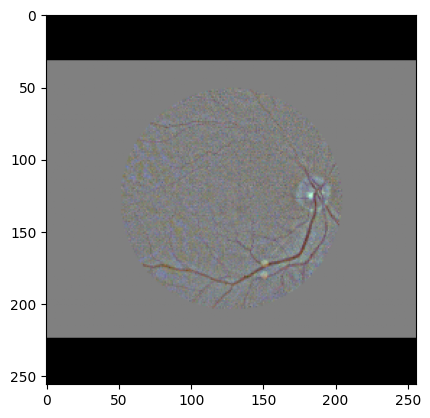

In [69]:
image_dir = '/s/project/deepMMR/data/fundus/raw/right/00'
image_file_name = random.choice(os.listdir(image_dir))
image_path = os.path.join(image_dir, image_file_name)
print(image_path)
scale = 300
resize_size = 256

imshow(process_image(image_path, scale, resize_size) / 255)